Connected to base (Python 3.8.12)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, cumtrapz, quad, trapezoid, cumulative_trapezoid
from scipy.interpolate import interp1d, InterpolatedUnivariateSpline
from itertools import cycle
plt.style.use('seaborn-darkgrid')
import pandas as pd
from scipy.optimize import fsolve, bisect, minimize_scalar
from time import time

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpl_patches
import pickle
plt.style.use('seaborn-whitegrid')
# plt.style.use('default')

In [3]:
mpl.rcParams['xtick.direction'] = "in"
mpl.rcParams['ytick.direction'] = "in"
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['legend.fontsize'] = 18
#mpl.rcParams['figure.constrained_layout.use'] = True
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.minor.size'] = 3

In [4]:
def shock_jump(lamsh, V1, D1, M1):
    Vb1 = V1 - de*lamsh
    fac = (gam-1)/(gam+1)
    D2 = D1/fac
    V2 = Vb1*fac + de*lamsh
    P2 = D1 * Vb1**2 * (2/(gam+1))
    M2 = M1
    return np.array([V2,D2,M2,P2])

def preshock(tht):
    eps = 1/s
    Mta = (3*np.pi/4)**2
    # tht = np.linspace(0.01, 2*np.pi,300)
    Mn = ((tht-np.sin(tht))/np.pi)**(-2/3*s)
    M = Mta * Mn
    lam = (1-np.cos(tht))/2 * Mn**(1/3+eps)
    # D = ( 3*np.pi/8 * (1-np.cos(tht)) * Mn**(3*eps/2-1) * np.sin(tht) * Mta**-2 )**-1
    D = 9*np.pi**2/ ( (2+6*eps) *(1-np.cos(tht))**3 - 9*eps*np.sin(tht) *(tht-np.sin(tht)) *(1-np.cos(tht)) ) * Mn**(-3*eps)
    # D_num = np.gradient(M,lam)/lam**2
    V = np.pi/2 * np.sin(tht)/(1-np.cos(tht)) * Mn**(1/3-eps/2)
    return lam,V,D,M

In [5]:
def odefunc_prof_init_Pless(lam, depvars):
    # lam = 1/laminv
    # lam = np.exp(l)
    V,D,M = depvars
    Vb = V - de*lam
    # linb = -np.array([2*D*V-2*D*lam, (de-1)*V*lam+2/9*M/lam, -3*lam**3*D])/lam
    # # der_num = np.transpose(np.linalg.solve(linMat1,linb1), (1,0))
    # linMat_det1 = Vb**2
    # # if linMat_det1 == 0: print(depvars)
    # linMat_cofac1 = np.array([[0,Vb,0],[Vb,-D,0],[0,0,linMat_det1]])
    # linMat_inv = linMat_cofac1/ linMat_det1
    # der = np.matmul(linMat_inv,linb)
    Fterm = (de-1)*V + 2/9*M/lam**2 # - 10*(-V/(lam/lamdi)**10)/lam
    der = np.array([-Fterm/Vb, (2*Vb*(lam-V)/lam + Fterm) *D/Vb**2, 3*lam**2*D])
    return der #*lam**2

In [6]:
def stop_event(t,y):
    return y[0]+10 #+de*np.exp(t)
stop_event.terminal = True

zero_hold_func = lambda x: 1+np.heaviside(x-10,0.5)-np.heaviside(x,0.5)

def odefunc_full(l, depvars):
    lam = np.exp(l)
    # lmV,lDt,lMt,lPt = depvars
    mVb,D,M,P = np.exp(depvars)
    Vb = -mVb
    V = Vb + de*lam
    # V,D,M,P = from_btilde(lam, mVb,Dt,Mt,Pt)
    Z0 = 0*V
    ar1 = V/V

    Tv = P/D/Vb**2
    linMat_inv = 1/Vb**2/(gam*Tv-1) * np.array([[-gam*Tv, ar1, -Tv],[ar1,-ar1,Tv],[gam*ar1,-gam*ar1,ar1]])
    linb = np.array([2*Vb* (V-lam), (de-1)*V*lam+2/9*M/lam+10*(-V/(lam/lamdi)**10), Vb*lam*((2-Lam0*D**(2-nu)*P**(nu-1))*(gam-1)+2*(de-1))])

    # if not np.isfinite(V/lam).all():
    #     print(V, lam)
    # print(linMat_inv.shape,linb[:,np.newaxis].transpose((2,0,1)).shape)
    linc = np.array([de/Vb*lam,Z0,Z0])
    if np.isscalar(V):
        der = np.matmul(linMat_inv, linb ) 
        # der[0] *= zero_hold_func(V)
        der -= linc
        # der = np.matmul(linMat_inv, linb )+ np.array([-de/Vb*lam,Z0,Z0])
        # if der[0]<0:
            # print(der, linMat_det1, linb, linMat_cofac1)
    else:
        der = np.matmul(linMat_inv.transpose((2,0,1)), linb[:,np.newaxis].transpose((2,0,1)) )
        # der[:,0] *= zero_hold_func(V)[:,np.newaxis]
        der -= linc[:,np.newaxis].transpose((2,0,1))
        der = der.transpose((1,2,0))[:,0,:]

    derM = 3*D*lam**3 /M


    return der, derM, linMat_inv, linb #*lam**2

def odefunc(l, depvars):
    der3, derM = odefunc_full(l, depvars)[:2]
    der = np.insert(der3, 2, derM, axis=0)
    if not np.isfinite(der).all():
        # print(der,l,depvars)
        return np.nan_to_num(der)
    return der

In [7]:
def get_soln_gas_full(lamsh):
    res_pre = solve_ivp(odefunc_prof_init_Pless, (1,lamsh), preshock(np.pi)[1:], max_step=0.01 )
    V1, D1, M1 = res_pre.y[0][-1], res_pre.y[1][-1], res_pre.y[2][-1]
    bcs = shock_jump(lamsh, V1, D1, M1)
    bcs[0] = - bcs[0] + de*lamsh
    # print(bcs)
    bcs = np.log(bcs)
    # bcs[3] = 0
    res_post = solve_ivp(odefunc, (np.log(lamsh),np.log(1e-7)), bcs, method='Radau', max_step=0.05, vectorized=True, events=stop_event)
    return res_pre, res_post

def M0_num(lamsh):
    res = get_soln_gas_full(lamsh)[1]
    M0val = res.y[2][-1]
    stopM0 = np.exp(M0val)-1e-3
    return stopM0 

def lam_atM0(lamsh):
    res = get_soln_gas_full(lamsh)[1]
    return res.t[-1]/np.log(10)+6.999

-2.9166759576859063
0.725s s=1: post shock profiles obtained
0.33897639819093084
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-2.2643441689769412
0.2529s s=1: post shock profiles obtained
0.003001s s=1: all profiles obtained
0s s=1: post shock trajectory obtained


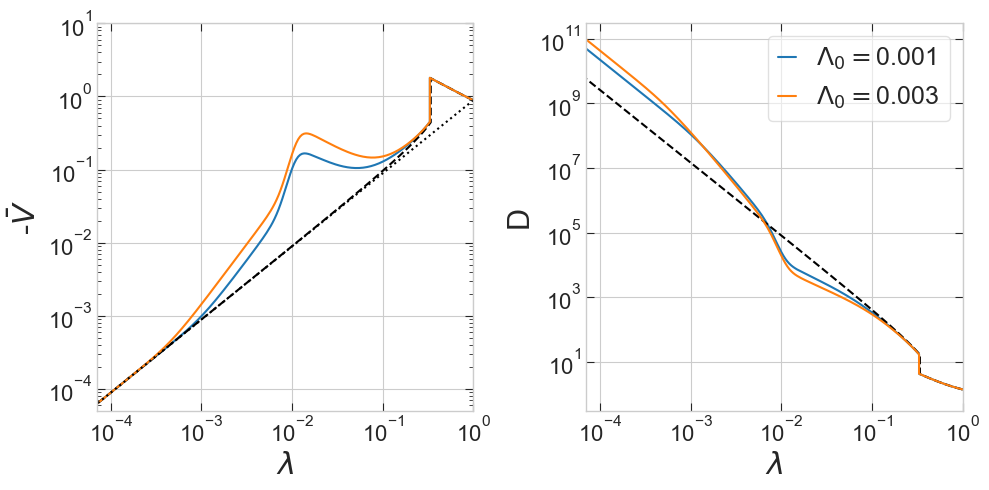

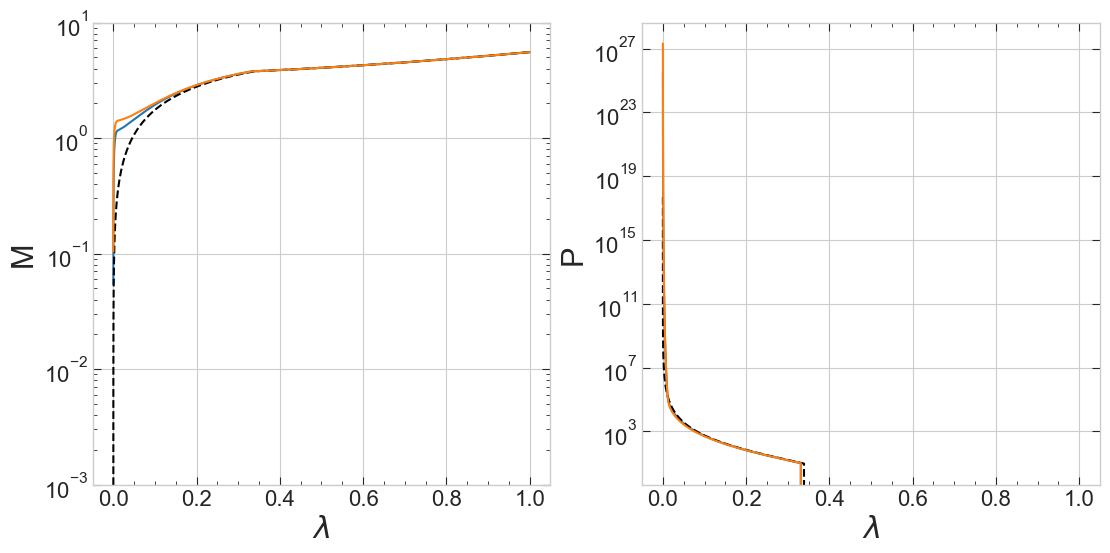

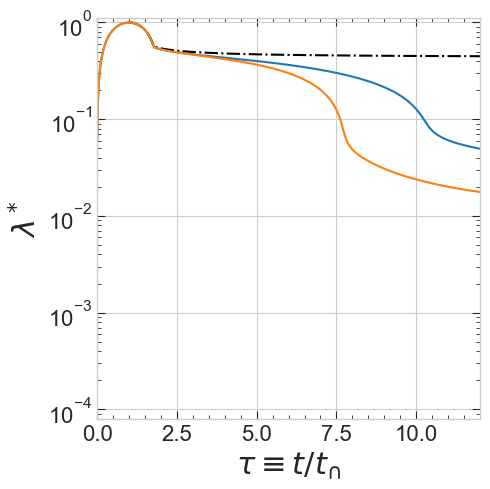

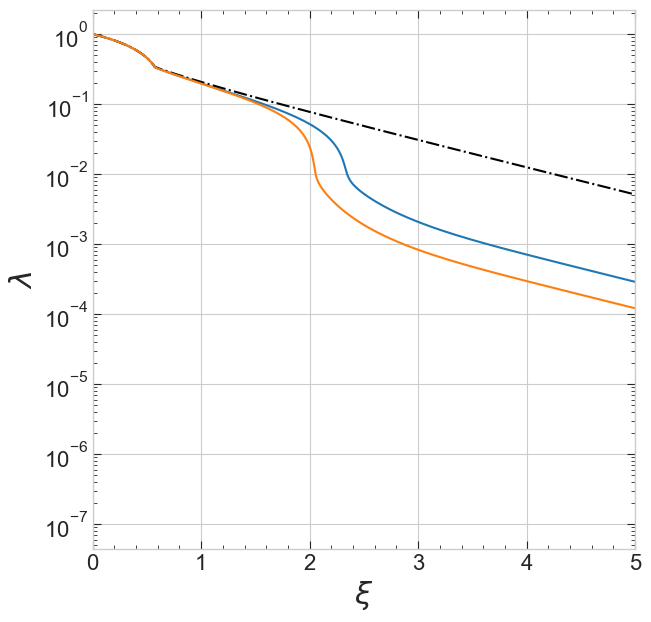

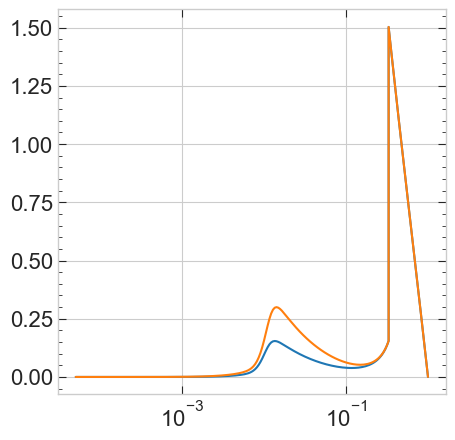

In [8]:
name = 'cold_vary-s'
name = 'shocked_vary-s'
# name = 'shocked_vary-gam'
name = 'shocked_vary-cooling'
# name = 'shocked_vary-lamdish'
# name = 'shocked_vary-lamshsp'

with open(f'{name}-rads.txt', 'tr') as file: rads_list = np.array(eval(file.read()))

s = 1
gam = 5/3
Lam0 = 3e-2
nu=1/2
fb = 0.156837
# fb = 0.5
fd = (1-fb)

lamshsp = 0.9
disk_rad_by_shock = 0.05
lamdish = disk_rad_by_shock #*lamsh

varypars=[]

if name == 'cold_vary-s':
    s_vals = [0.5,1,1.5,2,3,]
    varypars += ['s']
    lamshsp = 0.1
    lamdish = 0.5

if name == 'shocked_vary-s':
    s_vals = [0.5,1,2,]#[:-1]
    varypars += ['s']
    rads_list = rads_list[[0,1,3]]

if name == 'shocked_vary-gam':
    gam_vals= [2,1.8,5/3,1.5,7/5,4/3,]
    lamshsp_vals = [1.2,1.05,0.9,0.7,0.5,0.3]
    varypars += ['gam','lamshsp']

if name == 'shocked_vary-cooling':
    Lam0_vals = [1e-3,3e-3,1e-2,3e-2,1e-1,3e-1]
    varypars += ['Lam0']

if name == 'shocked_vary-lamdish':
    lamdish_vals = [percent/100 for percent in [2,5,10,15,25]]
    varypars += ['lamdish']

if name == 'shocked_vary-lamshsp':
    lamshsp_vals = [1.1,1,.9,.8,.7,.6,.5]#[0.35,0.3,0.25, 0.2]
    varypars += ['lamshsp']


fig5, axs5 = plt.subplots(1,2, dpi=100, figsize=(10,5), sharex=True)
fig51, axs51 = plt.subplots(1,2, dpi=100, figsize=(13,6), sharex=True)
axs5 = np.vstack([axs5,axs51])
fig6, ax6 = plt.subplots(1, dpi=100, figsize=(5,5))
fig62, ax62 = plt.subplots(1, dpi=100, figsize=(7,7))
fig7, ax7 = plt.subplots(1, dpi=100, figsize=(5,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(2):
    plab=''
    try:
        if 'gam' in varypars: gam = gam_vals[i]; plab+=r'$\gamma=$'+f"{gam:.3g}"
        if 's' in varypars: s = s_vals[i]; plab+=f"s={s} "
        if 'lamshsp' in varypars: lamshsp = lamshsp_vals[i]
        if 'lamshsp' in varypars[:1]: plab+=r'$R_s=$'+f'{lamshsp:g}'#plab+=r'$\lambda_s=$'+f'{lamshsp*100:g} '+r'$\%~ \lambda_{sp}$'
        if 'lamdish' in varypars: lamdish = lamdish_vals[i]; plab+=r'$\lambda_d=$'+f'{lamdish*100:g} '+r'$\%~ \lambda_s$'
        if 'Lam0' in varypars: Lam0 = Lam0_vals[i]; plab+=r'$\Lambda_0=$'+f'{Lam0:g} '
        # if 'nu' in varypars: nu = nu_vals[i]; plab+=r'$\nu=$'+f'{nu} '
    except IndexError: break

    t_now = time()
    de = 2* (1+s/3) /3
    alpha_D = -9/(s+3)
    descr = f'_{name}_lamshsp={lamshsp:.3g}_s={s:.2g}_gam={gam:.3g}_lamdish={lamdish:.3g}_Lam0={Lam0:.1e}_nu={nu:.1g}'

    resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm{descr}.hdf5', key=f'gas/iter0', mode='r')
    # lamsh = resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()]
    lamsh = lamshsp*rads_list[i][2] #rads_list[i][1]  #
    lamdi = lamdish*lamsh
    
    # lamshsol = 0.35 #lamsh_sols[s] #+5e-3 # 0.338976 #
    res_pre, res_post = get_soln_gas_full(lamsh)
    print(res_post.y[2][-1])
    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock profiles obtained')

    lamsh_pre = res_pre.t
    V_pre, D_pre, M_pre = res_pre.y

    lamsh_post = np.exp(res_post.t)
    mVb_post, D_post, M_post, P_post = np.exp(res_post.y)
    V_post = de*lamsh_post - mVb_post
    P_pre = lamsh_pre*0

    lamsh = lamsh_pre.min()
    # lam_all = lamsh_pre
    # V_all = V_pre
    # D_all = D_pre
    # M_all = M_pre
    # P_all = P_pre

    lam_all = np.concatenate([lamsh_post, lamsh_pre][::-1])
    V_all = np.concatenate([V_post, V_pre][::-1])
    D_all = np.concatenate([D_post, D_pre][::-1])
    M_all = np.concatenate([M_post, M_pre][::-1])
    P_all = np.concatenate([P_post, P_pre][::-1])
    Vb_all = V_all - de*lam_all

    color_this = colors[i] #plt.cm.turbo(s/4)

    ax7.plot(lam_all,-V_all, color=color_this)
    ax7.set_xscale('log')

    axs5[0,0].plot(lam_all,-Vb_all, color=color_this)
    axs5[0,1].plot(lam_all,D_all, color=color_this, label=plab)
    axs5[1,0].plot(lam_all,M_all, color=color_this)
    axs5[1,1].plot(lam_all,P_all, color=color_this)
    # axs5[0,2].plot(lam_all, P_all/D_all, color=color_this)
    # axs5[1,2].plot(lam_all, P_all/D_all**gam, color=color_this)
    # axs5[1,2].plot(lam_all, D_all*Vb_all**2-gam*P_all, color=color_this)

    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm_shocked_vary-s_lamshsp=0.9_s={s:.2g}_gam={gam:.3g}_lamdish=0.05_Lam0=3.0e-02_nu=0.5.hdf5', key=f'gas/main', mode='r')
    bertshi_vary = True if name.split('-')[-1] in ['gam','s'] else False
    color_this_bertshi = color_this if bertshi_vary else 'k'
    if bertshi_vary or i==0:
        axs5[0,0].plot(resdf_prof_gaso_bertshi.l, -resdf_prof_gaso_bertshi.Vb, color=color_this_bertshi, ls='--')
        axs5[0,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.D, color=color_this_bertshi, ls='--')
        axs5[1,0].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.M, color=color_this_bertshi, ls='--')
        axs5[1,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.P, color=color_this_bertshi, ls='--')
        print(resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()])
    # PderD_post = np.gradient(P_post,lamsh_post)/D_post

    M_intrp = interp1d(lam_all, M_all, fill_value="extrapolate")
    D_intrp = interp1d(lam_all, D_all, fill_value="extrapolate")
    V_intrp = interp1d(lam_all, V_all, fill_value="extrapolate")
    irem = P_pre.shape[0]-1
    # PderD_intrp = interp1d(np.delete(lam_all,irem), np.delete(PderD_all,irem), kind='linear', fill_value="extrapolate")

    # PderD_intrp = interp1d(lamsh_post, PderD_post, kind='linear', fill_value=0, bounds_error=False)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: all profiles obtained')

    def odefunc_traj(xi, arg):
        lam = arg
        return V_intrp(lam)-de*lam

    # taush = (thtshsol - np.sin(thtshsol)) / np.pi
    # xish = np.log(taush)
    # res = solve_ivp(odefunc_traj, (0,5), (1,), method='Radau', max_step=0.01, dense_output=False, vectorized=True)
    # res1 = solve_ivp(fun, (res.t[-1],15), np.array([res.y[0][-1],-res.y[1][-1]]), max_step=0.1, dense_output=True)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock trajectory obtained')
    
    # xires = res.t
    # lamres = res.y[0]
    # vres = res.y[1]
    xires,lamres = cumtrapz(1/(V_all-de*lam_all), x=lam_all), lam_all[1:]

    taures = np.exp(xires)
    lamFres = lamres*taures**de

    ax6.plot(taures,lamFres, color=color_this, label=plab)
    ax62.plot(xires,lamres, color=color_this)
    xio,lamo = cumtrapz(1/(resdf_prof_gaso_bertshi.V-de*resdf_prof_gaso_bertshi.l), x=resdf_prof_gaso_bertshi.l), resdf_prof_gaso_bertshi.l[1:]
    tauo = np.exp(xio)
    lamFo = lamo*tauo**de
    if bertshi_vary or i==0:
        ax62.plot(xio,lamo, c=color_this_bertshi, ls='-.')
        ax6.plot(tauo,lamFo, color=color_this_bertshi, ls='-.')

    #trajectory analytical
    thet_range = np.linspace(0.5, 1.2*np.pi,2000)
    tau_anlt = (thet_range - np.sin(thet_range)) / np.pi
    xi_anlt = np.log(tau_anlt)
    lam_anlt = preshock(thet_range)[0]
    lamF_anlt = lam_anlt*tau_anlt**de

    # ax6.plot(xi_anlt, lam_anlt, color=color_this)
    ax6.plot(tau_anlt, lamF_anlt, color=color_this)
    
    # dmo_prfl = pd.read_hdf(f'profiles_dmo_{s}.hdf5')

    # Mta = (3*np.pi/4)**2
    # M_dmo = interp1d(dmo_prfl['l'], dmo_prfl['M']*Mta, fill_value="extrapolate")
    # D_dmo = interp1d(dmo_prfl['l'].iloc[1:], dmo_prfl['rho'].iloc[1:], fill_value="extrapolate")

    # axs5[1,0].plot(lam_all, M_dmo(lam_all), color=color_this, ls='dashed')
    if name.split('_')[-1] =='vary-s':
        axs5[0,0].plot(lam_all,de*lam_all, c=color_this, ls=':')

#Loop ends

axs5[0,0].plot([],[], c='k', ls='-', label='This work')
axs5[0,0].plot([],[], c='k', ls='--', label='Bertschinger')
if name.split('_')[-1] !='vary-s':
    axs5[0,0].plot(lam_all,de*lam_all, c='k', ls=':', label='V=0')
else:
    axs5[0,0].plot([],[], c='k', ls=':', label='V=0')

# ax6.legend(loc='best',frameon=True, framealpha=0.6)
ax6.set_xlabel(r'$\tau \equiv t/t_{\cap}$')
ax6.set_ylabel(r'$\lambda^*\equiv r/r_{\cap}(t=t_{\cap})$')
ax6.set_xlim(0,12)
ax6.set_ylim(0.00008,1.1)
# ax6.set_xscale('log')
ax6.set_yscale('log')

ax62.set_xlabel(r'$\xi$')
ax62.set_ylabel('$\lambda$')
# ax62.set_xlim(,)
# ax62.set_ylim(0.01,1.1)
ax62.set_yscale('log')
    
axs5[0,0].set_xscale('log')
axs5[0,0].set_xlim(1e-5,1)
if name in ['shocked_vary-s','shocked_vary-lamshsp', 'shocked_vary-gam','cold_vary-s']:
    axs5[0,0].legend(loc='best', frameon=True, framealpha=0.6, handlelength=1)
axs5[0,1].legend(loc='best', frameon=True, framealpha=0.6, handlelength=0.7)
if name=='cold_vary-s':
    axs5[0,1].text(1e-3,1e9,'$R_s=0.1$', fontsize=15)
# axs5[0,1].legend()
axs5[0,0].set_xlabel('$\lambda$')
axs5[0,1].set_xlabel('$\lambda$')
axs5[1,0].set_xlabel('$\lambda$')
axs5[1,1].set_xlabel('$\lambda$')
# axs5[1,2].set_xlabel('$\lambda$')

# if gam==5/3:
#     axs5[0,0].set_xlim(7e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e-1,1e11)
#     axs5[1,0].set_ylim(1e-3,1e1)
#     # axs5[1,1].set_ylim(1e0,1e14)
#     # axs5[0,2].set_ylim(1e-1,1e2)
#     # axs5[1,2].set_ylim(1e-5,5e-1)
# elif gam==4/3:
#     axs5[0,0].set_xlim(1e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e0,1e11)
#     axs5[1,0].set_ylim(1e-2,1e1)
#     axs5[1,1].set_ylim(1e1,1e14)
#     # axs5[0,2].set_ylim(1e0,1e3)
#     # axs5[1,2].set_ylim(1e-2,5e-1)

axs5[0,0].set_xlim(7e-5,1)
axs5[0,0].set_ylim(5e-5,1e1)
axs5[0,1].set_ylim(3e-1,3e11)
axs5[1,0].set_ylim(1e-3,1e1)
# axs5[1,1].set_ylim(1e0,1e14)


axs5[0,0].set_ylabel(r'-$\bar{V} \equiv -d \lambda/d \xi = -V + \delta \lambda$')
axs5[0,1].set_ylabel('D')
axs5[1,0].set_ylabel('M')
axs5[1,1].set_ylabel('P')
# axs5[0,2].set_ylabel('T')
# axs5[1,2].set_ylabel('K')

axs5[0,0].set_yscale('log')
axs5[0,1].set_yscale('log')
axs5[1,0].set_yscale('log')
axs5[1,1].set_yscale('log')
ax62.set_xlim(0,5)
# axs5[0,2].set_yscale('log')
# axs5[1,2].set_yscale('log')

if name in ['shocked_vary-gam','shocked_vary-cooling']:
    axs5[0,0].set_ylabel(r'-$\bar{V}$')
    ax6.set_ylabel(r'$\lambda^*$')
# axs5[0,0].xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10,subs=np.arange(-4, 1)))
# axs5[0,0].xaxis.get_ticklocs(minor=True)
# axs5[0,0].minorticks_on()
# axs5[0,0].xaxis.set_tick_params(which='minor', bottom=True)

# # Additional lines to set major xticks
# axs5[0, 0].xaxis.set_major_locator(mpl.ticker.LogLocator(base=10, subs=np.arange(-4, 1,0.01)))
# axs5[0, 0].xaxis.get_ticklocs()

axs5[0,0].set_xticks([1e-4,1e-3,1e-2,1e-1,1])

fig5.tight_layout()
fig6.tight_layout()

fig5.savefig(f'Eds-gaso_profiles_{name}.pdf')
fig6.savefig(f'Eds-gaso_trajectory_{name}.pdf')
# axs5[0,0].set_xlim(1e-6,1)
# axs5[1,0].set_ylim(1e-4,1e1)

-1.6851359768740504
0.2763s s=1: post shock profiles obtained
0.33897639819093084
0.01959s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-1.156491327573961
0.2164s s=1: post shock profiles obtained
0.003979s s=1: all profiles obtained
0s s=1: post shock trajectory obtained


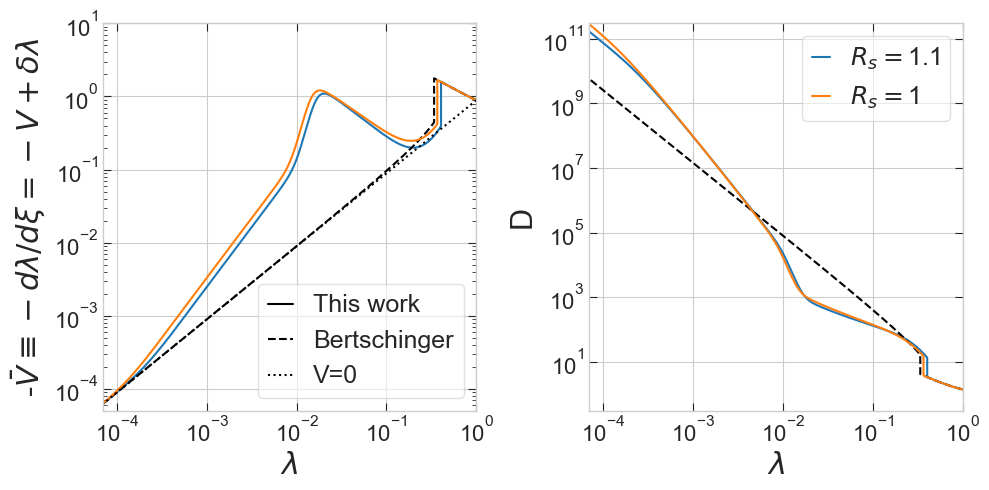

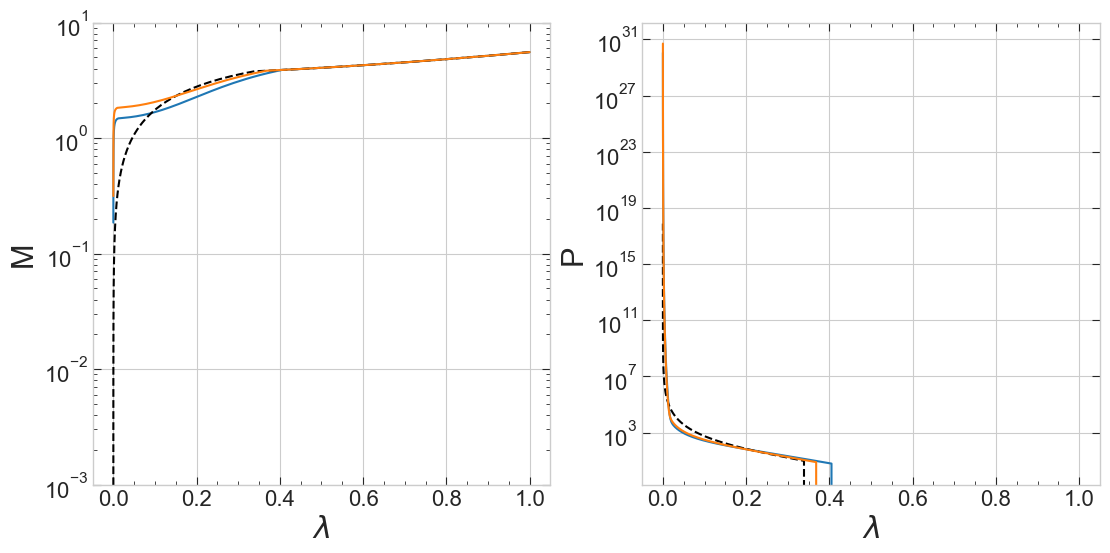

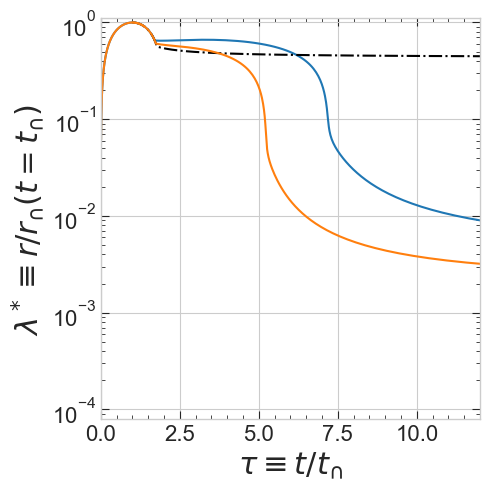

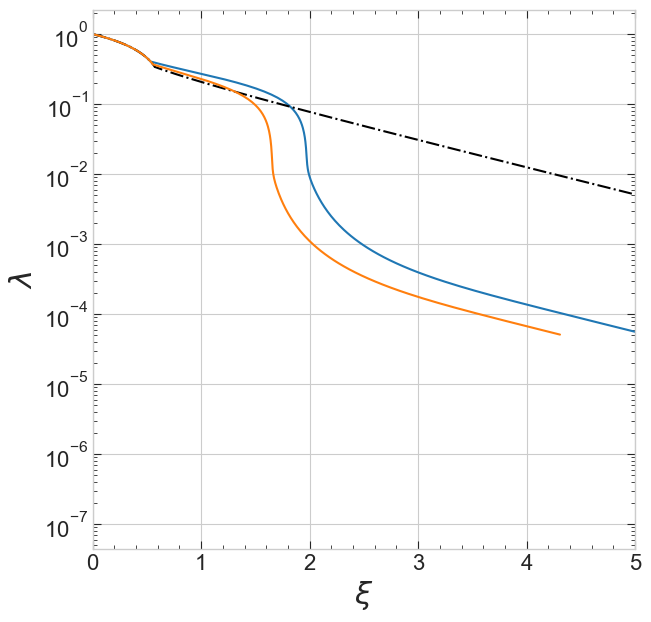

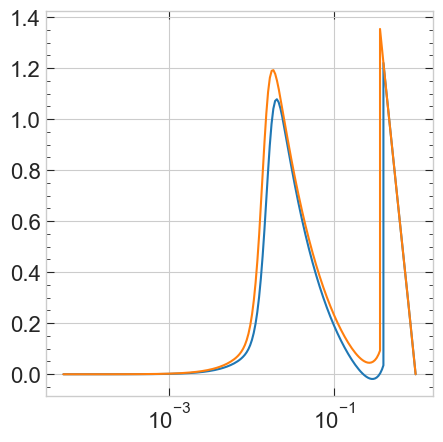

In [9]:
name = 'cold_vary-s'
name = 'shocked_vary-s'
# name = 'shocked_vary-gam'
# name = 'shocked_vary-cooling'
# name = 'shocked_vary-lamdish'
name = 'shocked_vary-lamshsp'

with open(f'{name}-rads.txt', 'tr') as file: rads_list = np.array(eval(file.read()))

s = 1
gam = 5/3
Lam0 = 3e-2
nu=1/2
fb = 0.156837
# fb = 0.5
fd = (1-fb)

lamshsp = 0.9
disk_rad_by_shock = 0.05
lamdish = disk_rad_by_shock #*lamsh

varypars=[]

if name == 'cold_vary-s':
    s_vals = [0.5,1,1.5,2,3,]
    varypars += ['s']
    lamshsp = 0.1
    lamdish = 0.5

if name == 'shocked_vary-s':
    s_vals = [0.5,1,2,]#[:-1]
    varypars += ['s']
    rads_list = rads_list[[0,1,3]]

if name == 'shocked_vary-gam':
    gam_vals= [2,1.8,5/3,1.5,7/5,4/3,]
    lamshsp_vals = [1.2,1.05,0.9,0.7,0.5,0.3]
    varypars += ['gam','lamshsp']

if name == 'shocked_vary-cooling':
    Lam0_vals = [1e-3,3e-3,1e-2,3e-2,1e-1,3e-1]
    varypars += ['Lam0']

if name == 'shocked_vary-lamdish':
    lamdish_vals = [percent/100 for percent in [2,5,10,15,25]]
    varypars += ['lamdish']

if name == 'shocked_vary-lamshsp':
    lamshsp_vals = [1.1,1,.9,.8,.7,.6,.5]#[0.35,0.3,0.25, 0.2]
    varypars += ['lamshsp']


fig5, axs5 = plt.subplots(1,2, dpi=100, figsize=(10,5), sharex=True)
fig51, axs51 = plt.subplots(1,2, dpi=100, figsize=(13,6), sharex=True)
axs5 = np.vstack([axs5,axs51])
fig6, ax6 = plt.subplots(1, dpi=100, figsize=(5,5))
fig62, ax62 = plt.subplots(1, dpi=100, figsize=(7,7))
fig7, ax7 = plt.subplots(1, dpi=100, figsize=(5,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(2):
    plab=''
    try:
        if 'gam' in varypars: gam = gam_vals[i]; plab+=r'$\gamma=$'+f"{gam:.3g}"
        if 's' in varypars: s = s_vals[i]; plab+=f"s={s} "
        if 'lamshsp' in varypars: lamshsp = lamshsp_vals[i]
        if 'lamshsp' in varypars[:1]: plab+=r'$R_s=$'+f'{lamshsp:g}'#plab+=r'$\lambda_s=$'+f'{lamshsp*100:g} '+r'$\%~ \lambda_{sp}$'
        if 'lamdish' in varypars: lamdish = lamdish_vals[i]; plab+=r'$\lambda_d=$'+f'{lamdish*100:g} '+r'$\%~ \lambda_s$'
        if 'Lam0' in varypars: Lam0 = Lam0_vals[i]; plab+=r'$\Lambda_0=$'+f'{Lam0:g} '
        # if 'nu' in varypars: nu = nu_vals[i]; plab+=r'$\nu=$'+f'{nu} '
    except IndexError: break

    t_now = time()
    de = 2* (1+s/3) /3
    alpha_D = -9/(s+3)
    descr = f'_{name}_lamshsp={lamshsp:.3g}_s={s:.2g}_gam={gam:.3g}_lamdish={lamdish:.3g}_Lam0={Lam0:.1e}_nu={nu:.1g}'

    resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm{descr}.hdf5', key=f'gas/iter0', mode='r')
    # lamsh = resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()]
    lamsh = lamshsp*rads_list[i][2] #rads_list[i][1]  #
    lamdi = lamdish*lamsh
    
    # lamshsol = 0.35 #lamsh_sols[s] #+5e-3 # 0.338976 #
    res_pre, res_post = get_soln_gas_full(lamsh)
    print(res_post.y[2][-1])
    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock profiles obtained')

    lamsh_pre = res_pre.t
    V_pre, D_pre, M_pre = res_pre.y

    lamsh_post = np.exp(res_post.t)
    mVb_post, D_post, M_post, P_post = np.exp(res_post.y)
    V_post = de*lamsh_post - mVb_post
    P_pre = lamsh_pre*0

    lamsh = lamsh_pre.min()
    # lam_all = lamsh_pre
    # V_all = V_pre
    # D_all = D_pre
    # M_all = M_pre
    # P_all = P_pre

    lam_all = np.concatenate([lamsh_post, lamsh_pre][::-1])
    V_all = np.concatenate([V_post, V_pre][::-1])
    D_all = np.concatenate([D_post, D_pre][::-1])
    M_all = np.concatenate([M_post, M_pre][::-1])
    P_all = np.concatenate([P_post, P_pre][::-1])
    Vb_all = V_all - de*lam_all

    color_this = colors[i] #plt.cm.turbo(s/4)

    ax7.plot(lam_all,-V_all, color=color_this)
    ax7.set_xscale('log')

    axs5[0,0].plot(lam_all,-Vb_all, color=color_this)
    axs5[0,1].plot(lam_all,D_all, color=color_this, label=plab)
    axs5[1,0].plot(lam_all,M_all, color=color_this)
    axs5[1,1].plot(lam_all,P_all, color=color_this)
    # axs5[0,2].plot(lam_all, P_all/D_all, color=color_this)
    # axs5[1,2].plot(lam_all, P_all/D_all**gam, color=color_this)
    # axs5[1,2].plot(lam_all, D_all*Vb_all**2-gam*P_all, color=color_this)

    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm_shocked_vary-s_lamshsp=0.9_s={s:.2g}_gam={gam:.3g}_lamdish=0.05_Lam0=3.0e-02_nu=0.5.hdf5', key=f'gas/main', mode='r')
    bertshi_vary = True if name.split('-')[-1] in ['gam','s'] else False
    color_this_bertshi = color_this if bertshi_vary else 'k'
    if bertshi_vary or i==0:
        axs5[0,0].plot(resdf_prof_gaso_bertshi.l, -resdf_prof_gaso_bertshi.Vb, color=color_this_bertshi, ls='--')
        axs5[0,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.D, color=color_this_bertshi, ls='--')
        axs5[1,0].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.M, color=color_this_bertshi, ls='--')
        axs5[1,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.P, color=color_this_bertshi, ls='--')
        print(resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()])
    # PderD_post = np.gradient(P_post,lamsh_post)/D_post

    M_intrp = interp1d(lam_all, M_all, fill_value="extrapolate")
    D_intrp = interp1d(lam_all, D_all, fill_value="extrapolate")
    V_intrp = interp1d(lam_all, V_all, fill_value="extrapolate")
    irem = P_pre.shape[0]-1
    # PderD_intrp = interp1d(np.delete(lam_all,irem), np.delete(PderD_all,irem), kind='linear', fill_value="extrapolate")

    # PderD_intrp = interp1d(lamsh_post, PderD_post, kind='linear', fill_value=0, bounds_error=False)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: all profiles obtained')

    def odefunc_traj(xi, arg):
        lam = arg
        return V_intrp(lam)-de*lam

    # taush = (thtshsol - np.sin(thtshsol)) / np.pi
    # xish = np.log(taush)
    # res = solve_ivp(odefunc_traj, (0,5), (1,), method='Radau', max_step=0.01, dense_output=False, vectorized=True)
    # res1 = solve_ivp(fun, (res.t[-1],15), np.array([res.y[0][-1],-res.y[1][-1]]), max_step=0.1, dense_output=True)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock trajectory obtained')
    
    # xires = res.t
    # lamres = res.y[0]
    # vres = res.y[1]
    xires,lamres = cumtrapz(1/(V_all-de*lam_all), x=lam_all), lam_all[1:]

    taures = np.exp(xires)
    lamFres = lamres*taures**de

    ax6.plot(taures,lamFres, color=color_this, label=plab)
    ax62.plot(xires,lamres, color=color_this)
    xio,lamo = cumtrapz(1/(resdf_prof_gaso_bertshi.V-de*resdf_prof_gaso_bertshi.l), x=resdf_prof_gaso_bertshi.l), resdf_prof_gaso_bertshi.l[1:]
    tauo = np.exp(xio)
    lamFo = lamo*tauo**de
    if bertshi_vary or i==0:
        ax62.plot(xio,lamo, c=color_this_bertshi, ls='-.')
        ax6.plot(tauo,lamFo, color=color_this_bertshi, ls='-.')

    #trajectory analytical
    thet_range = np.linspace(0.5, 1.2*np.pi,2000)
    tau_anlt = (thet_range - np.sin(thet_range)) / np.pi
    xi_anlt = np.log(tau_anlt)
    lam_anlt = preshock(thet_range)[0]
    lamF_anlt = lam_anlt*tau_anlt**de

    # ax6.plot(xi_anlt, lam_anlt, color=color_this)
    ax6.plot(tau_anlt, lamF_anlt, color=color_this)
    
    # dmo_prfl = pd.read_hdf(f'profiles_dmo_{s}.hdf5')

    # Mta = (3*np.pi/4)**2
    # M_dmo = interp1d(dmo_prfl['l'], dmo_prfl['M']*Mta, fill_value="extrapolate")
    # D_dmo = interp1d(dmo_prfl['l'].iloc[1:], dmo_prfl['rho'].iloc[1:], fill_value="extrapolate")

    # axs5[1,0].plot(lam_all, M_dmo(lam_all), color=color_this, ls='dashed')
    if name.split('_')[-1] =='vary-s':
        axs5[0,0].plot(lam_all,de*lam_all, c=color_this, ls=':')

#Loop ends

axs5[0,0].plot([],[], c='k', ls='-', label='This work')
axs5[0,0].plot([],[], c='k', ls='--', label='Bertschinger')
if name.split('_')[-1] !='vary-s':
    axs5[0,0].plot(lam_all,de*lam_all, c='k', ls=':', label='V=0')
else:
    axs5[0,0].plot([],[], c='k', ls=':', label='V=0')

# ax6.legend(loc='best',frameon=True, framealpha=0.6)
ax6.set_xlabel(r'$\tau \equiv t/t_{\cap}$')
ax6.set_ylabel(r'$\lambda^*\equiv r/r_{\cap}(t=t_{\cap})$')
ax6.set_xlim(0,12)
ax6.set_ylim(0.00008,1.1)
# ax6.set_xscale('log')
ax6.set_yscale('log')

ax62.set_xlabel(r'$\xi$')
ax62.set_ylabel('$\lambda$')
# ax62.set_xlim(,)
# ax62.set_ylim(0.01,1.1)
ax62.set_yscale('log')
    
axs5[0,0].set_xscale('log')
axs5[0,0].set_xlim(1e-5,1)
if name in ['shocked_vary-s','shocked_vary-lamshsp', 'shocked_vary-gam','cold_vary-s']:
    axs5[0,0].legend(loc='best', frameon=True, framealpha=0.6, handlelength=1)
axs5[0,1].legend(loc='best', frameon=True, framealpha=0.6, handlelength=0.7)
if name=='cold_vary-s':
    axs5[0,1].text(1e-3,1e9,'$R_s=0.1$', fontsize=15)
# axs5[0,1].legend()
axs5[0,0].set_xlabel('$\lambda$')
axs5[0,1].set_xlabel('$\lambda$')
axs5[1,0].set_xlabel('$\lambda$')
axs5[1,1].set_xlabel('$\lambda$')
# axs5[1,2].set_xlabel('$\lambda$')

# if gam==5/3:
#     axs5[0,0].set_xlim(7e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e-1,1e11)
#     axs5[1,0].set_ylim(1e-3,1e1)
#     # axs5[1,1].set_ylim(1e0,1e14)
#     # axs5[0,2].set_ylim(1e-1,1e2)
#     # axs5[1,2].set_ylim(1e-5,5e-1)
# elif gam==4/3:
#     axs5[0,0].set_xlim(1e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e0,1e11)
#     axs5[1,0].set_ylim(1e-2,1e1)
#     axs5[1,1].set_ylim(1e1,1e14)
#     # axs5[0,2].set_ylim(1e0,1e3)
#     # axs5[1,2].set_ylim(1e-2,5e-1)

axs5[0,0].set_xlim(7e-5,1)
axs5[0,0].set_ylim(5e-5,1e1)
axs5[0,1].set_ylim(3e-1,3e11)
axs5[1,0].set_ylim(1e-3,1e1)
# axs5[1,1].set_ylim(1e0,1e14)


axs5[0,0].set_ylabel(r'-$\bar{V} \equiv -d \lambda/d \xi = -V + \delta \lambda$')
axs5[0,1].set_ylabel('D')
axs5[1,0].set_ylabel('M')
axs5[1,1].set_ylabel('P')
# axs5[0,2].set_ylabel('T')
# axs5[1,2].set_ylabel('K')

axs5[0,0].set_yscale('log')
axs5[0,1].set_yscale('log')
axs5[1,0].set_yscale('log')
axs5[1,1].set_yscale('log')
ax62.set_xlim(0,5)
# axs5[0,2].set_yscale('log')
# axs5[1,2].set_yscale('log')

if name in ['shocked_vary-gam','shocked_vary-cooling']:
    axs5[0,0].set_ylabel(r'-$\bar{V}$')
    ax6.set_ylabel(r'$\lambda^*$')
# axs5[0,0].xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10,subs=np.arange(-4, 1)))
# axs5[0,0].xaxis.get_ticklocs(minor=True)
# axs5[0,0].minorticks_on()
# axs5[0,0].xaxis.set_tick_params(which='minor', bottom=True)

# # Additional lines to set major xticks
# axs5[0, 0].xaxis.set_major_locator(mpl.ticker.LogLocator(base=10, subs=np.arange(-4, 1,0.01)))
# axs5[0, 0].xaxis.get_ticklocs()

axs5[0,0].set_xticks([1e-4,1e-3,1e-2,1e-1,1])

fig5.tight_layout()
fig6.tight_layout()

fig5.savefig(f'Eds-gaso_profiles_{name}.pdf')
fig6.savefig(f'Eds-gaso_trajectory_{name}.pdf')
# axs5[0,0].set_xlim(1e-6,1)
# axs5[1,0].set_ylim(1e-4,1e1)

-1.6851359768740504
0.2601s s=1: post shock profiles obtained
0.33897639819093084
0.02264s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-1.156491327573961
0.2283s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-0.6890849368141942
0.2328s s=1: post shock profiles obtained
0.004061s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-0.28752288100843615
0.2128s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.03897516321836761
0.2511s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.30693921668639257
0.2293s s=1: post shock profiles obtained
0.003004s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.5339671828938729
0.218s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained


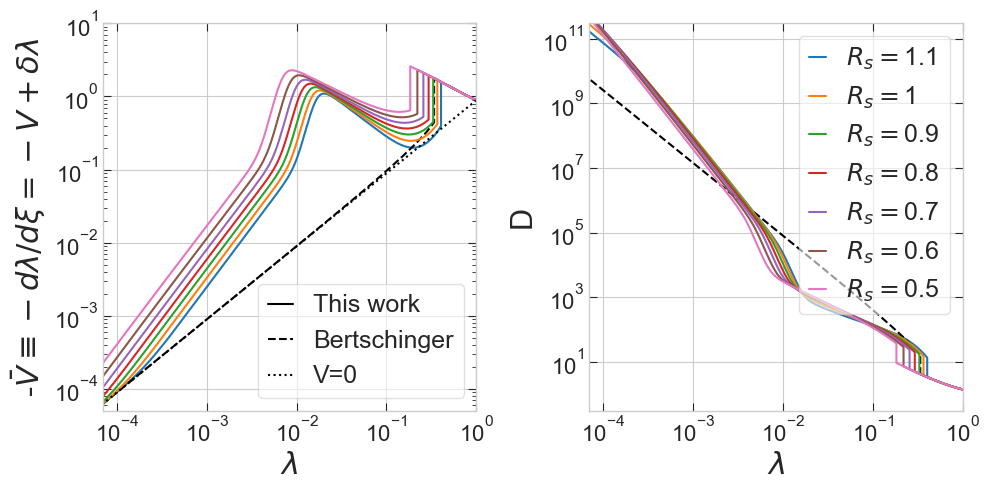

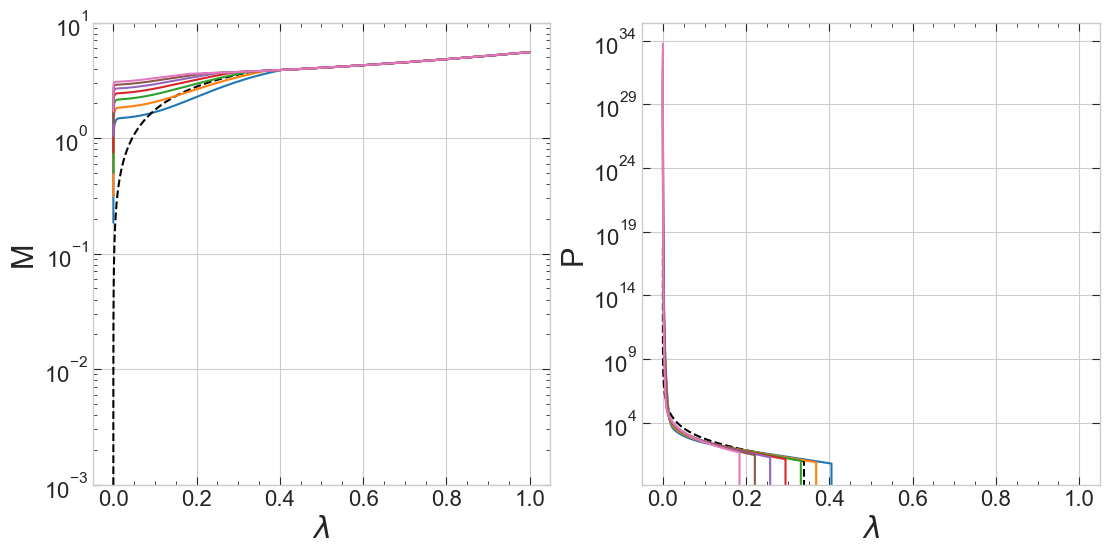

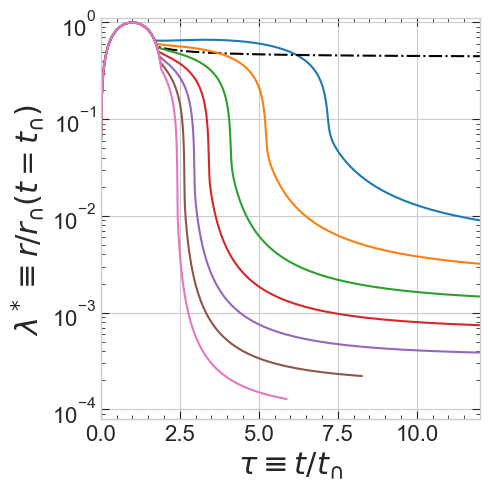

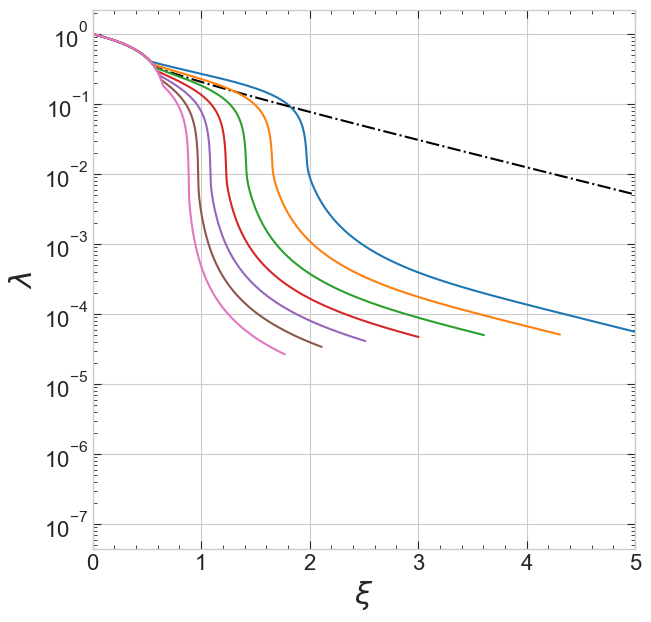

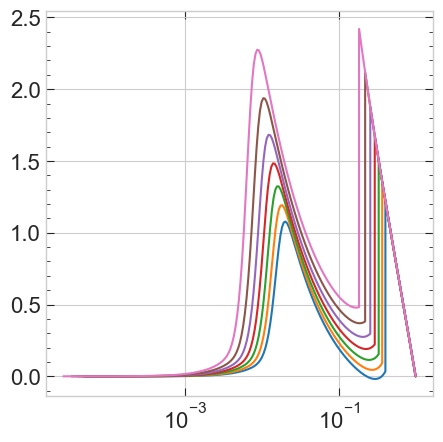

In [10]:
name = 'cold_vary-s'
name = 'shocked_vary-s'
# name = 'shocked_vary-gam'
# name = 'shocked_vary-cooling'
# name = 'shocked_vary-lamdish'
name = 'shocked_vary-lamshsp'

with open(f'{name}-rads.txt', 'tr') as file: rads_list = np.array(eval(file.read()))

s = 1
gam = 5/3
Lam0 = 3e-2
nu=1/2
fb = 0.156837
# fb = 0.5
fd = (1-fb)

lamshsp = 0.9
disk_rad_by_shock = 0.05
lamdish = disk_rad_by_shock #*lamsh

varypars=[]

if name == 'cold_vary-s':
    s_vals = [0.5,1,1.5,2,3,]
    varypars += ['s']
    lamshsp = 0.1
    lamdish = 0.5

if name == 'shocked_vary-s':
    s_vals = [0.5,1,2,]#[:-1]
    varypars += ['s']
    rads_list = rads_list[[0,1,3]]

if name == 'shocked_vary-gam':
    gam_vals= [2,1.8,5/3,1.5,7/5,4/3,]
    lamshsp_vals = [1.2,1.05,0.9,0.7,0.5,0.3]
    varypars += ['gam','lamshsp']

if name == 'shocked_vary-cooling':
    Lam0_vals = [1e-3,3e-3,1e-2,3e-2,1e-1,3e-1]
    varypars += ['Lam0']

if name == 'shocked_vary-lamdish':
    lamdish_vals = [percent/100 for percent in [2,5,10,15,25]]
    varypars += ['lamdish']

if name == 'shocked_vary-lamshsp':
    lamshsp_vals = [1.1,1,.9,.8,.7,.6,.5]#[0.35,0.3,0.25, 0.2]
    varypars += ['lamshsp']


fig5, axs5 = plt.subplots(1,2, dpi=100, figsize=(10,5), sharex=True)
fig51, axs51 = plt.subplots(1,2, dpi=100, figsize=(13,6), sharex=True)
axs5 = np.vstack([axs5,axs51])
fig6, ax6 = plt.subplots(1, dpi=100, figsize=(5,5))
fig62, ax62 = plt.subplots(1, dpi=100, figsize=(7,7))
fig7, ax7 = plt.subplots(1, dpi=100, figsize=(5,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(20):
    plab=''
    try:
        if 'gam' in varypars: gam = gam_vals[i]; plab+=r'$\gamma=$'+f"{gam:.3g}"
        if 's' in varypars: s = s_vals[i]; plab+=f"s={s} "
        if 'lamshsp' in varypars: lamshsp = lamshsp_vals[i]
        if 'lamshsp' in varypars[:1]: plab+=r'$R_s=$'+f'{lamshsp:g}'#plab+=r'$\lambda_s=$'+f'{lamshsp*100:g} '+r'$\%~ \lambda_{sp}$'
        if 'lamdish' in varypars: lamdish = lamdish_vals[i]; plab+=r'$\lambda_d=$'+f'{lamdish*100:g} '+r'$\%~ \lambda_s$'
        if 'Lam0' in varypars: Lam0 = Lam0_vals[i]; plab+=r'$\Lambda_0=$'+f'{Lam0:g} '
        # if 'nu' in varypars: nu = nu_vals[i]; plab+=r'$\nu=$'+f'{nu} '
    except IndexError: break

    t_now = time()
    de = 2* (1+s/3) /3
    alpha_D = -9/(s+3)
    descr = f'_{name}_lamshsp={lamshsp:.3g}_s={s:.2g}_gam={gam:.3g}_lamdish={lamdish:.3g}_Lam0={Lam0:.1e}_nu={nu:.1g}'

    resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm{descr}.hdf5', key=f'gas/iter0', mode='r')
    # lamsh = resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()]
    lamsh = lamshsp*rads_list[i][2] #rads_list[i][1]  #
    lamdi = lamdish*lamsh
    
    # lamshsol = 0.35 #lamsh_sols[s] #+5e-3 # 0.338976 #
    res_pre, res_post = get_soln_gas_full(lamsh)
    print(res_post.y[2][-1])
    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock profiles obtained')

    lamsh_pre = res_pre.t
    V_pre, D_pre, M_pre = res_pre.y

    lamsh_post = np.exp(res_post.t)
    mVb_post, D_post, M_post, P_post = np.exp(res_post.y)
    V_post = de*lamsh_post - mVb_post
    P_pre = lamsh_pre*0

    lamsh = lamsh_pre.min()
    # lam_all = lamsh_pre
    # V_all = V_pre
    # D_all = D_pre
    # M_all = M_pre
    # P_all = P_pre

    lam_all = np.concatenate([lamsh_post, lamsh_pre][::-1])
    V_all = np.concatenate([V_post, V_pre][::-1])
    D_all = np.concatenate([D_post, D_pre][::-1])
    M_all = np.concatenate([M_post, M_pre][::-1])
    P_all = np.concatenate([P_post, P_pre][::-1])
    Vb_all = V_all - de*lam_all

    color_this = colors[i] #plt.cm.turbo(s/4)

    ax7.plot(lam_all,-V_all, color=color_this)
    ax7.set_xscale('log')

    axs5[0,0].plot(lam_all,-Vb_all, color=color_this)
    axs5[0,1].plot(lam_all,D_all, color=color_this, label=plab)
    axs5[1,0].plot(lam_all,M_all, color=color_this)
    axs5[1,1].plot(lam_all,P_all, color=color_this)
    # axs5[0,2].plot(lam_all, P_all/D_all, color=color_this)
    # axs5[1,2].plot(lam_all, P_all/D_all**gam, color=color_this)
    # axs5[1,2].plot(lam_all, D_all*Vb_all**2-gam*P_all, color=color_this)

    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm_shocked_vary-s_lamshsp=0.9_s={s:.2g}_gam={gam:.3g}_lamdish=0.05_Lam0=3.0e-02_nu=0.5.hdf5', key=f'gas/main', mode='r')
    bertshi_vary = True if name.split('-')[-1] in ['gam','s'] else False
    color_this_bertshi = color_this if bertshi_vary else 'k'
    if bertshi_vary or i==0:
        axs5[0,0].plot(resdf_prof_gaso_bertshi.l, -resdf_prof_gaso_bertshi.Vb, color=color_this_bertshi, ls='--')
        axs5[0,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.D, color=color_this_bertshi, ls='--')
        axs5[1,0].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.M, color=color_this_bertshi, ls='--')
        axs5[1,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.P, color=color_this_bertshi, ls='--')
        print(resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()])
    # PderD_post = np.gradient(P_post,lamsh_post)/D_post

    M_intrp = interp1d(lam_all, M_all, fill_value="extrapolate")
    D_intrp = interp1d(lam_all, D_all, fill_value="extrapolate")
    V_intrp = interp1d(lam_all, V_all, fill_value="extrapolate")
    irem = P_pre.shape[0]-1
    # PderD_intrp = interp1d(np.delete(lam_all,irem), np.delete(PderD_all,irem), kind='linear', fill_value="extrapolate")

    # PderD_intrp = interp1d(lamsh_post, PderD_post, kind='linear', fill_value=0, bounds_error=False)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: all profiles obtained')

    def odefunc_traj(xi, arg):
        lam = arg
        return V_intrp(lam)-de*lam

    # taush = (thtshsol - np.sin(thtshsol)) / np.pi
    # xish = np.log(taush)
    # res = solve_ivp(odefunc_traj, (0,5), (1,), method='Radau', max_step=0.01, dense_output=False, vectorized=True)
    # res1 = solve_ivp(fun, (res.t[-1],15), np.array([res.y[0][-1],-res.y[1][-1]]), max_step=0.1, dense_output=True)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock trajectory obtained')
    
    # xires = res.t
    # lamres = res.y[0]
    # vres = res.y[1]
    xires,lamres = cumtrapz(1/(V_all-de*lam_all), x=lam_all), lam_all[1:]

    taures = np.exp(xires)
    lamFres = lamres*taures**de

    ax6.plot(taures,lamFres, color=color_this, label=plab)
    ax62.plot(xires,lamres, color=color_this)
    xio,lamo = cumtrapz(1/(resdf_prof_gaso_bertshi.V-de*resdf_prof_gaso_bertshi.l), x=resdf_prof_gaso_bertshi.l), resdf_prof_gaso_bertshi.l[1:]
    tauo = np.exp(xio)
    lamFo = lamo*tauo**de
    if bertshi_vary or i==0:
        ax62.plot(xio,lamo, c=color_this_bertshi, ls='-.')
        ax6.plot(tauo,lamFo, color=color_this_bertshi, ls='-.')

    #trajectory analytical
    thet_range = np.linspace(0.5, 1.2*np.pi,2000)
    tau_anlt = (thet_range - np.sin(thet_range)) / np.pi
    xi_anlt = np.log(tau_anlt)
    lam_anlt = preshock(thet_range)[0]
    lamF_anlt = lam_anlt*tau_anlt**de

    # ax6.plot(xi_anlt, lam_anlt, color=color_this)
    ax6.plot(tau_anlt, lamF_anlt, color=color_this)
    
    # dmo_prfl = pd.read_hdf(f'profiles_dmo_{s}.hdf5')

    # Mta = (3*np.pi/4)**2
    # M_dmo = interp1d(dmo_prfl['l'], dmo_prfl['M']*Mta, fill_value="extrapolate")
    # D_dmo = interp1d(dmo_prfl['l'].iloc[1:], dmo_prfl['rho'].iloc[1:], fill_value="extrapolate")

    # axs5[1,0].plot(lam_all, M_dmo(lam_all), color=color_this, ls='dashed')
    if name.split('_')[-1] =='vary-s':
        axs5[0,0].plot(lam_all,de*lam_all, c=color_this, ls=':')

#Loop ends

axs5[0,0].plot([],[], c='k', ls='-', label='This work')
axs5[0,0].plot([],[], c='k', ls='--', label='Bertschinger')
if name.split('_')[-1] !='vary-s':
    axs5[0,0].plot(lam_all,de*lam_all, c='k', ls=':', label='V=0')
else:
    axs5[0,0].plot([],[], c='k', ls=':', label='V=0')

# ax6.legend(loc='best',frameon=True, framealpha=0.6)
ax6.set_xlabel(r'$\tau \equiv t/t_{\cap}$')
ax6.set_ylabel(r'$\lambda^*\equiv r/r_{\cap}(t=t_{\cap})$')
ax6.set_xlim(0,12)
ax6.set_ylim(0.00008,1.1)
# ax6.set_xscale('log')
ax6.set_yscale('log')

ax62.set_xlabel(r'$\xi$')
ax62.set_ylabel('$\lambda$')
# ax62.set_xlim(,)
# ax62.set_ylim(0.01,1.1)
ax62.set_yscale('log')
    
axs5[0,0].set_xscale('log')
axs5[0,0].set_xlim(1e-5,1)
if name in ['shocked_vary-s','shocked_vary-lamshsp', 'shocked_vary-gam','cold_vary-s']:
    axs5[0,0].legend(loc='best', frameon=True, framealpha=0.6, handlelength=1)
axs5[0,1].legend(loc='best', frameon=True, framealpha=0.6, handlelength=0.7)
if name=='cold_vary-s':
    axs5[0,1].text(1e-3,1e9,'$R_s=0.1$', fontsize=15)
# axs5[0,1].legend()
axs5[0,0].set_xlabel('$\lambda$')
axs5[0,1].set_xlabel('$\lambda$')
axs5[1,0].set_xlabel('$\lambda$')
axs5[1,1].set_xlabel('$\lambda$')
# axs5[1,2].set_xlabel('$\lambda$')

# if gam==5/3:
#     axs5[0,0].set_xlim(7e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e-1,1e11)
#     axs5[1,0].set_ylim(1e-3,1e1)
#     # axs5[1,1].set_ylim(1e0,1e14)
#     # axs5[0,2].set_ylim(1e-1,1e2)
#     # axs5[1,2].set_ylim(1e-5,5e-1)
# elif gam==4/3:
#     axs5[0,0].set_xlim(1e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e0,1e11)
#     axs5[1,0].set_ylim(1e-2,1e1)
#     axs5[1,1].set_ylim(1e1,1e14)
#     # axs5[0,2].set_ylim(1e0,1e3)
#     # axs5[1,2].set_ylim(1e-2,5e-1)

axs5[0,0].set_xlim(7e-5,1)
axs5[0,0].set_ylim(5e-5,1e1)
axs5[0,1].set_ylim(3e-1,3e11)
axs5[1,0].set_ylim(1e-3,1e1)
# axs5[1,1].set_ylim(1e0,1e14)


axs5[0,0].set_ylabel(r'-$\bar{V} \equiv -d \lambda/d \xi = -V + \delta \lambda$')
axs5[0,1].set_ylabel('D')
axs5[1,0].set_ylabel('M')
axs5[1,1].set_ylabel('P')
# axs5[0,2].set_ylabel('T')
# axs5[1,2].set_ylabel('K')

axs5[0,0].set_yscale('log')
axs5[0,1].set_yscale('log')
axs5[1,0].set_yscale('log')
axs5[1,1].set_yscale('log')
ax62.set_xlim(0,5)
# axs5[0,2].set_yscale('log')
# axs5[1,2].set_yscale('log')

if name in ['shocked_vary-gam','shocked_vary-cooling']:
    axs5[0,0].set_ylabel(r'-$\bar{V}$')
    ax6.set_ylabel(r'$\lambda^*$')
# axs5[0,0].xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10,subs=np.arange(-4, 1)))
# axs5[0,0].xaxis.get_ticklocs(minor=True)
# axs5[0,0].minorticks_on()
# axs5[0,0].xaxis.set_tick_params(which='minor', bottom=True)

# # Additional lines to set major xticks
# axs5[0, 0].xaxis.set_major_locator(mpl.ticker.LogLocator(base=10, subs=np.arange(-4, 1,0.01)))
# axs5[0, 0].xaxis.get_ticklocs()

axs5[0,0].set_xticks([1e-4,1e-3,1e-2,1e-1,1])

fig5.tight_layout()
fig6.tight_layout()

fig5.savefig(f'Eds-gaso_profiles_{name}.pdf')
fig6.savefig(f'Eds-gaso_trajectory_{name}.pdf')
# axs5[0,0].set_xlim(1e-6,1)
# axs5[1,0].set_ylim(1e-4,1e1)

-3.484339699535173
0.08867s s=1: post shock profiles obtained
0.33897639819093084
0.01299s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-3.9670353367275517
0.08346s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-3.850150776210657
0.3153s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-2.758810722521089
0.2961s s=1: post shock profiles obtained
0.00367s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-2.263390667941615
0.2643s s=1: post shock profiles obtained
0.003004s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-1.8640684581057012
0.233s s=1: post shock profiles obtained
0.01327s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-1.4642620019059986
0.2482s s=1: post shock profiles obtained
0.004322s s=1: all profiles obtained
0s s=1: post shock trajectory obtained


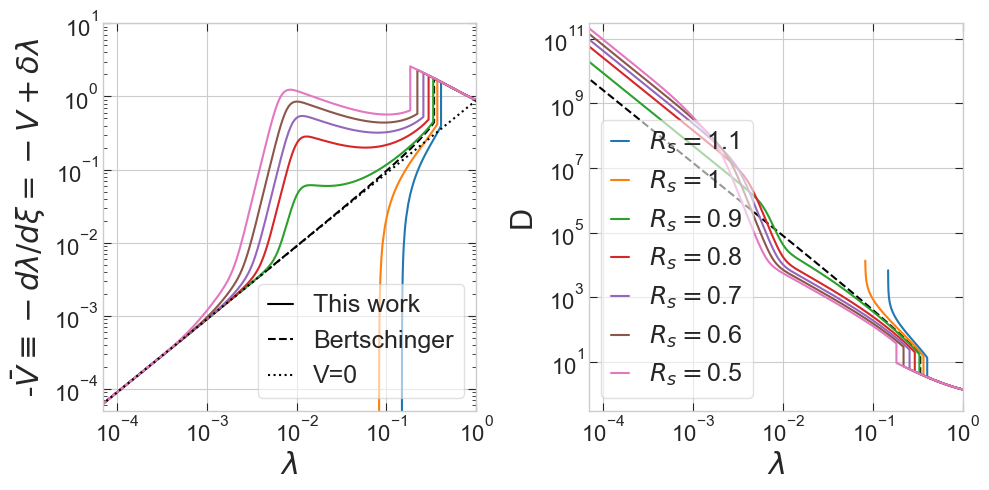

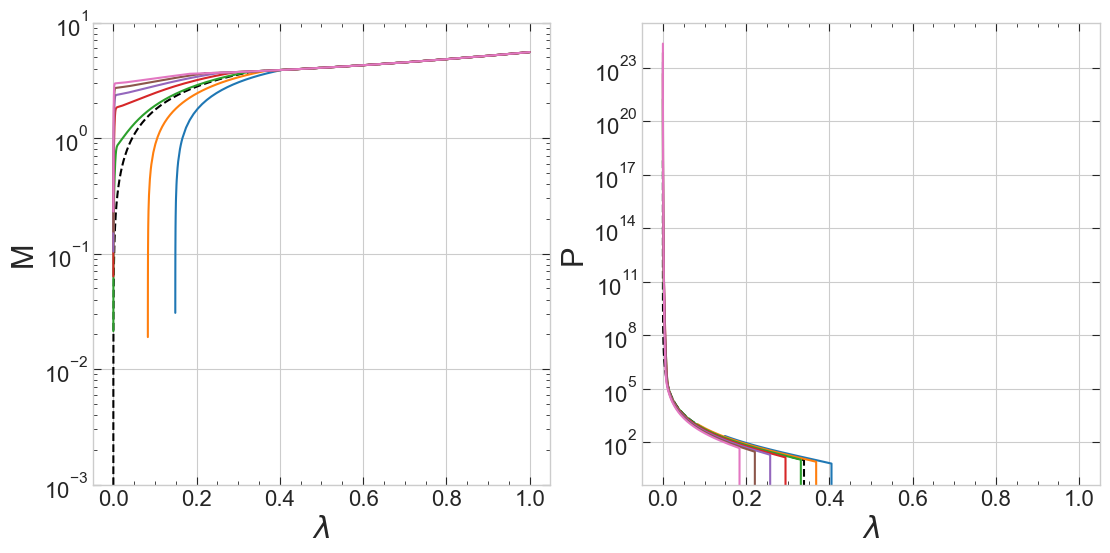

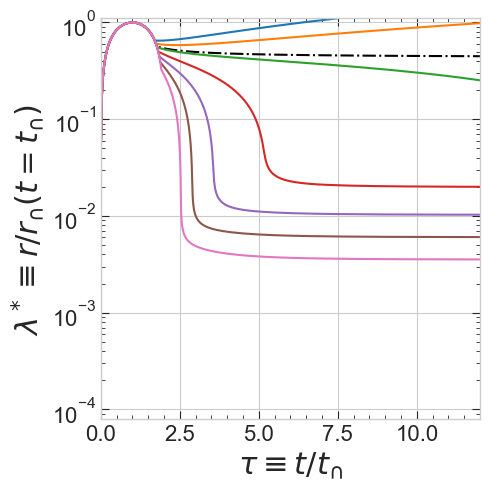

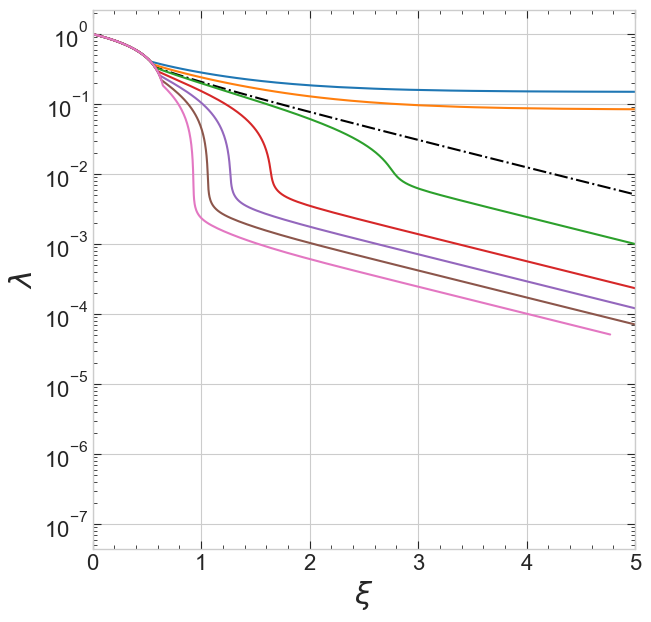

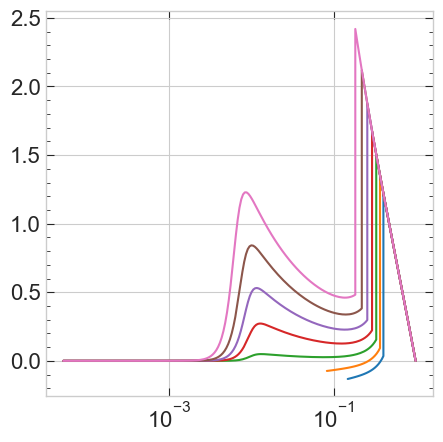

In [11]:
name = 'cold_vary-s'
name = 'shocked_vary-s'
# name = 'shocked_vary-gam'
# name = 'shocked_vary-cooling'
# name = 'shocked_vary-lamdish'
name = 'shocked_vary-lamshsp'

with open(f'{name}-rads.txt', 'tr') as file: rads_list = np.array(eval(file.read()))

s = 1
gam = 5/3
Lam0 = 3e-5
nu=1/2
fb = 0.156837
# fb = 0.5
fd = (1-fb)

lamshsp = 0.9
disk_rad_by_shock = 0.05
lamdish = disk_rad_by_shock #*lamsh

varypars=[]

if name == 'cold_vary-s':
    s_vals = [0.5,1,1.5,2,3,]
    varypars += ['s']
    lamshsp = 0.1
    lamdish = 0.5

if name == 'shocked_vary-s':
    s_vals = [0.5,1,2,]#[:-1]
    varypars += ['s']
    rads_list = rads_list[[0,1,3]]

if name == 'shocked_vary-gam':
    gam_vals= [2,1.8,5/3,1.5,7/5,4/3,]
    lamshsp_vals = [1.2,1.05,0.9,0.7,0.5,0.3]
    varypars += ['gam','lamshsp']

if name == 'shocked_vary-cooling':
    Lam0_vals = [1e-3,3e-3,1e-2,3e-2,1e-1,3e-1]
    varypars += ['Lam0']

if name == 'shocked_vary-lamdish':
    lamdish_vals = [percent/100 for percent in [2,5,10,15,25]]
    varypars += ['lamdish']

if name == 'shocked_vary-lamshsp':
    lamshsp_vals = [1.1,1,.9,.8,.7,.6,.5]#[0.35,0.3,0.25, 0.2]
    varypars += ['lamshsp']


fig5, axs5 = plt.subplots(1,2, dpi=100, figsize=(10,5), sharex=True)
fig51, axs51 = plt.subplots(1,2, dpi=100, figsize=(13,6), sharex=True)
axs5 = np.vstack([axs5,axs51])
fig6, ax6 = plt.subplots(1, dpi=100, figsize=(5,5))
fig62, ax62 = plt.subplots(1, dpi=100, figsize=(7,7))
fig7, ax7 = plt.subplots(1, dpi=100, figsize=(5,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(20):
    plab=''
    try:
        if 'gam' in varypars: gam = gam_vals[i]; plab+=r'$\gamma=$'+f"{gam:.3g}"
        if 's' in varypars: s = s_vals[i]; plab+=f"s={s} "
        if 'lamshsp' in varypars: lamshsp = lamshsp_vals[i]
        if 'lamshsp' in varypars[:1]: plab+=r'$R_s=$'+f'{lamshsp:g}'#plab+=r'$\lambda_s=$'+f'{lamshsp*100:g} '+r'$\%~ \lambda_{sp}$'
        if 'lamdish' in varypars: lamdish = lamdish_vals[i]; plab+=r'$\lambda_d=$'+f'{lamdish*100:g} '+r'$\%~ \lambda_s$'
        if 'Lam0' in varypars: Lam0 = Lam0_vals[i]; plab+=r'$\Lambda_0=$'+f'{Lam0:g} '
        # if 'nu' in varypars: nu = nu_vals[i]; plab+=r'$\nu=$'+f'{nu} '
    except IndexError: break

    t_now = time()
    de = 2* (1+s/3) /3
    alpha_D = -9/(s+3)
    descr = f'_{name}_lamshsp={lamshsp:.3g}_s={s:.2g}_gam={gam:.3g}_lamdish={lamdish:.3g}_Lam0={Lam0:.1e}_nu={nu:.1g}'

    resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm{descr}.hdf5', key=f'gas/iter0', mode='r')
    # lamsh = resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()]
    lamsh = lamshsp*rads_list[i][2] #rads_list[i][1]  #
    lamdi = lamdish*lamsh
    
    # lamshsol = 0.35 #lamsh_sols[s] #+5e-3 # 0.338976 #
    res_pre, res_post = get_soln_gas_full(lamsh)
    print(res_post.y[2][-1])
    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock profiles obtained')

    lamsh_pre = res_pre.t
    V_pre, D_pre, M_pre = res_pre.y

    lamsh_post = np.exp(res_post.t)
    mVb_post, D_post, M_post, P_post = np.exp(res_post.y)
    V_post = de*lamsh_post - mVb_post
    P_pre = lamsh_pre*0

    lamsh = lamsh_pre.min()
    # lam_all = lamsh_pre
    # V_all = V_pre
    # D_all = D_pre
    # M_all = M_pre
    # P_all = P_pre

    lam_all = np.concatenate([lamsh_post, lamsh_pre][::-1])
    V_all = np.concatenate([V_post, V_pre][::-1])
    D_all = np.concatenate([D_post, D_pre][::-1])
    M_all = np.concatenate([M_post, M_pre][::-1])
    P_all = np.concatenate([P_post, P_pre][::-1])
    Vb_all = V_all - de*lam_all

    color_this = colors[i] #plt.cm.turbo(s/4)

    ax7.plot(lam_all,-V_all, color=color_this)
    ax7.set_xscale('log')

    axs5[0,0].plot(lam_all,-Vb_all, color=color_this)
    axs5[0,1].plot(lam_all,D_all, color=color_this, label=plab)
    axs5[1,0].plot(lam_all,M_all, color=color_this)
    axs5[1,1].plot(lam_all,P_all, color=color_this)
    # axs5[0,2].plot(lam_all, P_all/D_all, color=color_this)
    # axs5[1,2].plot(lam_all, P_all/D_all**gam, color=color_this)
    # axs5[1,2].plot(lam_all, D_all*Vb_all**2-gam*P_all, color=color_this)

    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm_shocked_vary-s_lamshsp=0.9_s={s:.2g}_gam={gam:.3g}_lamdish=0.05_Lam0=3.0e-02_nu=0.5.hdf5', key=f'gas/main', mode='r')
    bertshi_vary = True if name.split('-')[-1] in ['gam','s'] else False
    color_this_bertshi = color_this if bertshi_vary else 'k'
    if bertshi_vary or i==0:
        axs5[0,0].plot(resdf_prof_gaso_bertshi.l, -resdf_prof_gaso_bertshi.Vb, color=color_this_bertshi, ls='--')
        axs5[0,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.D, color=color_this_bertshi, ls='--')
        axs5[1,0].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.M, color=color_this_bertshi, ls='--')
        axs5[1,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.P, color=color_this_bertshi, ls='--')
        print(resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()])
    # PderD_post = np.gradient(P_post,lamsh_post)/D_post

    M_intrp = interp1d(lam_all, M_all, fill_value="extrapolate")
    D_intrp = interp1d(lam_all, D_all, fill_value="extrapolate")
    V_intrp = interp1d(lam_all, V_all, fill_value="extrapolate")
    irem = P_pre.shape[0]-1
    # PderD_intrp = interp1d(np.delete(lam_all,irem), np.delete(PderD_all,irem), kind='linear', fill_value="extrapolate")

    # PderD_intrp = interp1d(lamsh_post, PderD_post, kind='linear', fill_value=0, bounds_error=False)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: all profiles obtained')

    def odefunc_traj(xi, arg):
        lam = arg
        return V_intrp(lam)-de*lam

    # taush = (thtshsol - np.sin(thtshsol)) / np.pi
    # xish = np.log(taush)
    # res = solve_ivp(odefunc_traj, (0,5), (1,), method='Radau', max_step=0.01, dense_output=False, vectorized=True)
    # res1 = solve_ivp(fun, (res.t[-1],15), np.array([res.y[0][-1],-res.y[1][-1]]), max_step=0.1, dense_output=True)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock trajectory obtained')
    
    # xires = res.t
    # lamres = res.y[0]
    # vres = res.y[1]
    xires,lamres = cumtrapz(1/(V_all-de*lam_all), x=lam_all), lam_all[1:]

    taures = np.exp(xires)
    lamFres = lamres*taures**de

    ax6.plot(taures,lamFres, color=color_this, label=plab)
    ax62.plot(xires,lamres, color=color_this)
    xio,lamo = cumtrapz(1/(resdf_prof_gaso_bertshi.V-de*resdf_prof_gaso_bertshi.l), x=resdf_prof_gaso_bertshi.l), resdf_prof_gaso_bertshi.l[1:]
    tauo = np.exp(xio)
    lamFo = lamo*tauo**de
    if bertshi_vary or i==0:
        ax62.plot(xio,lamo, c=color_this_bertshi, ls='-.')
        ax6.plot(tauo,lamFo, color=color_this_bertshi, ls='-.')

    #trajectory analytical
    thet_range = np.linspace(0.5, 1.2*np.pi,2000)
    tau_anlt = (thet_range - np.sin(thet_range)) / np.pi
    xi_anlt = np.log(tau_anlt)
    lam_anlt = preshock(thet_range)[0]
    lamF_anlt = lam_anlt*tau_anlt**de

    # ax6.plot(xi_anlt, lam_anlt, color=color_this)
    ax6.plot(tau_anlt, lamF_anlt, color=color_this)
    
    # dmo_prfl = pd.read_hdf(f'profiles_dmo_{s}.hdf5')

    # Mta = (3*np.pi/4)**2
    # M_dmo = interp1d(dmo_prfl['l'], dmo_prfl['M']*Mta, fill_value="extrapolate")
    # D_dmo = interp1d(dmo_prfl['l'].iloc[1:], dmo_prfl['rho'].iloc[1:], fill_value="extrapolate")

    # axs5[1,0].plot(lam_all, M_dmo(lam_all), color=color_this, ls='dashed')
    if name.split('_')[-1] =='vary-s':
        axs5[0,0].plot(lam_all,de*lam_all, c=color_this, ls=':')

#Loop ends

axs5[0,0].plot([],[], c='k', ls='-', label='This work')
axs5[0,0].plot([],[], c='k', ls='--', label='Bertschinger')
if name.split('_')[-1] !='vary-s':
    axs5[0,0].plot(lam_all,de*lam_all, c='k', ls=':', label='V=0')
else:
    axs5[0,0].plot([],[], c='k', ls=':', label='V=0')

# ax6.legend(loc='best',frameon=True, framealpha=0.6)
ax6.set_xlabel(r'$\tau \equiv t/t_{\cap}$')
ax6.set_ylabel(r'$\lambda^*\equiv r/r_{\cap}(t=t_{\cap})$')
ax6.set_xlim(0,12)
ax6.set_ylim(0.00008,1.1)
# ax6.set_xscale('log')
ax6.set_yscale('log')

ax62.set_xlabel(r'$\xi$')
ax62.set_ylabel('$\lambda$')
# ax62.set_xlim(,)
# ax62.set_ylim(0.01,1.1)
ax62.set_yscale('log')
    
axs5[0,0].set_xscale('log')
axs5[0,0].set_xlim(1e-5,1)
if name in ['shocked_vary-s','shocked_vary-lamshsp', 'shocked_vary-gam','cold_vary-s']:
    axs5[0,0].legend(loc='best', frameon=True, framealpha=0.6, handlelength=1)
axs5[0,1].legend(loc='best', frameon=True, framealpha=0.6, handlelength=0.7)
if name=='cold_vary-s':
    axs5[0,1].text(1e-3,1e9,'$R_s=0.1$', fontsize=15)
# axs5[0,1].legend()
axs5[0,0].set_xlabel('$\lambda$')
axs5[0,1].set_xlabel('$\lambda$')
axs5[1,0].set_xlabel('$\lambda$')
axs5[1,1].set_xlabel('$\lambda$')
# axs5[1,2].set_xlabel('$\lambda$')

# if gam==5/3:
#     axs5[0,0].set_xlim(7e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e-1,1e11)
#     axs5[1,0].set_ylim(1e-3,1e1)
#     # axs5[1,1].set_ylim(1e0,1e14)
#     # axs5[0,2].set_ylim(1e-1,1e2)
#     # axs5[1,2].set_ylim(1e-5,5e-1)
# elif gam==4/3:
#     axs5[0,0].set_xlim(1e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e0,1e11)
#     axs5[1,0].set_ylim(1e-2,1e1)
#     axs5[1,1].set_ylim(1e1,1e14)
#     # axs5[0,2].set_ylim(1e0,1e3)
#     # axs5[1,2].set_ylim(1e-2,5e-1)

axs5[0,0].set_xlim(7e-5,1)
axs5[0,0].set_ylim(5e-5,1e1)
axs5[0,1].set_ylim(3e-1,3e11)
axs5[1,0].set_ylim(1e-3,1e1)
# axs5[1,1].set_ylim(1e0,1e14)


axs5[0,0].set_ylabel(r'-$\bar{V} \equiv -d \lambda/d \xi = -V + \delta \lambda$')
axs5[0,1].set_ylabel('D')
axs5[1,0].set_ylabel('M')
axs5[1,1].set_ylabel('P')
# axs5[0,2].set_ylabel('T')
# axs5[1,2].set_ylabel('K')

axs5[0,0].set_yscale('log')
axs5[0,1].set_yscale('log')
axs5[1,0].set_yscale('log')
axs5[1,1].set_yscale('log')
ax62.set_xlim(0,5)
# axs5[0,2].set_yscale('log')
# axs5[1,2].set_yscale('log')

if name in ['shocked_vary-gam','shocked_vary-cooling']:
    axs5[0,0].set_ylabel(r'-$\bar{V}$')
    ax6.set_ylabel(r'$\lambda^*$')
# axs5[0,0].xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10,subs=np.arange(-4, 1)))
# axs5[0,0].xaxis.get_ticklocs(minor=True)
# axs5[0,0].minorticks_on()
# axs5[0,0].xaxis.set_tick_params(which='minor', bottom=True)

# # Additional lines to set major xticks
# axs5[0, 0].xaxis.set_major_locator(mpl.ticker.LogLocator(base=10, subs=np.arange(-4, 1,0.01)))
# axs5[0, 0].xaxis.get_ticklocs()

axs5[0,0].set_xticks([1e-4,1e-3,1e-2,1e-1,1])

fig5.tight_layout()
fig6.tight_layout()

fig5.savefig(f'Eds-gaso_profiles_{name}.pdf')
fig6.savefig(f'Eds-gaso_trajectory_{name}.pdf')
# axs5[0,0].set_xlim(1e-6,1)
# axs5[1,0].set_ylim(1e-4,1e1)

-4.8215362746848545
0.2395s s=1: post shock profiles obtained
0.33897639819093084
0.009101s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-5.646459767280796
0.1178s s=1: post shock profiles obtained
0.01668s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-3.4465142790322973
0.3922s s=1: post shock profiles obtained
0.002993s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-2.4003654080751904
0.2757s s=1: post shock profiles obtained
0.005s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-1.8159467151107633
0.2647s s=1: post shock profiles obtained
0.003019s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-1.3170926987019245
0.2311s s=1: post shock profiles obtained
0.005996s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-0.8118297911144993
0.2237s s=1: post shock profiles obtained
0.01337s s=1: all profiles obtained
0s s=1: post shock trajectory obtained


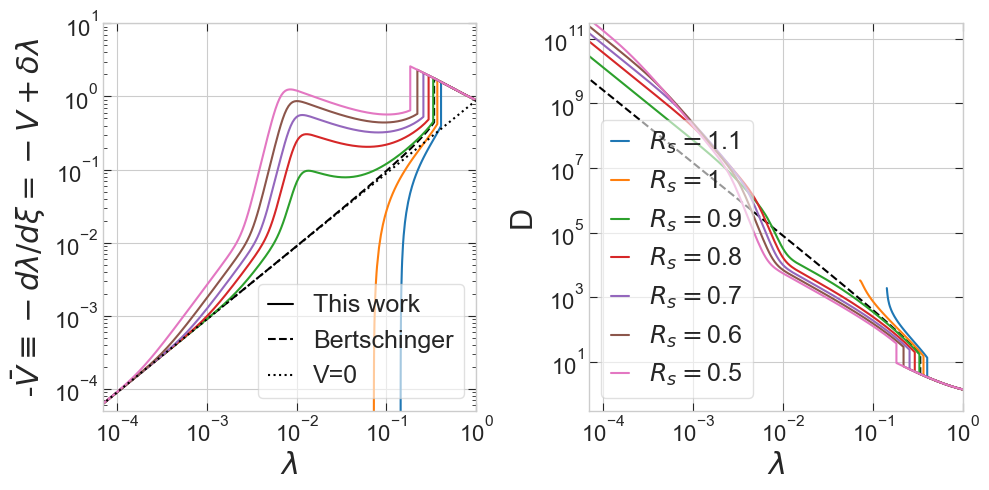

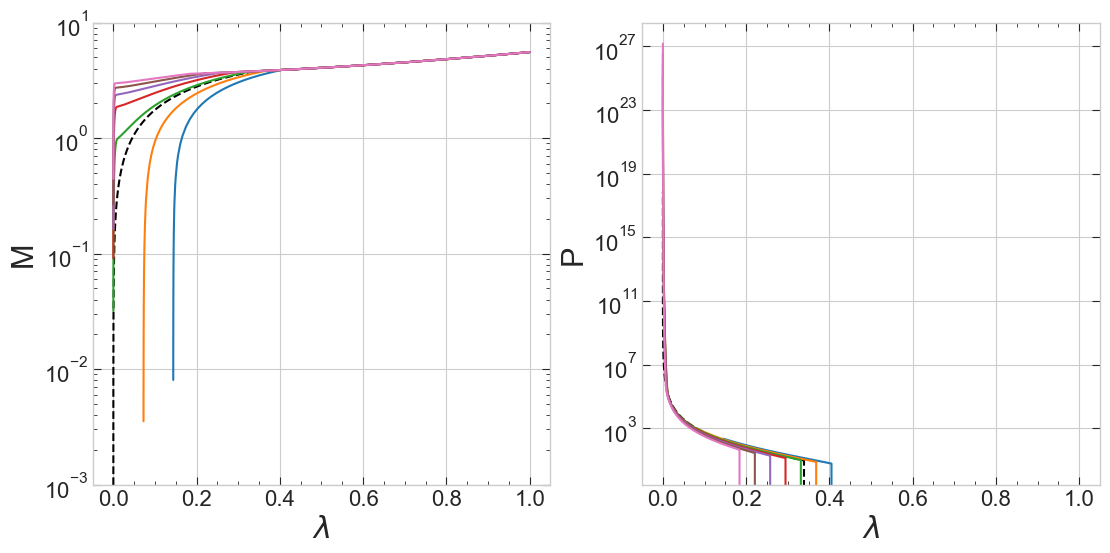

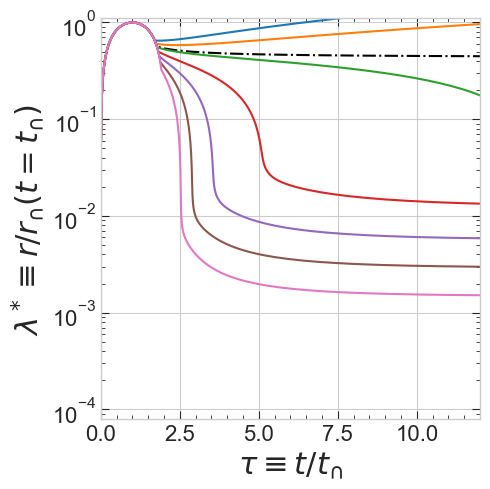

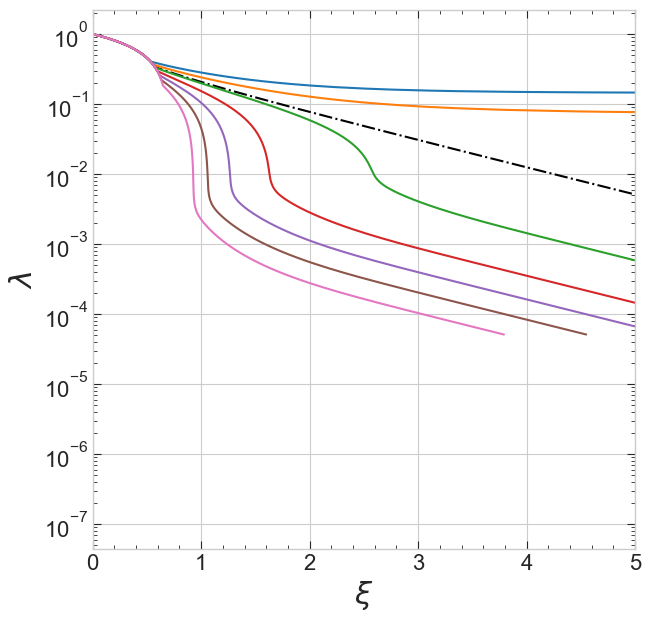

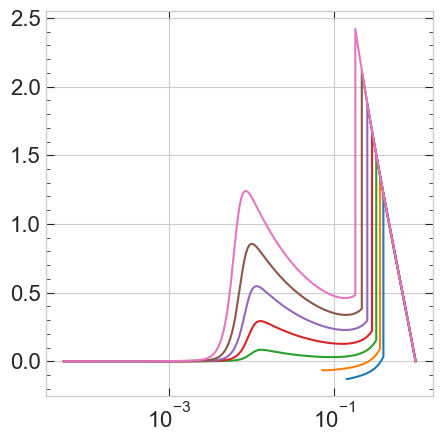

In [12]:
name = 'cold_vary-s'
name = 'shocked_vary-s'
# name = 'shocked_vary-gam'
# name = 'shocked_vary-cooling'
# name = 'shocked_vary-lamdish'
name = 'shocked_vary-lamshsp'

with open(f'{name}-rads.txt', 'tr') as file: rads_list = np.array(eval(file.read()))

s = 1
gam = 5/3
Lam0 = 3e-4
nu=1/2
fb = 0.156837
# fb = 0.5
fd = (1-fb)

lamshsp = 0.9
disk_rad_by_shock = 0.05
lamdish = disk_rad_by_shock #*lamsh

varypars=[]

if name == 'cold_vary-s':
    s_vals = [0.5,1,1.5,2,3,]
    varypars += ['s']
    lamshsp = 0.1
    lamdish = 0.5

if name == 'shocked_vary-s':
    s_vals = [0.5,1,2,]#[:-1]
    varypars += ['s']
    rads_list = rads_list[[0,1,3]]

if name == 'shocked_vary-gam':
    gam_vals= [2,1.8,5/3,1.5,7/5,4/3,]
    lamshsp_vals = [1.2,1.05,0.9,0.7,0.5,0.3]
    varypars += ['gam','lamshsp']

if name == 'shocked_vary-cooling':
    Lam0_vals = [1e-3,3e-3,1e-2,3e-2,1e-1,3e-1]
    varypars += ['Lam0']

if name == 'shocked_vary-lamdish':
    lamdish_vals = [percent/100 for percent in [2,5,10,15,25]]
    varypars += ['lamdish']

if name == 'shocked_vary-lamshsp':
    lamshsp_vals = [1.1,1,.9,.8,.7,.6,.5]#[0.35,0.3,0.25, 0.2]
    varypars += ['lamshsp']


fig5, axs5 = plt.subplots(1,2, dpi=100, figsize=(10,5), sharex=True)
fig51, axs51 = plt.subplots(1,2, dpi=100, figsize=(13,6), sharex=True)
axs5 = np.vstack([axs5,axs51])
fig6, ax6 = plt.subplots(1, dpi=100, figsize=(5,5))
fig62, ax62 = plt.subplots(1, dpi=100, figsize=(7,7))
fig7, ax7 = plt.subplots(1, dpi=100, figsize=(5,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(20):
    plab=''
    try:
        if 'gam' in varypars: gam = gam_vals[i]; plab+=r'$\gamma=$'+f"{gam:.3g}"
        if 's' in varypars: s = s_vals[i]; plab+=f"s={s} "
        if 'lamshsp' in varypars: lamshsp = lamshsp_vals[i]
        if 'lamshsp' in varypars[:1]: plab+=r'$R_s=$'+f'{lamshsp:g}'#plab+=r'$\lambda_s=$'+f'{lamshsp*100:g} '+r'$\%~ \lambda_{sp}$'
        if 'lamdish' in varypars: lamdish = lamdish_vals[i]; plab+=r'$\lambda_d=$'+f'{lamdish*100:g} '+r'$\%~ \lambda_s$'
        if 'Lam0' in varypars: Lam0 = Lam0_vals[i]; plab+=r'$\Lambda_0=$'+f'{Lam0:g} '
        # if 'nu' in varypars: nu = nu_vals[i]; plab+=r'$\nu=$'+f'{nu} '
    except IndexError: break

    t_now = time()
    de = 2* (1+s/3) /3
    alpha_D = -9/(s+3)
    descr = f'_{name}_lamshsp={lamshsp:.3g}_s={s:.2g}_gam={gam:.3g}_lamdish={lamdish:.3g}_Lam0={Lam0:.1e}_nu={nu:.1g}'

    resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm{descr}.hdf5', key=f'gas/iter0', mode='r')
    # lamsh = resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()]
    lamsh = lamshsp*rads_list[i][2] #rads_list[i][1]  #
    lamdi = lamdish*lamsh
    
    # lamshsol = 0.35 #lamsh_sols[s] #+5e-3 # 0.338976 #
    res_pre, res_post = get_soln_gas_full(lamsh)
    print(res_post.y[2][-1])
    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock profiles obtained')

    lamsh_pre = res_pre.t
    V_pre, D_pre, M_pre = res_pre.y

    lamsh_post = np.exp(res_post.t)
    mVb_post, D_post, M_post, P_post = np.exp(res_post.y)
    V_post = de*lamsh_post - mVb_post
    P_pre = lamsh_pre*0

    lamsh = lamsh_pre.min()
    # lam_all = lamsh_pre
    # V_all = V_pre
    # D_all = D_pre
    # M_all = M_pre
    # P_all = P_pre

    lam_all = np.concatenate([lamsh_post, lamsh_pre][::-1])
    V_all = np.concatenate([V_post, V_pre][::-1])
    D_all = np.concatenate([D_post, D_pre][::-1])
    M_all = np.concatenate([M_post, M_pre][::-1])
    P_all = np.concatenate([P_post, P_pre][::-1])
    Vb_all = V_all - de*lam_all

    color_this = colors[i] #plt.cm.turbo(s/4)

    ax7.plot(lam_all,-V_all, color=color_this)
    ax7.set_xscale('log')

    axs5[0,0].plot(lam_all,-Vb_all, color=color_this)
    axs5[0,1].plot(lam_all,D_all, color=color_this, label=plab)
    axs5[1,0].plot(lam_all,M_all, color=color_this)
    axs5[1,1].plot(lam_all,P_all, color=color_this)
    # axs5[0,2].plot(lam_all, P_all/D_all, color=color_this)
    # axs5[1,2].plot(lam_all, P_all/D_all**gam, color=color_this)
    # axs5[1,2].plot(lam_all, D_all*Vb_all**2-gam*P_all, color=color_this)

    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm_shocked_vary-s_lamshsp=0.9_s={s:.2g}_gam={gam:.3g}_lamdish=0.05_Lam0=3.0e-02_nu=0.5.hdf5', key=f'gas/main', mode='r')
    bertshi_vary = True if name.split('-')[-1] in ['gam','s'] else False
    color_this_bertshi = color_this if bertshi_vary else 'k'
    if bertshi_vary or i==0:
        axs5[0,0].plot(resdf_prof_gaso_bertshi.l, -resdf_prof_gaso_bertshi.Vb, color=color_this_bertshi, ls='--')
        axs5[0,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.D, color=color_this_bertshi, ls='--')
        axs5[1,0].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.M, color=color_this_bertshi, ls='--')
        axs5[1,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.P, color=color_this_bertshi, ls='--')
        print(resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()])
    # PderD_post = np.gradient(P_post,lamsh_post)/D_post

    M_intrp = interp1d(lam_all, M_all, fill_value="extrapolate")
    D_intrp = interp1d(lam_all, D_all, fill_value="extrapolate")
    V_intrp = interp1d(lam_all, V_all, fill_value="extrapolate")
    irem = P_pre.shape[0]-1
    # PderD_intrp = interp1d(np.delete(lam_all,irem), np.delete(PderD_all,irem), kind='linear', fill_value="extrapolate")

    # PderD_intrp = interp1d(lamsh_post, PderD_post, kind='linear', fill_value=0, bounds_error=False)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: all profiles obtained')

    def odefunc_traj(xi, arg):
        lam = arg
        return V_intrp(lam)-de*lam

    # taush = (thtshsol - np.sin(thtshsol)) / np.pi
    # xish = np.log(taush)
    # res = solve_ivp(odefunc_traj, (0,5), (1,), method='Radau', max_step=0.01, dense_output=False, vectorized=True)
    # res1 = solve_ivp(fun, (res.t[-1],15), np.array([res.y[0][-1],-res.y[1][-1]]), max_step=0.1, dense_output=True)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock trajectory obtained')
    
    # xires = res.t
    # lamres = res.y[0]
    # vres = res.y[1]
    xires,lamres = cumtrapz(1/(V_all-de*lam_all), x=lam_all), lam_all[1:]

    taures = np.exp(xires)
    lamFres = lamres*taures**de

    ax6.plot(taures,lamFres, color=color_this, label=plab)
    ax62.plot(xires,lamres, color=color_this)
    xio,lamo = cumtrapz(1/(resdf_prof_gaso_bertshi.V-de*resdf_prof_gaso_bertshi.l), x=resdf_prof_gaso_bertshi.l), resdf_prof_gaso_bertshi.l[1:]
    tauo = np.exp(xio)
    lamFo = lamo*tauo**de
    if bertshi_vary or i==0:
        ax62.plot(xio,lamo, c=color_this_bertshi, ls='-.')
        ax6.plot(tauo,lamFo, color=color_this_bertshi, ls='-.')

    #trajectory analytical
    thet_range = np.linspace(0.5, 1.2*np.pi,2000)
    tau_anlt = (thet_range - np.sin(thet_range)) / np.pi
    xi_anlt = np.log(tau_anlt)
    lam_anlt = preshock(thet_range)[0]
    lamF_anlt = lam_anlt*tau_anlt**de

    # ax6.plot(xi_anlt, lam_anlt, color=color_this)
    ax6.plot(tau_anlt, lamF_anlt, color=color_this)
    
    # dmo_prfl = pd.read_hdf(f'profiles_dmo_{s}.hdf5')

    # Mta = (3*np.pi/4)**2
    # M_dmo = interp1d(dmo_prfl['l'], dmo_prfl['M']*Mta, fill_value="extrapolate")
    # D_dmo = interp1d(dmo_prfl['l'].iloc[1:], dmo_prfl['rho'].iloc[1:], fill_value="extrapolate")

    # axs5[1,0].plot(lam_all, M_dmo(lam_all), color=color_this, ls='dashed')
    if name.split('_')[-1] =='vary-s':
        axs5[0,0].plot(lam_all,de*lam_all, c=color_this, ls=':')

#Loop ends

axs5[0,0].plot([],[], c='k', ls='-', label='This work')
axs5[0,0].plot([],[], c='k', ls='--', label='Bertschinger')
if name.split('_')[-1] !='vary-s':
    axs5[0,0].plot(lam_all,de*lam_all, c='k', ls=':', label='V=0')
else:
    axs5[0,0].plot([],[], c='k', ls=':', label='V=0')

# ax6.legend(loc='best',frameon=True, framealpha=0.6)
ax6.set_xlabel(r'$\tau \equiv t/t_{\cap}$')
ax6.set_ylabel(r'$\lambda^*\equiv r/r_{\cap}(t=t_{\cap})$')
ax6.set_xlim(0,12)
ax6.set_ylim(0.00008,1.1)
# ax6.set_xscale('log')
ax6.set_yscale('log')

ax62.set_xlabel(r'$\xi$')
ax62.set_ylabel('$\lambda$')
# ax62.set_xlim(,)
# ax62.set_ylim(0.01,1.1)
ax62.set_yscale('log')
    
axs5[0,0].set_xscale('log')
axs5[0,0].set_xlim(1e-5,1)
if name in ['shocked_vary-s','shocked_vary-lamshsp', 'shocked_vary-gam','cold_vary-s']:
    axs5[0,0].legend(loc='best', frameon=True, framealpha=0.6, handlelength=1)
axs5[0,1].legend(loc='best', frameon=True, framealpha=0.6, handlelength=0.7)
if name=='cold_vary-s':
    axs5[0,1].text(1e-3,1e9,'$R_s=0.1$', fontsize=15)
# axs5[0,1].legend()
axs5[0,0].set_xlabel('$\lambda$')
axs5[0,1].set_xlabel('$\lambda$')
axs5[1,0].set_xlabel('$\lambda$')
axs5[1,1].set_xlabel('$\lambda$')
# axs5[1,2].set_xlabel('$\lambda$')

# if gam==5/3:
#     axs5[0,0].set_xlim(7e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e-1,1e11)
#     axs5[1,0].set_ylim(1e-3,1e1)
#     # axs5[1,1].set_ylim(1e0,1e14)
#     # axs5[0,2].set_ylim(1e-1,1e2)
#     # axs5[1,2].set_ylim(1e-5,5e-1)
# elif gam==4/3:
#     axs5[0,0].set_xlim(1e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e0,1e11)
#     axs5[1,0].set_ylim(1e-2,1e1)
#     axs5[1,1].set_ylim(1e1,1e14)
#     # axs5[0,2].set_ylim(1e0,1e3)
#     # axs5[1,2].set_ylim(1e-2,5e-1)

axs5[0,0].set_xlim(7e-5,1)
axs5[0,0].set_ylim(5e-5,1e1)
axs5[0,1].set_ylim(3e-1,3e11)
axs5[1,0].set_ylim(1e-3,1e1)
# axs5[1,1].set_ylim(1e0,1e14)


axs5[0,0].set_ylabel(r'-$\bar{V} \equiv -d \lambda/d \xi = -V + \delta \lambda$')
axs5[0,1].set_ylabel('D')
axs5[1,0].set_ylabel('M')
axs5[1,1].set_ylabel('P')
# axs5[0,2].set_ylabel('T')
# axs5[1,2].set_ylabel('K')

axs5[0,0].set_yscale('log')
axs5[0,1].set_yscale('log')
axs5[1,0].set_yscale('log')
axs5[1,1].set_yscale('log')
ax62.set_xlim(0,5)
# axs5[0,2].set_yscale('log')
# axs5[1,2].set_yscale('log')

if name in ['shocked_vary-gam','shocked_vary-cooling']:
    axs5[0,0].set_ylabel(r'-$\bar{V}$')
    ax6.set_ylabel(r'$\lambda^*$')
# axs5[0,0].xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10,subs=np.arange(-4, 1)))
# axs5[0,0].xaxis.get_ticklocs(minor=True)
# axs5[0,0].minorticks_on()
# axs5[0,0].xaxis.set_tick_params(which='minor', bottom=True)

# # Additional lines to set major xticks
# axs5[0, 0].xaxis.set_major_locator(mpl.ticker.LogLocator(base=10, subs=np.arange(-4, 1,0.01)))
# axs5[0, 0].xaxis.get_ticklocs()

axs5[0,0].set_xticks([1e-4,1e-3,1e-2,1e-1,1])

fig5.tight_layout()
fig6.tight_layout()

fig5.savefig(f'Eds-gaso_profiles_{name}.pdf')
fig6.savefig(f'Eds-gaso_trajectory_{name}.pdf')
# axs5[0,0].set_xlim(1e-6,1)
# axs5[1,0].set_ylim(1e-4,1e1)

-7.216119191568087
0.09789s s=1: post shock profiles obtained
0.33897639819093084
0.01402s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-3.6140562709785153
0.2813s s=1: post shock profiles obtained
0.003966s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-2.2643441689769412
0.2556s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-1.5133540252145352
0.2372s s=1: post shock profiles obtained
0.002991s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-0.9334978608652866
0.2287s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-0.4159742334820231
0.2198s s=1: post shock profiles obtained
0.01449s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.03152410291241718
0.2667s s=1: post shock profiles obtained
0.004003s s=1: all profiles obtained
0s s=1: post shock trajectory obtained


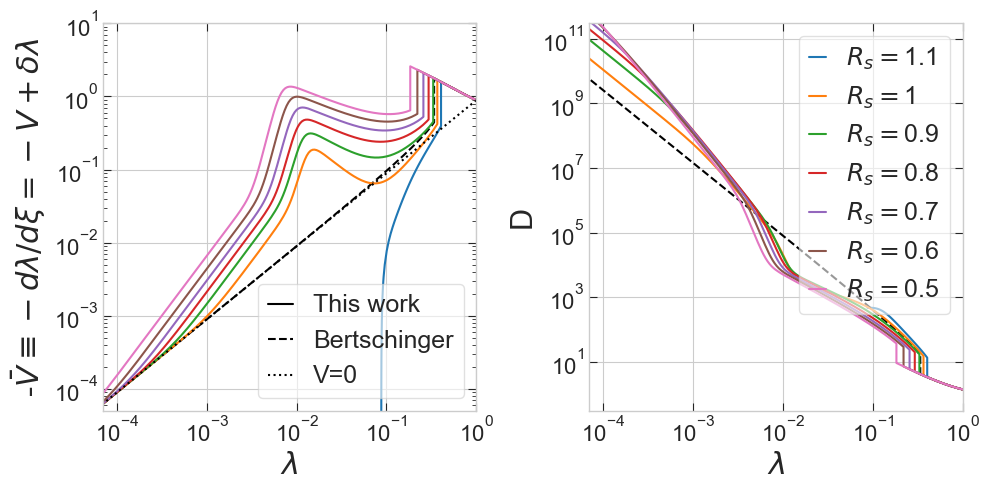

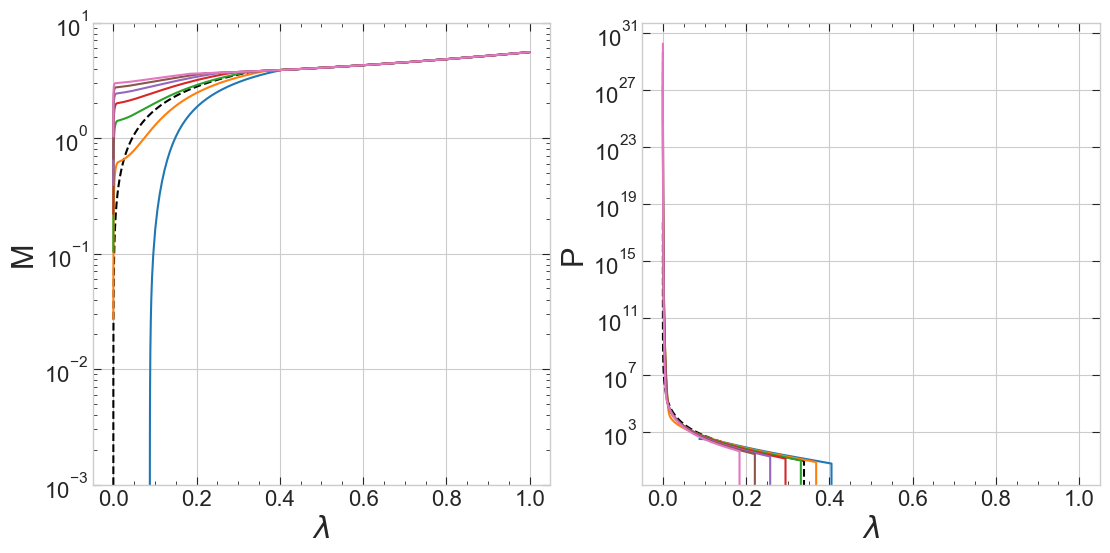

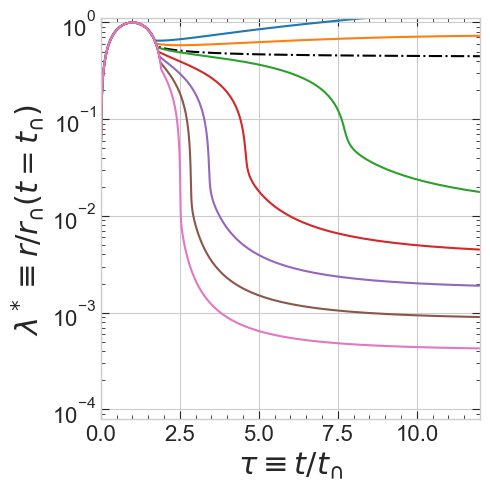

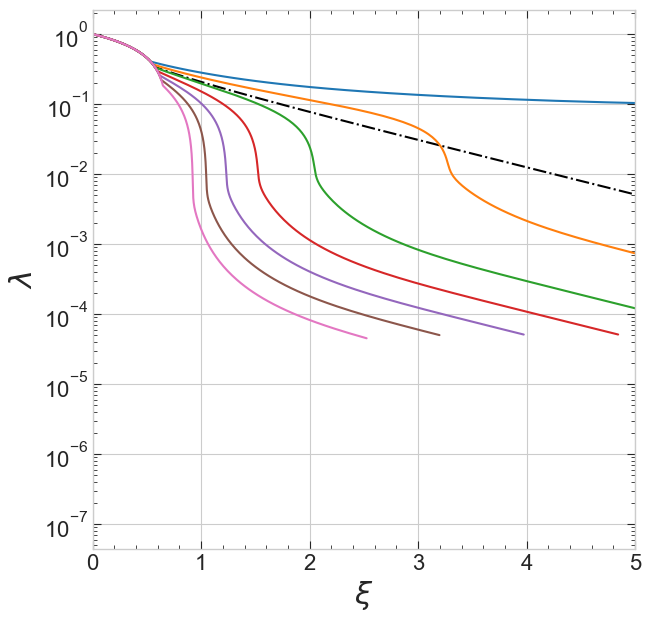

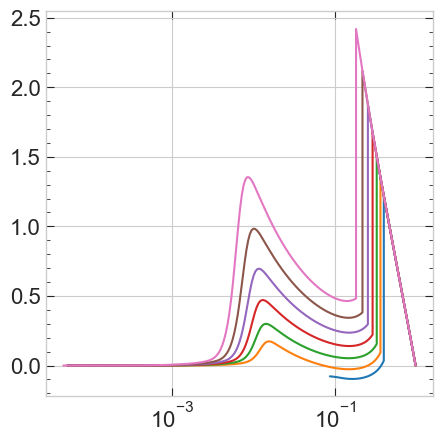

In [13]:
name = 'cold_vary-s'
name = 'shocked_vary-s'
# name = 'shocked_vary-gam'
# name = 'shocked_vary-cooling'
# name = 'shocked_vary-lamdish'
name = 'shocked_vary-lamshsp'

with open(f'{name}-rads.txt', 'tr') as file: rads_list = np.array(eval(file.read()))

s = 1
gam = 5/3
Lam0 = 3e-3
nu=1/2
fb = 0.156837
# fb = 0.5
fd = (1-fb)

lamshsp = 0.9
disk_rad_by_shock = 0.05
lamdish = disk_rad_by_shock #*lamsh

varypars=[]

if name == 'cold_vary-s':
    s_vals = [0.5,1,1.5,2,3,]
    varypars += ['s']
    lamshsp = 0.1
    lamdish = 0.5

if name == 'shocked_vary-s':
    s_vals = [0.5,1,2,]#[:-1]
    varypars += ['s']
    rads_list = rads_list[[0,1,3]]

if name == 'shocked_vary-gam':
    gam_vals= [2,1.8,5/3,1.5,7/5,4/3,]
    lamshsp_vals = [1.2,1.05,0.9,0.7,0.5,0.3]
    varypars += ['gam','lamshsp']

if name == 'shocked_vary-cooling':
    Lam0_vals = [1e-3,3e-3,1e-2,3e-2,1e-1,3e-1]
    varypars += ['Lam0']

if name == 'shocked_vary-lamdish':
    lamdish_vals = [percent/100 for percent in [2,5,10,15,25]]
    varypars += ['lamdish']

if name == 'shocked_vary-lamshsp':
    lamshsp_vals = [1.1,1,.9,.8,.7,.6,.5]#[0.35,0.3,0.25, 0.2]
    varypars += ['lamshsp']


fig5, axs5 = plt.subplots(1,2, dpi=100, figsize=(10,5), sharex=True)
fig51, axs51 = plt.subplots(1,2, dpi=100, figsize=(13,6), sharex=True)
axs5 = np.vstack([axs5,axs51])
fig6, ax6 = plt.subplots(1, dpi=100, figsize=(5,5))
fig62, ax62 = plt.subplots(1, dpi=100, figsize=(7,7))
fig7, ax7 = plt.subplots(1, dpi=100, figsize=(5,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(20):
    plab=''
    try:
        if 'gam' in varypars: gam = gam_vals[i]; plab+=r'$\gamma=$'+f"{gam:.3g}"
        if 's' in varypars: s = s_vals[i]; plab+=f"s={s} "
        if 'lamshsp' in varypars: lamshsp = lamshsp_vals[i]
        if 'lamshsp' in varypars[:1]: plab+=r'$R_s=$'+f'{lamshsp:g}'#plab+=r'$\lambda_s=$'+f'{lamshsp*100:g} '+r'$\%~ \lambda_{sp}$'
        if 'lamdish' in varypars: lamdish = lamdish_vals[i]; plab+=r'$\lambda_d=$'+f'{lamdish*100:g} '+r'$\%~ \lambda_s$'
        if 'Lam0' in varypars: Lam0 = Lam0_vals[i]; plab+=r'$\Lambda_0=$'+f'{Lam0:g} '
        # if 'nu' in varypars: nu = nu_vals[i]; plab+=r'$\nu=$'+f'{nu} '
    except IndexError: break

    t_now = time()
    de = 2* (1+s/3) /3
    alpha_D = -9/(s+3)
    descr = f'_{name}_lamshsp={lamshsp:.3g}_s={s:.2g}_gam={gam:.3g}_lamdish={lamdish:.3g}_Lam0={Lam0:.1e}_nu={nu:.1g}'

    resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm{descr}.hdf5', key=f'gas/iter0', mode='r')
    # lamsh = resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()]
    lamsh = lamshsp*rads_list[i][2] #rads_list[i][1]  #
    lamdi = lamdish*lamsh
    
    # lamshsol = 0.35 #lamsh_sols[s] #+5e-3 # 0.338976 #
    res_pre, res_post = get_soln_gas_full(lamsh)
    print(res_post.y[2][-1])
    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock profiles obtained')

    lamsh_pre = res_pre.t
    V_pre, D_pre, M_pre = res_pre.y

    lamsh_post = np.exp(res_post.t)
    mVb_post, D_post, M_post, P_post = np.exp(res_post.y)
    V_post = de*lamsh_post - mVb_post
    P_pre = lamsh_pre*0

    lamsh = lamsh_pre.min()
    # lam_all = lamsh_pre
    # V_all = V_pre
    # D_all = D_pre
    # M_all = M_pre
    # P_all = P_pre

    lam_all = np.concatenate([lamsh_post, lamsh_pre][::-1])
    V_all = np.concatenate([V_post, V_pre][::-1])
    D_all = np.concatenate([D_post, D_pre][::-1])
    M_all = np.concatenate([M_post, M_pre][::-1])
    P_all = np.concatenate([P_post, P_pre][::-1])
    Vb_all = V_all - de*lam_all

    color_this = colors[i] #plt.cm.turbo(s/4)

    ax7.plot(lam_all,-V_all, color=color_this)
    ax7.set_xscale('log')

    axs5[0,0].plot(lam_all,-Vb_all, color=color_this)
    axs5[0,1].plot(lam_all,D_all, color=color_this, label=plab)
    axs5[1,0].plot(lam_all,M_all, color=color_this)
    axs5[1,1].plot(lam_all,P_all, color=color_this)
    # axs5[0,2].plot(lam_all, P_all/D_all, color=color_this)
    # axs5[1,2].plot(lam_all, P_all/D_all**gam, color=color_this)
    # axs5[1,2].plot(lam_all, D_all*Vb_all**2-gam*P_all, color=color_this)

    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm_shocked_vary-s_lamshsp=0.9_s={s:.2g}_gam={gam:.3g}_lamdish=0.05_Lam0=3.0e-02_nu=0.5.hdf5', key=f'gas/main', mode='r')
    bertshi_vary = True if name.split('-')[-1] in ['gam','s'] else False
    color_this_bertshi = color_this if bertshi_vary else 'k'
    if bertshi_vary or i==0:
        axs5[0,0].plot(resdf_prof_gaso_bertshi.l, -resdf_prof_gaso_bertshi.Vb, color=color_this_bertshi, ls='--')
        axs5[0,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.D, color=color_this_bertshi, ls='--')
        axs5[1,0].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.M, color=color_this_bertshi, ls='--')
        axs5[1,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.P, color=color_this_bertshi, ls='--')
        print(resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()])
    # PderD_post = np.gradient(P_post,lamsh_post)/D_post

    M_intrp = interp1d(lam_all, M_all, fill_value="extrapolate")
    D_intrp = interp1d(lam_all, D_all, fill_value="extrapolate")
    V_intrp = interp1d(lam_all, V_all, fill_value="extrapolate")
    irem = P_pre.shape[0]-1
    # PderD_intrp = interp1d(np.delete(lam_all,irem), np.delete(PderD_all,irem), kind='linear', fill_value="extrapolate")

    # PderD_intrp = interp1d(lamsh_post, PderD_post, kind='linear', fill_value=0, bounds_error=False)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: all profiles obtained')

    def odefunc_traj(xi, arg):
        lam = arg
        return V_intrp(lam)-de*lam

    # taush = (thtshsol - np.sin(thtshsol)) / np.pi
    # xish = np.log(taush)
    # res = solve_ivp(odefunc_traj, (0,5), (1,), method='Radau', max_step=0.01, dense_output=False, vectorized=True)
    # res1 = solve_ivp(fun, (res.t[-1],15), np.array([res.y[0][-1],-res.y[1][-1]]), max_step=0.1, dense_output=True)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock trajectory obtained')
    
    # xires = res.t
    # lamres = res.y[0]
    # vres = res.y[1]
    xires,lamres = cumtrapz(1/(V_all-de*lam_all), x=lam_all), lam_all[1:]

    taures = np.exp(xires)
    lamFres = lamres*taures**de

    ax6.plot(taures,lamFres, color=color_this, label=plab)
    ax62.plot(xires,lamres, color=color_this)
    xio,lamo = cumtrapz(1/(resdf_prof_gaso_bertshi.V-de*resdf_prof_gaso_bertshi.l), x=resdf_prof_gaso_bertshi.l), resdf_prof_gaso_bertshi.l[1:]
    tauo = np.exp(xio)
    lamFo = lamo*tauo**de
    if bertshi_vary or i==0:
        ax62.plot(xio,lamo, c=color_this_bertshi, ls='-.')
        ax6.plot(tauo,lamFo, color=color_this_bertshi, ls='-.')

    #trajectory analytical
    thet_range = np.linspace(0.5, 1.2*np.pi,2000)
    tau_anlt = (thet_range - np.sin(thet_range)) / np.pi
    xi_anlt = np.log(tau_anlt)
    lam_anlt = preshock(thet_range)[0]
    lamF_anlt = lam_anlt*tau_anlt**de

    # ax6.plot(xi_anlt, lam_anlt, color=color_this)
    ax6.plot(tau_anlt, lamF_anlt, color=color_this)
    
    # dmo_prfl = pd.read_hdf(f'profiles_dmo_{s}.hdf5')

    # Mta = (3*np.pi/4)**2
    # M_dmo = interp1d(dmo_prfl['l'], dmo_prfl['M']*Mta, fill_value="extrapolate")
    # D_dmo = interp1d(dmo_prfl['l'].iloc[1:], dmo_prfl['rho'].iloc[1:], fill_value="extrapolate")

    # axs5[1,0].plot(lam_all, M_dmo(lam_all), color=color_this, ls='dashed')
    if name.split('_')[-1] =='vary-s':
        axs5[0,0].plot(lam_all,de*lam_all, c=color_this, ls=':')

#Loop ends

axs5[0,0].plot([],[], c='k', ls='-', label='This work')
axs5[0,0].plot([],[], c='k', ls='--', label='Bertschinger')
if name.split('_')[-1] !='vary-s':
    axs5[0,0].plot(lam_all,de*lam_all, c='k', ls=':', label='V=0')
else:
    axs5[0,0].plot([],[], c='k', ls=':', label='V=0')

# ax6.legend(loc='best',frameon=True, framealpha=0.6)
ax6.set_xlabel(r'$\tau \equiv t/t_{\cap}$')
ax6.set_ylabel(r'$\lambda^*\equiv r/r_{\cap}(t=t_{\cap})$')
ax6.set_xlim(0,12)
ax6.set_ylim(0.00008,1.1)
# ax6.set_xscale('log')
ax6.set_yscale('log')

ax62.set_xlabel(r'$\xi$')
ax62.set_ylabel('$\lambda$')
# ax62.set_xlim(,)
# ax62.set_ylim(0.01,1.1)
ax62.set_yscale('log')
    
axs5[0,0].set_xscale('log')
axs5[0,0].set_xlim(1e-5,1)
if name in ['shocked_vary-s','shocked_vary-lamshsp', 'shocked_vary-gam','cold_vary-s']:
    axs5[0,0].legend(loc='best', frameon=True, framealpha=0.6, handlelength=1)
axs5[0,1].legend(loc='best', frameon=True, framealpha=0.6, handlelength=0.7)
if name=='cold_vary-s':
    axs5[0,1].text(1e-3,1e9,'$R_s=0.1$', fontsize=15)
# axs5[0,1].legend()
axs5[0,0].set_xlabel('$\lambda$')
axs5[0,1].set_xlabel('$\lambda$')
axs5[1,0].set_xlabel('$\lambda$')
axs5[1,1].set_xlabel('$\lambda$')
# axs5[1,2].set_xlabel('$\lambda$')

# if gam==5/3:
#     axs5[0,0].set_xlim(7e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e-1,1e11)
#     axs5[1,0].set_ylim(1e-3,1e1)
#     # axs5[1,1].set_ylim(1e0,1e14)
#     # axs5[0,2].set_ylim(1e-1,1e2)
#     # axs5[1,2].set_ylim(1e-5,5e-1)
# elif gam==4/3:
#     axs5[0,0].set_xlim(1e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e0,1e11)
#     axs5[1,0].set_ylim(1e-2,1e1)
#     axs5[1,1].set_ylim(1e1,1e14)
#     # axs5[0,2].set_ylim(1e0,1e3)
#     # axs5[1,2].set_ylim(1e-2,5e-1)

axs5[0,0].set_xlim(7e-5,1)
axs5[0,0].set_ylim(5e-5,1e1)
axs5[0,1].set_ylim(3e-1,3e11)
axs5[1,0].set_ylim(1e-3,1e1)
# axs5[1,1].set_ylim(1e0,1e14)


axs5[0,0].set_ylabel(r'-$\bar{V} \equiv -d \lambda/d \xi = -V + \delta \lambda$')
axs5[0,1].set_ylabel('D')
axs5[1,0].set_ylabel('M')
axs5[1,1].set_ylabel('P')
# axs5[0,2].set_ylabel('T')
# axs5[1,2].set_ylabel('K')

axs5[0,0].set_yscale('log')
axs5[0,1].set_yscale('log')
axs5[1,0].set_yscale('log')
axs5[1,1].set_yscale('log')
ax62.set_xlim(0,5)
# axs5[0,2].set_yscale('log')
# axs5[1,2].set_yscale('log')

if name in ['shocked_vary-gam','shocked_vary-cooling']:
    axs5[0,0].set_ylabel(r'-$\bar{V}$')
    ax6.set_ylabel(r'$\lambda^*$')
# axs5[0,0].xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10,subs=np.arange(-4, 1)))
# axs5[0,0].xaxis.get_ticklocs(minor=True)
# axs5[0,0].minorticks_on()
# axs5[0,0].xaxis.set_tick_params(which='minor', bottom=True)

# # Additional lines to set major xticks
# axs5[0, 0].xaxis.set_major_locator(mpl.ticker.LogLocator(base=10, subs=np.arange(-4, 1,0.01)))
# axs5[0, 0].xaxis.get_ticklocs()

axs5[0,0].set_xticks([1e-4,1e-3,1e-2,1e-1,1])

fig5.tight_layout()
fig6.tight_layout()

fig5.savefig(f'Eds-gaso_profiles_{name}.pdf')
fig6.savefig(f'Eds-gaso_trajectory_{name}.pdf')
# axs5[0,0].set_xlim(1e-6,1)
# axs5[1,0].set_ylim(1e-4,1e1)

-5.398321373183293
0.3957s s=1: post shock profiles obtained
0.33897639819093084
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-3.6140562709785153
0.2614s s=1: post shock profiles obtained
0.003s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-2.2643441689769412
0.2996s s=1: post shock profiles obtained
0.001643s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-1.5133540252145352
0.2321s s=1: post shock profiles obtained
0.01666s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-0.9334978608652866
0.2144s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-0.4159742334820231
0.2276s s=1: post shock profiles obtained
0.005155s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.03152410291241718
0.211s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained


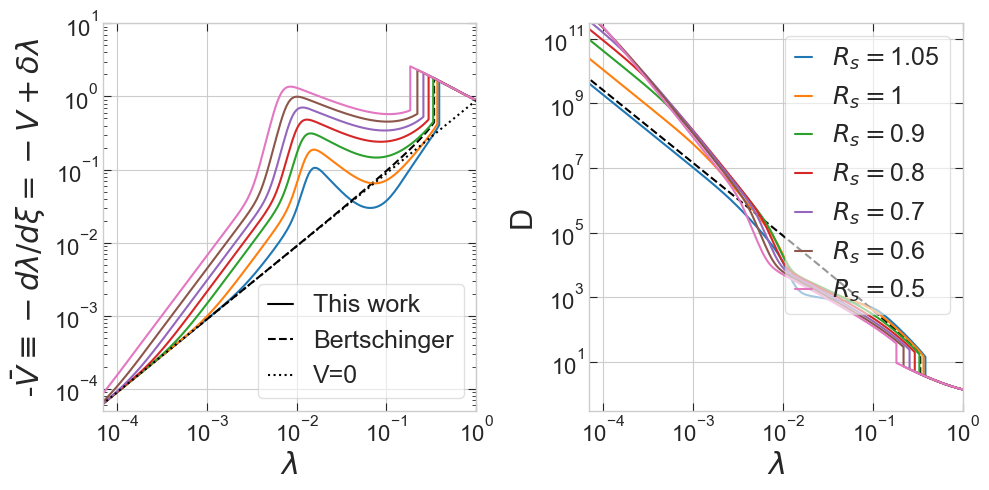

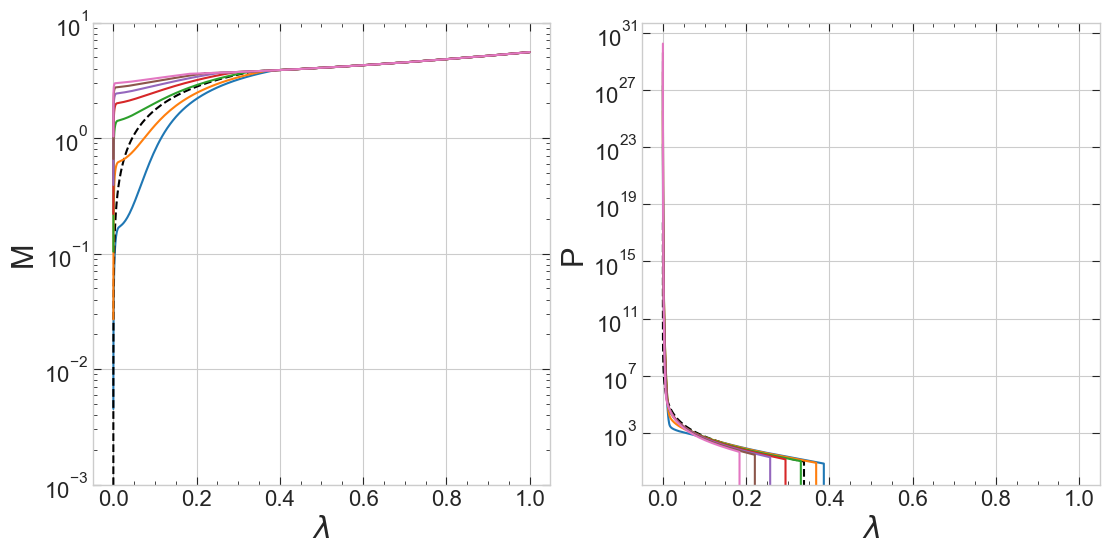

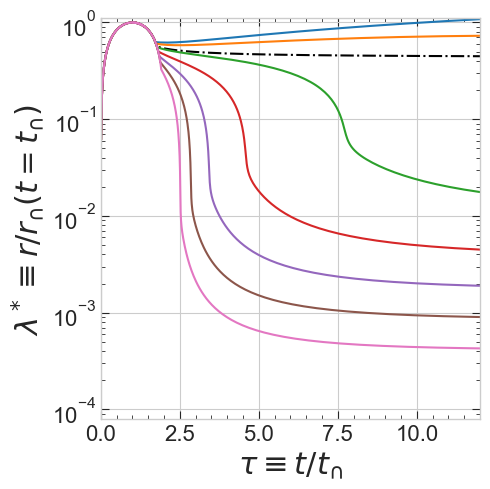

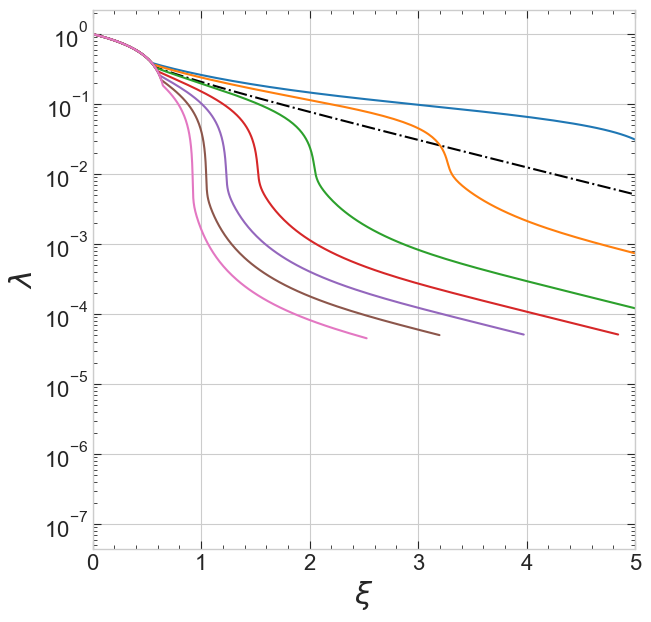

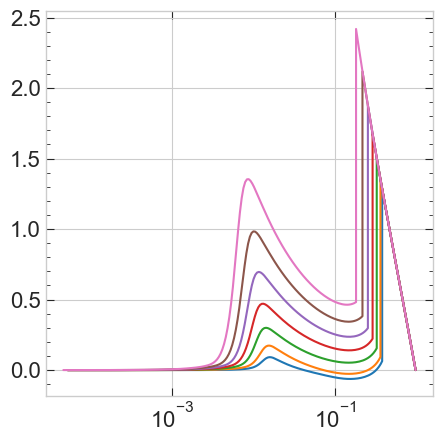

In [14]:
name = 'cold_vary-s'
name = 'shocked_vary-s'
# name = 'shocked_vary-gam'
# name = 'shocked_vary-cooling'
# name = 'shocked_vary-lamdish'
name = 'shocked_vary-lamshsp'

with open(f'{name}-rads.txt', 'tr') as file: rads_list = np.array(eval(file.read()))

s = 1
gam = 5/3
Lam0 = 3e-3
nu=1/2
fb = 0.156837
# fb = 0.5
fd = (1-fb)

lamshsp = 0.9
disk_rad_by_shock = 0.05
lamdish = disk_rad_by_shock #*lamsh

varypars=[]

if name == 'cold_vary-s':
    s_vals = [0.5,1,1.5,2,3,]
    varypars += ['s']
    lamshsp = 0.1
    lamdish = 0.5

if name == 'shocked_vary-s':
    s_vals = [0.5,1,2,]#[:-1]
    varypars += ['s']
    rads_list = rads_list[[0,1,3]]

if name == 'shocked_vary-gam':
    gam_vals= [2,1.8,5/3,1.5,7/5,4/3,]
    lamshsp_vals = [1.2,1.05,0.9,0.7,0.5,0.3]
    varypars += ['gam','lamshsp']

if name == 'shocked_vary-cooling':
    Lam0_vals = [1e-3,3e-3,1e-2,3e-2,1e-1,3e-1]
    varypars += ['Lam0']

if name == 'shocked_vary-lamdish':
    lamdish_vals = [percent/100 for percent in [2,5,10,15,25]]
    varypars += ['lamdish']

if name == 'shocked_vary-lamshsp':
    lamshsp_vals = [1.05,1,.9,.8,.7,.6,.5]#[0.35,0.3,0.25, 0.2]
    varypars += ['lamshsp']


fig5, axs5 = plt.subplots(1,2, dpi=100, figsize=(10,5), sharex=True)
fig51, axs51 = plt.subplots(1,2, dpi=100, figsize=(13,6), sharex=True)
axs5 = np.vstack([axs5,axs51])
fig6, ax6 = plt.subplots(1, dpi=100, figsize=(5,5))
fig62, ax62 = plt.subplots(1, dpi=100, figsize=(7,7))
fig7, ax7 = plt.subplots(1, dpi=100, figsize=(5,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(20):
    plab=''
    try:
        if 'gam' in varypars: gam = gam_vals[i]; plab+=r'$\gamma=$'+f"{gam:.3g}"
        if 's' in varypars: s = s_vals[i]; plab+=f"s={s} "
        if 'lamshsp' in varypars: lamshsp = lamshsp_vals[i]
        if 'lamshsp' in varypars[:1]: plab+=r'$R_s=$'+f'{lamshsp:g}'#plab+=r'$\lambda_s=$'+f'{lamshsp*100:g} '+r'$\%~ \lambda_{sp}$'
        if 'lamdish' in varypars: lamdish = lamdish_vals[i]; plab+=r'$\lambda_d=$'+f'{lamdish*100:g} '+r'$\%~ \lambda_s$'
        if 'Lam0' in varypars: Lam0 = Lam0_vals[i]; plab+=r'$\Lambda_0=$'+f'{Lam0:g} '
        # if 'nu' in varypars: nu = nu_vals[i]; plab+=r'$\nu=$'+f'{nu} '
    except IndexError: break

    t_now = time()
    de = 2* (1+s/3) /3
    alpha_D = -9/(s+3)
    descr = f'_{name}_lamshsp={lamshsp:.3g}_s={s:.2g}_gam={gam:.3g}_lamdish={lamdish:.3g}_Lam0={Lam0:.1e}_nu={nu:.1g}'

    resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm{descr}.hdf5', key=f'gas/iter0', mode='r')
    # lamsh = resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()]
    lamsh = lamshsp*rads_list[i][2] #rads_list[i][1]  #
    lamdi = lamdish*lamsh
    
    # lamshsol = 0.35 #lamsh_sols[s] #+5e-3 # 0.338976 #
    res_pre, res_post = get_soln_gas_full(lamsh)
    print(res_post.y[2][-1])
    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock profiles obtained')

    lamsh_pre = res_pre.t
    V_pre, D_pre, M_pre = res_pre.y

    lamsh_post = np.exp(res_post.t)
    mVb_post, D_post, M_post, P_post = np.exp(res_post.y)
    V_post = de*lamsh_post - mVb_post
    P_pre = lamsh_pre*0

    lamsh = lamsh_pre.min()
    # lam_all = lamsh_pre
    # V_all = V_pre
    # D_all = D_pre
    # M_all = M_pre
    # P_all = P_pre

    lam_all = np.concatenate([lamsh_post, lamsh_pre][::-1])
    V_all = np.concatenate([V_post, V_pre][::-1])
    D_all = np.concatenate([D_post, D_pre][::-1])
    M_all = np.concatenate([M_post, M_pre][::-1])
    P_all = np.concatenate([P_post, P_pre][::-1])
    Vb_all = V_all - de*lam_all

    color_this = colors[i] #plt.cm.turbo(s/4)

    ax7.plot(lam_all,-V_all, color=color_this)
    ax7.set_xscale('log')

    axs5[0,0].plot(lam_all,-Vb_all, color=color_this)
    axs5[0,1].plot(lam_all,D_all, color=color_this, label=plab)
    axs5[1,0].plot(lam_all,M_all, color=color_this)
    axs5[1,1].plot(lam_all,P_all, color=color_this)
    # axs5[0,2].plot(lam_all, P_all/D_all, color=color_this)
    # axs5[1,2].plot(lam_all, P_all/D_all**gam, color=color_this)
    # axs5[1,2].plot(lam_all, D_all*Vb_all**2-gam*P_all, color=color_this)

    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm_shocked_vary-s_lamshsp=0.9_s={s:.2g}_gam={gam:.3g}_lamdish=0.05_Lam0=3.0e-02_nu=0.5.hdf5', key=f'gas/main', mode='r')
    bertshi_vary = True if name.split('-')[-1] in ['gam','s'] else False
    color_this_bertshi = color_this if bertshi_vary else 'k'
    if bertshi_vary or i==0:
        axs5[0,0].plot(resdf_prof_gaso_bertshi.l, -resdf_prof_gaso_bertshi.Vb, color=color_this_bertshi, ls='--')
        axs5[0,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.D, color=color_this_bertshi, ls='--')
        axs5[1,0].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.M, color=color_this_bertshi, ls='--')
        axs5[1,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.P, color=color_this_bertshi, ls='--')
        print(resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()])
    # PderD_post = np.gradient(P_post,lamsh_post)/D_post

    M_intrp = interp1d(lam_all, M_all, fill_value="extrapolate")
    D_intrp = interp1d(lam_all, D_all, fill_value="extrapolate")
    V_intrp = interp1d(lam_all, V_all, fill_value="extrapolate")
    irem = P_pre.shape[0]-1
    # PderD_intrp = interp1d(np.delete(lam_all,irem), np.delete(PderD_all,irem), kind='linear', fill_value="extrapolate")

    # PderD_intrp = interp1d(lamsh_post, PderD_post, kind='linear', fill_value=0, bounds_error=False)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: all profiles obtained')

    def odefunc_traj(xi, arg):
        lam = arg
        return V_intrp(lam)-de*lam

    # taush = (thtshsol - np.sin(thtshsol)) / np.pi
    # xish = np.log(taush)
    # res = solve_ivp(odefunc_traj, (0,5), (1,), method='Radau', max_step=0.01, dense_output=False, vectorized=True)
    # res1 = solve_ivp(fun, (res.t[-1],15), np.array([res.y[0][-1],-res.y[1][-1]]), max_step=0.1, dense_output=True)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock trajectory obtained')
    
    # xires = res.t
    # lamres = res.y[0]
    # vres = res.y[1]
    xires,lamres = cumtrapz(1/(V_all-de*lam_all), x=lam_all), lam_all[1:]

    taures = np.exp(xires)
    lamFres = lamres*taures**de

    ax6.plot(taures,lamFres, color=color_this, label=plab)
    ax62.plot(xires,lamres, color=color_this)
    xio,lamo = cumtrapz(1/(resdf_prof_gaso_bertshi.V-de*resdf_prof_gaso_bertshi.l), x=resdf_prof_gaso_bertshi.l), resdf_prof_gaso_bertshi.l[1:]
    tauo = np.exp(xio)
    lamFo = lamo*tauo**de
    if bertshi_vary or i==0:
        ax62.plot(xio,lamo, c=color_this_bertshi, ls='-.')
        ax6.plot(tauo,lamFo, color=color_this_bertshi, ls='-.')

    #trajectory analytical
    thet_range = np.linspace(0.5, 1.2*np.pi,2000)
    tau_anlt = (thet_range - np.sin(thet_range)) / np.pi
    xi_anlt = np.log(tau_anlt)
    lam_anlt = preshock(thet_range)[0]
    lamF_anlt = lam_anlt*tau_anlt**de

    # ax6.plot(xi_anlt, lam_anlt, color=color_this)
    ax6.plot(tau_anlt, lamF_anlt, color=color_this)
    
    # dmo_prfl = pd.read_hdf(f'profiles_dmo_{s}.hdf5')

    # Mta = (3*np.pi/4)**2
    # M_dmo = interp1d(dmo_prfl['l'], dmo_prfl['M']*Mta, fill_value="extrapolate")
    # D_dmo = interp1d(dmo_prfl['l'].iloc[1:], dmo_prfl['rho'].iloc[1:], fill_value="extrapolate")

    # axs5[1,0].plot(lam_all, M_dmo(lam_all), color=color_this, ls='dashed')
    if name.split('_')[-1] =='vary-s':
        axs5[0,0].plot(lam_all,de*lam_all, c=color_this, ls=':')

#Loop ends

axs5[0,0].plot([],[], c='k', ls='-', label='This work')
axs5[0,0].plot([],[], c='k', ls='--', label='Bertschinger')
if name.split('_')[-1] !='vary-s':
    axs5[0,0].plot(lam_all,de*lam_all, c='k', ls=':', label='V=0')
else:
    axs5[0,0].plot([],[], c='k', ls=':', label='V=0')

# ax6.legend(loc='best',frameon=True, framealpha=0.6)
ax6.set_xlabel(r'$\tau \equiv t/t_{\cap}$')
ax6.set_ylabel(r'$\lambda^*\equiv r/r_{\cap}(t=t_{\cap})$')
ax6.set_xlim(0,12)
ax6.set_ylim(0.00008,1.1)
# ax6.set_xscale('log')
ax6.set_yscale('log')

ax62.set_xlabel(r'$\xi$')
ax62.set_ylabel('$\lambda$')
# ax62.set_xlim(,)
# ax62.set_ylim(0.01,1.1)
ax62.set_yscale('log')
    
axs5[0,0].set_xscale('log')
axs5[0,0].set_xlim(1e-5,1)
if name in ['shocked_vary-s','shocked_vary-lamshsp', 'shocked_vary-gam','cold_vary-s']:
    axs5[0,0].legend(loc='best', frameon=True, framealpha=0.6, handlelength=1)
axs5[0,1].legend(loc='best', frameon=True, framealpha=0.6, handlelength=0.7)
if name=='cold_vary-s':
    axs5[0,1].text(1e-3,1e9,'$R_s=0.1$', fontsize=15)
# axs5[0,1].legend()
axs5[0,0].set_xlabel('$\lambda$')
axs5[0,1].set_xlabel('$\lambda$')
axs5[1,0].set_xlabel('$\lambda$')
axs5[1,1].set_xlabel('$\lambda$')
# axs5[1,2].set_xlabel('$\lambda$')

# if gam==5/3:
#     axs5[0,0].set_xlim(7e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e-1,1e11)
#     axs5[1,0].set_ylim(1e-3,1e1)
#     # axs5[1,1].set_ylim(1e0,1e14)
#     # axs5[0,2].set_ylim(1e-1,1e2)
#     # axs5[1,2].set_ylim(1e-5,5e-1)
# elif gam==4/3:
#     axs5[0,0].set_xlim(1e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e0,1e11)
#     axs5[1,0].set_ylim(1e-2,1e1)
#     axs5[1,1].set_ylim(1e1,1e14)
#     # axs5[0,2].set_ylim(1e0,1e3)
#     # axs5[1,2].set_ylim(1e-2,5e-1)

axs5[0,0].set_xlim(7e-5,1)
axs5[0,0].set_ylim(5e-5,1e1)
axs5[0,1].set_ylim(3e-1,3e11)
axs5[1,0].set_ylim(1e-3,1e1)
# axs5[1,1].set_ylim(1e0,1e14)


axs5[0,0].set_ylabel(r'-$\bar{V} \equiv -d \lambda/d \xi = -V + \delta \lambda$')
axs5[0,1].set_ylabel('D')
axs5[1,0].set_ylabel('M')
axs5[1,1].set_ylabel('P')
# axs5[0,2].set_ylabel('T')
# axs5[1,2].set_ylabel('K')

axs5[0,0].set_yscale('log')
axs5[0,1].set_yscale('log')
axs5[1,0].set_yscale('log')
axs5[1,1].set_yscale('log')
ax62.set_xlim(0,5)
# axs5[0,2].set_yscale('log')
# axs5[1,2].set_yscale('log')

if name in ['shocked_vary-gam','shocked_vary-cooling']:
    axs5[0,0].set_ylabel(r'-$\bar{V}$')
    ax6.set_ylabel(r'$\lambda^*$')
# axs5[0,0].xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10,subs=np.arange(-4, 1)))
# axs5[0,0].xaxis.get_ticklocs(minor=True)
# axs5[0,0].minorticks_on()
# axs5[0,0].xaxis.set_tick_params(which='minor', bottom=True)

# # Additional lines to set major xticks
# axs5[0, 0].xaxis.set_major_locator(mpl.ticker.LogLocator(base=10, subs=np.arange(-4, 1,0.01)))
# axs5[0, 0].xaxis.get_ticklocs()

axs5[0,0].set_xticks([1e-4,1e-3,1e-2,1e-1,1])

fig5.tight_layout()
fig6.tight_layout()

fig5.savefig(f'Eds-gaso_profiles_{name}.pdf')
fig6.savefig(f'Eds-gaso_trajectory_{name}.pdf')
# axs5[0,0].set_xlim(1e-6,1)
# axs5[1,0].set_ylim(1e-4,1e1)

-6.338717405986804
0.3148s s=1: post shock profiles obtained
0.33897639819093084
0.002795s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-3.6140562709785153
0.2686s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-2.2643441689769412
0.2329s s=1: post shock profiles obtained
0.01697s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-1.5133540252145352
0.2396s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-0.9334978608652866
0.2015s s=1: post shock profiles obtained
0.01413s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-0.4159742334820231
0.1979s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.03152410291241718
0.1988s s=1: post shock profiles obtained
0.01716s s=1: all profiles obtained
0s s=1: post shock trajectory obtained


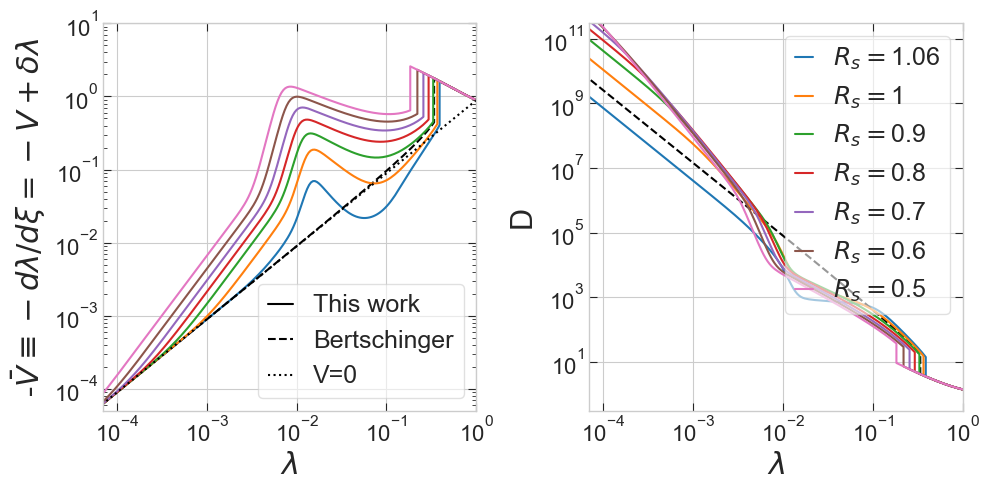

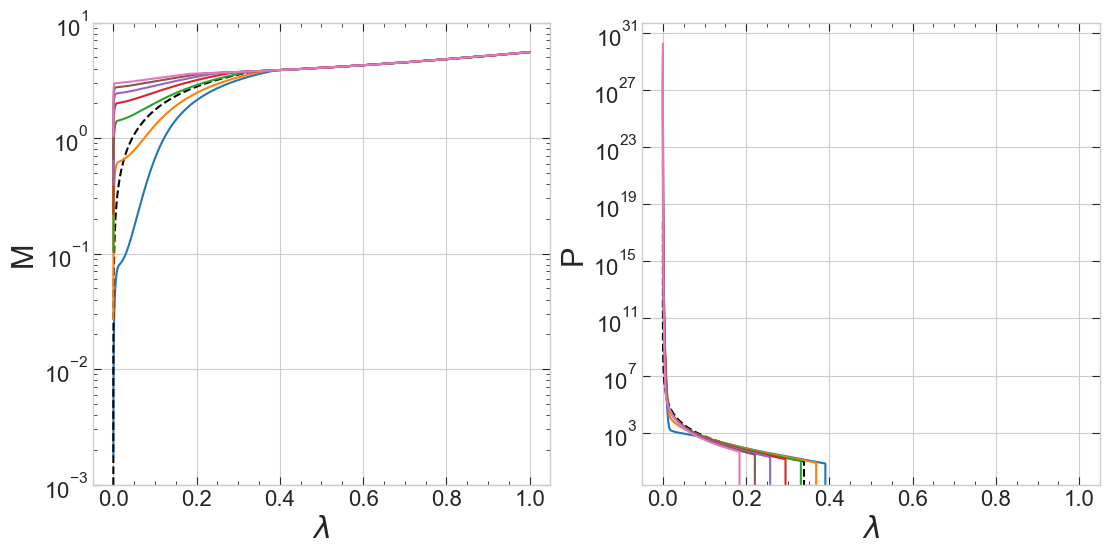

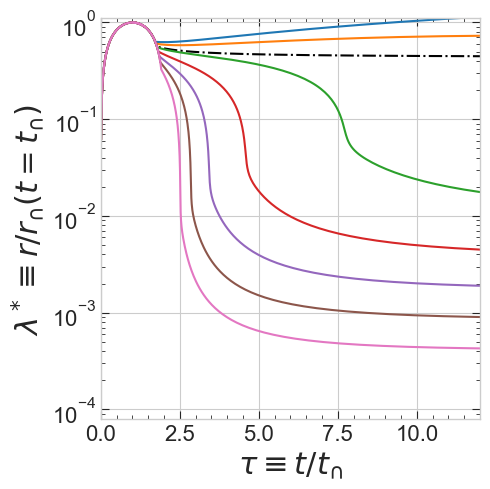

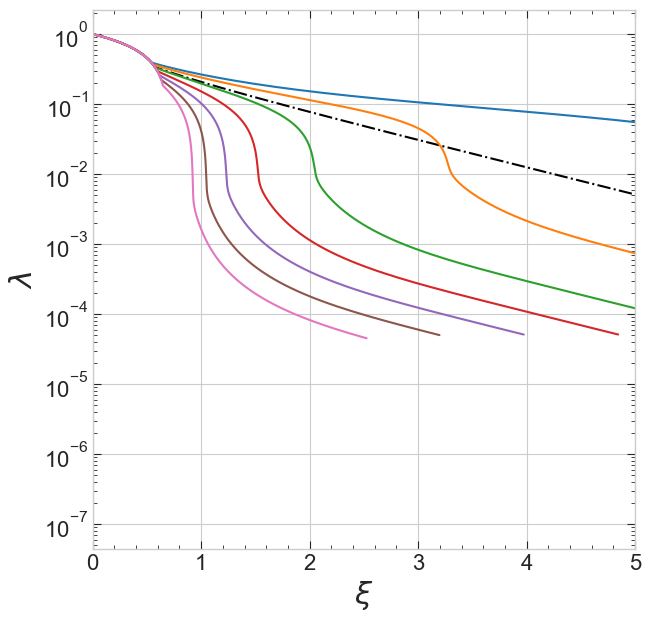

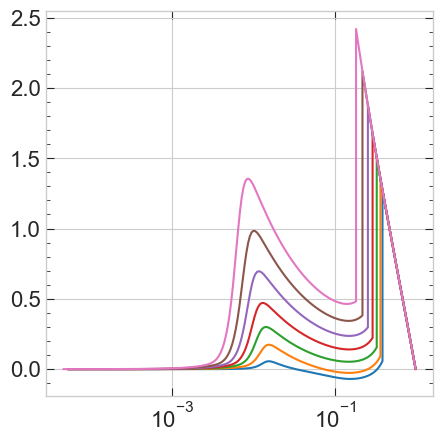

In [15]:
name = 'cold_vary-s'
name = 'shocked_vary-s'
# name = 'shocked_vary-gam'
# name = 'shocked_vary-cooling'
# name = 'shocked_vary-lamdish'
name = 'shocked_vary-lamshsp'

with open(f'{name}-rads.txt', 'tr') as file: rads_list = np.array(eval(file.read()))

s = 1
gam = 5/3
Lam0 = 3e-3
nu=1/2
fb = 0.156837
# fb = 0.5
fd = (1-fb)

lamshsp = 0.9
disk_rad_by_shock = 0.05
lamdish = disk_rad_by_shock #*lamsh

varypars=[]

if name == 'cold_vary-s':
    s_vals = [0.5,1,1.5,2,3,]
    varypars += ['s']
    lamshsp = 0.1
    lamdish = 0.5

if name == 'shocked_vary-s':
    s_vals = [0.5,1,2,]#[:-1]
    varypars += ['s']
    rads_list = rads_list[[0,1,3]]

if name == 'shocked_vary-gam':
    gam_vals= [2,1.8,5/3,1.5,7/5,4/3,]
    lamshsp_vals = [1.2,1.05,0.9,0.7,0.5,0.3]
    varypars += ['gam','lamshsp']

if name == 'shocked_vary-cooling':
    Lam0_vals = [1e-3,3e-3,1e-2,3e-2,1e-1,3e-1]
    varypars += ['Lam0']

if name == 'shocked_vary-lamdish':
    lamdish_vals = [percent/100 for percent in [2,5,10,15,25]]
    varypars += ['lamdish']

if name == 'shocked_vary-lamshsp':
    lamshsp_vals = [1.06,1,.9,.8,.7,.6,.5]#[0.35,0.3,0.25, 0.2]
    varypars += ['lamshsp']


fig5, axs5 = plt.subplots(1,2, dpi=100, figsize=(10,5), sharex=True)
fig51, axs51 = plt.subplots(1,2, dpi=100, figsize=(13,6), sharex=True)
axs5 = np.vstack([axs5,axs51])
fig6, ax6 = plt.subplots(1, dpi=100, figsize=(5,5))
fig62, ax62 = plt.subplots(1, dpi=100, figsize=(7,7))
fig7, ax7 = plt.subplots(1, dpi=100, figsize=(5,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(20):
    plab=''
    try:
        if 'gam' in varypars: gam = gam_vals[i]; plab+=r'$\gamma=$'+f"{gam:.3g}"
        if 's' in varypars: s = s_vals[i]; plab+=f"s={s} "
        if 'lamshsp' in varypars: lamshsp = lamshsp_vals[i]
        if 'lamshsp' in varypars[:1]: plab+=r'$R_s=$'+f'{lamshsp:g}'#plab+=r'$\lambda_s=$'+f'{lamshsp*100:g} '+r'$\%~ \lambda_{sp}$'
        if 'lamdish' in varypars: lamdish = lamdish_vals[i]; plab+=r'$\lambda_d=$'+f'{lamdish*100:g} '+r'$\%~ \lambda_s$'
        if 'Lam0' in varypars: Lam0 = Lam0_vals[i]; plab+=r'$\Lambda_0=$'+f'{Lam0:g} '
        # if 'nu' in varypars: nu = nu_vals[i]; plab+=r'$\nu=$'+f'{nu} '
    except IndexError: break

    t_now = time()
    de = 2* (1+s/3) /3
    alpha_D = -9/(s+3)
    descr = f'_{name}_lamshsp={lamshsp:.3g}_s={s:.2g}_gam={gam:.3g}_lamdish={lamdish:.3g}_Lam0={Lam0:.1e}_nu={nu:.1g}'

    resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm{descr}.hdf5', key=f'gas/iter0', mode='r')
    # lamsh = resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()]
    lamsh = lamshsp*rads_list[i][2] #rads_list[i][1]  #
    lamdi = lamdish*lamsh
    
    # lamshsol = 0.35 #lamsh_sols[s] #+5e-3 # 0.338976 #
    res_pre, res_post = get_soln_gas_full(lamsh)
    print(res_post.y[2][-1])
    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock profiles obtained')

    lamsh_pre = res_pre.t
    V_pre, D_pre, M_pre = res_pre.y

    lamsh_post = np.exp(res_post.t)
    mVb_post, D_post, M_post, P_post = np.exp(res_post.y)
    V_post = de*lamsh_post - mVb_post
    P_pre = lamsh_pre*0

    lamsh = lamsh_pre.min()
    # lam_all = lamsh_pre
    # V_all = V_pre
    # D_all = D_pre
    # M_all = M_pre
    # P_all = P_pre

    lam_all = np.concatenate([lamsh_post, lamsh_pre][::-1])
    V_all = np.concatenate([V_post, V_pre][::-1])
    D_all = np.concatenate([D_post, D_pre][::-1])
    M_all = np.concatenate([M_post, M_pre][::-1])
    P_all = np.concatenate([P_post, P_pre][::-1])
    Vb_all = V_all - de*lam_all

    color_this = colors[i] #plt.cm.turbo(s/4)

    ax7.plot(lam_all,-V_all, color=color_this)
    ax7.set_xscale('log')

    axs5[0,0].plot(lam_all,-Vb_all, color=color_this)
    axs5[0,1].plot(lam_all,D_all, color=color_this, label=plab)
    axs5[1,0].plot(lam_all,M_all, color=color_this)
    axs5[1,1].plot(lam_all,P_all, color=color_this)
    # axs5[0,2].plot(lam_all, P_all/D_all, color=color_this)
    # axs5[1,2].plot(lam_all, P_all/D_all**gam, color=color_this)
    # axs5[1,2].plot(lam_all, D_all*Vb_all**2-gam*P_all, color=color_this)

    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm_shocked_vary-s_lamshsp=0.9_s={s:.2g}_gam={gam:.3g}_lamdish=0.05_Lam0=3.0e-02_nu=0.5.hdf5', key=f'gas/main', mode='r')
    bertshi_vary = True if name.split('-')[-1] in ['gam','s'] else False
    color_this_bertshi = color_this if bertshi_vary else 'k'
    if bertshi_vary or i==0:
        axs5[0,0].plot(resdf_prof_gaso_bertshi.l, -resdf_prof_gaso_bertshi.Vb, color=color_this_bertshi, ls='--')
        axs5[0,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.D, color=color_this_bertshi, ls='--')
        axs5[1,0].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.M, color=color_this_bertshi, ls='--')
        axs5[1,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.P, color=color_this_bertshi, ls='--')
        print(resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()])
    # PderD_post = np.gradient(P_post,lamsh_post)/D_post

    M_intrp = interp1d(lam_all, M_all, fill_value="extrapolate")
    D_intrp = interp1d(lam_all, D_all, fill_value="extrapolate")
    V_intrp = interp1d(lam_all, V_all, fill_value="extrapolate")
    irem = P_pre.shape[0]-1
    # PderD_intrp = interp1d(np.delete(lam_all,irem), np.delete(PderD_all,irem), kind='linear', fill_value="extrapolate")

    # PderD_intrp = interp1d(lamsh_post, PderD_post, kind='linear', fill_value=0, bounds_error=False)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: all profiles obtained')

    def odefunc_traj(xi, arg):
        lam = arg
        return V_intrp(lam)-de*lam

    # taush = (thtshsol - np.sin(thtshsol)) / np.pi
    # xish = np.log(taush)
    # res = solve_ivp(odefunc_traj, (0,5), (1,), method='Radau', max_step=0.01, dense_output=False, vectorized=True)
    # res1 = solve_ivp(fun, (res.t[-1],15), np.array([res.y[0][-1],-res.y[1][-1]]), max_step=0.1, dense_output=True)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock trajectory obtained')
    
    # xires = res.t
    # lamres = res.y[0]
    # vres = res.y[1]
    xires,lamres = cumtrapz(1/(V_all-de*lam_all), x=lam_all), lam_all[1:]

    taures = np.exp(xires)
    lamFres = lamres*taures**de

    ax6.plot(taures,lamFres, color=color_this, label=plab)
    ax62.plot(xires,lamres, color=color_this)
    xio,lamo = cumtrapz(1/(resdf_prof_gaso_bertshi.V-de*resdf_prof_gaso_bertshi.l), x=resdf_prof_gaso_bertshi.l), resdf_prof_gaso_bertshi.l[1:]
    tauo = np.exp(xio)
    lamFo = lamo*tauo**de
    if bertshi_vary or i==0:
        ax62.plot(xio,lamo, c=color_this_bertshi, ls='-.')
        ax6.plot(tauo,lamFo, color=color_this_bertshi, ls='-.')

    #trajectory analytical
    thet_range = np.linspace(0.5, 1.2*np.pi,2000)
    tau_anlt = (thet_range - np.sin(thet_range)) / np.pi
    xi_anlt = np.log(tau_anlt)
    lam_anlt = preshock(thet_range)[0]
    lamF_anlt = lam_anlt*tau_anlt**de

    # ax6.plot(xi_anlt, lam_anlt, color=color_this)
    ax6.plot(tau_anlt, lamF_anlt, color=color_this)
    
    # dmo_prfl = pd.read_hdf(f'profiles_dmo_{s}.hdf5')

    # Mta = (3*np.pi/4)**2
    # M_dmo = interp1d(dmo_prfl['l'], dmo_prfl['M']*Mta, fill_value="extrapolate")
    # D_dmo = interp1d(dmo_prfl['l'].iloc[1:], dmo_prfl['rho'].iloc[1:], fill_value="extrapolate")

    # axs5[1,0].plot(lam_all, M_dmo(lam_all), color=color_this, ls='dashed')
    if name.split('_')[-1] =='vary-s':
        axs5[0,0].plot(lam_all,de*lam_all, c=color_this, ls=':')

#Loop ends

axs5[0,0].plot([],[], c='k', ls='-', label='This work')
axs5[0,0].plot([],[], c='k', ls='--', label='Bertschinger')
if name.split('_')[-1] !='vary-s':
    axs5[0,0].plot(lam_all,de*lam_all, c='k', ls=':', label='V=0')
else:
    axs5[0,0].plot([],[], c='k', ls=':', label='V=0')

# ax6.legend(loc='best',frameon=True, framealpha=0.6)
ax6.set_xlabel(r'$\tau \equiv t/t_{\cap}$')
ax6.set_ylabel(r'$\lambda^*\equiv r/r_{\cap}(t=t_{\cap})$')
ax6.set_xlim(0,12)
ax6.set_ylim(0.00008,1.1)
# ax6.set_xscale('log')
ax6.set_yscale('log')

ax62.set_xlabel(r'$\xi$')
ax62.set_ylabel('$\lambda$')
# ax62.set_xlim(,)
# ax62.set_ylim(0.01,1.1)
ax62.set_yscale('log')
    
axs5[0,0].set_xscale('log')
axs5[0,0].set_xlim(1e-5,1)
if name in ['shocked_vary-s','shocked_vary-lamshsp', 'shocked_vary-gam','cold_vary-s']:
    axs5[0,0].legend(loc='best', frameon=True, framealpha=0.6, handlelength=1)
axs5[0,1].legend(loc='best', frameon=True, framealpha=0.6, handlelength=0.7)
if name=='cold_vary-s':
    axs5[0,1].text(1e-3,1e9,'$R_s=0.1$', fontsize=15)
# axs5[0,1].legend()
axs5[0,0].set_xlabel('$\lambda$')
axs5[0,1].set_xlabel('$\lambda$')
axs5[1,0].set_xlabel('$\lambda$')
axs5[1,1].set_xlabel('$\lambda$')
# axs5[1,2].set_xlabel('$\lambda$')

# if gam==5/3:
#     axs5[0,0].set_xlim(7e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e-1,1e11)
#     axs5[1,0].set_ylim(1e-3,1e1)
#     # axs5[1,1].set_ylim(1e0,1e14)
#     # axs5[0,2].set_ylim(1e-1,1e2)
#     # axs5[1,2].set_ylim(1e-5,5e-1)
# elif gam==4/3:
#     axs5[0,0].set_xlim(1e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e0,1e11)
#     axs5[1,0].set_ylim(1e-2,1e1)
#     axs5[1,1].set_ylim(1e1,1e14)
#     # axs5[0,2].set_ylim(1e0,1e3)
#     # axs5[1,2].set_ylim(1e-2,5e-1)

axs5[0,0].set_xlim(7e-5,1)
axs5[0,0].set_ylim(5e-5,1e1)
axs5[0,1].set_ylim(3e-1,3e11)
axs5[1,0].set_ylim(1e-3,1e1)
# axs5[1,1].set_ylim(1e0,1e14)


axs5[0,0].set_ylabel(r'-$\bar{V} \equiv -d \lambda/d \xi = -V + \delta \lambda$')
axs5[0,1].set_ylabel('D')
axs5[1,0].set_ylabel('M')
axs5[1,1].set_ylabel('P')
# axs5[0,2].set_ylabel('T')
# axs5[1,2].set_ylabel('K')

axs5[0,0].set_yscale('log')
axs5[0,1].set_yscale('log')
axs5[1,0].set_yscale('log')
axs5[1,1].set_yscale('log')
ax62.set_xlim(0,5)
# axs5[0,2].set_yscale('log')
# axs5[1,2].set_yscale('log')

if name in ['shocked_vary-gam','shocked_vary-cooling']:
    axs5[0,0].set_ylabel(r'-$\bar{V}$')
    ax6.set_ylabel(r'$\lambda^*$')
# axs5[0,0].xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10,subs=np.arange(-4, 1)))
# axs5[0,0].xaxis.get_ticklocs(minor=True)
# axs5[0,0].minorticks_on()
# axs5[0,0].xaxis.set_tick_params(which='minor', bottom=True)

# # Additional lines to set major xticks
# axs5[0, 0].xaxis.set_major_locator(mpl.ticker.LogLocator(base=10, subs=np.arange(-4, 1,0.01)))
# axs5[0, 0].xaxis.get_ticklocs()

axs5[0,0].set_xticks([1e-4,1e-3,1e-2,1e-1,1])

fig5.tight_layout()
fig6.tight_layout()

fig5.savefig(f'Eds-gaso_profiles_{name}.pdf')
fig6.savefig(f'Eds-gaso_trajectory_{name}.pdf')
# axs5[0,0].set_xlim(1e-6,1)
# axs5[1,0].set_ylim(1e-4,1e1)

-2.0437859324783925
0.3104s s=1: post shock profiles obtained
0.33897639819093084
0.002247s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-1.156491327573961
0.3105s s=1: post shock profiles obtained
0.003014s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-0.6890849368141942
0.2778s s=1: post shock profiles obtained
0.00507s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-0.28752288100843615
0.2517s s=1: post shock profiles obtained
0.01276s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.03897516321836761
0.2138s s=1: post shock profiles obtained
0.003632s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.30693921668639257
0.2126s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.5339671828938729
0.2141s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained


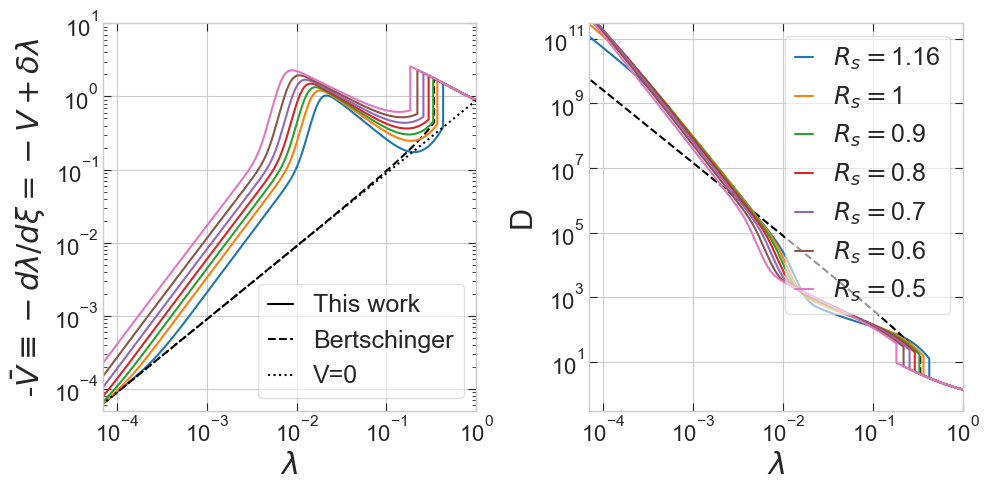

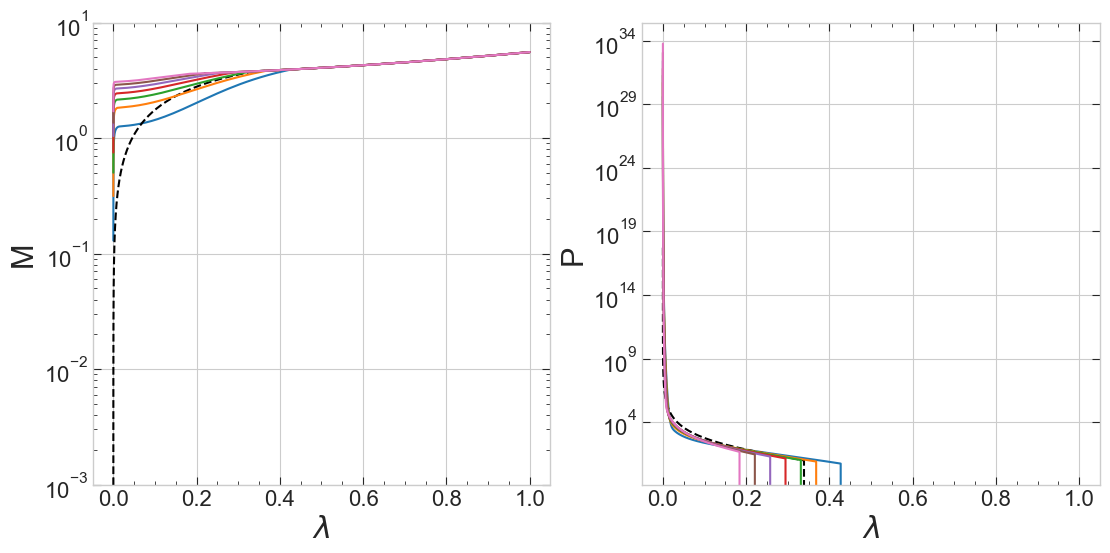

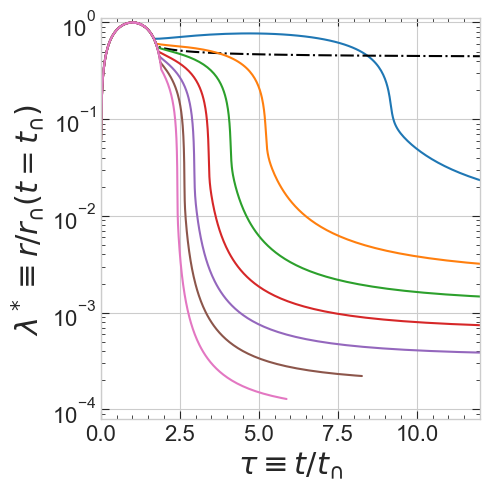

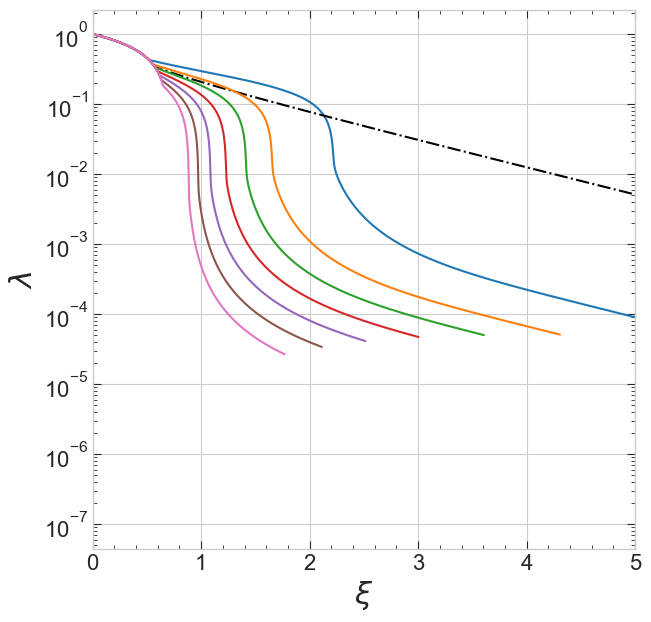

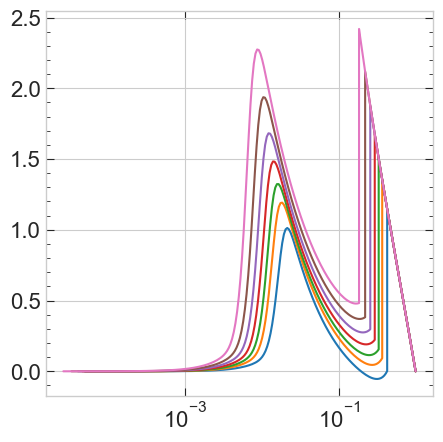

In [16]:
name = 'cold_vary-s'
name = 'shocked_vary-s'
# name = 'shocked_vary-gam'
# name = 'shocked_vary-cooling'
# name = 'shocked_vary-lamdish'
name = 'shocked_vary-lamshsp'

with open(f'{name}-rads.txt', 'tr') as file: rads_list = np.array(eval(file.read()))

s = 1
gam = 5/3
Lam0 = 3e-2
nu=1/2
fb = 0.156837
# fb = 0.5
fd = (1-fb)

lamshsp = 0.9
disk_rad_by_shock = 0.05
lamdish = disk_rad_by_shock #*lamsh

varypars=[]

if name == 'cold_vary-s':
    s_vals = [0.5,1,1.5,2,3,]
    varypars += ['s']
    lamshsp = 0.1
    lamdish = 0.5

if name == 'shocked_vary-s':
    s_vals = [0.5,1,2,]#[:-1]
    varypars += ['s']
    rads_list = rads_list[[0,1,3]]

if name == 'shocked_vary-gam':
    gam_vals= [2,1.8,5/3,1.5,7/5,4/3,]
    lamshsp_vals = [1.2,1.05,0.9,0.7,0.5,0.3]
    varypars += ['gam','lamshsp']

if name == 'shocked_vary-cooling':
    Lam0_vals = [1e-3,3e-3,1e-2,3e-2,1e-1,3e-1]
    varypars += ['Lam0']

if name == 'shocked_vary-lamdish':
    lamdish_vals = [percent/100 for percent in [2,5,10,15,25]]
    varypars += ['lamdish']

if name == 'shocked_vary-lamshsp':
    lamshsp_vals = [1.16,1,.9,.8,.7,.6,.5]#[0.35,0.3,0.25, 0.2]
    varypars += ['lamshsp']


fig5, axs5 = plt.subplots(1,2, dpi=100, figsize=(10,5), sharex=True)
fig51, axs51 = plt.subplots(1,2, dpi=100, figsize=(13,6), sharex=True)
axs5 = np.vstack([axs5,axs51])
fig6, ax6 = plt.subplots(1, dpi=100, figsize=(5,5))
fig62, ax62 = plt.subplots(1, dpi=100, figsize=(7,7))
fig7, ax7 = plt.subplots(1, dpi=100, figsize=(5,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(20):
    plab=''
    try:
        if 'gam' in varypars: gam = gam_vals[i]; plab+=r'$\gamma=$'+f"{gam:.3g}"
        if 's' in varypars: s = s_vals[i]; plab+=f"s={s} "
        if 'lamshsp' in varypars: lamshsp = lamshsp_vals[i]
        if 'lamshsp' in varypars[:1]: plab+=r'$R_s=$'+f'{lamshsp:g}'#plab+=r'$\lambda_s=$'+f'{lamshsp*100:g} '+r'$\%~ \lambda_{sp}$'
        if 'lamdish' in varypars: lamdish = lamdish_vals[i]; plab+=r'$\lambda_d=$'+f'{lamdish*100:g} '+r'$\%~ \lambda_s$'
        if 'Lam0' in varypars: Lam0 = Lam0_vals[i]; plab+=r'$\Lambda_0=$'+f'{Lam0:g} '
        # if 'nu' in varypars: nu = nu_vals[i]; plab+=r'$\nu=$'+f'{nu} '
    except IndexError: break

    t_now = time()
    de = 2* (1+s/3) /3
    alpha_D = -9/(s+3)
    descr = f'_{name}_lamshsp={lamshsp:.3g}_s={s:.2g}_gam={gam:.3g}_lamdish={lamdish:.3g}_Lam0={Lam0:.1e}_nu={nu:.1g}'

    resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm{descr}.hdf5', key=f'gas/iter0', mode='r')
    # lamsh = resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()]
    lamsh = lamshsp*rads_list[i][2] #rads_list[i][1]  #
    lamdi = lamdish*lamsh
    
    # lamshsol = 0.35 #lamsh_sols[s] #+5e-3 # 0.338976 #
    res_pre, res_post = get_soln_gas_full(lamsh)
    print(res_post.y[2][-1])
    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock profiles obtained')

    lamsh_pre = res_pre.t
    V_pre, D_pre, M_pre = res_pre.y

    lamsh_post = np.exp(res_post.t)
    mVb_post, D_post, M_post, P_post = np.exp(res_post.y)
    V_post = de*lamsh_post - mVb_post
    P_pre = lamsh_pre*0

    lamsh = lamsh_pre.min()
    # lam_all = lamsh_pre
    # V_all = V_pre
    # D_all = D_pre
    # M_all = M_pre
    # P_all = P_pre

    lam_all = np.concatenate([lamsh_post, lamsh_pre][::-1])
    V_all = np.concatenate([V_post, V_pre][::-1])
    D_all = np.concatenate([D_post, D_pre][::-1])
    M_all = np.concatenate([M_post, M_pre][::-1])
    P_all = np.concatenate([P_post, P_pre][::-1])
    Vb_all = V_all - de*lam_all

    color_this = colors[i] #plt.cm.turbo(s/4)

    ax7.plot(lam_all,-V_all, color=color_this)
    ax7.set_xscale('log')

    axs5[0,0].plot(lam_all,-Vb_all, color=color_this)
    axs5[0,1].plot(lam_all,D_all, color=color_this, label=plab)
    axs5[1,0].plot(lam_all,M_all, color=color_this)
    axs5[1,1].plot(lam_all,P_all, color=color_this)
    # axs5[0,2].plot(lam_all, P_all/D_all, color=color_this)
    # axs5[1,2].plot(lam_all, P_all/D_all**gam, color=color_this)
    # axs5[1,2].plot(lam_all, D_all*Vb_all**2-gam*P_all, color=color_this)

    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm_shocked_vary-s_lamshsp=0.9_s={s:.2g}_gam={gam:.3g}_lamdish=0.05_Lam0=3.0e-02_nu=0.5.hdf5', key=f'gas/main', mode='r')
    bertshi_vary = True if name.split('-')[-1] in ['gam','s'] else False
    color_this_bertshi = color_this if bertshi_vary else 'k'
    if bertshi_vary or i==0:
        axs5[0,0].plot(resdf_prof_gaso_bertshi.l, -resdf_prof_gaso_bertshi.Vb, color=color_this_bertshi, ls='--')
        axs5[0,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.D, color=color_this_bertshi, ls='--')
        axs5[1,0].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.M, color=color_this_bertshi, ls='--')
        axs5[1,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.P, color=color_this_bertshi, ls='--')
        print(resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()])
    # PderD_post = np.gradient(P_post,lamsh_post)/D_post

    M_intrp = interp1d(lam_all, M_all, fill_value="extrapolate")
    D_intrp = interp1d(lam_all, D_all, fill_value="extrapolate")
    V_intrp = interp1d(lam_all, V_all, fill_value="extrapolate")
    irem = P_pre.shape[0]-1
    # PderD_intrp = interp1d(np.delete(lam_all,irem), np.delete(PderD_all,irem), kind='linear', fill_value="extrapolate")

    # PderD_intrp = interp1d(lamsh_post, PderD_post, kind='linear', fill_value=0, bounds_error=False)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: all profiles obtained')

    def odefunc_traj(xi, arg):
        lam = arg
        return V_intrp(lam)-de*lam

    # taush = (thtshsol - np.sin(thtshsol)) / np.pi
    # xish = np.log(taush)
    # res = solve_ivp(odefunc_traj, (0,5), (1,), method='Radau', max_step=0.01, dense_output=False, vectorized=True)
    # res1 = solve_ivp(fun, (res.t[-1],15), np.array([res.y[0][-1],-res.y[1][-1]]), max_step=0.1, dense_output=True)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock trajectory obtained')
    
    # xires = res.t
    # lamres = res.y[0]
    # vres = res.y[1]
    xires,lamres = cumtrapz(1/(V_all-de*lam_all), x=lam_all), lam_all[1:]

    taures = np.exp(xires)
    lamFres = lamres*taures**de

    ax6.plot(taures,lamFres, color=color_this, label=plab)
    ax62.plot(xires,lamres, color=color_this)
    xio,lamo = cumtrapz(1/(resdf_prof_gaso_bertshi.V-de*resdf_prof_gaso_bertshi.l), x=resdf_prof_gaso_bertshi.l), resdf_prof_gaso_bertshi.l[1:]
    tauo = np.exp(xio)
    lamFo = lamo*tauo**de
    if bertshi_vary or i==0:
        ax62.plot(xio,lamo, c=color_this_bertshi, ls='-.')
        ax6.plot(tauo,lamFo, color=color_this_bertshi, ls='-.')

    #trajectory analytical
    thet_range = np.linspace(0.5, 1.2*np.pi,2000)
    tau_anlt = (thet_range - np.sin(thet_range)) / np.pi
    xi_anlt = np.log(tau_anlt)
    lam_anlt = preshock(thet_range)[0]
    lamF_anlt = lam_anlt*tau_anlt**de

    # ax6.plot(xi_anlt, lam_anlt, color=color_this)
    ax6.plot(tau_anlt, lamF_anlt, color=color_this)
    
    # dmo_prfl = pd.read_hdf(f'profiles_dmo_{s}.hdf5')

    # Mta = (3*np.pi/4)**2
    # M_dmo = interp1d(dmo_prfl['l'], dmo_prfl['M']*Mta, fill_value="extrapolate")
    # D_dmo = interp1d(dmo_prfl['l'].iloc[1:], dmo_prfl['rho'].iloc[1:], fill_value="extrapolate")

    # axs5[1,0].plot(lam_all, M_dmo(lam_all), color=color_this, ls='dashed')
    if name.split('_')[-1] =='vary-s':
        axs5[0,0].plot(lam_all,de*lam_all, c=color_this, ls=':')

#Loop ends

axs5[0,0].plot([],[], c='k', ls='-', label='This work')
axs5[0,0].plot([],[], c='k', ls='--', label='Bertschinger')
if name.split('_')[-1] !='vary-s':
    axs5[0,0].plot(lam_all,de*lam_all, c='k', ls=':', label='V=0')
else:
    axs5[0,0].plot([],[], c='k', ls=':', label='V=0')

# ax6.legend(loc='best',frameon=True, framealpha=0.6)
ax6.set_xlabel(r'$\tau \equiv t/t_{\cap}$')
ax6.set_ylabel(r'$\lambda^*\equiv r/r_{\cap}(t=t_{\cap})$')
ax6.set_xlim(0,12)
ax6.set_ylim(0.00008,1.1)
# ax6.set_xscale('log')
ax6.set_yscale('log')

ax62.set_xlabel(r'$\xi$')
ax62.set_ylabel('$\lambda$')
# ax62.set_xlim(,)
# ax62.set_ylim(0.01,1.1)
ax62.set_yscale('log')
    
axs5[0,0].set_xscale('log')
axs5[0,0].set_xlim(1e-5,1)
if name in ['shocked_vary-s','shocked_vary-lamshsp', 'shocked_vary-gam','cold_vary-s']:
    axs5[0,0].legend(loc='best', frameon=True, framealpha=0.6, handlelength=1)
axs5[0,1].legend(loc='best', frameon=True, framealpha=0.6, handlelength=0.7)
if name=='cold_vary-s':
    axs5[0,1].text(1e-3,1e9,'$R_s=0.1$', fontsize=15)
# axs5[0,1].legend()
axs5[0,0].set_xlabel('$\lambda$')
axs5[0,1].set_xlabel('$\lambda$')
axs5[1,0].set_xlabel('$\lambda$')
axs5[1,1].set_xlabel('$\lambda$')
# axs5[1,2].set_xlabel('$\lambda$')

# if gam==5/3:
#     axs5[0,0].set_xlim(7e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e-1,1e11)
#     axs5[1,0].set_ylim(1e-3,1e1)
#     # axs5[1,1].set_ylim(1e0,1e14)
#     # axs5[0,2].set_ylim(1e-1,1e2)
#     # axs5[1,2].set_ylim(1e-5,5e-1)
# elif gam==4/3:
#     axs5[0,0].set_xlim(1e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e0,1e11)
#     axs5[1,0].set_ylim(1e-2,1e1)
#     axs5[1,1].set_ylim(1e1,1e14)
#     # axs5[0,2].set_ylim(1e0,1e3)
#     # axs5[1,2].set_ylim(1e-2,5e-1)

axs5[0,0].set_xlim(7e-5,1)
axs5[0,0].set_ylim(5e-5,1e1)
axs5[0,1].set_ylim(3e-1,3e11)
axs5[1,0].set_ylim(1e-3,1e1)
# axs5[1,1].set_ylim(1e0,1e14)


axs5[0,0].set_ylabel(r'-$\bar{V} \equiv -d \lambda/d \xi = -V + \delta \lambda$')
axs5[0,1].set_ylabel('D')
axs5[1,0].set_ylabel('M')
axs5[1,1].set_ylabel('P')
# axs5[0,2].set_ylabel('T')
# axs5[1,2].set_ylabel('K')

axs5[0,0].set_yscale('log')
axs5[0,1].set_yscale('log')
axs5[1,0].set_yscale('log')
axs5[1,1].set_yscale('log')
ax62.set_xlim(0,5)
# axs5[0,2].set_yscale('log')
# axs5[1,2].set_yscale('log')

if name in ['shocked_vary-gam','shocked_vary-cooling']:
    axs5[0,0].set_ylabel(r'-$\bar{V}$')
    ax6.set_ylabel(r'$\lambda^*$')
# axs5[0,0].xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10,subs=np.arange(-4, 1)))
# axs5[0,0].xaxis.get_ticklocs(minor=True)
# axs5[0,0].minorticks_on()
# axs5[0,0].xaxis.set_tick_params(which='minor', bottom=True)

# # Additional lines to set major xticks
# axs5[0, 0].xaxis.set_major_locator(mpl.ticker.LogLocator(base=10, subs=np.arange(-4, 1,0.01)))
# axs5[0, 0].xaxis.get_ticklocs()

axs5[0,0].set_xticks([1e-4,1e-3,1e-2,1e-1,1])

fig5.tight_layout()
fig6.tight_layout()

fig5.savefig(f'Eds-gaso_profiles_{name}.pdf')
fig6.savefig(f'Eds-gaso_trajectory_{name}.pdf')
# axs5[0,0].set_xlim(1e-6,1)
# axs5[1,0].set_ylim(1e-4,1e1)

-3.120908824370719
0.2421s s=1: post shock profiles obtained
0.33897639819093084
0.02168s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-1.156491327573961
0.2235s s=1: post shock profiles obtained
0.004678s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-0.6890849368141942
0.2182s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-0.28752288100843615
0.2403s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.03897516321836761
0.2083s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.30693921668639257
0.2367s s=1: post shock profiles obtained
0.005003s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.5339671828938729
0.2272s s=1: post shock profiles obtained
0.003424s s=1: all profiles obtained
0s s=1: post shock trajectory obtained


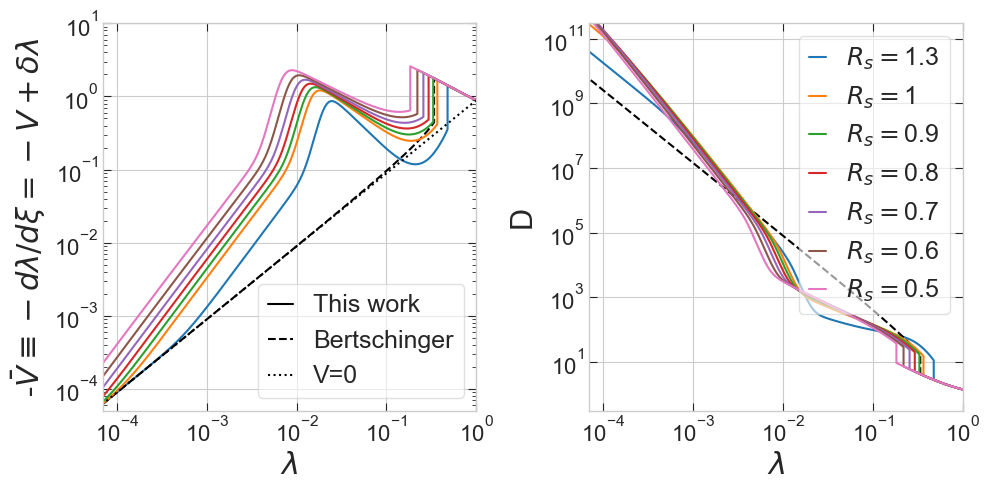

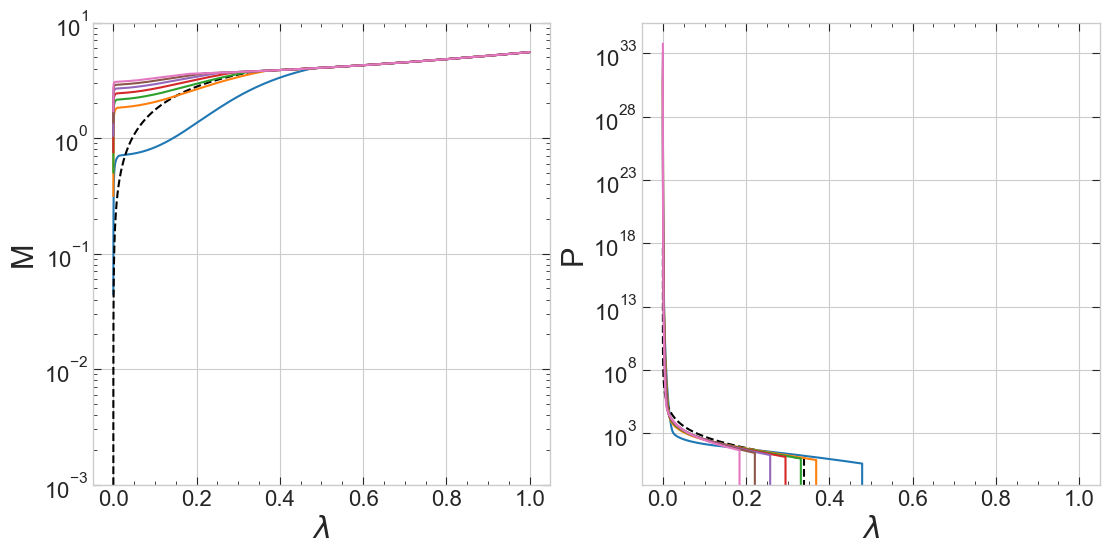

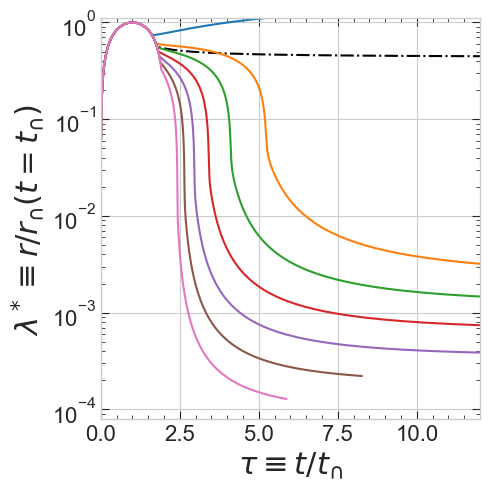

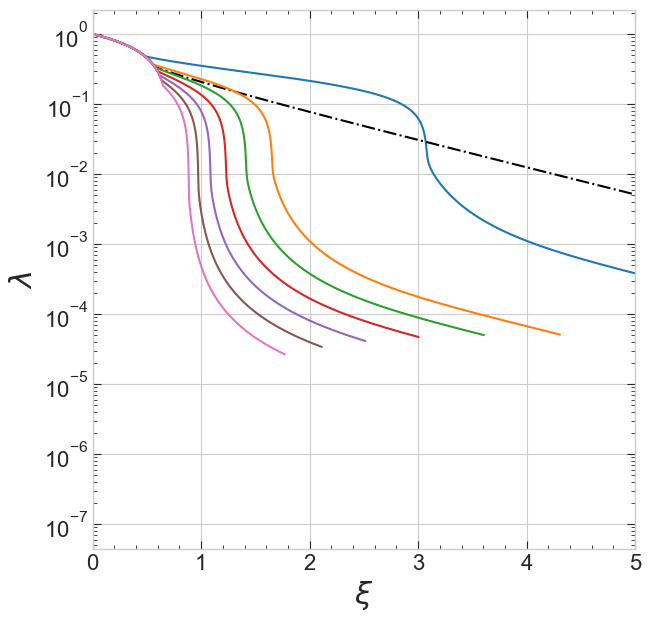

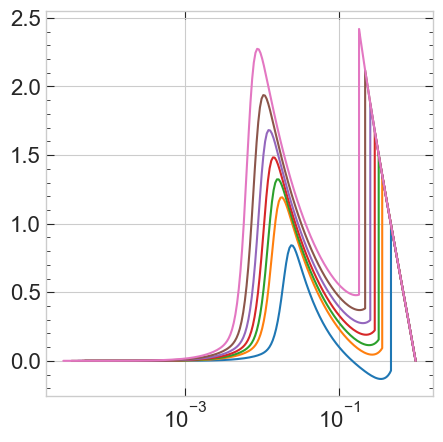

In [17]:
name = 'cold_vary-s'
name = 'shocked_vary-s'
# name = 'shocked_vary-gam'
# name = 'shocked_vary-cooling'
# name = 'shocked_vary-lamdish'
name = 'shocked_vary-lamshsp'

with open(f'{name}-rads.txt', 'tr') as file: rads_list = np.array(eval(file.read()))

s = 1
gam = 5/3
Lam0 = 3e-2
nu=1/2
fb = 0.156837
# fb = 0.5
fd = (1-fb)

lamshsp = 0.9
disk_rad_by_shock = 0.05
lamdish = disk_rad_by_shock #*lamsh

varypars=[]

if name == 'cold_vary-s':
    s_vals = [0.5,1,1.5,2,3,]
    varypars += ['s']
    lamshsp = 0.1
    lamdish = 0.5

if name == 'shocked_vary-s':
    s_vals = [0.5,1,2,]#[:-1]
    varypars += ['s']
    rads_list = rads_list[[0,1,3]]

if name == 'shocked_vary-gam':
    gam_vals= [2,1.8,5/3,1.5,7/5,4/3,]
    lamshsp_vals = [1.2,1.05,0.9,0.7,0.5,0.3]
    varypars += ['gam','lamshsp']

if name == 'shocked_vary-cooling':
    Lam0_vals = [1e-3,3e-3,1e-2,3e-2,1e-1,3e-1]
    varypars += ['Lam0']

if name == 'shocked_vary-lamdish':
    lamdish_vals = [percent/100 for percent in [2,5,10,15,25]]
    varypars += ['lamdish']

if name == 'shocked_vary-lamshsp':
    lamshsp_vals = [1.3,1,.9,.8,.7,.6,.5]#[0.35,0.3,0.25, 0.2]
    varypars += ['lamshsp']


fig5, axs5 = plt.subplots(1,2, dpi=100, figsize=(10,5), sharex=True)
fig51, axs51 = plt.subplots(1,2, dpi=100, figsize=(13,6), sharex=True)
axs5 = np.vstack([axs5,axs51])
fig6, ax6 = plt.subplots(1, dpi=100, figsize=(5,5))
fig62, ax62 = plt.subplots(1, dpi=100, figsize=(7,7))
fig7, ax7 = plt.subplots(1, dpi=100, figsize=(5,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(20):
    plab=''
    try:
        if 'gam' in varypars: gam = gam_vals[i]; plab+=r'$\gamma=$'+f"{gam:.3g}"
        if 's' in varypars: s = s_vals[i]; plab+=f"s={s} "
        if 'lamshsp' in varypars: lamshsp = lamshsp_vals[i]
        if 'lamshsp' in varypars[:1]: plab+=r'$R_s=$'+f'{lamshsp:g}'#plab+=r'$\lambda_s=$'+f'{lamshsp*100:g} '+r'$\%~ \lambda_{sp}$'
        if 'lamdish' in varypars: lamdish = lamdish_vals[i]; plab+=r'$\lambda_d=$'+f'{lamdish*100:g} '+r'$\%~ \lambda_s$'
        if 'Lam0' in varypars: Lam0 = Lam0_vals[i]; plab+=r'$\Lambda_0=$'+f'{Lam0:g} '
        # if 'nu' in varypars: nu = nu_vals[i]; plab+=r'$\nu=$'+f'{nu} '
    except IndexError: break

    t_now = time()
    de = 2* (1+s/3) /3
    alpha_D = -9/(s+3)
    descr = f'_{name}_lamshsp={lamshsp:.3g}_s={s:.2g}_gam={gam:.3g}_lamdish={lamdish:.3g}_Lam0={Lam0:.1e}_nu={nu:.1g}'

    resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm{descr}.hdf5', key=f'gas/iter0', mode='r')
    # lamsh = resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()]
    lamsh = lamshsp*rads_list[i][2] #rads_list[i][1]  #
    lamdi = lamdish*lamsh
    
    # lamshsol = 0.35 #lamsh_sols[s] #+5e-3 # 0.338976 #
    res_pre, res_post = get_soln_gas_full(lamsh)
    print(res_post.y[2][-1])
    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock profiles obtained')

    lamsh_pre = res_pre.t
    V_pre, D_pre, M_pre = res_pre.y

    lamsh_post = np.exp(res_post.t)
    mVb_post, D_post, M_post, P_post = np.exp(res_post.y)
    V_post = de*lamsh_post - mVb_post
    P_pre = lamsh_pre*0

    lamsh = lamsh_pre.min()
    # lam_all = lamsh_pre
    # V_all = V_pre
    # D_all = D_pre
    # M_all = M_pre
    # P_all = P_pre

    lam_all = np.concatenate([lamsh_post, lamsh_pre][::-1])
    V_all = np.concatenate([V_post, V_pre][::-1])
    D_all = np.concatenate([D_post, D_pre][::-1])
    M_all = np.concatenate([M_post, M_pre][::-1])
    P_all = np.concatenate([P_post, P_pre][::-1])
    Vb_all = V_all - de*lam_all

    color_this = colors[i] #plt.cm.turbo(s/4)

    ax7.plot(lam_all,-V_all, color=color_this)
    ax7.set_xscale('log')

    axs5[0,0].plot(lam_all,-Vb_all, color=color_this)
    axs5[0,1].plot(lam_all,D_all, color=color_this, label=plab)
    axs5[1,0].plot(lam_all,M_all, color=color_this)
    axs5[1,1].plot(lam_all,P_all, color=color_this)
    # axs5[0,2].plot(lam_all, P_all/D_all, color=color_this)
    # axs5[1,2].plot(lam_all, P_all/D_all**gam, color=color_this)
    # axs5[1,2].plot(lam_all, D_all*Vb_all**2-gam*P_all, color=color_this)

    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm_shocked_vary-s_lamshsp=0.9_s={s:.2g}_gam={gam:.3g}_lamdish=0.05_Lam0=3.0e-02_nu=0.5.hdf5', key=f'gas/main', mode='r')
    bertshi_vary = True if name.split('-')[-1] in ['gam','s'] else False
    color_this_bertshi = color_this if bertshi_vary else 'k'
    if bertshi_vary or i==0:
        axs5[0,0].plot(resdf_prof_gaso_bertshi.l, -resdf_prof_gaso_bertshi.Vb, color=color_this_bertshi, ls='--')
        axs5[0,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.D, color=color_this_bertshi, ls='--')
        axs5[1,0].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.M, color=color_this_bertshi, ls='--')
        axs5[1,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.P, color=color_this_bertshi, ls='--')
        print(resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()])
    # PderD_post = np.gradient(P_post,lamsh_post)/D_post

    M_intrp = interp1d(lam_all, M_all, fill_value="extrapolate")
    D_intrp = interp1d(lam_all, D_all, fill_value="extrapolate")
    V_intrp = interp1d(lam_all, V_all, fill_value="extrapolate")
    irem = P_pre.shape[0]-1
    # PderD_intrp = interp1d(np.delete(lam_all,irem), np.delete(PderD_all,irem), kind='linear', fill_value="extrapolate")

    # PderD_intrp = interp1d(lamsh_post, PderD_post, kind='linear', fill_value=0, bounds_error=False)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: all profiles obtained')

    def odefunc_traj(xi, arg):
        lam = arg
        return V_intrp(lam)-de*lam

    # taush = (thtshsol - np.sin(thtshsol)) / np.pi
    # xish = np.log(taush)
    # res = solve_ivp(odefunc_traj, (0,5), (1,), method='Radau', max_step=0.01, dense_output=False, vectorized=True)
    # res1 = solve_ivp(fun, (res.t[-1],15), np.array([res.y[0][-1],-res.y[1][-1]]), max_step=0.1, dense_output=True)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock trajectory obtained')
    
    # xires = res.t
    # lamres = res.y[0]
    # vres = res.y[1]
    xires,lamres = cumtrapz(1/(V_all-de*lam_all), x=lam_all), lam_all[1:]

    taures = np.exp(xires)
    lamFres = lamres*taures**de

    ax6.plot(taures,lamFres, color=color_this, label=plab)
    ax62.plot(xires,lamres, color=color_this)
    xio,lamo = cumtrapz(1/(resdf_prof_gaso_bertshi.V-de*resdf_prof_gaso_bertshi.l), x=resdf_prof_gaso_bertshi.l), resdf_prof_gaso_bertshi.l[1:]
    tauo = np.exp(xio)
    lamFo = lamo*tauo**de
    if bertshi_vary or i==0:
        ax62.plot(xio,lamo, c=color_this_bertshi, ls='-.')
        ax6.plot(tauo,lamFo, color=color_this_bertshi, ls='-.')

    #trajectory analytical
    thet_range = np.linspace(0.5, 1.2*np.pi,2000)
    tau_anlt = (thet_range - np.sin(thet_range)) / np.pi
    xi_anlt = np.log(tau_anlt)
    lam_anlt = preshock(thet_range)[0]
    lamF_anlt = lam_anlt*tau_anlt**de

    # ax6.plot(xi_anlt, lam_anlt, color=color_this)
    ax6.plot(tau_anlt, lamF_anlt, color=color_this)
    
    # dmo_prfl = pd.read_hdf(f'profiles_dmo_{s}.hdf5')

    # Mta = (3*np.pi/4)**2
    # M_dmo = interp1d(dmo_prfl['l'], dmo_prfl['M']*Mta, fill_value="extrapolate")
    # D_dmo = interp1d(dmo_prfl['l'].iloc[1:], dmo_prfl['rho'].iloc[1:], fill_value="extrapolate")

    # axs5[1,0].plot(lam_all, M_dmo(lam_all), color=color_this, ls='dashed')
    if name.split('_')[-1] =='vary-s':
        axs5[0,0].plot(lam_all,de*lam_all, c=color_this, ls=':')

#Loop ends

axs5[0,0].plot([],[], c='k', ls='-', label='This work')
axs5[0,0].plot([],[], c='k', ls='--', label='Bertschinger')
if name.split('_')[-1] !='vary-s':
    axs5[0,0].plot(lam_all,de*lam_all, c='k', ls=':', label='V=0')
else:
    axs5[0,0].plot([],[], c='k', ls=':', label='V=0')

# ax6.legend(loc='best',frameon=True, framealpha=0.6)
ax6.set_xlabel(r'$\tau \equiv t/t_{\cap}$')
ax6.set_ylabel(r'$\lambda^*\equiv r/r_{\cap}(t=t_{\cap})$')
ax6.set_xlim(0,12)
ax6.set_ylim(0.00008,1.1)
# ax6.set_xscale('log')
ax6.set_yscale('log')

ax62.set_xlabel(r'$\xi$')
ax62.set_ylabel('$\lambda$')
# ax62.set_xlim(,)
# ax62.set_ylim(0.01,1.1)
ax62.set_yscale('log')
    
axs5[0,0].set_xscale('log')
axs5[0,0].set_xlim(1e-5,1)
if name in ['shocked_vary-s','shocked_vary-lamshsp', 'shocked_vary-gam','cold_vary-s']:
    axs5[0,0].legend(loc='best', frameon=True, framealpha=0.6, handlelength=1)
axs5[0,1].legend(loc='best', frameon=True, framealpha=0.6, handlelength=0.7)
if name=='cold_vary-s':
    axs5[0,1].text(1e-3,1e9,'$R_s=0.1$', fontsize=15)
# axs5[0,1].legend()
axs5[0,0].set_xlabel('$\lambda$')
axs5[0,1].set_xlabel('$\lambda$')
axs5[1,0].set_xlabel('$\lambda$')
axs5[1,1].set_xlabel('$\lambda$')
# axs5[1,2].set_xlabel('$\lambda$')

# if gam==5/3:
#     axs5[0,0].set_xlim(7e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e-1,1e11)
#     axs5[1,0].set_ylim(1e-3,1e1)
#     # axs5[1,1].set_ylim(1e0,1e14)
#     # axs5[0,2].set_ylim(1e-1,1e2)
#     # axs5[1,2].set_ylim(1e-5,5e-1)
# elif gam==4/3:
#     axs5[0,0].set_xlim(1e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e0,1e11)
#     axs5[1,0].set_ylim(1e-2,1e1)
#     axs5[1,1].set_ylim(1e1,1e14)
#     # axs5[0,2].set_ylim(1e0,1e3)
#     # axs5[1,2].set_ylim(1e-2,5e-1)

axs5[0,0].set_xlim(7e-5,1)
axs5[0,0].set_ylim(5e-5,1e1)
axs5[0,1].set_ylim(3e-1,3e11)
axs5[1,0].set_ylim(1e-3,1e1)
# axs5[1,1].set_ylim(1e0,1e14)


axs5[0,0].set_ylabel(r'-$\bar{V} \equiv -d \lambda/d \xi = -V + \delta \lambda$')
axs5[0,1].set_ylabel('D')
axs5[1,0].set_ylabel('M')
axs5[1,1].set_ylabel('P')
# axs5[0,2].set_ylabel('T')
# axs5[1,2].set_ylabel('K')

axs5[0,0].set_yscale('log')
axs5[0,1].set_yscale('log')
axs5[1,0].set_yscale('log')
axs5[1,1].set_yscale('log')
ax62.set_xlim(0,5)
# axs5[0,2].set_yscale('log')
# axs5[1,2].set_yscale('log')

if name in ['shocked_vary-gam','shocked_vary-cooling']:
    axs5[0,0].set_ylabel(r'-$\bar{V}$')
    ax6.set_ylabel(r'$\lambda^*$')
# axs5[0,0].xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10,subs=np.arange(-4, 1)))
# axs5[0,0].xaxis.get_ticklocs(minor=True)
# axs5[0,0].minorticks_on()
# axs5[0,0].xaxis.set_tick_params(which='minor', bottom=True)

# # Additional lines to set major xticks
# axs5[0, 0].xaxis.set_major_locator(mpl.ticker.LogLocator(base=10, subs=np.arange(-4, 1,0.01)))
# axs5[0, 0].xaxis.get_ticklocs()

axs5[0,0].set_xticks([1e-4,1e-3,1e-2,1e-1,1])

fig5.tight_layout()
fig6.tight_layout()

fig5.savefig(f'Eds-gaso_profiles_{name}.pdf')
fig6.savefig(f'Eds-gaso_trajectory_{name}.pdf')
# axs5[0,0].set_xlim(1e-6,1)
# axs5[1,0].set_ylim(1e-4,1e1)

-8.701614599164945
0.09327s s=1: post shock profiles obtained
0.33897639819093084
0.006999s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-1.156491327573961
0.2165s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-0.6890849368141942
0.2298s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-0.28752288100843615
0.2341s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.03897516321836761
0.2224s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.30693921668639257
0.2127s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.5339671828938729
0.2013s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained


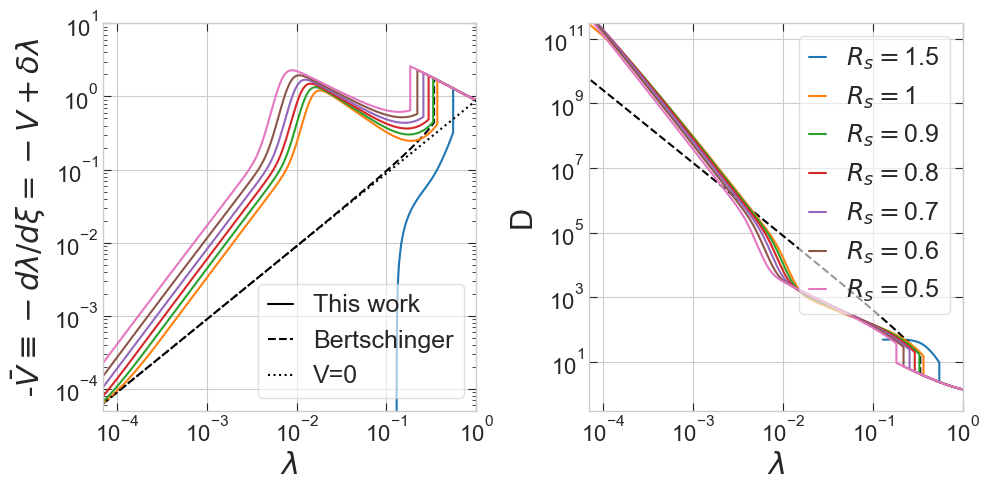

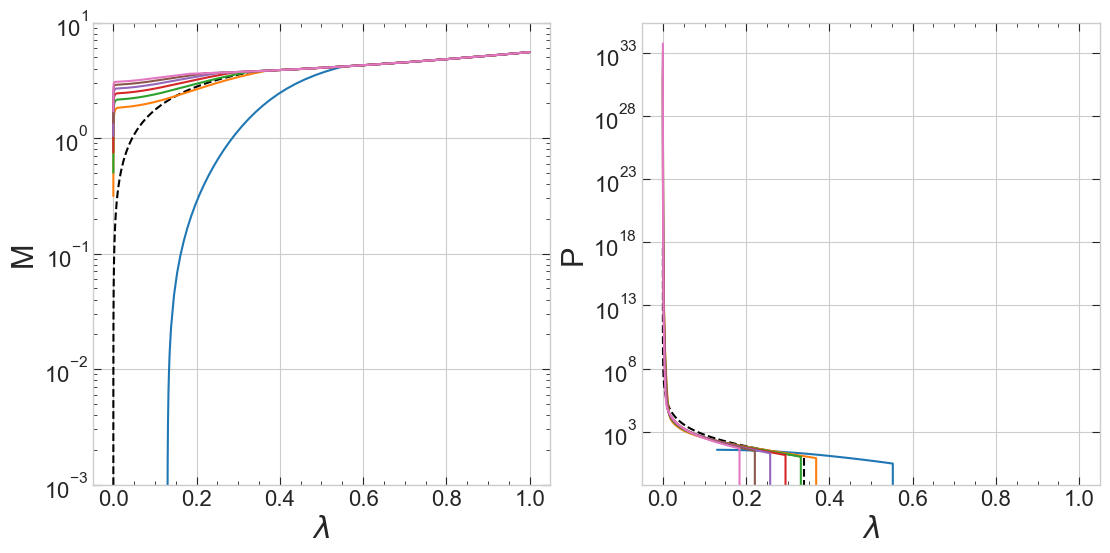

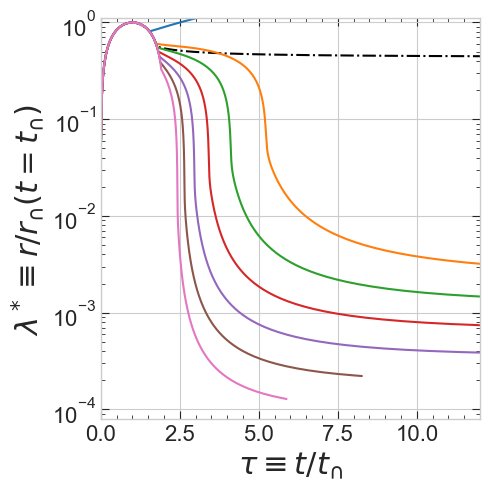

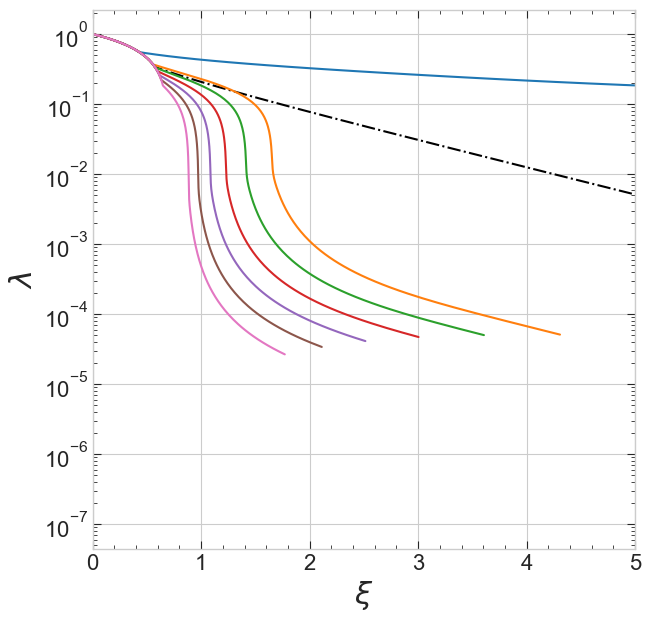

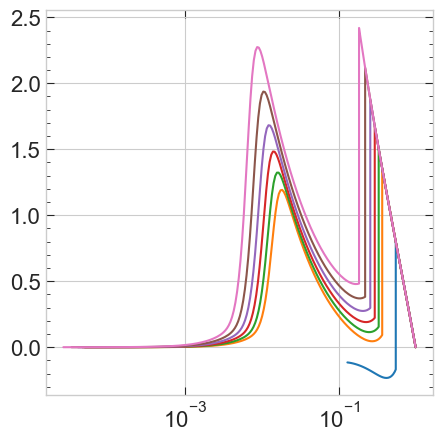

In [18]:
name = 'cold_vary-s'
name = 'shocked_vary-s'
# name = 'shocked_vary-gam'
# name = 'shocked_vary-cooling'
# name = 'shocked_vary-lamdish'
name = 'shocked_vary-lamshsp'

with open(f'{name}-rads.txt', 'tr') as file: rads_list = np.array(eval(file.read()))

s = 1
gam = 5/3
Lam0 = 3e-2
nu=1/2
fb = 0.156837
# fb = 0.5
fd = (1-fb)

lamshsp = 0.9
disk_rad_by_shock = 0.05
lamdish = disk_rad_by_shock #*lamsh

varypars=[]

if name == 'cold_vary-s':
    s_vals = [0.5,1,1.5,2,3,]
    varypars += ['s']
    lamshsp = 0.1
    lamdish = 0.5

if name == 'shocked_vary-s':
    s_vals = [0.5,1,2,]#[:-1]
    varypars += ['s']
    rads_list = rads_list[[0,1,3]]

if name == 'shocked_vary-gam':
    gam_vals= [2,1.8,5/3,1.5,7/5,4/3,]
    lamshsp_vals = [1.2,1.05,0.9,0.7,0.5,0.3]
    varypars += ['gam','lamshsp']

if name == 'shocked_vary-cooling':
    Lam0_vals = [1e-3,3e-3,1e-2,3e-2,1e-1,3e-1]
    varypars += ['Lam0']

if name == 'shocked_vary-lamdish':
    lamdish_vals = [percent/100 for percent in [2,5,10,15,25]]
    varypars += ['lamdish']

if name == 'shocked_vary-lamshsp':
    lamshsp_vals = [1.5,1,.9,.8,.7,.6,.5]#[0.35,0.3,0.25, 0.2]
    varypars += ['lamshsp']


fig5, axs5 = plt.subplots(1,2, dpi=100, figsize=(10,5), sharex=True)
fig51, axs51 = plt.subplots(1,2, dpi=100, figsize=(13,6), sharex=True)
axs5 = np.vstack([axs5,axs51])
fig6, ax6 = plt.subplots(1, dpi=100, figsize=(5,5))
fig62, ax62 = plt.subplots(1, dpi=100, figsize=(7,7))
fig7, ax7 = plt.subplots(1, dpi=100, figsize=(5,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(20):
    plab=''
    try:
        if 'gam' in varypars: gam = gam_vals[i]; plab+=r'$\gamma=$'+f"{gam:.3g}"
        if 's' in varypars: s = s_vals[i]; plab+=f"s={s} "
        if 'lamshsp' in varypars: lamshsp = lamshsp_vals[i]
        if 'lamshsp' in varypars[:1]: plab+=r'$R_s=$'+f'{lamshsp:g}'#plab+=r'$\lambda_s=$'+f'{lamshsp*100:g} '+r'$\%~ \lambda_{sp}$'
        if 'lamdish' in varypars: lamdish = lamdish_vals[i]; plab+=r'$\lambda_d=$'+f'{lamdish*100:g} '+r'$\%~ \lambda_s$'
        if 'Lam0' in varypars: Lam0 = Lam0_vals[i]; plab+=r'$\Lambda_0=$'+f'{Lam0:g} '
        # if 'nu' in varypars: nu = nu_vals[i]; plab+=r'$\nu=$'+f'{nu} '
    except IndexError: break

    t_now = time()
    de = 2* (1+s/3) /3
    alpha_D = -9/(s+3)
    descr = f'_{name}_lamshsp={lamshsp:.3g}_s={s:.2g}_gam={gam:.3g}_lamdish={lamdish:.3g}_Lam0={Lam0:.1e}_nu={nu:.1g}'

    resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm{descr}.hdf5', key=f'gas/iter0', mode='r')
    # lamsh = resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()]
    lamsh = lamshsp*rads_list[i][2] #rads_list[i][1]  #
    lamdi = lamdish*lamsh
    
    # lamshsol = 0.35 #lamsh_sols[s] #+5e-3 # 0.338976 #
    res_pre, res_post = get_soln_gas_full(lamsh)
    print(res_post.y[2][-1])
    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock profiles obtained')

    lamsh_pre = res_pre.t
    V_pre, D_pre, M_pre = res_pre.y

    lamsh_post = np.exp(res_post.t)
    mVb_post, D_post, M_post, P_post = np.exp(res_post.y)
    V_post = de*lamsh_post - mVb_post
    P_pre = lamsh_pre*0

    lamsh = lamsh_pre.min()
    # lam_all = lamsh_pre
    # V_all = V_pre
    # D_all = D_pre
    # M_all = M_pre
    # P_all = P_pre

    lam_all = np.concatenate([lamsh_post, lamsh_pre][::-1])
    V_all = np.concatenate([V_post, V_pre][::-1])
    D_all = np.concatenate([D_post, D_pre][::-1])
    M_all = np.concatenate([M_post, M_pre][::-1])
    P_all = np.concatenate([P_post, P_pre][::-1])
    Vb_all = V_all - de*lam_all

    color_this = colors[i] #plt.cm.turbo(s/4)

    ax7.plot(lam_all,-V_all, color=color_this)
    ax7.set_xscale('log')

    axs5[0,0].plot(lam_all,-Vb_all, color=color_this)
    axs5[0,1].plot(lam_all,D_all, color=color_this, label=plab)
    axs5[1,0].plot(lam_all,M_all, color=color_this)
    axs5[1,1].plot(lam_all,P_all, color=color_this)
    # axs5[0,2].plot(lam_all, P_all/D_all, color=color_this)
    # axs5[1,2].plot(lam_all, P_all/D_all**gam, color=color_this)
    # axs5[1,2].plot(lam_all, D_all*Vb_all**2-gam*P_all, color=color_this)

    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm_shocked_vary-s_lamshsp=0.9_s={s:.2g}_gam={gam:.3g}_lamdish=0.05_Lam0=3.0e-02_nu=0.5.hdf5', key=f'gas/main', mode='r')
    bertshi_vary = True if name.split('-')[-1] in ['gam','s'] else False
    color_this_bertshi = color_this if bertshi_vary else 'k'
    if bertshi_vary or i==0:
        axs5[0,0].plot(resdf_prof_gaso_bertshi.l, -resdf_prof_gaso_bertshi.Vb, color=color_this_bertshi, ls='--')
        axs5[0,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.D, color=color_this_bertshi, ls='--')
        axs5[1,0].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.M, color=color_this_bertshi, ls='--')
        axs5[1,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.P, color=color_this_bertshi, ls='--')
        print(resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()])
    # PderD_post = np.gradient(P_post,lamsh_post)/D_post

    M_intrp = interp1d(lam_all, M_all, fill_value="extrapolate")
    D_intrp = interp1d(lam_all, D_all, fill_value="extrapolate")
    V_intrp = interp1d(lam_all, V_all, fill_value="extrapolate")
    irem = P_pre.shape[0]-1
    # PderD_intrp = interp1d(np.delete(lam_all,irem), np.delete(PderD_all,irem), kind='linear', fill_value="extrapolate")

    # PderD_intrp = interp1d(lamsh_post, PderD_post, kind='linear', fill_value=0, bounds_error=False)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: all profiles obtained')

    def odefunc_traj(xi, arg):
        lam = arg
        return V_intrp(lam)-de*lam

    # taush = (thtshsol - np.sin(thtshsol)) / np.pi
    # xish = np.log(taush)
    # res = solve_ivp(odefunc_traj, (0,5), (1,), method='Radau', max_step=0.01, dense_output=False, vectorized=True)
    # res1 = solve_ivp(fun, (res.t[-1],15), np.array([res.y[0][-1],-res.y[1][-1]]), max_step=0.1, dense_output=True)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock trajectory obtained')
    
    # xires = res.t
    # lamres = res.y[0]
    # vres = res.y[1]
    xires,lamres = cumtrapz(1/(V_all-de*lam_all), x=lam_all), lam_all[1:]

    taures = np.exp(xires)
    lamFres = lamres*taures**de

    ax6.plot(taures,lamFres, color=color_this, label=plab)
    ax62.plot(xires,lamres, color=color_this)
    xio,lamo = cumtrapz(1/(resdf_prof_gaso_bertshi.V-de*resdf_prof_gaso_bertshi.l), x=resdf_prof_gaso_bertshi.l), resdf_prof_gaso_bertshi.l[1:]
    tauo = np.exp(xio)
    lamFo = lamo*tauo**de
    if bertshi_vary or i==0:
        ax62.plot(xio,lamo, c=color_this_bertshi, ls='-.')
        ax6.plot(tauo,lamFo, color=color_this_bertshi, ls='-.')

    #trajectory analytical
    thet_range = np.linspace(0.5, 1.2*np.pi,2000)
    tau_anlt = (thet_range - np.sin(thet_range)) / np.pi
    xi_anlt = np.log(tau_anlt)
    lam_anlt = preshock(thet_range)[0]
    lamF_anlt = lam_anlt*tau_anlt**de

    # ax6.plot(xi_anlt, lam_anlt, color=color_this)
    ax6.plot(tau_anlt, lamF_anlt, color=color_this)
    
    # dmo_prfl = pd.read_hdf(f'profiles_dmo_{s}.hdf5')

    # Mta = (3*np.pi/4)**2
    # M_dmo = interp1d(dmo_prfl['l'], dmo_prfl['M']*Mta, fill_value="extrapolate")
    # D_dmo = interp1d(dmo_prfl['l'].iloc[1:], dmo_prfl['rho'].iloc[1:], fill_value="extrapolate")

    # axs5[1,0].plot(lam_all, M_dmo(lam_all), color=color_this, ls='dashed')
    if name.split('_')[-1] =='vary-s':
        axs5[0,0].plot(lam_all,de*lam_all, c=color_this, ls=':')

#Loop ends

axs5[0,0].plot([],[], c='k', ls='-', label='This work')
axs5[0,0].plot([],[], c='k', ls='--', label='Bertschinger')
if name.split('_')[-1] !='vary-s':
    axs5[0,0].plot(lam_all,de*lam_all, c='k', ls=':', label='V=0')
else:
    axs5[0,0].plot([],[], c='k', ls=':', label='V=0')

# ax6.legend(loc='best',frameon=True, framealpha=0.6)
ax6.set_xlabel(r'$\tau \equiv t/t_{\cap}$')
ax6.set_ylabel(r'$\lambda^*\equiv r/r_{\cap}(t=t_{\cap})$')
ax6.set_xlim(0,12)
ax6.set_ylim(0.00008,1.1)
# ax6.set_xscale('log')
ax6.set_yscale('log')

ax62.set_xlabel(r'$\xi$')
ax62.set_ylabel('$\lambda$')
# ax62.set_xlim(,)
# ax62.set_ylim(0.01,1.1)
ax62.set_yscale('log')
    
axs5[0,0].set_xscale('log')
axs5[0,0].set_xlim(1e-5,1)
if name in ['shocked_vary-s','shocked_vary-lamshsp', 'shocked_vary-gam','cold_vary-s']:
    axs5[0,0].legend(loc='best', frameon=True, framealpha=0.6, handlelength=1)
axs5[0,1].legend(loc='best', frameon=True, framealpha=0.6, handlelength=0.7)
if name=='cold_vary-s':
    axs5[0,1].text(1e-3,1e9,'$R_s=0.1$', fontsize=15)
# axs5[0,1].legend()
axs5[0,0].set_xlabel('$\lambda$')
axs5[0,1].set_xlabel('$\lambda$')
axs5[1,0].set_xlabel('$\lambda$')
axs5[1,1].set_xlabel('$\lambda$')
# axs5[1,2].set_xlabel('$\lambda$')

# if gam==5/3:
#     axs5[0,0].set_xlim(7e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e-1,1e11)
#     axs5[1,0].set_ylim(1e-3,1e1)
#     # axs5[1,1].set_ylim(1e0,1e14)
#     # axs5[0,2].set_ylim(1e-1,1e2)
#     # axs5[1,2].set_ylim(1e-5,5e-1)
# elif gam==4/3:
#     axs5[0,0].set_xlim(1e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e0,1e11)
#     axs5[1,0].set_ylim(1e-2,1e1)
#     axs5[1,1].set_ylim(1e1,1e14)
#     # axs5[0,2].set_ylim(1e0,1e3)
#     # axs5[1,2].set_ylim(1e-2,5e-1)

axs5[0,0].set_xlim(7e-5,1)
axs5[0,0].set_ylim(5e-5,1e1)
axs5[0,1].set_ylim(3e-1,3e11)
axs5[1,0].set_ylim(1e-3,1e1)
# axs5[1,1].set_ylim(1e0,1e14)


axs5[0,0].set_ylabel(r'-$\bar{V} \equiv -d \lambda/d \xi = -V + \delta \lambda$')
axs5[0,1].set_ylabel('D')
axs5[1,0].set_ylabel('M')
axs5[1,1].set_ylabel('P')
# axs5[0,2].set_ylabel('T')
# axs5[1,2].set_ylabel('K')

axs5[0,0].set_yscale('log')
axs5[0,1].set_yscale('log')
axs5[1,0].set_yscale('log')
axs5[1,1].set_yscale('log')
ax62.set_xlim(0,5)
# axs5[0,2].set_yscale('log')
# axs5[1,2].set_yscale('log')

if name in ['shocked_vary-gam','shocked_vary-cooling']:
    axs5[0,0].set_ylabel(r'-$\bar{V}$')
    ax6.set_ylabel(r'$\lambda^*$')
# axs5[0,0].xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10,subs=np.arange(-4, 1)))
# axs5[0,0].xaxis.get_ticklocs(minor=True)
# axs5[0,0].minorticks_on()
# axs5[0,0].xaxis.set_tick_params(which='minor', bottom=True)

# # Additional lines to set major xticks
# axs5[0, 0].xaxis.set_major_locator(mpl.ticker.LogLocator(base=10, subs=np.arange(-4, 1,0.01)))
# axs5[0, 0].xaxis.get_ticklocs()

axs5[0,0].set_xticks([1e-4,1e-3,1e-2,1e-1,1])

fig5.tight_layout()
fig6.tight_layout()

fig5.savefig(f'Eds-gaso_profiles_{name}.pdf')
fig6.savefig(f'Eds-gaso_trajectory_{name}.pdf')
# axs5[0,0].set_xlim(1e-6,1)
# axs5[1,0].set_ylim(1e-4,1e1)

-4.459568941136881
0.275s s=1: post shock profiles obtained
0.33897639819093084
0.002188s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-1.156491327573961
0.2185s s=1: post shock profiles obtained
0.01606s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-0.6890849368141942
0.2614s s=1: post shock profiles obtained
0.004001s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-0.28752288100843615
0.2787s s=1: post shock profiles obtained
0.003004s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.03897516321836761
0.2094s s=1: post shock profiles obtained
0.00293s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.30693921668639257
0.2116s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.5339671828938729
0.2388s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained


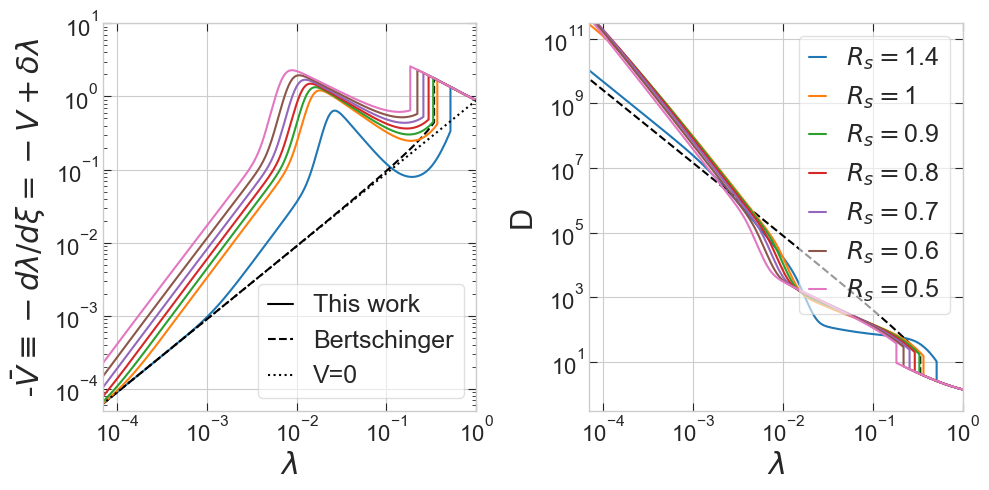

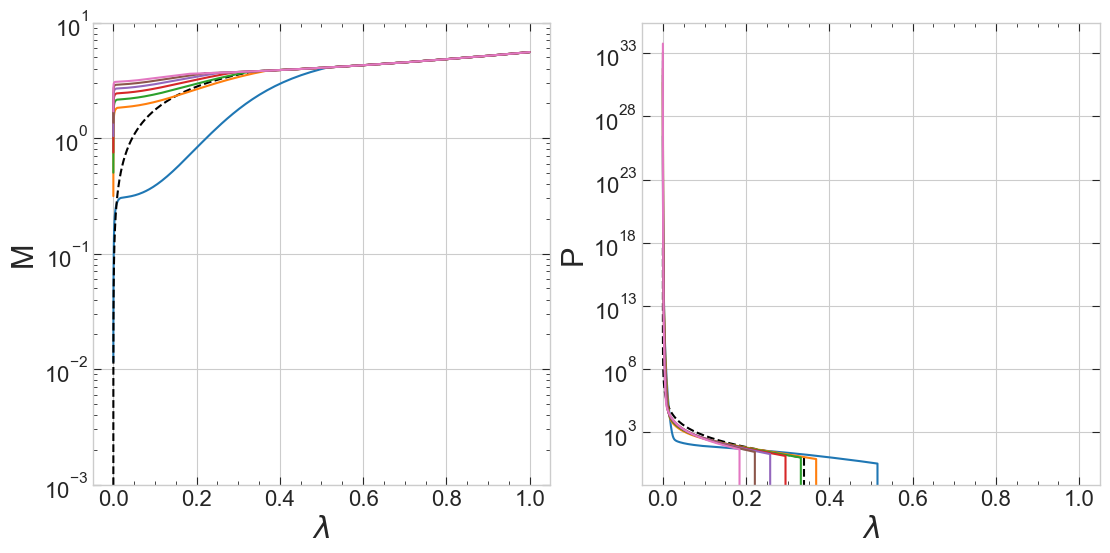

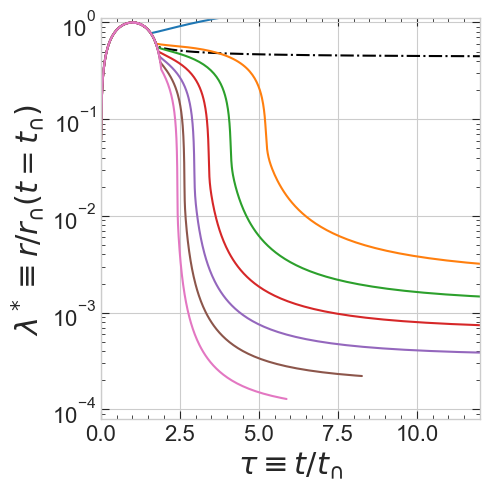

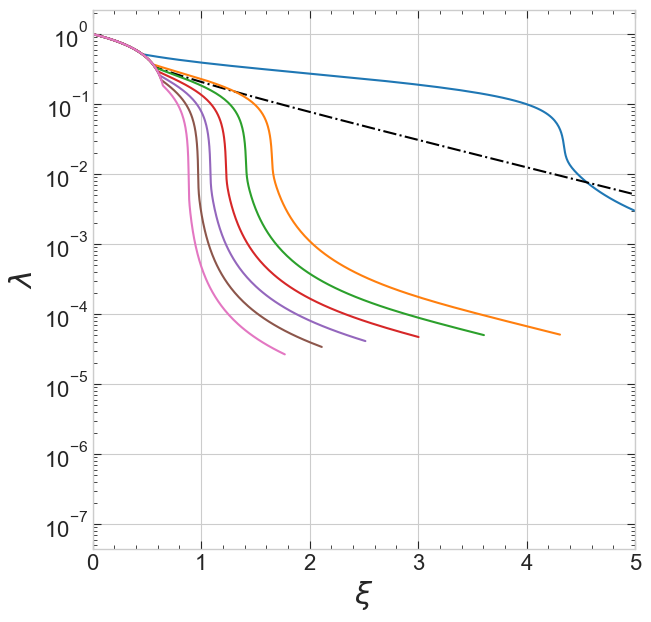

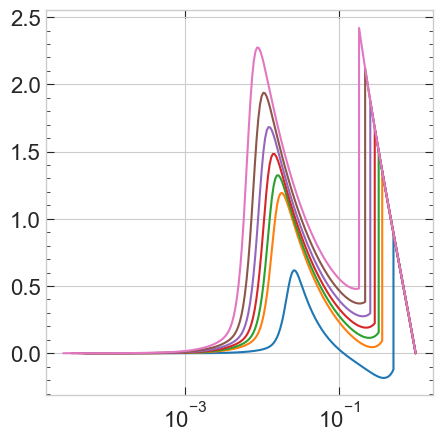

In [19]:
name = 'cold_vary-s'
name = 'shocked_vary-s'
# name = 'shocked_vary-gam'
# name = 'shocked_vary-cooling'
# name = 'shocked_vary-lamdish'
name = 'shocked_vary-lamshsp'

with open(f'{name}-rads.txt', 'tr') as file: rads_list = np.array(eval(file.read()))

s = 1
gam = 5/3
Lam0 = 3e-2
nu=1/2
fb = 0.156837
# fb = 0.5
fd = (1-fb)

lamshsp = 0.9
disk_rad_by_shock = 0.05
lamdish = disk_rad_by_shock #*lamsh

varypars=[]

if name == 'cold_vary-s':
    s_vals = [0.5,1,1.5,2,3,]
    varypars += ['s']
    lamshsp = 0.1
    lamdish = 0.5

if name == 'shocked_vary-s':
    s_vals = [0.5,1,2,]#[:-1]
    varypars += ['s']
    rads_list = rads_list[[0,1,3]]

if name == 'shocked_vary-gam':
    gam_vals= [2,1.8,5/3,1.5,7/5,4/3,]
    lamshsp_vals = [1.2,1.05,0.9,0.7,0.5,0.3]
    varypars += ['gam','lamshsp']

if name == 'shocked_vary-cooling':
    Lam0_vals = [1e-3,3e-3,1e-2,3e-2,1e-1,3e-1]
    varypars += ['Lam0']

if name == 'shocked_vary-lamdish':
    lamdish_vals = [percent/100 for percent in [2,5,10,15,25]]
    varypars += ['lamdish']

if name == 'shocked_vary-lamshsp':
    lamshsp_vals = [1.4,1,.9,.8,.7,.6,.5]#[0.35,0.3,0.25, 0.2]
    varypars += ['lamshsp']


fig5, axs5 = plt.subplots(1,2, dpi=100, figsize=(10,5), sharex=True)
fig51, axs51 = plt.subplots(1,2, dpi=100, figsize=(13,6), sharex=True)
axs5 = np.vstack([axs5,axs51])
fig6, ax6 = plt.subplots(1, dpi=100, figsize=(5,5))
fig62, ax62 = plt.subplots(1, dpi=100, figsize=(7,7))
fig7, ax7 = plt.subplots(1, dpi=100, figsize=(5,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(20):
    plab=''
    try:
        if 'gam' in varypars: gam = gam_vals[i]; plab+=r'$\gamma=$'+f"{gam:.3g}"
        if 's' in varypars: s = s_vals[i]; plab+=f"s={s} "
        if 'lamshsp' in varypars: lamshsp = lamshsp_vals[i]
        if 'lamshsp' in varypars[:1]: plab+=r'$R_s=$'+f'{lamshsp:g}'#plab+=r'$\lambda_s=$'+f'{lamshsp*100:g} '+r'$\%~ \lambda_{sp}$'
        if 'lamdish' in varypars: lamdish = lamdish_vals[i]; plab+=r'$\lambda_d=$'+f'{lamdish*100:g} '+r'$\%~ \lambda_s$'
        if 'Lam0' in varypars: Lam0 = Lam0_vals[i]; plab+=r'$\Lambda_0=$'+f'{Lam0:g} '
        # if 'nu' in varypars: nu = nu_vals[i]; plab+=r'$\nu=$'+f'{nu} '
    except IndexError: break

    t_now = time()
    de = 2* (1+s/3) /3
    alpha_D = -9/(s+3)
    descr = f'_{name}_lamshsp={lamshsp:.3g}_s={s:.2g}_gam={gam:.3g}_lamdish={lamdish:.3g}_Lam0={Lam0:.1e}_nu={nu:.1g}'

    resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm{descr}.hdf5', key=f'gas/iter0', mode='r')
    # lamsh = resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()]
    lamsh = lamshsp*rads_list[i][2] #rads_list[i][1]  #
    lamdi = lamdish*lamsh
    
    # lamshsol = 0.35 #lamsh_sols[s] #+5e-3 # 0.338976 #
    res_pre, res_post = get_soln_gas_full(lamsh)
    print(res_post.y[2][-1])
    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock profiles obtained')

    lamsh_pre = res_pre.t
    V_pre, D_pre, M_pre = res_pre.y

    lamsh_post = np.exp(res_post.t)
    mVb_post, D_post, M_post, P_post = np.exp(res_post.y)
    V_post = de*lamsh_post - mVb_post
    P_pre = lamsh_pre*0

    lamsh = lamsh_pre.min()
    # lam_all = lamsh_pre
    # V_all = V_pre
    # D_all = D_pre
    # M_all = M_pre
    # P_all = P_pre

    lam_all = np.concatenate([lamsh_post, lamsh_pre][::-1])
    V_all = np.concatenate([V_post, V_pre][::-1])
    D_all = np.concatenate([D_post, D_pre][::-1])
    M_all = np.concatenate([M_post, M_pre][::-1])
    P_all = np.concatenate([P_post, P_pre][::-1])
    Vb_all = V_all - de*lam_all

    color_this = colors[i] #plt.cm.turbo(s/4)

    ax7.plot(lam_all,-V_all, color=color_this)
    ax7.set_xscale('log')

    axs5[0,0].plot(lam_all,-Vb_all, color=color_this)
    axs5[0,1].plot(lam_all,D_all, color=color_this, label=plab)
    axs5[1,0].plot(lam_all,M_all, color=color_this)
    axs5[1,1].plot(lam_all,P_all, color=color_this)
    # axs5[0,2].plot(lam_all, P_all/D_all, color=color_this)
    # axs5[1,2].plot(lam_all, P_all/D_all**gam, color=color_this)
    # axs5[1,2].plot(lam_all, D_all*Vb_all**2-gam*P_all, color=color_this)

    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm_shocked_vary-s_lamshsp=0.9_s={s:.2g}_gam={gam:.3g}_lamdish=0.05_Lam0=3.0e-02_nu=0.5.hdf5', key=f'gas/main', mode='r')
    bertshi_vary = True if name.split('-')[-1] in ['gam','s'] else False
    color_this_bertshi = color_this if bertshi_vary else 'k'
    if bertshi_vary or i==0:
        axs5[0,0].plot(resdf_prof_gaso_bertshi.l, -resdf_prof_gaso_bertshi.Vb, color=color_this_bertshi, ls='--')
        axs5[0,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.D, color=color_this_bertshi, ls='--')
        axs5[1,0].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.M, color=color_this_bertshi, ls='--')
        axs5[1,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.P, color=color_this_bertshi, ls='--')
        print(resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()])
    # PderD_post = np.gradient(P_post,lamsh_post)/D_post

    M_intrp = interp1d(lam_all, M_all, fill_value="extrapolate")
    D_intrp = interp1d(lam_all, D_all, fill_value="extrapolate")
    V_intrp = interp1d(lam_all, V_all, fill_value="extrapolate")
    irem = P_pre.shape[0]-1
    # PderD_intrp = interp1d(np.delete(lam_all,irem), np.delete(PderD_all,irem), kind='linear', fill_value="extrapolate")

    # PderD_intrp = interp1d(lamsh_post, PderD_post, kind='linear', fill_value=0, bounds_error=False)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: all profiles obtained')

    def odefunc_traj(xi, arg):
        lam = arg
        return V_intrp(lam)-de*lam

    # taush = (thtshsol - np.sin(thtshsol)) / np.pi
    # xish = np.log(taush)
    # res = solve_ivp(odefunc_traj, (0,5), (1,), method='Radau', max_step=0.01, dense_output=False, vectorized=True)
    # res1 = solve_ivp(fun, (res.t[-1],15), np.array([res.y[0][-1],-res.y[1][-1]]), max_step=0.1, dense_output=True)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock trajectory obtained')
    
    # xires = res.t
    # lamres = res.y[0]
    # vres = res.y[1]
    xires,lamres = cumtrapz(1/(V_all-de*lam_all), x=lam_all), lam_all[1:]

    taures = np.exp(xires)
    lamFres = lamres*taures**de

    ax6.plot(taures,lamFres, color=color_this, label=plab)
    ax62.plot(xires,lamres, color=color_this)
    xio,lamo = cumtrapz(1/(resdf_prof_gaso_bertshi.V-de*resdf_prof_gaso_bertshi.l), x=resdf_prof_gaso_bertshi.l), resdf_prof_gaso_bertshi.l[1:]
    tauo = np.exp(xio)
    lamFo = lamo*tauo**de
    if bertshi_vary or i==0:
        ax62.plot(xio,lamo, c=color_this_bertshi, ls='-.')
        ax6.plot(tauo,lamFo, color=color_this_bertshi, ls='-.')

    #trajectory analytical
    thet_range = np.linspace(0.5, 1.2*np.pi,2000)
    tau_anlt = (thet_range - np.sin(thet_range)) / np.pi
    xi_anlt = np.log(tau_anlt)
    lam_anlt = preshock(thet_range)[0]
    lamF_anlt = lam_anlt*tau_anlt**de

    # ax6.plot(xi_anlt, lam_anlt, color=color_this)
    ax6.plot(tau_anlt, lamF_anlt, color=color_this)
    
    # dmo_prfl = pd.read_hdf(f'profiles_dmo_{s}.hdf5')

    # Mta = (3*np.pi/4)**2
    # M_dmo = interp1d(dmo_prfl['l'], dmo_prfl['M']*Mta, fill_value="extrapolate")
    # D_dmo = interp1d(dmo_prfl['l'].iloc[1:], dmo_prfl['rho'].iloc[1:], fill_value="extrapolate")

    # axs5[1,0].plot(lam_all, M_dmo(lam_all), color=color_this, ls='dashed')
    if name.split('_')[-1] =='vary-s':
        axs5[0,0].plot(lam_all,de*lam_all, c=color_this, ls=':')

#Loop ends

axs5[0,0].plot([],[], c='k', ls='-', label='This work')
axs5[0,0].plot([],[], c='k', ls='--', label='Bertschinger')
if name.split('_')[-1] !='vary-s':
    axs5[0,0].plot(lam_all,de*lam_all, c='k', ls=':', label='V=0')
else:
    axs5[0,0].plot([],[], c='k', ls=':', label='V=0')

# ax6.legend(loc='best',frameon=True, framealpha=0.6)
ax6.set_xlabel(r'$\tau \equiv t/t_{\cap}$')
ax6.set_ylabel(r'$\lambda^*\equiv r/r_{\cap}(t=t_{\cap})$')
ax6.set_xlim(0,12)
ax6.set_ylim(0.00008,1.1)
# ax6.set_xscale('log')
ax6.set_yscale('log')

ax62.set_xlabel(r'$\xi$')
ax62.set_ylabel('$\lambda$')
# ax62.set_xlim(,)
# ax62.set_ylim(0.01,1.1)
ax62.set_yscale('log')
    
axs5[0,0].set_xscale('log')
axs5[0,0].set_xlim(1e-5,1)
if name in ['shocked_vary-s','shocked_vary-lamshsp', 'shocked_vary-gam','cold_vary-s']:
    axs5[0,0].legend(loc='best', frameon=True, framealpha=0.6, handlelength=1)
axs5[0,1].legend(loc='best', frameon=True, framealpha=0.6, handlelength=0.7)
if name=='cold_vary-s':
    axs5[0,1].text(1e-3,1e9,'$R_s=0.1$', fontsize=15)
# axs5[0,1].legend()
axs5[0,0].set_xlabel('$\lambda$')
axs5[0,1].set_xlabel('$\lambda$')
axs5[1,0].set_xlabel('$\lambda$')
axs5[1,1].set_xlabel('$\lambda$')
# axs5[1,2].set_xlabel('$\lambda$')

# if gam==5/3:
#     axs5[0,0].set_xlim(7e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e-1,1e11)
#     axs5[1,0].set_ylim(1e-3,1e1)
#     # axs5[1,1].set_ylim(1e0,1e14)
#     # axs5[0,2].set_ylim(1e-1,1e2)
#     # axs5[1,2].set_ylim(1e-5,5e-1)
# elif gam==4/3:
#     axs5[0,0].set_xlim(1e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e0,1e11)
#     axs5[1,0].set_ylim(1e-2,1e1)
#     axs5[1,1].set_ylim(1e1,1e14)
#     # axs5[0,2].set_ylim(1e0,1e3)
#     # axs5[1,2].set_ylim(1e-2,5e-1)

axs5[0,0].set_xlim(7e-5,1)
axs5[0,0].set_ylim(5e-5,1e1)
axs5[0,1].set_ylim(3e-1,3e11)
axs5[1,0].set_ylim(1e-3,1e1)
# axs5[1,1].set_ylim(1e0,1e14)


axs5[0,0].set_ylabel(r'-$\bar{V} \equiv -d \lambda/d \xi = -V + \delta \lambda$')
axs5[0,1].set_ylabel('D')
axs5[1,0].set_ylabel('M')
axs5[1,1].set_ylabel('P')
# axs5[0,2].set_ylabel('T')
# axs5[1,2].set_ylabel('K')

axs5[0,0].set_yscale('log')
axs5[0,1].set_yscale('log')
axs5[1,0].set_yscale('log')
axs5[1,1].set_yscale('log')
ax62.set_xlim(0,5)
# axs5[0,2].set_yscale('log')
# axs5[1,2].set_yscale('log')

if name in ['shocked_vary-gam','shocked_vary-cooling']:
    axs5[0,0].set_ylabel(r'-$\bar{V}$')
    ax6.set_ylabel(r'$\lambda^*$')
# axs5[0,0].xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10,subs=np.arange(-4, 1)))
# axs5[0,0].xaxis.get_ticklocs(minor=True)
# axs5[0,0].minorticks_on()
# axs5[0,0].xaxis.set_tick_params(which='minor', bottom=True)

# # Additional lines to set major xticks
# axs5[0, 0].xaxis.set_major_locator(mpl.ticker.LogLocator(base=10, subs=np.arange(-4, 1,0.01)))
# axs5[0, 0].xaxis.get_ticklocs()

axs5[0,0].set_xticks([1e-4,1e-3,1e-2,1e-1,1])

fig5.tight_layout()
fig6.tight_layout()

fig5.savefig(f'Eds-gaso_profiles_{name}.pdf')
fig6.savefig(f'Eds-gaso_trajectory_{name}.pdf')
# axs5[0,0].set_xlim(1e-6,1)
# axs5[1,0].set_ylim(1e-4,1e1)

-3.120908824370719
0.2515s s=1: post shock profiles obtained
0.33897639819093084
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-1.156491327573961
0.2317s s=1: post shock profiles obtained
0.004998s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-0.6890849368141942
0.2652s s=1: post shock profiles obtained
0.003989s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-0.28752288100843615
0.2444s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.03897516321836761
0.2325s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.30693921668639257
0.251s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.5339671828938729
0.2559s s=1: post shock profiles obtained
0.007456s s=1: all profiles obtained
0s s=1: post shock trajectory obtained


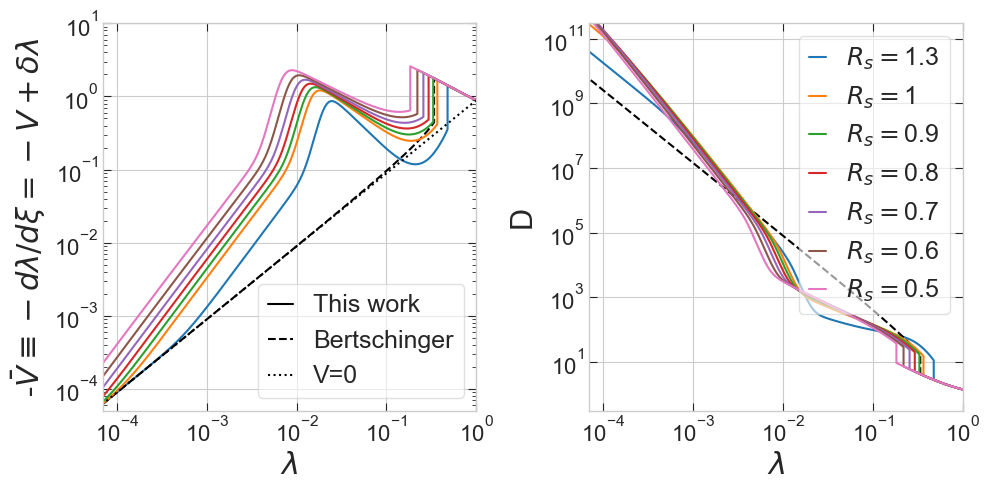

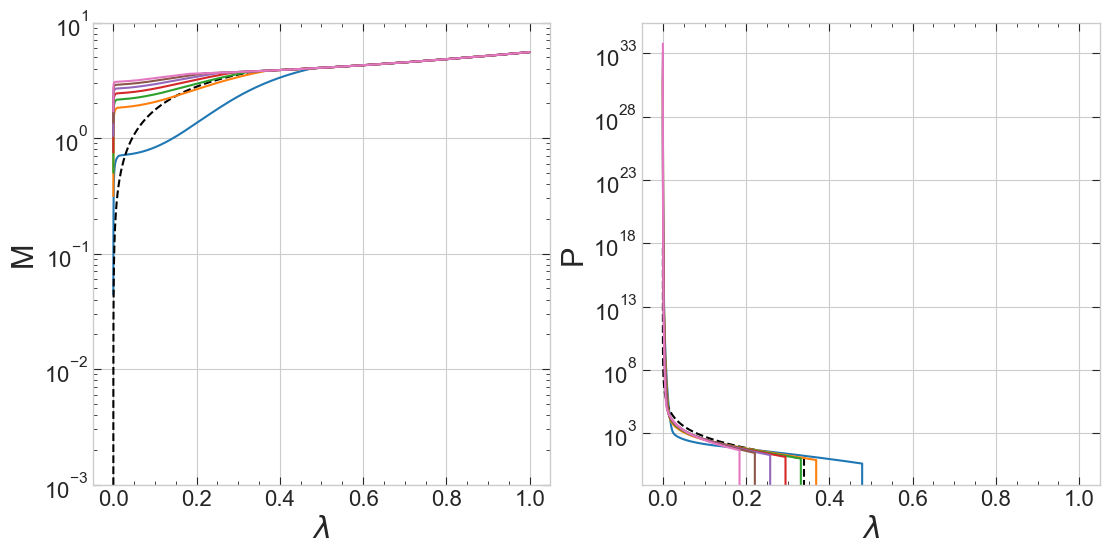

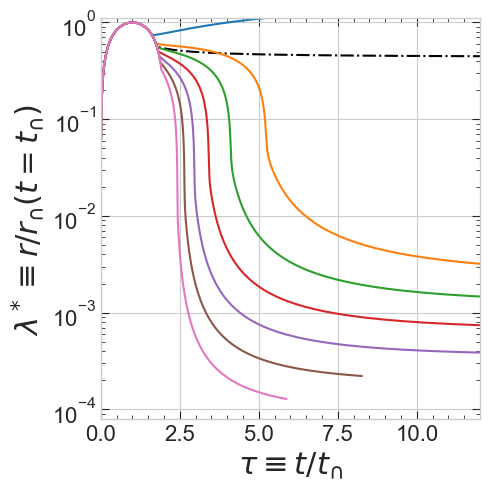

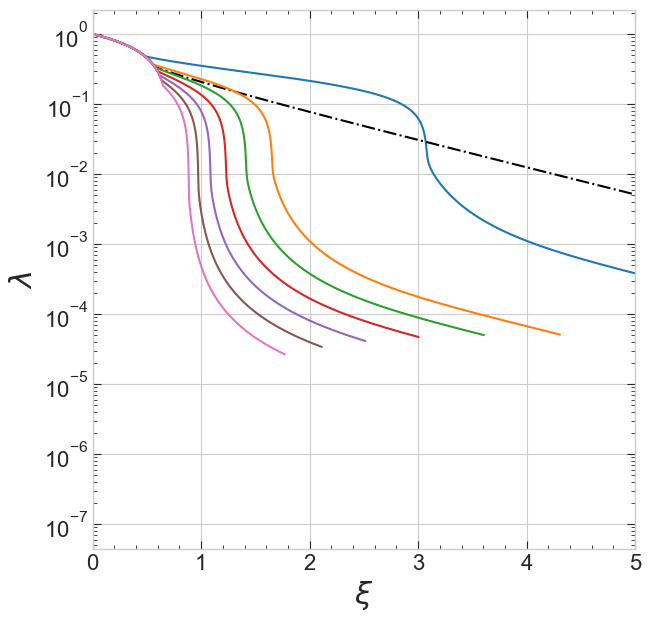

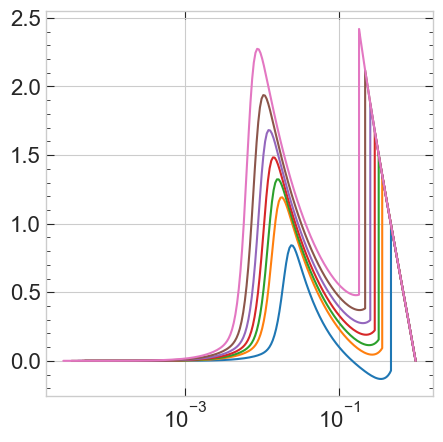

In [20]:
name = 'cold_vary-s'
name = 'shocked_vary-s'
# name = 'shocked_vary-gam'
# name = 'shocked_vary-cooling'
# name = 'shocked_vary-lamdish'
name = 'shocked_vary-lamshsp'

with open(f'{name}-rads.txt', 'tr') as file: rads_list = np.array(eval(file.read()))

s = 1
gam = 5/3
Lam0 = 3e-2
nu=1/2
fb = 0.156837
# fb = 0.5
fd = (1-fb)

lamshsp = 0.9
disk_rad_by_shock = 0.05
lamdish = disk_rad_by_shock #*lamsh

varypars=[]

if name == 'cold_vary-s':
    s_vals = [0.5,1,1.5,2,3,]
    varypars += ['s']
    lamshsp = 0.1
    lamdish = 0.5

if name == 'shocked_vary-s':
    s_vals = [0.5,1,2,]#[:-1]
    varypars += ['s']
    rads_list = rads_list[[0,1,3]]

if name == 'shocked_vary-gam':
    gam_vals= [2,1.8,5/3,1.5,7/5,4/3,]
    lamshsp_vals = [1.2,1.05,0.9,0.7,0.5,0.3]
    varypars += ['gam','lamshsp']

if name == 'shocked_vary-cooling':
    Lam0_vals = [1e-3,3e-3,1e-2,3e-2,1e-1,3e-1]
    varypars += ['Lam0']

if name == 'shocked_vary-lamdish':
    lamdish_vals = [percent/100 for percent in [2,5,10,15,25]]
    varypars += ['lamdish']

if name == 'shocked_vary-lamshsp':
    lamshsp_vals = [1.3,1,.9,.8,.7,.6,.5]#[0.35,0.3,0.25, 0.2]
    varypars += ['lamshsp']


fig5, axs5 = plt.subplots(1,2, dpi=100, figsize=(10,5), sharex=True)
fig51, axs51 = plt.subplots(1,2, dpi=100, figsize=(13,6), sharex=True)
axs5 = np.vstack([axs5,axs51])
fig6, ax6 = plt.subplots(1, dpi=100, figsize=(5,5))
fig62, ax62 = plt.subplots(1, dpi=100, figsize=(7,7))
fig7, ax7 = plt.subplots(1, dpi=100, figsize=(5,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(20):
    plab=''
    try:
        if 'gam' in varypars: gam = gam_vals[i]; plab+=r'$\gamma=$'+f"{gam:.3g}"
        if 's' in varypars: s = s_vals[i]; plab+=f"s={s} "
        if 'lamshsp' in varypars: lamshsp = lamshsp_vals[i]
        if 'lamshsp' in varypars[:1]: plab+=r'$R_s=$'+f'{lamshsp:g}'#plab+=r'$\lambda_s=$'+f'{lamshsp*100:g} '+r'$\%~ \lambda_{sp}$'
        if 'lamdish' in varypars: lamdish = lamdish_vals[i]; plab+=r'$\lambda_d=$'+f'{lamdish*100:g} '+r'$\%~ \lambda_s$'
        if 'Lam0' in varypars: Lam0 = Lam0_vals[i]; plab+=r'$\Lambda_0=$'+f'{Lam0:g} '
        # if 'nu' in varypars: nu = nu_vals[i]; plab+=r'$\nu=$'+f'{nu} '
    except IndexError: break

    t_now = time()
    de = 2* (1+s/3) /3
    alpha_D = -9/(s+3)
    descr = f'_{name}_lamshsp={lamshsp:.3g}_s={s:.2g}_gam={gam:.3g}_lamdish={lamdish:.3g}_Lam0={Lam0:.1e}_nu={nu:.1g}'

    resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm{descr}.hdf5', key=f'gas/iter0', mode='r')
    # lamsh = resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()]
    lamsh = lamshsp*rads_list[i][2] #rads_list[i][1]  #
    lamdi = lamdish*lamsh
    
    # lamshsol = 0.35 #lamsh_sols[s] #+5e-3 # 0.338976 #
    res_pre, res_post = get_soln_gas_full(lamsh)
    print(res_post.y[2][-1])
    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock profiles obtained')

    lamsh_pre = res_pre.t
    V_pre, D_pre, M_pre = res_pre.y

    lamsh_post = np.exp(res_post.t)
    mVb_post, D_post, M_post, P_post = np.exp(res_post.y)
    V_post = de*lamsh_post - mVb_post
    P_pre = lamsh_pre*0

    lamsh = lamsh_pre.min()
    # lam_all = lamsh_pre
    # V_all = V_pre
    # D_all = D_pre
    # M_all = M_pre
    # P_all = P_pre

    lam_all = np.concatenate([lamsh_post, lamsh_pre][::-1])
    V_all = np.concatenate([V_post, V_pre][::-1])
    D_all = np.concatenate([D_post, D_pre][::-1])
    M_all = np.concatenate([M_post, M_pre][::-1])
    P_all = np.concatenate([P_post, P_pre][::-1])
    Vb_all = V_all - de*lam_all

    color_this = colors[i] #plt.cm.turbo(s/4)

    ax7.plot(lam_all,-V_all, color=color_this)
    ax7.set_xscale('log')

    axs5[0,0].plot(lam_all,-Vb_all, color=color_this)
    axs5[0,1].plot(lam_all,D_all, color=color_this, label=plab)
    axs5[1,0].plot(lam_all,M_all, color=color_this)
    axs5[1,1].plot(lam_all,P_all, color=color_this)
    # axs5[0,2].plot(lam_all, P_all/D_all, color=color_this)
    # axs5[1,2].plot(lam_all, P_all/D_all**gam, color=color_this)
    # axs5[1,2].plot(lam_all, D_all*Vb_all**2-gam*P_all, color=color_this)

    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm_shocked_vary-s_lamshsp=0.9_s={s:.2g}_gam={gam:.3g}_lamdish=0.05_Lam0=3.0e-02_nu=0.5.hdf5', key=f'gas/main', mode='r')
    bertshi_vary = True if name.split('-')[-1] in ['gam','s'] else False
    color_this_bertshi = color_this if bertshi_vary else 'k'
    if bertshi_vary or i==0:
        axs5[0,0].plot(resdf_prof_gaso_bertshi.l, -resdf_prof_gaso_bertshi.Vb, color=color_this_bertshi, ls='--')
        axs5[0,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.D, color=color_this_bertshi, ls='--')
        axs5[1,0].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.M, color=color_this_bertshi, ls='--')
        axs5[1,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.P, color=color_this_bertshi, ls='--')
        print(resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()])
    # PderD_post = np.gradient(P_post,lamsh_post)/D_post

    M_intrp = interp1d(lam_all, M_all, fill_value="extrapolate")
    D_intrp = interp1d(lam_all, D_all, fill_value="extrapolate")
    V_intrp = interp1d(lam_all, V_all, fill_value="extrapolate")
    irem = P_pre.shape[0]-1
    # PderD_intrp = interp1d(np.delete(lam_all,irem), np.delete(PderD_all,irem), kind='linear', fill_value="extrapolate")

    # PderD_intrp = interp1d(lamsh_post, PderD_post, kind='linear', fill_value=0, bounds_error=False)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: all profiles obtained')

    def odefunc_traj(xi, arg):
        lam = arg
        return V_intrp(lam)-de*lam

    # taush = (thtshsol - np.sin(thtshsol)) / np.pi
    # xish = np.log(taush)
    # res = solve_ivp(odefunc_traj, (0,5), (1,), method='Radau', max_step=0.01, dense_output=False, vectorized=True)
    # res1 = solve_ivp(fun, (res.t[-1],15), np.array([res.y[0][-1],-res.y[1][-1]]), max_step=0.1, dense_output=True)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock trajectory obtained')
    
    # xires = res.t
    # lamres = res.y[0]
    # vres = res.y[1]
    xires,lamres = cumtrapz(1/(V_all-de*lam_all), x=lam_all), lam_all[1:]

    taures = np.exp(xires)
    lamFres = lamres*taures**de

    ax6.plot(taures,lamFres, color=color_this, label=plab)
    ax62.plot(xires,lamres, color=color_this)
    xio,lamo = cumtrapz(1/(resdf_prof_gaso_bertshi.V-de*resdf_prof_gaso_bertshi.l), x=resdf_prof_gaso_bertshi.l), resdf_prof_gaso_bertshi.l[1:]
    tauo = np.exp(xio)
    lamFo = lamo*tauo**de
    if bertshi_vary or i==0:
        ax62.plot(xio,lamo, c=color_this_bertshi, ls='-.')
        ax6.plot(tauo,lamFo, color=color_this_bertshi, ls='-.')

    #trajectory analytical
    thet_range = np.linspace(0.5, 1.2*np.pi,2000)
    tau_anlt = (thet_range - np.sin(thet_range)) / np.pi
    xi_anlt = np.log(tau_anlt)
    lam_anlt = preshock(thet_range)[0]
    lamF_anlt = lam_anlt*tau_anlt**de

    # ax6.plot(xi_anlt, lam_anlt, color=color_this)
    ax6.plot(tau_anlt, lamF_anlt, color=color_this)
    
    # dmo_prfl = pd.read_hdf(f'profiles_dmo_{s}.hdf5')

    # Mta = (3*np.pi/4)**2
    # M_dmo = interp1d(dmo_prfl['l'], dmo_prfl['M']*Mta, fill_value="extrapolate")
    # D_dmo = interp1d(dmo_prfl['l'].iloc[1:], dmo_prfl['rho'].iloc[1:], fill_value="extrapolate")

    # axs5[1,0].plot(lam_all, M_dmo(lam_all), color=color_this, ls='dashed')
    if name.split('_')[-1] =='vary-s':
        axs5[0,0].plot(lam_all,de*lam_all, c=color_this, ls=':')

#Loop ends

axs5[0,0].plot([],[], c='k', ls='-', label='This work')
axs5[0,0].plot([],[], c='k', ls='--', label='Bertschinger')
if name.split('_')[-1] !='vary-s':
    axs5[0,0].plot(lam_all,de*lam_all, c='k', ls=':', label='V=0')
else:
    axs5[0,0].plot([],[], c='k', ls=':', label='V=0')

# ax6.legend(loc='best',frameon=True, framealpha=0.6)
ax6.set_xlabel(r'$\tau \equiv t/t_{\cap}$')
ax6.set_ylabel(r'$\lambda^*\equiv r/r_{\cap}(t=t_{\cap})$')
ax6.set_xlim(0,12)
ax6.set_ylim(0.00008,1.1)
# ax6.set_xscale('log')
ax6.set_yscale('log')

ax62.set_xlabel(r'$\xi$')
ax62.set_ylabel('$\lambda$')
# ax62.set_xlim(,)
# ax62.set_ylim(0.01,1.1)
ax62.set_yscale('log')
    
axs5[0,0].set_xscale('log')
axs5[0,0].set_xlim(1e-5,1)
if name in ['shocked_vary-s','shocked_vary-lamshsp', 'shocked_vary-gam','cold_vary-s']:
    axs5[0,0].legend(loc='best', frameon=True, framealpha=0.6, handlelength=1)
axs5[0,1].legend(loc='best', frameon=True, framealpha=0.6, handlelength=0.7)
if name=='cold_vary-s':
    axs5[0,1].text(1e-3,1e9,'$R_s=0.1$', fontsize=15)
# axs5[0,1].legend()
axs5[0,0].set_xlabel('$\lambda$')
axs5[0,1].set_xlabel('$\lambda$')
axs5[1,0].set_xlabel('$\lambda$')
axs5[1,1].set_xlabel('$\lambda$')
# axs5[1,2].set_xlabel('$\lambda$')

# if gam==5/3:
#     axs5[0,0].set_xlim(7e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e-1,1e11)
#     axs5[1,0].set_ylim(1e-3,1e1)
#     # axs5[1,1].set_ylim(1e0,1e14)
#     # axs5[0,2].set_ylim(1e-1,1e2)
#     # axs5[1,2].set_ylim(1e-5,5e-1)
# elif gam==4/3:
#     axs5[0,0].set_xlim(1e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e0,1e11)
#     axs5[1,0].set_ylim(1e-2,1e1)
#     axs5[1,1].set_ylim(1e1,1e14)
#     # axs5[0,2].set_ylim(1e0,1e3)
#     # axs5[1,2].set_ylim(1e-2,5e-1)

axs5[0,0].set_xlim(7e-5,1)
axs5[0,0].set_ylim(5e-5,1e1)
axs5[0,1].set_ylim(3e-1,3e11)
axs5[1,0].set_ylim(1e-3,1e1)
# axs5[1,1].set_ylim(1e0,1e14)


axs5[0,0].set_ylabel(r'-$\bar{V} \equiv -d \lambda/d \xi = -V + \delta \lambda$')
axs5[0,1].set_ylabel('D')
axs5[1,0].set_ylabel('M')
axs5[1,1].set_ylabel('P')
# axs5[0,2].set_ylabel('T')
# axs5[1,2].set_ylabel('K')

axs5[0,0].set_yscale('log')
axs5[0,1].set_yscale('log')
axs5[1,0].set_yscale('log')
axs5[1,1].set_yscale('log')
ax62.set_xlim(0,5)
# axs5[0,2].set_yscale('log')
# axs5[1,2].set_yscale('log')

if name in ['shocked_vary-gam','shocked_vary-cooling']:
    axs5[0,0].set_ylabel(r'-$\bar{V}$')
    ax6.set_ylabel(r'$\lambda^*$')
# axs5[0,0].xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10,subs=np.arange(-4, 1)))
# axs5[0,0].xaxis.get_ticklocs(minor=True)
# axs5[0,0].minorticks_on()
# axs5[0,0].xaxis.set_tick_params(which='minor', bottom=True)

# # Additional lines to set major xticks
# axs5[0, 0].xaxis.set_major_locator(mpl.ticker.LogLocator(base=10, subs=np.arange(-4, 1,0.01)))
# axs5[0, 0].xaxis.get_ticklocs()

axs5[0,0].set_xticks([1e-4,1e-3,1e-2,1e-1,1])

fig5.tight_layout()
fig6.tight_layout()

fig5.savefig(f'Eds-gaso_profiles_{name}.pdf')
fig6.savefig(f'Eds-gaso_trajectory_{name}.pdf')
# axs5[0,0].set_xlim(1e-6,1)
# axs5[1,0].set_ylim(1e-4,1e1)

-5.9938009812748625
0.2747s s=1: post shock profiles obtained
0.33897639819093084
0.006613s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-1.156491327573961
0.2212s s=1: post shock profiles obtained
0.002998s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-0.6890849368141942
0.1968s s=1: post shock profiles obtained
0.0142s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-0.28752288100843615
0.2004s s=1: post shock profiles obtained
0.01479s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.03897516321836761
0.2036s s=1: post shock profiles obtained
0.01281s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.30693921668639257
0.2207s s=1: post shock profiles obtained
0.003024s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.5339671828938729
0.2005s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained


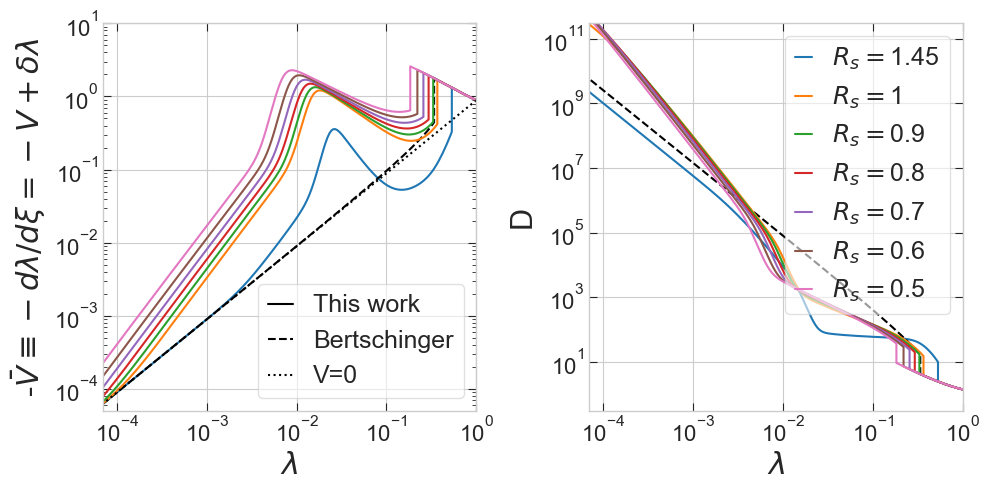

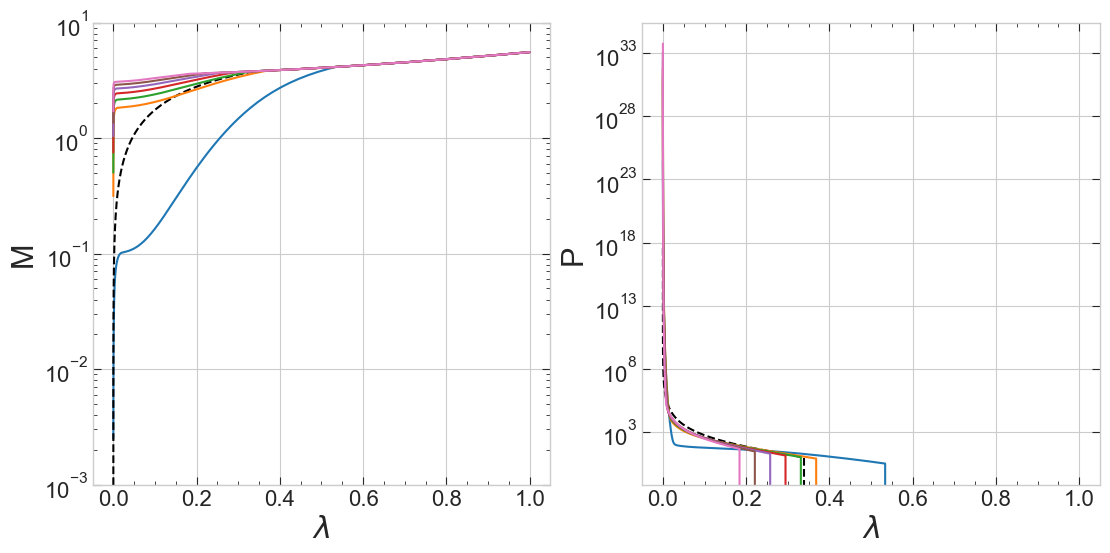

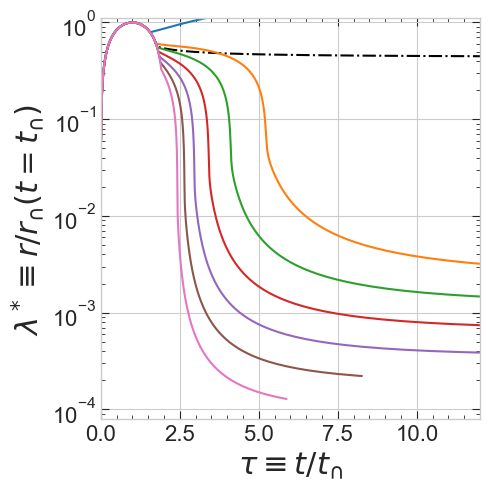

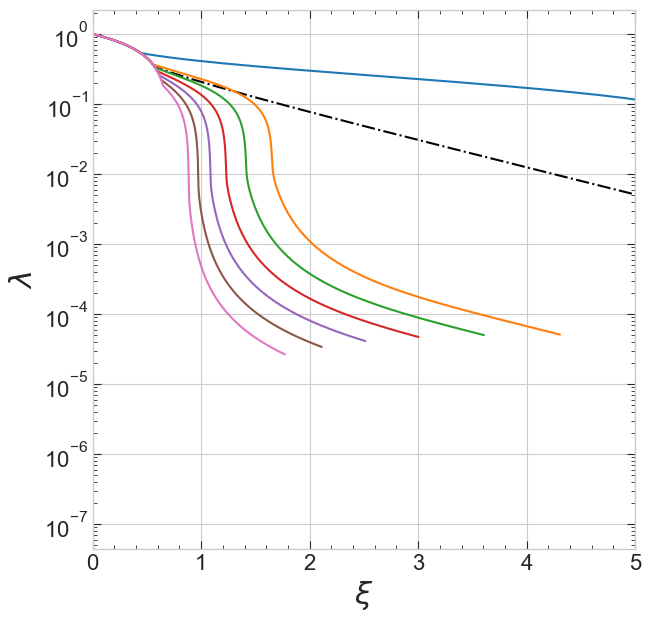

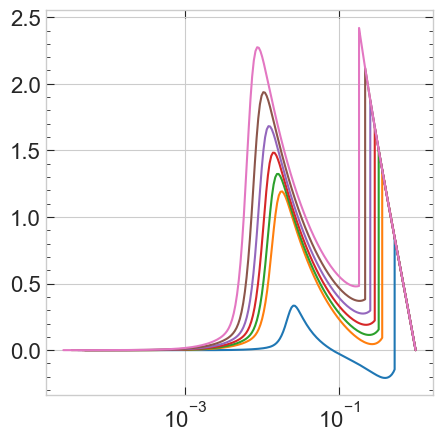

In [21]:
name = 'cold_vary-s'
name = 'shocked_vary-s'
# name = 'shocked_vary-gam'
# name = 'shocked_vary-cooling'
# name = 'shocked_vary-lamdish'
name = 'shocked_vary-lamshsp'

with open(f'{name}-rads.txt', 'tr') as file: rads_list = np.array(eval(file.read()))

s = 1
gam = 5/3
Lam0 = 3e-2
nu=1/2
fb = 0.156837
# fb = 0.5
fd = (1-fb)

lamshsp = 0.9
disk_rad_by_shock = 0.05
lamdish = disk_rad_by_shock #*lamsh

varypars=[]

if name == 'cold_vary-s':
    s_vals = [0.5,1,1.5,2,3,]
    varypars += ['s']
    lamshsp = 0.1
    lamdish = 0.5

if name == 'shocked_vary-s':
    s_vals = [0.5,1,2,]#[:-1]
    varypars += ['s']
    rads_list = rads_list[[0,1,3]]

if name == 'shocked_vary-gam':
    gam_vals= [2,1.8,5/3,1.5,7/5,4/3,]
    lamshsp_vals = [1.2,1.05,0.9,0.7,0.5,0.3]
    varypars += ['gam','lamshsp']

if name == 'shocked_vary-cooling':
    Lam0_vals = [1e-3,3e-3,1e-2,3e-2,1e-1,3e-1]
    varypars += ['Lam0']

if name == 'shocked_vary-lamdish':
    lamdish_vals = [percent/100 for percent in [2,5,10,15,25]]
    varypars += ['lamdish']

if name == 'shocked_vary-lamshsp':
    lamshsp_vals = [1.45,1,.9,.8,.7,.6,.5]#[0.35,0.3,0.25, 0.2]
    varypars += ['lamshsp']


fig5, axs5 = plt.subplots(1,2, dpi=100, figsize=(10,5), sharex=True)
fig51, axs51 = plt.subplots(1,2, dpi=100, figsize=(13,6), sharex=True)
axs5 = np.vstack([axs5,axs51])
fig6, ax6 = plt.subplots(1, dpi=100, figsize=(5,5))
fig62, ax62 = plt.subplots(1, dpi=100, figsize=(7,7))
fig7, ax7 = plt.subplots(1, dpi=100, figsize=(5,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(20):
    plab=''
    try:
        if 'gam' in varypars: gam = gam_vals[i]; plab+=r'$\gamma=$'+f"{gam:.3g}"
        if 's' in varypars: s = s_vals[i]; plab+=f"s={s} "
        if 'lamshsp' in varypars: lamshsp = lamshsp_vals[i]
        if 'lamshsp' in varypars[:1]: plab+=r'$R_s=$'+f'{lamshsp:g}'#plab+=r'$\lambda_s=$'+f'{lamshsp*100:g} '+r'$\%~ \lambda_{sp}$'
        if 'lamdish' in varypars: lamdish = lamdish_vals[i]; plab+=r'$\lambda_d=$'+f'{lamdish*100:g} '+r'$\%~ \lambda_s$'
        if 'Lam0' in varypars: Lam0 = Lam0_vals[i]; plab+=r'$\Lambda_0=$'+f'{Lam0:g} '
        # if 'nu' in varypars: nu = nu_vals[i]; plab+=r'$\nu=$'+f'{nu} '
    except IndexError: break

    t_now = time()
    de = 2* (1+s/3) /3
    alpha_D = -9/(s+3)
    descr = f'_{name}_lamshsp={lamshsp:.3g}_s={s:.2g}_gam={gam:.3g}_lamdish={lamdish:.3g}_Lam0={Lam0:.1e}_nu={nu:.1g}'

    resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm{descr}.hdf5', key=f'gas/iter0', mode='r')
    # lamsh = resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()]
    lamsh = lamshsp*rads_list[i][2] #rads_list[i][1]  #
    lamdi = lamdish*lamsh
    
    # lamshsol = 0.35 #lamsh_sols[s] #+5e-3 # 0.338976 #
    res_pre, res_post = get_soln_gas_full(lamsh)
    print(res_post.y[2][-1])
    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock profiles obtained')

    lamsh_pre = res_pre.t
    V_pre, D_pre, M_pre = res_pre.y

    lamsh_post = np.exp(res_post.t)
    mVb_post, D_post, M_post, P_post = np.exp(res_post.y)
    V_post = de*lamsh_post - mVb_post
    P_pre = lamsh_pre*0

    lamsh = lamsh_pre.min()
    # lam_all = lamsh_pre
    # V_all = V_pre
    # D_all = D_pre
    # M_all = M_pre
    # P_all = P_pre

    lam_all = np.concatenate([lamsh_post, lamsh_pre][::-1])
    V_all = np.concatenate([V_post, V_pre][::-1])
    D_all = np.concatenate([D_post, D_pre][::-1])
    M_all = np.concatenate([M_post, M_pre][::-1])
    P_all = np.concatenate([P_post, P_pre][::-1])
    Vb_all = V_all - de*lam_all

    color_this = colors[i] #plt.cm.turbo(s/4)

    ax7.plot(lam_all,-V_all, color=color_this)
    ax7.set_xscale('log')

    axs5[0,0].plot(lam_all,-Vb_all, color=color_this)
    axs5[0,1].plot(lam_all,D_all, color=color_this, label=plab)
    axs5[1,0].plot(lam_all,M_all, color=color_this)
    axs5[1,1].plot(lam_all,P_all, color=color_this)
    # axs5[0,2].plot(lam_all, P_all/D_all, color=color_this)
    # axs5[1,2].plot(lam_all, P_all/D_all**gam, color=color_this)
    # axs5[1,2].plot(lam_all, D_all*Vb_all**2-gam*P_all, color=color_this)

    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm_shocked_vary-s_lamshsp=0.9_s={s:.2g}_gam={gam:.3g}_lamdish=0.05_Lam0=3.0e-02_nu=0.5.hdf5', key=f'gas/main', mode='r')
    bertshi_vary = True if name.split('-')[-1] in ['gam','s'] else False
    color_this_bertshi = color_this if bertshi_vary else 'k'
    if bertshi_vary or i==0:
        axs5[0,0].plot(resdf_prof_gaso_bertshi.l, -resdf_prof_gaso_bertshi.Vb, color=color_this_bertshi, ls='--')
        axs5[0,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.D, color=color_this_bertshi, ls='--')
        axs5[1,0].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.M, color=color_this_bertshi, ls='--')
        axs5[1,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.P, color=color_this_bertshi, ls='--')
        print(resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()])
    # PderD_post = np.gradient(P_post,lamsh_post)/D_post

    M_intrp = interp1d(lam_all, M_all, fill_value="extrapolate")
    D_intrp = interp1d(lam_all, D_all, fill_value="extrapolate")
    V_intrp = interp1d(lam_all, V_all, fill_value="extrapolate")
    irem = P_pre.shape[0]-1
    # PderD_intrp = interp1d(np.delete(lam_all,irem), np.delete(PderD_all,irem), kind='linear', fill_value="extrapolate")

    # PderD_intrp = interp1d(lamsh_post, PderD_post, kind='linear', fill_value=0, bounds_error=False)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: all profiles obtained')

    def odefunc_traj(xi, arg):
        lam = arg
        return V_intrp(lam)-de*lam

    # taush = (thtshsol - np.sin(thtshsol)) / np.pi
    # xish = np.log(taush)
    # res = solve_ivp(odefunc_traj, (0,5), (1,), method='Radau', max_step=0.01, dense_output=False, vectorized=True)
    # res1 = solve_ivp(fun, (res.t[-1],15), np.array([res.y[0][-1],-res.y[1][-1]]), max_step=0.1, dense_output=True)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock trajectory obtained')
    
    # xires = res.t
    # lamres = res.y[0]
    # vres = res.y[1]
    xires,lamres = cumtrapz(1/(V_all-de*lam_all), x=lam_all), lam_all[1:]

    taures = np.exp(xires)
    lamFres = lamres*taures**de

    ax6.plot(taures,lamFres, color=color_this, label=plab)
    ax62.plot(xires,lamres, color=color_this)
    xio,lamo = cumtrapz(1/(resdf_prof_gaso_bertshi.V-de*resdf_prof_gaso_bertshi.l), x=resdf_prof_gaso_bertshi.l), resdf_prof_gaso_bertshi.l[1:]
    tauo = np.exp(xio)
    lamFo = lamo*tauo**de
    if bertshi_vary or i==0:
        ax62.plot(xio,lamo, c=color_this_bertshi, ls='-.')
        ax6.plot(tauo,lamFo, color=color_this_bertshi, ls='-.')

    #trajectory analytical
    thet_range = np.linspace(0.5, 1.2*np.pi,2000)
    tau_anlt = (thet_range - np.sin(thet_range)) / np.pi
    xi_anlt = np.log(tau_anlt)
    lam_anlt = preshock(thet_range)[0]
    lamF_anlt = lam_anlt*tau_anlt**de

    # ax6.plot(xi_anlt, lam_anlt, color=color_this)
    ax6.plot(tau_anlt, lamF_anlt, color=color_this)
    
    # dmo_prfl = pd.read_hdf(f'profiles_dmo_{s}.hdf5')

    # Mta = (3*np.pi/4)**2
    # M_dmo = interp1d(dmo_prfl['l'], dmo_prfl['M']*Mta, fill_value="extrapolate")
    # D_dmo = interp1d(dmo_prfl['l'].iloc[1:], dmo_prfl['rho'].iloc[1:], fill_value="extrapolate")

    # axs5[1,0].plot(lam_all, M_dmo(lam_all), color=color_this, ls='dashed')
    if name.split('_')[-1] =='vary-s':
        axs5[0,0].plot(lam_all,de*lam_all, c=color_this, ls=':')

#Loop ends

axs5[0,0].plot([],[], c='k', ls='-', label='This work')
axs5[0,0].plot([],[], c='k', ls='--', label='Bertschinger')
if name.split('_')[-1] !='vary-s':
    axs5[0,0].plot(lam_all,de*lam_all, c='k', ls=':', label='V=0')
else:
    axs5[0,0].plot([],[], c='k', ls=':', label='V=0')

# ax6.legend(loc='best',frameon=True, framealpha=0.6)
ax6.set_xlabel(r'$\tau \equiv t/t_{\cap}$')
ax6.set_ylabel(r'$\lambda^*\equiv r/r_{\cap}(t=t_{\cap})$')
ax6.set_xlim(0,12)
ax6.set_ylim(0.00008,1.1)
# ax6.set_xscale('log')
ax6.set_yscale('log')

ax62.set_xlabel(r'$\xi$')
ax62.set_ylabel('$\lambda$')
# ax62.set_xlim(,)
# ax62.set_ylim(0.01,1.1)
ax62.set_yscale('log')
    
axs5[0,0].set_xscale('log')
axs5[0,0].set_xlim(1e-5,1)
if name in ['shocked_vary-s','shocked_vary-lamshsp', 'shocked_vary-gam','cold_vary-s']:
    axs5[0,0].legend(loc='best', frameon=True, framealpha=0.6, handlelength=1)
axs5[0,1].legend(loc='best', frameon=True, framealpha=0.6, handlelength=0.7)
if name=='cold_vary-s':
    axs5[0,1].text(1e-3,1e9,'$R_s=0.1$', fontsize=15)
# axs5[0,1].legend()
axs5[0,0].set_xlabel('$\lambda$')
axs5[0,1].set_xlabel('$\lambda$')
axs5[1,0].set_xlabel('$\lambda$')
axs5[1,1].set_xlabel('$\lambda$')
# axs5[1,2].set_xlabel('$\lambda$')

# if gam==5/3:
#     axs5[0,0].set_xlim(7e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e-1,1e11)
#     axs5[1,0].set_ylim(1e-3,1e1)
#     # axs5[1,1].set_ylim(1e0,1e14)
#     # axs5[0,2].set_ylim(1e-1,1e2)
#     # axs5[1,2].set_ylim(1e-5,5e-1)
# elif gam==4/3:
#     axs5[0,0].set_xlim(1e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e0,1e11)
#     axs5[1,0].set_ylim(1e-2,1e1)
#     axs5[1,1].set_ylim(1e1,1e14)
#     # axs5[0,2].set_ylim(1e0,1e3)
#     # axs5[1,2].set_ylim(1e-2,5e-1)

axs5[0,0].set_xlim(7e-5,1)
axs5[0,0].set_ylim(5e-5,1e1)
axs5[0,1].set_ylim(3e-1,3e11)
axs5[1,0].set_ylim(1e-3,1e1)
# axs5[1,1].set_ylim(1e0,1e14)


axs5[0,0].set_ylabel(r'-$\bar{V} \equiv -d \lambda/d \xi = -V + \delta \lambda$')
axs5[0,1].set_ylabel('D')
axs5[1,0].set_ylabel('M')
axs5[1,1].set_ylabel('P')
# axs5[0,2].set_ylabel('T')
# axs5[1,2].set_ylabel('K')

axs5[0,0].set_yscale('log')
axs5[0,1].set_yscale('log')
axs5[1,0].set_yscale('log')
axs5[1,1].set_yscale('log')
ax62.set_xlim(0,5)
# axs5[0,2].set_yscale('log')
# axs5[1,2].set_yscale('log')

if name in ['shocked_vary-gam','shocked_vary-cooling']:
    axs5[0,0].set_ylabel(r'-$\bar{V}$')
    ax6.set_ylabel(r'$\lambda^*$')
# axs5[0,0].xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10,subs=np.arange(-4, 1)))
# axs5[0,0].xaxis.get_ticklocs(minor=True)
# axs5[0,0].minorticks_on()
# axs5[0,0].xaxis.set_tick_params(which='minor', bottom=True)

# # Additional lines to set major xticks
# axs5[0, 0].xaxis.set_major_locator(mpl.ticker.LogLocator(base=10, subs=np.arange(-4, 1,0.01)))
# axs5[0, 0].xaxis.get_ticklocs()

axs5[0,0].set_xticks([1e-4,1e-3,1e-2,1e-1,1])

fig5.tight_layout()
fig6.tight_layout()

fig5.savefig(f'Eds-gaso_profiles_{name}.pdf')
fig6.savefig(f'Eds-gaso_trajectory_{name}.pdf')
# axs5[0,0].set_xlim(1e-6,1)
# axs5[1,0].set_ylim(1e-4,1e1)

-7.970631736651524
0.2901s s=1: post shock profiles obtained
0.33897639819093084
0.007457s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-1.156491327573961
0.2198s s=1: post shock profiles obtained
0.01082s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-0.6890849368141942
0.2602s s=1: post shock profiles obtained
0.003034s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-0.28752288100843615
0.2161s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.03897516321836761
0.2264s s=1: post shock profiles obtained
0.005097s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.30693921668639257
0.2313s s=1: post shock profiles obtained
0.003644s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.5339671828938729
0.2096s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained


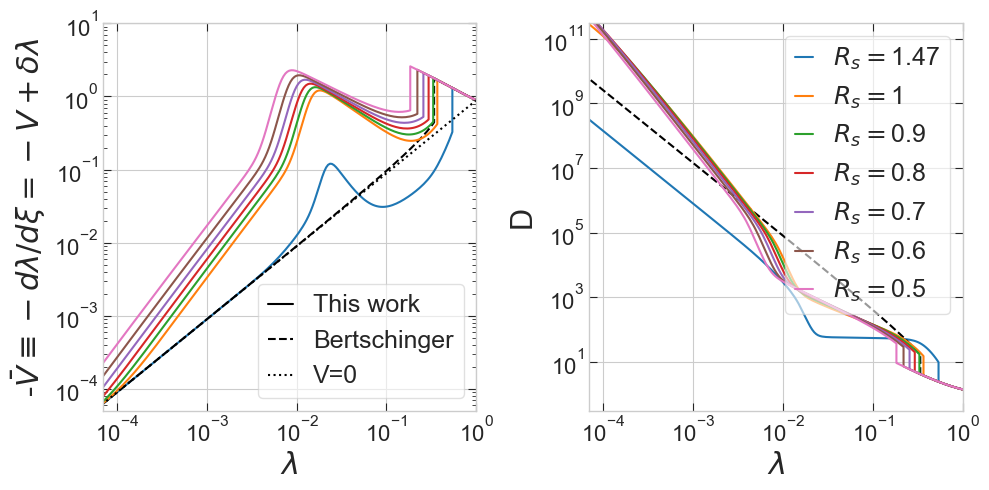

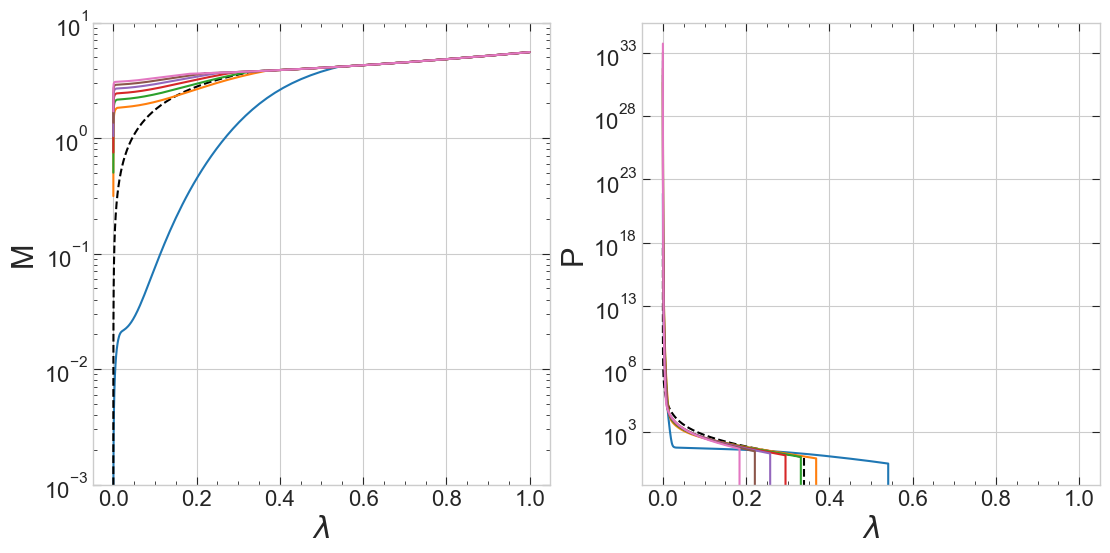

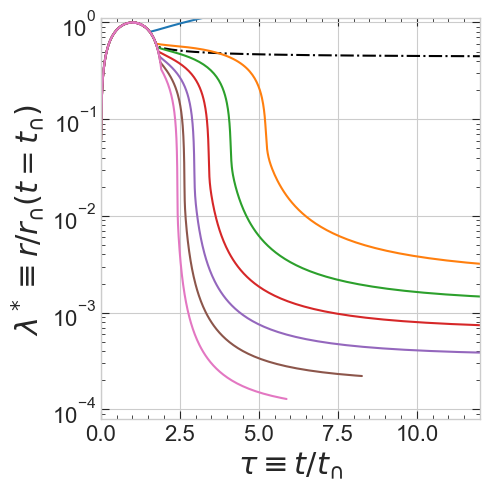

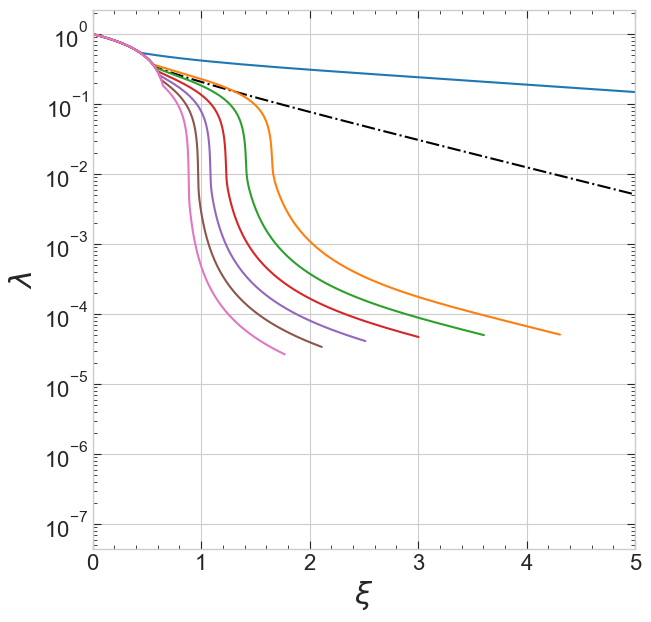

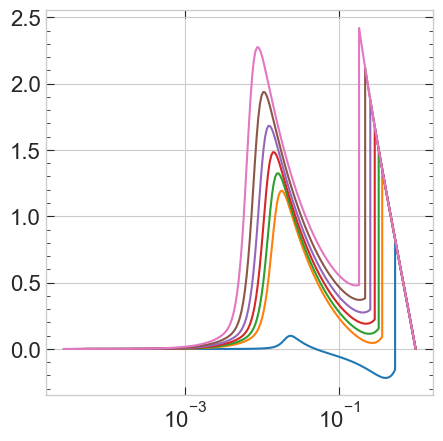

In [22]:
name = 'cold_vary-s'
name = 'shocked_vary-s'
# name = 'shocked_vary-gam'
# name = 'shocked_vary-cooling'
# name = 'shocked_vary-lamdish'
name = 'shocked_vary-lamshsp'

with open(f'{name}-rads.txt', 'tr') as file: rads_list = np.array(eval(file.read()))

s = 1
gam = 5/3
Lam0 = 3e-2
nu=1/2
fb = 0.156837
# fb = 0.5
fd = (1-fb)

lamshsp = 0.9
disk_rad_by_shock = 0.05
lamdish = disk_rad_by_shock #*lamsh

varypars=[]

if name == 'cold_vary-s':
    s_vals = [0.5,1,1.5,2,3,]
    varypars += ['s']
    lamshsp = 0.1
    lamdish = 0.5

if name == 'shocked_vary-s':
    s_vals = [0.5,1,2,]#[:-1]
    varypars += ['s']
    rads_list = rads_list[[0,1,3]]

if name == 'shocked_vary-gam':
    gam_vals= [2,1.8,5/3,1.5,7/5,4/3,]
    lamshsp_vals = [1.2,1.05,0.9,0.7,0.5,0.3]
    varypars += ['gam','lamshsp']

if name == 'shocked_vary-cooling':
    Lam0_vals = [1e-3,3e-3,1e-2,3e-2,1e-1,3e-1]
    varypars += ['Lam0']

if name == 'shocked_vary-lamdish':
    lamdish_vals = [percent/100 for percent in [2,5,10,15,25]]
    varypars += ['lamdish']

if name == 'shocked_vary-lamshsp':
    lamshsp_vals = [1.47,1,.9,.8,.7,.6,.5]#[0.35,0.3,0.25, 0.2]
    varypars += ['lamshsp']


fig5, axs5 = plt.subplots(1,2, dpi=100, figsize=(10,5), sharex=True)
fig51, axs51 = plt.subplots(1,2, dpi=100, figsize=(13,6), sharex=True)
axs5 = np.vstack([axs5,axs51])
fig6, ax6 = plt.subplots(1, dpi=100, figsize=(5,5))
fig62, ax62 = plt.subplots(1, dpi=100, figsize=(7,7))
fig7, ax7 = plt.subplots(1, dpi=100, figsize=(5,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(20):
    plab=''
    try:
        if 'gam' in varypars: gam = gam_vals[i]; plab+=r'$\gamma=$'+f"{gam:.3g}"
        if 's' in varypars: s = s_vals[i]; plab+=f"s={s} "
        if 'lamshsp' in varypars: lamshsp = lamshsp_vals[i]
        if 'lamshsp' in varypars[:1]: plab+=r'$R_s=$'+f'{lamshsp:g}'#plab+=r'$\lambda_s=$'+f'{lamshsp*100:g} '+r'$\%~ \lambda_{sp}$'
        if 'lamdish' in varypars: lamdish = lamdish_vals[i]; plab+=r'$\lambda_d=$'+f'{lamdish*100:g} '+r'$\%~ \lambda_s$'
        if 'Lam0' in varypars: Lam0 = Lam0_vals[i]; plab+=r'$\Lambda_0=$'+f'{Lam0:g} '
        # if 'nu' in varypars: nu = nu_vals[i]; plab+=r'$\nu=$'+f'{nu} '
    except IndexError: break

    t_now = time()
    de = 2* (1+s/3) /3
    alpha_D = -9/(s+3)
    descr = f'_{name}_lamshsp={lamshsp:.3g}_s={s:.2g}_gam={gam:.3g}_lamdish={lamdish:.3g}_Lam0={Lam0:.1e}_nu={nu:.1g}'

    resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm{descr}.hdf5', key=f'gas/iter0', mode='r')
    # lamsh = resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()]
    lamsh = lamshsp*rads_list[i][2] #rads_list[i][1]  #
    lamdi = lamdish*lamsh
    
    # lamshsol = 0.35 #lamsh_sols[s] #+5e-3 # 0.338976 #
    res_pre, res_post = get_soln_gas_full(lamsh)
    print(res_post.y[2][-1])
    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock profiles obtained')

    lamsh_pre = res_pre.t
    V_pre, D_pre, M_pre = res_pre.y

    lamsh_post = np.exp(res_post.t)
    mVb_post, D_post, M_post, P_post = np.exp(res_post.y)
    V_post = de*lamsh_post - mVb_post
    P_pre = lamsh_pre*0

    lamsh = lamsh_pre.min()
    # lam_all = lamsh_pre
    # V_all = V_pre
    # D_all = D_pre
    # M_all = M_pre
    # P_all = P_pre

    lam_all = np.concatenate([lamsh_post, lamsh_pre][::-1])
    V_all = np.concatenate([V_post, V_pre][::-1])
    D_all = np.concatenate([D_post, D_pre][::-1])
    M_all = np.concatenate([M_post, M_pre][::-1])
    P_all = np.concatenate([P_post, P_pre][::-1])
    Vb_all = V_all - de*lam_all

    color_this = colors[i] #plt.cm.turbo(s/4)

    ax7.plot(lam_all,-V_all, color=color_this)
    ax7.set_xscale('log')

    axs5[0,0].plot(lam_all,-Vb_all, color=color_this)
    axs5[0,1].plot(lam_all,D_all, color=color_this, label=plab)
    axs5[1,0].plot(lam_all,M_all, color=color_this)
    axs5[1,1].plot(lam_all,P_all, color=color_this)
    # axs5[0,2].plot(lam_all, P_all/D_all, color=color_this)
    # axs5[1,2].plot(lam_all, P_all/D_all**gam, color=color_this)
    # axs5[1,2].plot(lam_all, D_all*Vb_all**2-gam*P_all, color=color_this)

    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm_shocked_vary-s_lamshsp=0.9_s={s:.2g}_gam={gam:.3g}_lamdish=0.05_Lam0=3.0e-02_nu=0.5.hdf5', key=f'gas/main', mode='r')
    bertshi_vary = True if name.split('-')[-1] in ['gam','s'] else False
    color_this_bertshi = color_this if bertshi_vary else 'k'
    if bertshi_vary or i==0:
        axs5[0,0].plot(resdf_prof_gaso_bertshi.l, -resdf_prof_gaso_bertshi.Vb, color=color_this_bertshi, ls='--')
        axs5[0,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.D, color=color_this_bertshi, ls='--')
        axs5[1,0].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.M, color=color_this_bertshi, ls='--')
        axs5[1,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.P, color=color_this_bertshi, ls='--')
        print(resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()])
    # PderD_post = np.gradient(P_post,lamsh_post)/D_post

    M_intrp = interp1d(lam_all, M_all, fill_value="extrapolate")
    D_intrp = interp1d(lam_all, D_all, fill_value="extrapolate")
    V_intrp = interp1d(lam_all, V_all, fill_value="extrapolate")
    irem = P_pre.shape[0]-1
    # PderD_intrp = interp1d(np.delete(lam_all,irem), np.delete(PderD_all,irem), kind='linear', fill_value="extrapolate")

    # PderD_intrp = interp1d(lamsh_post, PderD_post, kind='linear', fill_value=0, bounds_error=False)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: all profiles obtained')

    def odefunc_traj(xi, arg):
        lam = arg
        return V_intrp(lam)-de*lam

    # taush = (thtshsol - np.sin(thtshsol)) / np.pi
    # xish = np.log(taush)
    # res = solve_ivp(odefunc_traj, (0,5), (1,), method='Radau', max_step=0.01, dense_output=False, vectorized=True)
    # res1 = solve_ivp(fun, (res.t[-1],15), np.array([res.y[0][-1],-res.y[1][-1]]), max_step=0.1, dense_output=True)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock trajectory obtained')
    
    # xires = res.t
    # lamres = res.y[0]
    # vres = res.y[1]
    xires,lamres = cumtrapz(1/(V_all-de*lam_all), x=lam_all), lam_all[1:]

    taures = np.exp(xires)
    lamFres = lamres*taures**de

    ax6.plot(taures,lamFres, color=color_this, label=plab)
    ax62.plot(xires,lamres, color=color_this)
    xio,lamo = cumtrapz(1/(resdf_prof_gaso_bertshi.V-de*resdf_prof_gaso_bertshi.l), x=resdf_prof_gaso_bertshi.l), resdf_prof_gaso_bertshi.l[1:]
    tauo = np.exp(xio)
    lamFo = lamo*tauo**de
    if bertshi_vary or i==0:
        ax62.plot(xio,lamo, c=color_this_bertshi, ls='-.')
        ax6.plot(tauo,lamFo, color=color_this_bertshi, ls='-.')

    #trajectory analytical
    thet_range = np.linspace(0.5, 1.2*np.pi,2000)
    tau_anlt = (thet_range - np.sin(thet_range)) / np.pi
    xi_anlt = np.log(tau_anlt)
    lam_anlt = preshock(thet_range)[0]
    lamF_anlt = lam_anlt*tau_anlt**de

    # ax6.plot(xi_anlt, lam_anlt, color=color_this)
    ax6.plot(tau_anlt, lamF_anlt, color=color_this)
    
    # dmo_prfl = pd.read_hdf(f'profiles_dmo_{s}.hdf5')

    # Mta = (3*np.pi/4)**2
    # M_dmo = interp1d(dmo_prfl['l'], dmo_prfl['M']*Mta, fill_value="extrapolate")
    # D_dmo = interp1d(dmo_prfl['l'].iloc[1:], dmo_prfl['rho'].iloc[1:], fill_value="extrapolate")

    # axs5[1,0].plot(lam_all, M_dmo(lam_all), color=color_this, ls='dashed')
    if name.split('_')[-1] =='vary-s':
        axs5[0,0].plot(lam_all,de*lam_all, c=color_this, ls=':')

#Loop ends

axs5[0,0].plot([],[], c='k', ls='-', label='This work')
axs5[0,0].plot([],[], c='k', ls='--', label='Bertschinger')
if name.split('_')[-1] !='vary-s':
    axs5[0,0].plot(lam_all,de*lam_all, c='k', ls=':', label='V=0')
else:
    axs5[0,0].plot([],[], c='k', ls=':', label='V=0')

# ax6.legend(loc='best',frameon=True, framealpha=0.6)
ax6.set_xlabel(r'$\tau \equiv t/t_{\cap}$')
ax6.set_ylabel(r'$\lambda^*\equiv r/r_{\cap}(t=t_{\cap})$')
ax6.set_xlim(0,12)
ax6.set_ylim(0.00008,1.1)
# ax6.set_xscale('log')
ax6.set_yscale('log')

ax62.set_xlabel(r'$\xi$')
ax62.set_ylabel('$\lambda$')
# ax62.set_xlim(,)
# ax62.set_ylim(0.01,1.1)
ax62.set_yscale('log')
    
axs5[0,0].set_xscale('log')
axs5[0,0].set_xlim(1e-5,1)
if name in ['shocked_vary-s','shocked_vary-lamshsp', 'shocked_vary-gam','cold_vary-s']:
    axs5[0,0].legend(loc='best', frameon=True, framealpha=0.6, handlelength=1)
axs5[0,1].legend(loc='best', frameon=True, framealpha=0.6, handlelength=0.7)
if name=='cold_vary-s':
    axs5[0,1].text(1e-3,1e9,'$R_s=0.1$', fontsize=15)
# axs5[0,1].legend()
axs5[0,0].set_xlabel('$\lambda$')
axs5[0,1].set_xlabel('$\lambda$')
axs5[1,0].set_xlabel('$\lambda$')
axs5[1,1].set_xlabel('$\lambda$')
# axs5[1,2].set_xlabel('$\lambda$')

# if gam==5/3:
#     axs5[0,0].set_xlim(7e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e-1,1e11)
#     axs5[1,0].set_ylim(1e-3,1e1)
#     # axs5[1,1].set_ylim(1e0,1e14)
#     # axs5[0,2].set_ylim(1e-1,1e2)
#     # axs5[1,2].set_ylim(1e-5,5e-1)
# elif gam==4/3:
#     axs5[0,0].set_xlim(1e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e0,1e11)
#     axs5[1,0].set_ylim(1e-2,1e1)
#     axs5[1,1].set_ylim(1e1,1e14)
#     # axs5[0,2].set_ylim(1e0,1e3)
#     # axs5[1,2].set_ylim(1e-2,5e-1)

axs5[0,0].set_xlim(7e-5,1)
axs5[0,0].set_ylim(5e-5,1e1)
axs5[0,1].set_ylim(3e-1,3e11)
axs5[1,0].set_ylim(1e-3,1e1)
# axs5[1,1].set_ylim(1e0,1e14)


axs5[0,0].set_ylabel(r'-$\bar{V} \equiv -d \lambda/d \xi = -V + \delta \lambda$')
axs5[0,1].set_ylabel('D')
axs5[1,0].set_ylabel('M')
axs5[1,1].set_ylabel('P')
# axs5[0,2].set_ylabel('T')
# axs5[1,2].set_ylabel('K')

axs5[0,0].set_yscale('log')
axs5[0,1].set_yscale('log')
axs5[1,0].set_yscale('log')
axs5[1,1].set_yscale('log')
ax62.set_xlim(0,5)
# axs5[0,2].set_yscale('log')
# axs5[1,2].set_yscale('log')

if name in ['shocked_vary-gam','shocked_vary-cooling']:
    axs5[0,0].set_ylabel(r'-$\bar{V}$')
    ax6.set_ylabel(r'$\lambda^*$')
# axs5[0,0].xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10,subs=np.arange(-4, 1)))
# axs5[0,0].xaxis.get_ticklocs(minor=True)
# axs5[0,0].minorticks_on()
# axs5[0,0].xaxis.set_tick_params(which='minor', bottom=True)

# # Additional lines to set major xticks
# axs5[0, 0].xaxis.set_major_locator(mpl.ticker.LogLocator(base=10, subs=np.arange(-4, 1,0.01)))
# axs5[0, 0].xaxis.get_ticklocs()

axs5[0,0].set_xticks([1e-4,1e-3,1e-2,1e-1,1])

fig5.tight_layout()
fig6.tight_layout()

fig5.savefig(f'Eds-gaso_profiles_{name}.pdf')
fig6.savefig(f'Eds-gaso_trajectory_{name}.pdf')
# axs5[0,0].set_xlim(1e-6,1)
# axs5[1,0].set_ylim(1e-4,1e1)

-9.791926237406702
0.1218s s=1: post shock profiles obtained
0.33897639819093084
0.01101s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-1.156491327573961
0.2665s s=1: post shock profiles obtained
0.003007s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-0.6890849368141942
0.2574s s=1: post shock profiles obtained
0.0003989s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-0.28752288100843615
0.2612s s=1: post shock profiles obtained
0.004016s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.03897516321836761
0.2105s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.30693921668639257
0.2374s s=1: post shock profiles obtained
0.001193s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.5339671828938729
0.2121s s=1: post shock profiles obtained
0.01922s s=1: all profiles obtained
0s s=1: post shock trajectory obtained


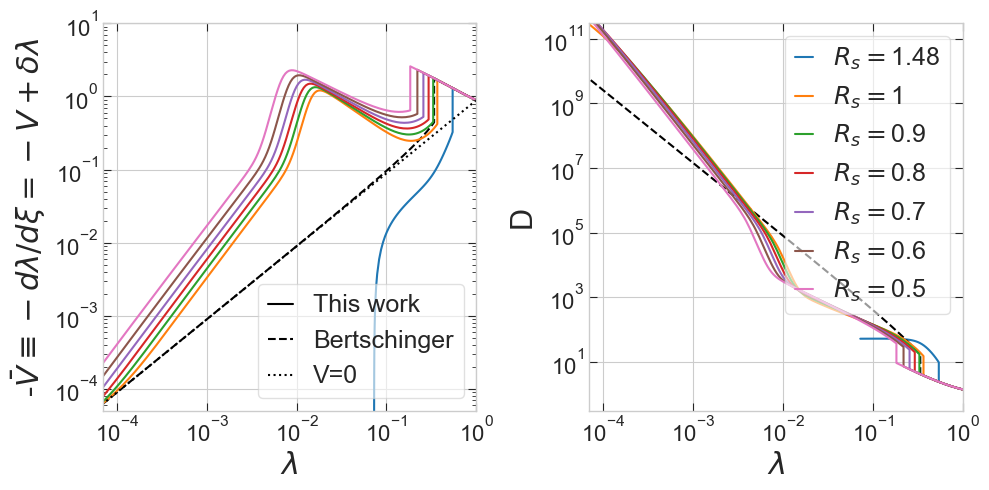

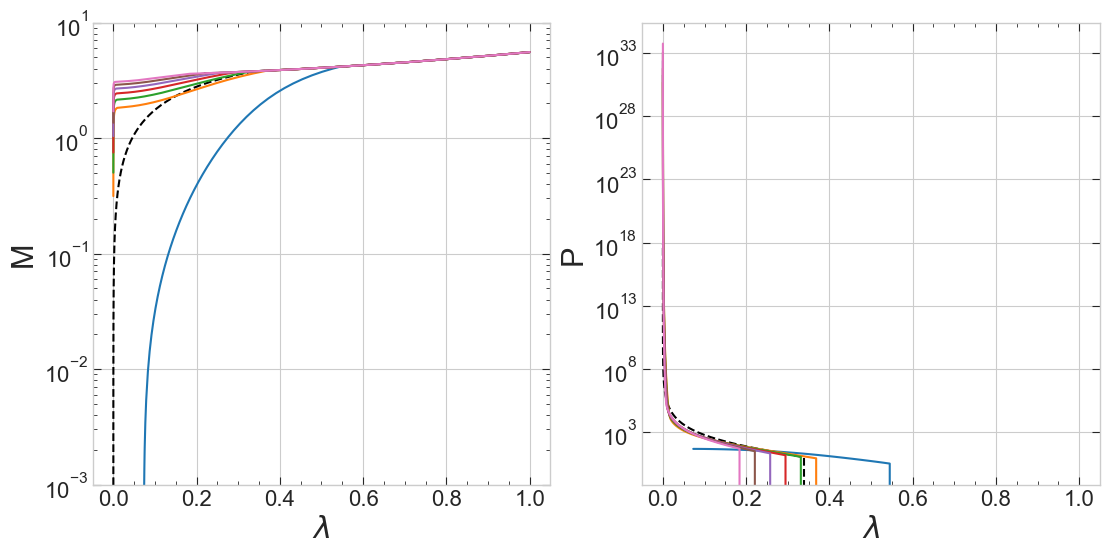

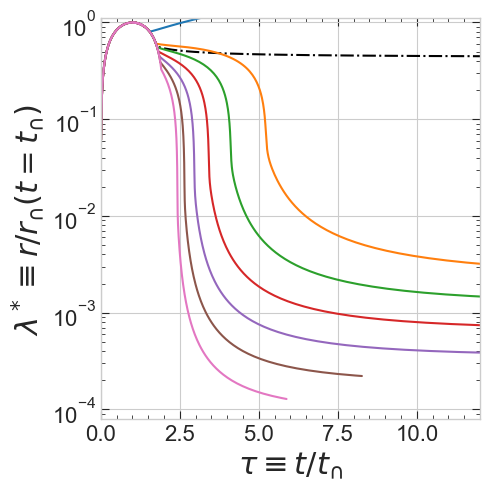

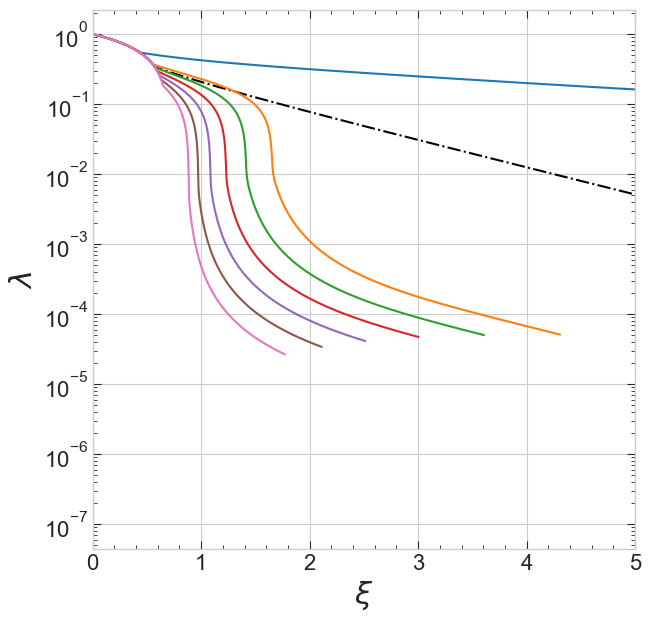

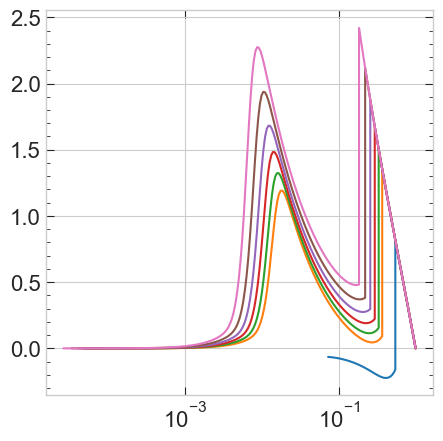

In [23]:
name = 'cold_vary-s'
name = 'shocked_vary-s'
# name = 'shocked_vary-gam'
# name = 'shocked_vary-cooling'
# name = 'shocked_vary-lamdish'
name = 'shocked_vary-lamshsp'

with open(f'{name}-rads.txt', 'tr') as file: rads_list = np.array(eval(file.read()))

s = 1
gam = 5/3
Lam0 = 3e-2
nu=1/2
fb = 0.156837
# fb = 0.5
fd = (1-fb)

lamshsp = 0.9
disk_rad_by_shock = 0.05
lamdish = disk_rad_by_shock #*lamsh

varypars=[]

if name == 'cold_vary-s':
    s_vals = [0.5,1,1.5,2,3,]
    varypars += ['s']
    lamshsp = 0.1
    lamdish = 0.5

if name == 'shocked_vary-s':
    s_vals = [0.5,1,2,]#[:-1]
    varypars += ['s']
    rads_list = rads_list[[0,1,3]]

if name == 'shocked_vary-gam':
    gam_vals= [2,1.8,5/3,1.5,7/5,4/3,]
    lamshsp_vals = [1.2,1.05,0.9,0.7,0.5,0.3]
    varypars += ['gam','lamshsp']

if name == 'shocked_vary-cooling':
    Lam0_vals = [1e-3,3e-3,1e-2,3e-2,1e-1,3e-1]
    varypars += ['Lam0']

if name == 'shocked_vary-lamdish':
    lamdish_vals = [percent/100 for percent in [2,5,10,15,25]]
    varypars += ['lamdish']

if name == 'shocked_vary-lamshsp':
    lamshsp_vals = [1.48,1,.9,.8,.7,.6,.5]#[0.35,0.3,0.25, 0.2]
    varypars += ['lamshsp']


fig5, axs5 = plt.subplots(1,2, dpi=100, figsize=(10,5), sharex=True)
fig51, axs51 = plt.subplots(1,2, dpi=100, figsize=(13,6), sharex=True)
axs5 = np.vstack([axs5,axs51])
fig6, ax6 = plt.subplots(1, dpi=100, figsize=(5,5))
fig62, ax62 = plt.subplots(1, dpi=100, figsize=(7,7))
fig7, ax7 = plt.subplots(1, dpi=100, figsize=(5,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(20):
    plab=''
    try:
        if 'gam' in varypars: gam = gam_vals[i]; plab+=r'$\gamma=$'+f"{gam:.3g}"
        if 's' in varypars: s = s_vals[i]; plab+=f"s={s} "
        if 'lamshsp' in varypars: lamshsp = lamshsp_vals[i]
        if 'lamshsp' in varypars[:1]: plab+=r'$R_s=$'+f'{lamshsp:g}'#plab+=r'$\lambda_s=$'+f'{lamshsp*100:g} '+r'$\%~ \lambda_{sp}$'
        if 'lamdish' in varypars: lamdish = lamdish_vals[i]; plab+=r'$\lambda_d=$'+f'{lamdish*100:g} '+r'$\%~ \lambda_s$'
        if 'Lam0' in varypars: Lam0 = Lam0_vals[i]; plab+=r'$\Lambda_0=$'+f'{Lam0:g} '
        # if 'nu' in varypars: nu = nu_vals[i]; plab+=r'$\nu=$'+f'{nu} '
    except IndexError: break

    t_now = time()
    de = 2* (1+s/3) /3
    alpha_D = -9/(s+3)
    descr = f'_{name}_lamshsp={lamshsp:.3g}_s={s:.2g}_gam={gam:.3g}_lamdish={lamdish:.3g}_Lam0={Lam0:.1e}_nu={nu:.1g}'

    resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm{descr}.hdf5', key=f'gas/iter0', mode='r')
    # lamsh = resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()]
    lamsh = lamshsp*rads_list[i][2] #rads_list[i][1]  #
    lamdi = lamdish*lamsh
    
    # lamshsol = 0.35 #lamsh_sols[s] #+5e-3 # 0.338976 #
    res_pre, res_post = get_soln_gas_full(lamsh)
    print(res_post.y[2][-1])
    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock profiles obtained')

    lamsh_pre = res_pre.t
    V_pre, D_pre, M_pre = res_pre.y

    lamsh_post = np.exp(res_post.t)
    mVb_post, D_post, M_post, P_post = np.exp(res_post.y)
    V_post = de*lamsh_post - mVb_post
    P_pre = lamsh_pre*0

    lamsh = lamsh_pre.min()
    # lam_all = lamsh_pre
    # V_all = V_pre
    # D_all = D_pre
    # M_all = M_pre
    # P_all = P_pre

    lam_all = np.concatenate([lamsh_post, lamsh_pre][::-1])
    V_all = np.concatenate([V_post, V_pre][::-1])
    D_all = np.concatenate([D_post, D_pre][::-1])
    M_all = np.concatenate([M_post, M_pre][::-1])
    P_all = np.concatenate([P_post, P_pre][::-1])
    Vb_all = V_all - de*lam_all

    color_this = colors[i] #plt.cm.turbo(s/4)

    ax7.plot(lam_all,-V_all, color=color_this)
    ax7.set_xscale('log')

    axs5[0,0].plot(lam_all,-Vb_all, color=color_this)
    axs5[0,1].plot(lam_all,D_all, color=color_this, label=plab)
    axs5[1,0].plot(lam_all,M_all, color=color_this)
    axs5[1,1].plot(lam_all,P_all, color=color_this)
    # axs5[0,2].plot(lam_all, P_all/D_all, color=color_this)
    # axs5[1,2].plot(lam_all, P_all/D_all**gam, color=color_this)
    # axs5[1,2].plot(lam_all, D_all*Vb_all**2-gam*P_all, color=color_this)

    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm_shocked_vary-s_lamshsp=0.9_s={s:.2g}_gam={gam:.3g}_lamdish=0.05_Lam0=3.0e-02_nu=0.5.hdf5', key=f'gas/main', mode='r')
    bertshi_vary = True if name.split('-')[-1] in ['gam','s'] else False
    color_this_bertshi = color_this if bertshi_vary else 'k'
    if bertshi_vary or i==0:
        axs5[0,0].plot(resdf_prof_gaso_bertshi.l, -resdf_prof_gaso_bertshi.Vb, color=color_this_bertshi, ls='--')
        axs5[0,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.D, color=color_this_bertshi, ls='--')
        axs5[1,0].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.M, color=color_this_bertshi, ls='--')
        axs5[1,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.P, color=color_this_bertshi, ls='--')
        print(resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()])
    # PderD_post = np.gradient(P_post,lamsh_post)/D_post

    M_intrp = interp1d(lam_all, M_all, fill_value="extrapolate")
    D_intrp = interp1d(lam_all, D_all, fill_value="extrapolate")
    V_intrp = interp1d(lam_all, V_all, fill_value="extrapolate")
    irem = P_pre.shape[0]-1
    # PderD_intrp = interp1d(np.delete(lam_all,irem), np.delete(PderD_all,irem), kind='linear', fill_value="extrapolate")

    # PderD_intrp = interp1d(lamsh_post, PderD_post, kind='linear', fill_value=0, bounds_error=False)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: all profiles obtained')

    def odefunc_traj(xi, arg):
        lam = arg
        return V_intrp(lam)-de*lam

    # taush = (thtshsol - np.sin(thtshsol)) / np.pi
    # xish = np.log(taush)
    # res = solve_ivp(odefunc_traj, (0,5), (1,), method='Radau', max_step=0.01, dense_output=False, vectorized=True)
    # res1 = solve_ivp(fun, (res.t[-1],15), np.array([res.y[0][-1],-res.y[1][-1]]), max_step=0.1, dense_output=True)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock trajectory obtained')
    
    # xires = res.t
    # lamres = res.y[0]
    # vres = res.y[1]
    xires,lamres = cumtrapz(1/(V_all-de*lam_all), x=lam_all), lam_all[1:]

    taures = np.exp(xires)
    lamFres = lamres*taures**de

    ax6.plot(taures,lamFres, color=color_this, label=plab)
    ax62.plot(xires,lamres, color=color_this)
    xio,lamo = cumtrapz(1/(resdf_prof_gaso_bertshi.V-de*resdf_prof_gaso_bertshi.l), x=resdf_prof_gaso_bertshi.l), resdf_prof_gaso_bertshi.l[1:]
    tauo = np.exp(xio)
    lamFo = lamo*tauo**de
    if bertshi_vary or i==0:
        ax62.plot(xio,lamo, c=color_this_bertshi, ls='-.')
        ax6.plot(tauo,lamFo, color=color_this_bertshi, ls='-.')

    #trajectory analytical
    thet_range = np.linspace(0.5, 1.2*np.pi,2000)
    tau_anlt = (thet_range - np.sin(thet_range)) / np.pi
    xi_anlt = np.log(tau_anlt)
    lam_anlt = preshock(thet_range)[0]
    lamF_anlt = lam_anlt*tau_anlt**de

    # ax6.plot(xi_anlt, lam_anlt, color=color_this)
    ax6.plot(tau_anlt, lamF_anlt, color=color_this)
    
    # dmo_prfl = pd.read_hdf(f'profiles_dmo_{s}.hdf5')

    # Mta = (3*np.pi/4)**2
    # M_dmo = interp1d(dmo_prfl['l'], dmo_prfl['M']*Mta, fill_value="extrapolate")
    # D_dmo = interp1d(dmo_prfl['l'].iloc[1:], dmo_prfl['rho'].iloc[1:], fill_value="extrapolate")

    # axs5[1,0].plot(lam_all, M_dmo(lam_all), color=color_this, ls='dashed')
    if name.split('_')[-1] =='vary-s':
        axs5[0,0].plot(lam_all,de*lam_all, c=color_this, ls=':')

#Loop ends

axs5[0,0].plot([],[], c='k', ls='-', label='This work')
axs5[0,0].plot([],[], c='k', ls='--', label='Bertschinger')
if name.split('_')[-1] !='vary-s':
    axs5[0,0].plot(lam_all,de*lam_all, c='k', ls=':', label='V=0')
else:
    axs5[0,0].plot([],[], c='k', ls=':', label='V=0')

# ax6.legend(loc='best',frameon=True, framealpha=0.6)
ax6.set_xlabel(r'$\tau \equiv t/t_{\cap}$')
ax6.set_ylabel(r'$\lambda^*\equiv r/r_{\cap}(t=t_{\cap})$')
ax6.set_xlim(0,12)
ax6.set_ylim(0.00008,1.1)
# ax6.set_xscale('log')
ax6.set_yscale('log')

ax62.set_xlabel(r'$\xi$')
ax62.set_ylabel('$\lambda$')
# ax62.set_xlim(,)
# ax62.set_ylim(0.01,1.1)
ax62.set_yscale('log')
    
axs5[0,0].set_xscale('log')
axs5[0,0].set_xlim(1e-5,1)
if name in ['shocked_vary-s','shocked_vary-lamshsp', 'shocked_vary-gam','cold_vary-s']:
    axs5[0,0].legend(loc='best', frameon=True, framealpha=0.6, handlelength=1)
axs5[0,1].legend(loc='best', frameon=True, framealpha=0.6, handlelength=0.7)
if name=='cold_vary-s':
    axs5[0,1].text(1e-3,1e9,'$R_s=0.1$', fontsize=15)
# axs5[0,1].legend()
axs5[0,0].set_xlabel('$\lambda$')
axs5[0,1].set_xlabel('$\lambda$')
axs5[1,0].set_xlabel('$\lambda$')
axs5[1,1].set_xlabel('$\lambda$')
# axs5[1,2].set_xlabel('$\lambda$')

# if gam==5/3:
#     axs5[0,0].set_xlim(7e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e-1,1e11)
#     axs5[1,0].set_ylim(1e-3,1e1)
#     # axs5[1,1].set_ylim(1e0,1e14)
#     # axs5[0,2].set_ylim(1e-1,1e2)
#     # axs5[1,2].set_ylim(1e-5,5e-1)
# elif gam==4/3:
#     axs5[0,0].set_xlim(1e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e0,1e11)
#     axs5[1,0].set_ylim(1e-2,1e1)
#     axs5[1,1].set_ylim(1e1,1e14)
#     # axs5[0,2].set_ylim(1e0,1e3)
#     # axs5[1,2].set_ylim(1e-2,5e-1)

axs5[0,0].set_xlim(7e-5,1)
axs5[0,0].set_ylim(5e-5,1e1)
axs5[0,1].set_ylim(3e-1,3e11)
axs5[1,0].set_ylim(1e-3,1e1)
# axs5[1,1].set_ylim(1e0,1e14)


axs5[0,0].set_ylabel(r'-$\bar{V} \equiv -d \lambda/d \xi = -V + \delta \lambda$')
axs5[0,1].set_ylabel('D')
axs5[1,0].set_ylabel('M')
axs5[1,1].set_ylabel('P')
# axs5[0,2].set_ylabel('T')
# axs5[1,2].set_ylabel('K')

axs5[0,0].set_yscale('log')
axs5[0,1].set_yscale('log')
axs5[1,0].set_yscale('log')
axs5[1,1].set_yscale('log')
ax62.set_xlim(0,5)
# axs5[0,2].set_yscale('log')
# axs5[1,2].set_yscale('log')

if name in ['shocked_vary-gam','shocked_vary-cooling']:
    axs5[0,0].set_ylabel(r'-$\bar{V}$')
    ax6.set_ylabel(r'$\lambda^*$')
# axs5[0,0].xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10,subs=np.arange(-4, 1)))
# axs5[0,0].xaxis.get_ticklocs(minor=True)
# axs5[0,0].minorticks_on()
# axs5[0,0].xaxis.set_tick_params(which='minor', bottom=True)

# # Additional lines to set major xticks
# axs5[0, 0].xaxis.set_major_locator(mpl.ticker.LogLocator(base=10, subs=np.arange(-4, 1,0.01)))
# axs5[0, 0].xaxis.get_ticklocs()

axs5[0,0].set_xticks([1e-4,1e-3,1e-2,1e-1,1])

fig5.tight_layout()
fig6.tight_layout()

fig5.savefig(f'Eds-gaso_profiles_{name}.pdf')
fig6.savefig(f'Eds-gaso_trajectory_{name}.pdf')
# axs5[0,0].set_xlim(1e-6,1)
# axs5[1,0].set_ylim(1e-4,1e1)

-11.284487365816181
0.366s s=1: post shock profiles obtained
0.33897639819093084
0.0163s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-1.156491327573961
0.2525s s=1: post shock profiles obtained
0.0006804s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-0.6890849368141942
0.311s s=1: post shock profiles obtained
0.004999s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-0.28752288100843615
0.2482s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.03897516321836761
0.2324s s=1: post shock profiles obtained
0.005018s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.30693921668639257
0.2106s s=1: post shock profiles obtained
0.006184s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.5339671828938729
0.2033s s=1: post shock profiles obtained
0.01563s s=1: all profiles obtained
0s s=1: post shock trajectory obtained


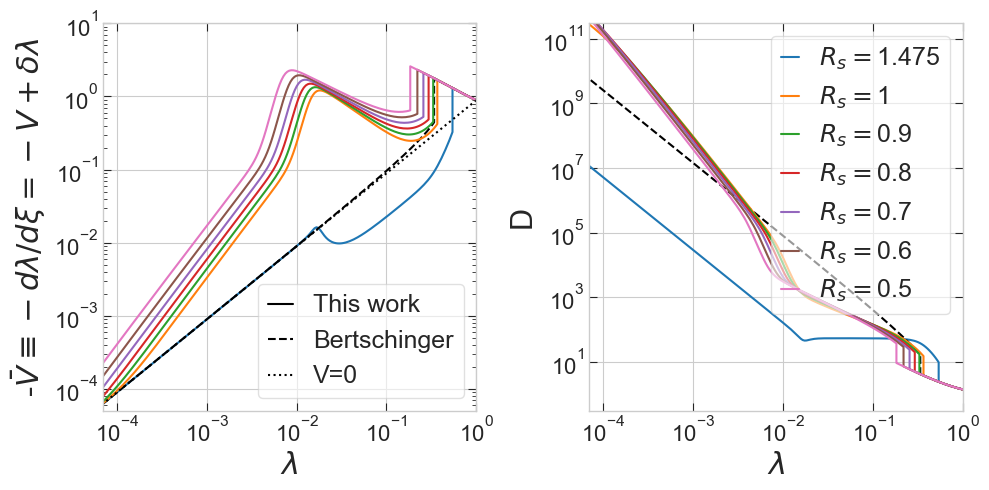

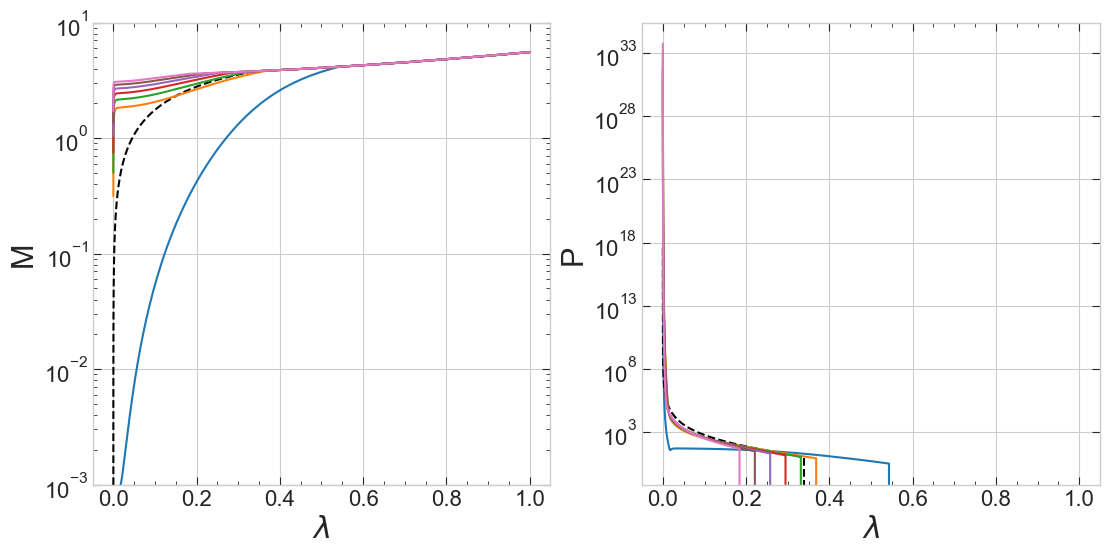

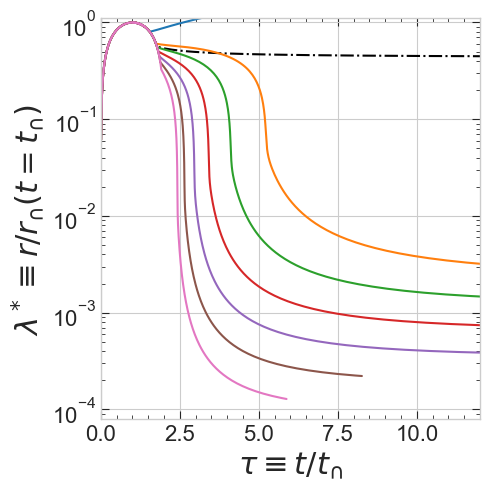

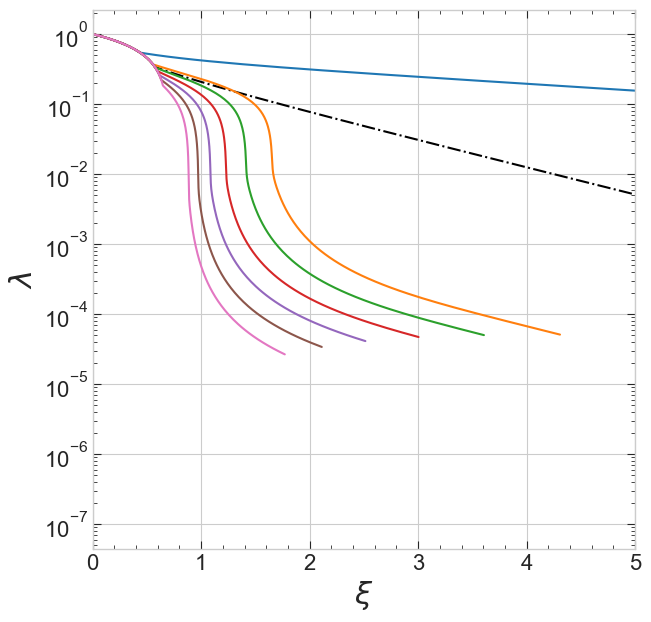

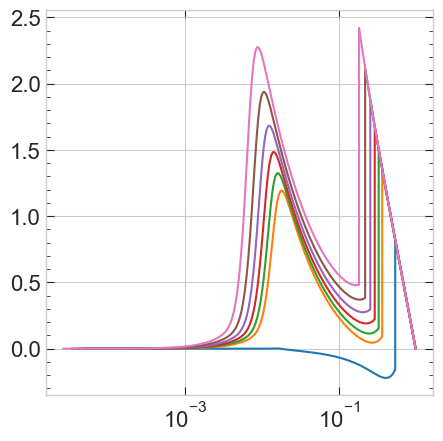

In [24]:
name = 'cold_vary-s'
name = 'shocked_vary-s'
# name = 'shocked_vary-gam'
# name = 'shocked_vary-cooling'
# name = 'shocked_vary-lamdish'
name = 'shocked_vary-lamshsp'

with open(f'{name}-rads.txt', 'tr') as file: rads_list = np.array(eval(file.read()))

s = 1
gam = 5/3
Lam0 = 3e-2
nu=1/2
fb = 0.156837
# fb = 0.5
fd = (1-fb)

lamshsp = 0.9
disk_rad_by_shock = 0.05
lamdish = disk_rad_by_shock #*lamsh

varypars=[]

if name == 'cold_vary-s':
    s_vals = [0.5,1,1.5,2,3,]
    varypars += ['s']
    lamshsp = 0.1
    lamdish = 0.5

if name == 'shocked_vary-s':
    s_vals = [0.5,1,2,]#[:-1]
    varypars += ['s']
    rads_list = rads_list[[0,1,3]]

if name == 'shocked_vary-gam':
    gam_vals= [2,1.8,5/3,1.5,7/5,4/3,]
    lamshsp_vals = [1.2,1.05,0.9,0.7,0.5,0.3]
    varypars += ['gam','lamshsp']

if name == 'shocked_vary-cooling':
    Lam0_vals = [1e-3,3e-3,1e-2,3e-2,1e-1,3e-1]
    varypars += ['Lam0']

if name == 'shocked_vary-lamdish':
    lamdish_vals = [percent/100 for percent in [2,5,10,15,25]]
    varypars += ['lamdish']

if name == 'shocked_vary-lamshsp':
    lamshsp_vals = [1.475,1,.9,.8,.7,.6,.5]#[0.35,0.3,0.25, 0.2]
    varypars += ['lamshsp']


fig5, axs5 = plt.subplots(1,2, dpi=100, figsize=(10,5), sharex=True)
fig51, axs51 = plt.subplots(1,2, dpi=100, figsize=(13,6), sharex=True)
axs5 = np.vstack([axs5,axs51])
fig6, ax6 = plt.subplots(1, dpi=100, figsize=(5,5))
fig62, ax62 = plt.subplots(1, dpi=100, figsize=(7,7))
fig7, ax7 = plt.subplots(1, dpi=100, figsize=(5,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(20):
    plab=''
    try:
        if 'gam' in varypars: gam = gam_vals[i]; plab+=r'$\gamma=$'+f"{gam:.3g}"
        if 's' in varypars: s = s_vals[i]; plab+=f"s={s} "
        if 'lamshsp' in varypars: lamshsp = lamshsp_vals[i]
        if 'lamshsp' in varypars[:1]: plab+=r'$R_s=$'+f'{lamshsp:g}'#plab+=r'$\lambda_s=$'+f'{lamshsp*100:g} '+r'$\%~ \lambda_{sp}$'
        if 'lamdish' in varypars: lamdish = lamdish_vals[i]; plab+=r'$\lambda_d=$'+f'{lamdish*100:g} '+r'$\%~ \lambda_s$'
        if 'Lam0' in varypars: Lam0 = Lam0_vals[i]; plab+=r'$\Lambda_0=$'+f'{Lam0:g} '
        # if 'nu' in varypars: nu = nu_vals[i]; plab+=r'$\nu=$'+f'{nu} '
    except IndexError: break

    t_now = time()
    de = 2* (1+s/3) /3
    alpha_D = -9/(s+3)
    descr = f'_{name}_lamshsp={lamshsp:.3g}_s={s:.2g}_gam={gam:.3g}_lamdish={lamdish:.3g}_Lam0={Lam0:.1e}_nu={nu:.1g}'

    resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm{descr}.hdf5', key=f'gas/iter0', mode='r')
    # lamsh = resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()]
    lamsh = lamshsp*rads_list[i][2] #rads_list[i][1]  #
    lamdi = lamdish*lamsh
    
    # lamshsol = 0.35 #lamsh_sols[s] #+5e-3 # 0.338976 #
    res_pre, res_post = get_soln_gas_full(lamsh)
    print(res_post.y[2][-1])
    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock profiles obtained')

    lamsh_pre = res_pre.t
    V_pre, D_pre, M_pre = res_pre.y

    lamsh_post = np.exp(res_post.t)
    mVb_post, D_post, M_post, P_post = np.exp(res_post.y)
    V_post = de*lamsh_post - mVb_post
    P_pre = lamsh_pre*0

    lamsh = lamsh_pre.min()
    # lam_all = lamsh_pre
    # V_all = V_pre
    # D_all = D_pre
    # M_all = M_pre
    # P_all = P_pre

    lam_all = np.concatenate([lamsh_post, lamsh_pre][::-1])
    V_all = np.concatenate([V_post, V_pre][::-1])
    D_all = np.concatenate([D_post, D_pre][::-1])
    M_all = np.concatenate([M_post, M_pre][::-1])
    P_all = np.concatenate([P_post, P_pre][::-1])
    Vb_all = V_all - de*lam_all

    color_this = colors[i] #plt.cm.turbo(s/4)

    ax7.plot(lam_all,-V_all, color=color_this)
    ax7.set_xscale('log')

    axs5[0,0].plot(lam_all,-Vb_all, color=color_this)
    axs5[0,1].plot(lam_all,D_all, color=color_this, label=plab)
    axs5[1,0].plot(lam_all,M_all, color=color_this)
    axs5[1,1].plot(lam_all,P_all, color=color_this)
    # axs5[0,2].plot(lam_all, P_all/D_all, color=color_this)
    # axs5[1,2].plot(lam_all, P_all/D_all**gam, color=color_this)
    # axs5[1,2].plot(lam_all, D_all*Vb_all**2-gam*P_all, color=color_this)

    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm_shocked_vary-s_lamshsp=0.9_s={s:.2g}_gam={gam:.3g}_lamdish=0.05_Lam0=3.0e-02_nu=0.5.hdf5', key=f'gas/main', mode='r')
    bertshi_vary = True if name.split('-')[-1] in ['gam','s'] else False
    color_this_bertshi = color_this if bertshi_vary else 'k'
    if bertshi_vary or i==0:
        axs5[0,0].plot(resdf_prof_gaso_bertshi.l, -resdf_prof_gaso_bertshi.Vb, color=color_this_bertshi, ls='--')
        axs5[0,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.D, color=color_this_bertshi, ls='--')
        axs5[1,0].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.M, color=color_this_bertshi, ls='--')
        axs5[1,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.P, color=color_this_bertshi, ls='--')
        print(resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()])
    # PderD_post = np.gradient(P_post,lamsh_post)/D_post

    M_intrp = interp1d(lam_all, M_all, fill_value="extrapolate")
    D_intrp = interp1d(lam_all, D_all, fill_value="extrapolate")
    V_intrp = interp1d(lam_all, V_all, fill_value="extrapolate")
    irem = P_pre.shape[0]-1
    # PderD_intrp = interp1d(np.delete(lam_all,irem), np.delete(PderD_all,irem), kind='linear', fill_value="extrapolate")

    # PderD_intrp = interp1d(lamsh_post, PderD_post, kind='linear', fill_value=0, bounds_error=False)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: all profiles obtained')

    def odefunc_traj(xi, arg):
        lam = arg
        return V_intrp(lam)-de*lam

    # taush = (thtshsol - np.sin(thtshsol)) / np.pi
    # xish = np.log(taush)
    # res = solve_ivp(odefunc_traj, (0,5), (1,), method='Radau', max_step=0.01, dense_output=False, vectorized=True)
    # res1 = solve_ivp(fun, (res.t[-1],15), np.array([res.y[0][-1],-res.y[1][-1]]), max_step=0.1, dense_output=True)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock trajectory obtained')
    
    # xires = res.t
    # lamres = res.y[0]
    # vres = res.y[1]
    xires,lamres = cumtrapz(1/(V_all-de*lam_all), x=lam_all), lam_all[1:]

    taures = np.exp(xires)
    lamFres = lamres*taures**de

    ax6.plot(taures,lamFres, color=color_this, label=plab)
    ax62.plot(xires,lamres, color=color_this)
    xio,lamo = cumtrapz(1/(resdf_prof_gaso_bertshi.V-de*resdf_prof_gaso_bertshi.l), x=resdf_prof_gaso_bertshi.l), resdf_prof_gaso_bertshi.l[1:]
    tauo = np.exp(xio)
    lamFo = lamo*tauo**de
    if bertshi_vary or i==0:
        ax62.plot(xio,lamo, c=color_this_bertshi, ls='-.')
        ax6.plot(tauo,lamFo, color=color_this_bertshi, ls='-.')

    #trajectory analytical
    thet_range = np.linspace(0.5, 1.2*np.pi,2000)
    tau_anlt = (thet_range - np.sin(thet_range)) / np.pi
    xi_anlt = np.log(tau_anlt)
    lam_anlt = preshock(thet_range)[0]
    lamF_anlt = lam_anlt*tau_anlt**de

    # ax6.plot(xi_anlt, lam_anlt, color=color_this)
    ax6.plot(tau_anlt, lamF_anlt, color=color_this)
    
    # dmo_prfl = pd.read_hdf(f'profiles_dmo_{s}.hdf5')

    # Mta = (3*np.pi/4)**2
    # M_dmo = interp1d(dmo_prfl['l'], dmo_prfl['M']*Mta, fill_value="extrapolate")
    # D_dmo = interp1d(dmo_prfl['l'].iloc[1:], dmo_prfl['rho'].iloc[1:], fill_value="extrapolate")

    # axs5[1,0].plot(lam_all, M_dmo(lam_all), color=color_this, ls='dashed')
    if name.split('_')[-1] =='vary-s':
        axs5[0,0].plot(lam_all,de*lam_all, c=color_this, ls=':')

#Loop ends

axs5[0,0].plot([],[], c='k', ls='-', label='This work')
axs5[0,0].plot([],[], c='k', ls='--', label='Bertschinger')
if name.split('_')[-1] !='vary-s':
    axs5[0,0].plot(lam_all,de*lam_all, c='k', ls=':', label='V=0')
else:
    axs5[0,0].plot([],[], c='k', ls=':', label='V=0')

# ax6.legend(loc='best',frameon=True, framealpha=0.6)
ax6.set_xlabel(r'$\tau \equiv t/t_{\cap}$')
ax6.set_ylabel(r'$\lambda^*\equiv r/r_{\cap}(t=t_{\cap})$')
ax6.set_xlim(0,12)
ax6.set_ylim(0.00008,1.1)
# ax6.set_xscale('log')
ax6.set_yscale('log')

ax62.set_xlabel(r'$\xi$')
ax62.set_ylabel('$\lambda$')
# ax62.set_xlim(,)
# ax62.set_ylim(0.01,1.1)
ax62.set_yscale('log')
    
axs5[0,0].set_xscale('log')
axs5[0,0].set_xlim(1e-5,1)
if name in ['shocked_vary-s','shocked_vary-lamshsp', 'shocked_vary-gam','cold_vary-s']:
    axs5[0,0].legend(loc='best', frameon=True, framealpha=0.6, handlelength=1)
axs5[0,1].legend(loc='best', frameon=True, framealpha=0.6, handlelength=0.7)
if name=='cold_vary-s':
    axs5[0,1].text(1e-3,1e9,'$R_s=0.1$', fontsize=15)
# axs5[0,1].legend()
axs5[0,0].set_xlabel('$\lambda$')
axs5[0,1].set_xlabel('$\lambda$')
axs5[1,0].set_xlabel('$\lambda$')
axs5[1,1].set_xlabel('$\lambda$')
# axs5[1,2].set_xlabel('$\lambda$')

# if gam==5/3:
#     axs5[0,0].set_xlim(7e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e-1,1e11)
#     axs5[1,0].set_ylim(1e-3,1e1)
#     # axs5[1,1].set_ylim(1e0,1e14)
#     # axs5[0,2].set_ylim(1e-1,1e2)
#     # axs5[1,2].set_ylim(1e-5,5e-1)
# elif gam==4/3:
#     axs5[0,0].set_xlim(1e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e0,1e11)
#     axs5[1,0].set_ylim(1e-2,1e1)
#     axs5[1,1].set_ylim(1e1,1e14)
#     # axs5[0,2].set_ylim(1e0,1e3)
#     # axs5[1,2].set_ylim(1e-2,5e-1)

axs5[0,0].set_xlim(7e-5,1)
axs5[0,0].set_ylim(5e-5,1e1)
axs5[0,1].set_ylim(3e-1,3e11)
axs5[1,0].set_ylim(1e-3,1e1)
# axs5[1,1].set_ylim(1e0,1e14)


axs5[0,0].set_ylabel(r'-$\bar{V} \equiv -d \lambda/d \xi = -V + \delta \lambda$')
axs5[0,1].set_ylabel('D')
axs5[1,0].set_ylabel('M')
axs5[1,1].set_ylabel('P')
# axs5[0,2].set_ylabel('T')
# axs5[1,2].set_ylabel('K')

axs5[0,0].set_yscale('log')
axs5[0,1].set_yscale('log')
axs5[1,0].set_yscale('log')
axs5[1,1].set_yscale('log')
ax62.set_xlim(0,5)
# axs5[0,2].set_yscale('log')
# axs5[1,2].set_yscale('log')

if name in ['shocked_vary-gam','shocked_vary-cooling']:
    axs5[0,0].set_ylabel(r'-$\bar{V}$')
    ax6.set_ylabel(r'$\lambda^*$')
# axs5[0,0].xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10,subs=np.arange(-4, 1)))
# axs5[0,0].xaxis.get_ticklocs(minor=True)
# axs5[0,0].minorticks_on()
# axs5[0,0].xaxis.set_tick_params(which='minor', bottom=True)

# # Additional lines to set major xticks
# axs5[0, 0].xaxis.set_major_locator(mpl.ticker.LogLocator(base=10, subs=np.arange(-4, 1,0.01)))
# axs5[0, 0].xaxis.get_ticklocs()

axs5[0,0].set_xticks([1e-4,1e-3,1e-2,1e-1,1])

fig5.tight_layout()
fig6.tight_layout()

fig5.savefig(f'Eds-gaso_profiles_{name}.pdf')
fig6.savefig(f'Eds-gaso_trajectory_{name}.pdf')
# axs5[0,0].set_xlim(1e-6,1)
# axs5[1,0].set_ylim(1e-4,1e1)

-3.8778415139669007
0.08148s s=1: post shock profiles obtained
0.33897639819093084
0.014s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-5.646459767280796
0.1127s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-3.4465142790322973
0.2833s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-2.4003654080751904
0.2838s s=1: post shock profiles obtained
0.003016s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-1.8159467151107633
0.2358s s=1: post shock profiles obtained
0.001364s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-1.3170926987019245
0.2234s s=1: post shock profiles obtained
0.008915s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-0.8118297911144993
0.1988s s=1: post shock profiles obtained
0s s=1: all profiles obtained
0s s=1: post shock trajectory obtained


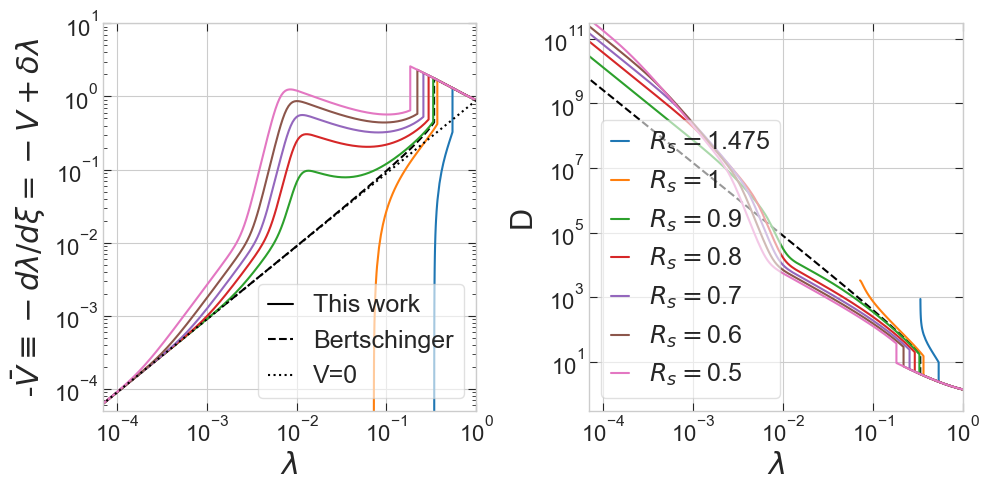

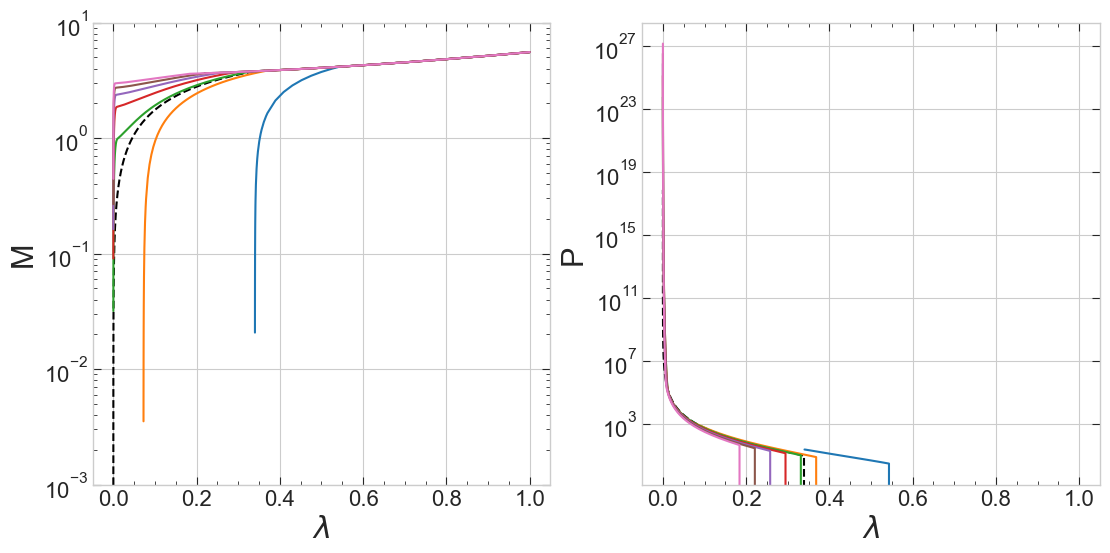

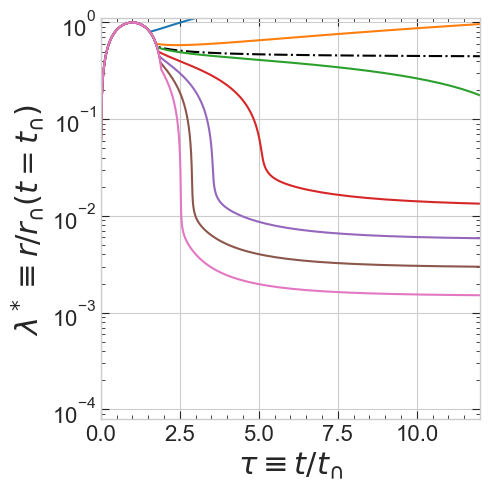

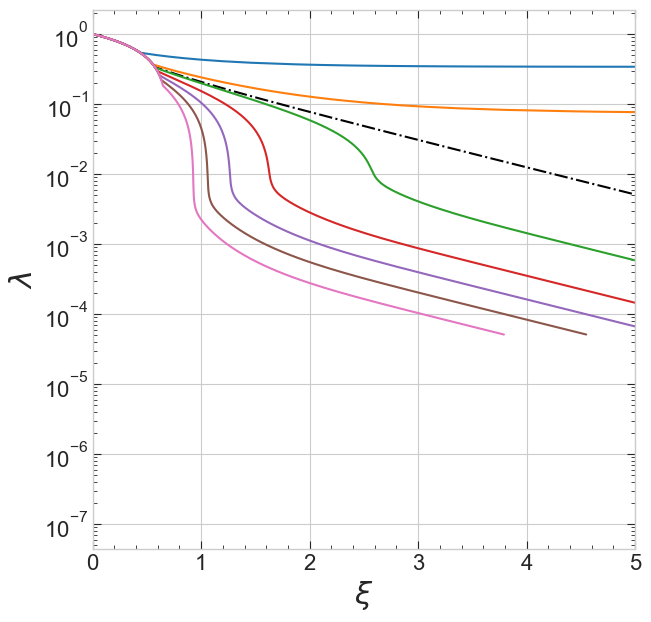

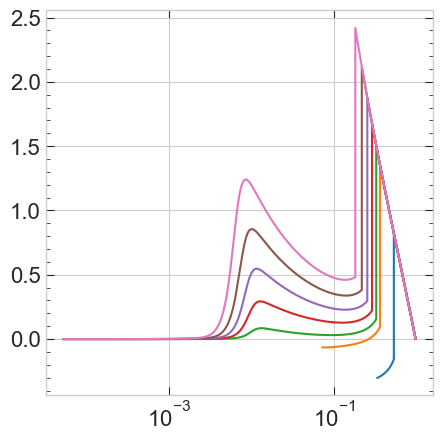

In [25]:
name = 'cold_vary-s'
name = 'shocked_vary-s'
# name = 'shocked_vary-gam'
# name = 'shocked_vary-cooling'
# name = 'shocked_vary-lamdish'
name = 'shocked_vary-lamshsp'

with open(f'{name}-rads.txt', 'tr') as file: rads_list = np.array(eval(file.read()))

s = 1
gam = 5/3
Lam0 = 3e-4
nu=1/2
fb = 0.156837
# fb = 0.5
fd = (1-fb)

lamshsp = 0.9
disk_rad_by_shock = 0.05
lamdish = disk_rad_by_shock #*lamsh

varypars=[]

if name == 'cold_vary-s':
    s_vals = [0.5,1,1.5,2,3,]
    varypars += ['s']
    lamshsp = 0.1
    lamdish = 0.5

if name == 'shocked_vary-s':
    s_vals = [0.5,1,2,]#[:-1]
    varypars += ['s']
    rads_list = rads_list[[0,1,3]]

if name == 'shocked_vary-gam':
    gam_vals= [2,1.8,5/3,1.5,7/5,4/3,]
    lamshsp_vals = [1.2,1.05,0.9,0.7,0.5,0.3]
    varypars += ['gam','lamshsp']

if name == 'shocked_vary-cooling':
    Lam0_vals = [1e-3,3e-3,1e-2,3e-2,1e-1,3e-1]
    varypars += ['Lam0']

if name == 'shocked_vary-lamdish':
    lamdish_vals = [percent/100 for percent in [2,5,10,15,25]]
    varypars += ['lamdish']

if name == 'shocked_vary-lamshsp':
    lamshsp_vals = [1.475,1,.9,.8,.7,.6,.5]#[0.35,0.3,0.25, 0.2]
    varypars += ['lamshsp']


fig5, axs5 = plt.subplots(1,2, dpi=100, figsize=(10,5), sharex=True)
fig51, axs51 = plt.subplots(1,2, dpi=100, figsize=(13,6), sharex=True)
axs5 = np.vstack([axs5,axs51])
fig6, ax6 = plt.subplots(1, dpi=100, figsize=(5,5))
fig62, ax62 = plt.subplots(1, dpi=100, figsize=(7,7))
fig7, ax7 = plt.subplots(1, dpi=100, figsize=(5,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(20):
    plab=''
    try:
        if 'gam' in varypars: gam = gam_vals[i]; plab+=r'$\gamma=$'+f"{gam:.3g}"
        if 's' in varypars: s = s_vals[i]; plab+=f"s={s} "
        if 'lamshsp' in varypars: lamshsp = lamshsp_vals[i]
        if 'lamshsp' in varypars[:1]: plab+=r'$R_s=$'+f'{lamshsp:g}'#plab+=r'$\lambda_s=$'+f'{lamshsp*100:g} '+r'$\%~ \lambda_{sp}$'
        if 'lamdish' in varypars: lamdish = lamdish_vals[i]; plab+=r'$\lambda_d=$'+f'{lamdish*100:g} '+r'$\%~ \lambda_s$'
        if 'Lam0' in varypars: Lam0 = Lam0_vals[i]; plab+=r'$\Lambda_0=$'+f'{Lam0:g} '
        # if 'nu' in varypars: nu = nu_vals[i]; plab+=r'$\nu=$'+f'{nu} '
    except IndexError: break

    t_now = time()
    de = 2* (1+s/3) /3
    alpha_D = -9/(s+3)
    descr = f'_{name}_lamshsp={lamshsp:.3g}_s={s:.2g}_gam={gam:.3g}_lamdish={lamdish:.3g}_Lam0={Lam0:.1e}_nu={nu:.1g}'

    resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm{descr}.hdf5', key=f'gas/iter0', mode='r')
    # lamsh = resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()]
    lamsh = lamshsp*rads_list[i][2] #rads_list[i][1]  #
    lamdi = lamdish*lamsh
    
    # lamshsol = 0.35 #lamsh_sols[s] #+5e-3 # 0.338976 #
    res_pre, res_post = get_soln_gas_full(lamsh)
    print(res_post.y[2][-1])
    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock profiles obtained')

    lamsh_pre = res_pre.t
    V_pre, D_pre, M_pre = res_pre.y

    lamsh_post = np.exp(res_post.t)
    mVb_post, D_post, M_post, P_post = np.exp(res_post.y)
    V_post = de*lamsh_post - mVb_post
    P_pre = lamsh_pre*0

    lamsh = lamsh_pre.min()
    # lam_all = lamsh_pre
    # V_all = V_pre
    # D_all = D_pre
    # M_all = M_pre
    # P_all = P_pre

    lam_all = np.concatenate([lamsh_post, lamsh_pre][::-1])
    V_all = np.concatenate([V_post, V_pre][::-1])
    D_all = np.concatenate([D_post, D_pre][::-1])
    M_all = np.concatenate([M_post, M_pre][::-1])
    P_all = np.concatenate([P_post, P_pre][::-1])
    Vb_all = V_all - de*lam_all

    color_this = colors[i] #plt.cm.turbo(s/4)

    ax7.plot(lam_all,-V_all, color=color_this)
    ax7.set_xscale('log')

    axs5[0,0].plot(lam_all,-Vb_all, color=color_this)
    axs5[0,1].plot(lam_all,D_all, color=color_this, label=plab)
    axs5[1,0].plot(lam_all,M_all, color=color_this)
    axs5[1,1].plot(lam_all,P_all, color=color_this)
    # axs5[0,2].plot(lam_all, P_all/D_all, color=color_this)
    # axs5[1,2].plot(lam_all, P_all/D_all**gam, color=color_this)
    # axs5[1,2].plot(lam_all, D_all*Vb_all**2-gam*P_all, color=color_this)

    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm_shocked_vary-s_lamshsp=0.9_s={s:.2g}_gam={gam:.3g}_lamdish=0.05_Lam0=3.0e-02_nu=0.5.hdf5', key=f'gas/main', mode='r')
    bertshi_vary = True if name.split('-')[-1] in ['gam','s'] else False
    color_this_bertshi = color_this if bertshi_vary else 'k'
    if bertshi_vary or i==0:
        axs5[0,0].plot(resdf_prof_gaso_bertshi.l, -resdf_prof_gaso_bertshi.Vb, color=color_this_bertshi, ls='--')
        axs5[0,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.D, color=color_this_bertshi, ls='--')
        axs5[1,0].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.M, color=color_this_bertshi, ls='--')
        axs5[1,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.P, color=color_this_bertshi, ls='--')
        print(resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()])
    # PderD_post = np.gradient(P_post,lamsh_post)/D_post

    M_intrp = interp1d(lam_all, M_all, fill_value="extrapolate")
    D_intrp = interp1d(lam_all, D_all, fill_value="extrapolate")
    V_intrp = interp1d(lam_all, V_all, fill_value="extrapolate")
    irem = P_pre.shape[0]-1
    # PderD_intrp = interp1d(np.delete(lam_all,irem), np.delete(PderD_all,irem), kind='linear', fill_value="extrapolate")

    # PderD_intrp = interp1d(lamsh_post, PderD_post, kind='linear', fill_value=0, bounds_error=False)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: all profiles obtained')

    def odefunc_traj(xi, arg):
        lam = arg
        return V_intrp(lam)-de*lam

    # taush = (thtshsol - np.sin(thtshsol)) / np.pi
    # xish = np.log(taush)
    # res = solve_ivp(odefunc_traj, (0,5), (1,), method='Radau', max_step=0.01, dense_output=False, vectorized=True)
    # res1 = solve_ivp(fun, (res.t[-1],15), np.array([res.y[0][-1],-res.y[1][-1]]), max_step=0.1, dense_output=True)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock trajectory obtained')
    
    # xires = res.t
    # lamres = res.y[0]
    # vres = res.y[1]
    xires,lamres = cumtrapz(1/(V_all-de*lam_all), x=lam_all), lam_all[1:]

    taures = np.exp(xires)
    lamFres = lamres*taures**de

    ax6.plot(taures,lamFres, color=color_this, label=plab)
    ax62.plot(xires,lamres, color=color_this)
    xio,lamo = cumtrapz(1/(resdf_prof_gaso_bertshi.V-de*resdf_prof_gaso_bertshi.l), x=resdf_prof_gaso_bertshi.l), resdf_prof_gaso_bertshi.l[1:]
    tauo = np.exp(xio)
    lamFo = lamo*tauo**de
    if bertshi_vary or i==0:
        ax62.plot(xio,lamo, c=color_this_bertshi, ls='-.')
        ax6.plot(tauo,lamFo, color=color_this_bertshi, ls='-.')

    #trajectory analytical
    thet_range = np.linspace(0.5, 1.2*np.pi,2000)
    tau_anlt = (thet_range - np.sin(thet_range)) / np.pi
    xi_anlt = np.log(tau_anlt)
    lam_anlt = preshock(thet_range)[0]
    lamF_anlt = lam_anlt*tau_anlt**de

    # ax6.plot(xi_anlt, lam_anlt, color=color_this)
    ax6.plot(tau_anlt, lamF_anlt, color=color_this)
    
    # dmo_prfl = pd.read_hdf(f'profiles_dmo_{s}.hdf5')

    # Mta = (3*np.pi/4)**2
    # M_dmo = interp1d(dmo_prfl['l'], dmo_prfl['M']*Mta, fill_value="extrapolate")
    # D_dmo = interp1d(dmo_prfl['l'].iloc[1:], dmo_prfl['rho'].iloc[1:], fill_value="extrapolate")

    # axs5[1,0].plot(lam_all, M_dmo(lam_all), color=color_this, ls='dashed')
    if name.split('_')[-1] =='vary-s':
        axs5[0,0].plot(lam_all,de*lam_all, c=color_this, ls=':')

#Loop ends

axs5[0,0].plot([],[], c='k', ls='-', label='This work')
axs5[0,0].plot([],[], c='k', ls='--', label='Bertschinger')
if name.split('_')[-1] !='vary-s':
    axs5[0,0].plot(lam_all,de*lam_all, c='k', ls=':', label='V=0')
else:
    axs5[0,0].plot([],[], c='k', ls=':', label='V=0')

# ax6.legend(loc='best',frameon=True, framealpha=0.6)
ax6.set_xlabel(r'$\tau \equiv t/t_{\cap}$')
ax6.set_ylabel(r'$\lambda^*\equiv r/r_{\cap}(t=t_{\cap})$')
ax6.set_xlim(0,12)
ax6.set_ylim(0.00008,1.1)
# ax6.set_xscale('log')
ax6.set_yscale('log')

ax62.set_xlabel(r'$\xi$')
ax62.set_ylabel('$\lambda$')
# ax62.set_xlim(,)
# ax62.set_ylim(0.01,1.1)
ax62.set_yscale('log')
    
axs5[0,0].set_xscale('log')
axs5[0,0].set_xlim(1e-5,1)
if name in ['shocked_vary-s','shocked_vary-lamshsp', 'shocked_vary-gam','cold_vary-s']:
    axs5[0,0].legend(loc='best', frameon=True, framealpha=0.6, handlelength=1)
axs5[0,1].legend(loc='best', frameon=True, framealpha=0.6, handlelength=0.7)
if name=='cold_vary-s':
    axs5[0,1].text(1e-3,1e9,'$R_s=0.1$', fontsize=15)
# axs5[0,1].legend()
axs5[0,0].set_xlabel('$\lambda$')
axs5[0,1].set_xlabel('$\lambda$')
axs5[1,0].set_xlabel('$\lambda$')
axs5[1,1].set_xlabel('$\lambda$')
# axs5[1,2].set_xlabel('$\lambda$')

# if gam==5/3:
#     axs5[0,0].set_xlim(7e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e-1,1e11)
#     axs5[1,0].set_ylim(1e-3,1e1)
#     # axs5[1,1].set_ylim(1e0,1e14)
#     # axs5[0,2].set_ylim(1e-1,1e2)
#     # axs5[1,2].set_ylim(1e-5,5e-1)
# elif gam==4/3:
#     axs5[0,0].set_xlim(1e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e0,1e11)
#     axs5[1,0].set_ylim(1e-2,1e1)
#     axs5[1,1].set_ylim(1e1,1e14)
#     # axs5[0,2].set_ylim(1e0,1e3)
#     # axs5[1,2].set_ylim(1e-2,5e-1)

axs5[0,0].set_xlim(7e-5,1)
axs5[0,0].set_ylim(5e-5,1e1)
axs5[0,1].set_ylim(3e-1,3e11)
axs5[1,0].set_ylim(1e-3,1e1)
# axs5[1,1].set_ylim(1e0,1e14)


axs5[0,0].set_ylabel(r'-$\bar{V} \equiv -d \lambda/d \xi = -V + \delta \lambda$')
axs5[0,1].set_ylabel('D')
axs5[1,0].set_ylabel('M')
axs5[1,1].set_ylabel('P')
# axs5[0,2].set_ylabel('T')
# axs5[1,2].set_ylabel('K')

axs5[0,0].set_yscale('log')
axs5[0,1].set_yscale('log')
axs5[1,0].set_yscale('log')
axs5[1,1].set_yscale('log')
ax62.set_xlim(0,5)
# axs5[0,2].set_yscale('log')
# axs5[1,2].set_yscale('log')

if name in ['shocked_vary-gam','shocked_vary-cooling']:
    axs5[0,0].set_ylabel(r'-$\bar{V}$')
    ax6.set_ylabel(r'$\lambda^*$')
# axs5[0,0].xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10,subs=np.arange(-4, 1)))
# axs5[0,0].xaxis.get_ticklocs(minor=True)
# axs5[0,0].minorticks_on()
# axs5[0,0].xaxis.set_tick_params(which='minor', bottom=True)

# # Additional lines to set major xticks
# axs5[0, 0].xaxis.set_major_locator(mpl.ticker.LogLocator(base=10, subs=np.arange(-4, 1,0.01)))
# axs5[0, 0].xaxis.get_ticklocs()

axs5[0,0].set_xticks([1e-4,1e-3,1e-2,1e-1,1])

fig5.tight_layout()
fig6.tight_layout()

fig5.savefig(f'Eds-gaso_profiles_{name}.pdf')
fig6.savefig(f'Eds-gaso_trajectory_{name}.pdf')
# axs5[0,0].set_xlim(1e-6,1)
# axs5[1,0].set_ylim(1e-4,1e1)

-4.82153627452857
0.1296s s=1: post shock profiles obtained
0.33897639819093084
0.009547s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
-2.5765455920958797
0.3311s s=1: post shock profiles obtained
0.001999s s=1: all profiles obtained
0.001003s s=1: post shock trajectory obtained
-0.3132271603411607
0.2585s s=1: post shock profiles obtained
0.003013s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.41715326397040503
0.2578s s=1: post shock profiles obtained
0.002508s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.7050334671247814
0.2529s s=1: post shock profiles obtained
0.004022s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.8768081008638244
0.2596s s=1: post shock profiles obtained
0.003006s s=1: all profiles obtained
0s s=1: post shock trajectory obtained
0.9945459025543892
0.2564s s=1: post shock profiles obtained
0.003509s s=1: all profiles obtained
0s s=1: post shock trajectory obtained


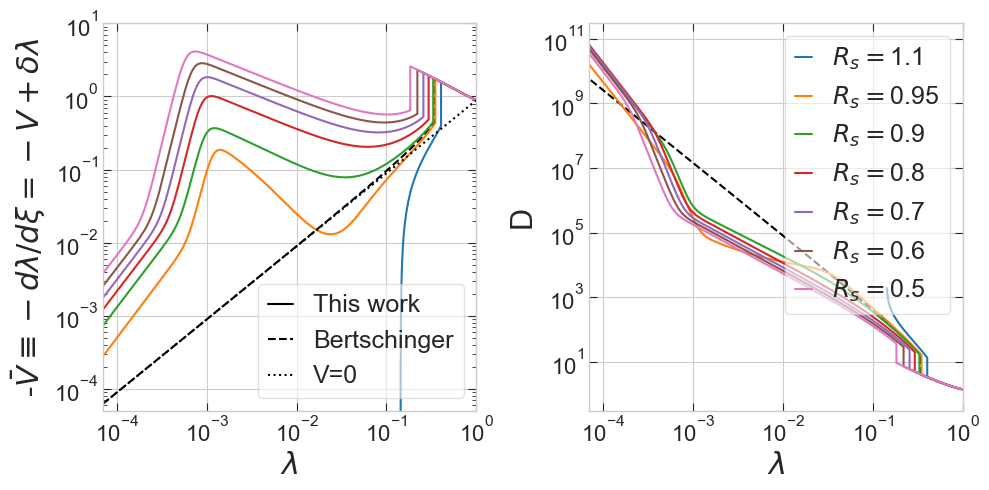

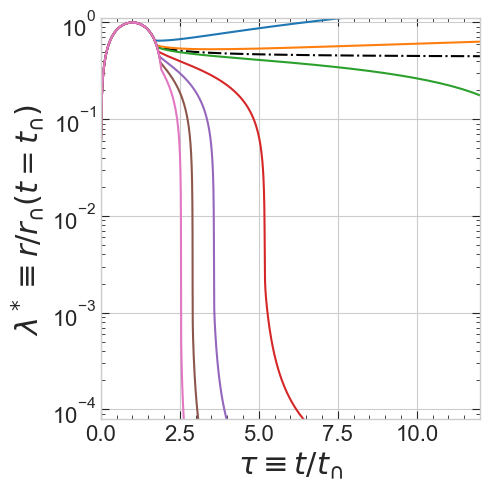

In [29]:
name = 'cold_vary-s'
name = 'shocked_vary-s'
# name = 'shocked_vary-gam'
# name = 'shocked_vary-cooling'
# name = 'shocked_vary-lamdish'
name = 'shocked_vary-lamshsp'

with open(f'{name}-rads.txt', 'tr') as file: rads_list = np.array(eval(file.read()))

s = 1
gam = 5/3
Lam0 = 3e-4
nu=1/2
fb = 0.156837
# fb = 0.5
fd = (1-fb)

lamshsp = 0.9
disk_rad_by_shock = 0.005
lamdish = disk_rad_by_shock #*lamsh

varypars=[]

if name == 'cold_vary-s':
    s_vals = [0.5,1,1.5,2,3,]
    varypars += ['s']
    lamshsp = 0.1
    lamdish = 0.5

if name == 'shocked_vary-s':
    s_vals = [0.5,1,2,]#[:-1]
    varypars += ['s']
    rads_list = rads_list[[0,1,3]]

if name == 'shocked_vary-gam':
    gam_vals= [2,1.8,5/3,1.5,7/5,4/3,]
    lamshsp_vals = [1.2,1.05,0.9,0.7,0.5,0.3]
    varypars += ['gam','lamshsp']

if name == 'shocked_vary-cooling':
    Lam0_vals = [1e-3,3e-3,1e-2,3e-2,1e-1,3e-1]
    varypars += ['Lam0']

if name == 'shocked_vary-lamdish':
    lamdish_vals = [percent/100 for percent in [2,5,10,15,25]]
    varypars += ['lamdish']

if name == 'shocked_vary-lamshsp':
    lamshsp_vals = [1.1,.95,.9,.8,.7,.6,.5]#[0.35,0.3,0.25, 0.2]
    varypars += ['lamshsp']


fig5, axs5 = plt.subplots(1,2, dpi=100, figsize=(10,5), sharex=True)
fig51, axs51 = plt.subplots(1,2, dpi=100, figsize=(13,6), sharex=True)
axs5 = np.vstack([axs5,axs51])
fig6, ax6 = plt.subplots(1, dpi=100, figsize=(5,5))
fig62, ax62 = plt.subplots(1, dpi=100, figsize=(7,7))
fig7, ax7 = plt.subplots(1, dpi=100, figsize=(5,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(20):
    plab=''
    try:
        if 'gam' in varypars: gam = gam_vals[i]; plab+=r'$\gamma=$'+f"{gam:.3g}"
        if 's' in varypars: s = s_vals[i]; plab+=f"s={s} "
        if 'lamshsp' in varypars: lamshsp = lamshsp_vals[i]
        if 'lamshsp' in varypars[:1]: plab+=r'$R_s=$'+f'{lamshsp:g}'#plab+=r'$\lambda_s=$'+f'{lamshsp*100:g} '+r'$\%~ \lambda_{sp}$'
        if 'lamdish' in varypars: lamdish = lamdish_vals[i]; plab+=r'$\lambda_d=$'+f'{lamdish*100:g} '+r'$\%~ \lambda_s$'
        if 'Lam0' in varypars: Lam0 = Lam0_vals[i]; plab+=r'$\Lambda_0=$'+f'{Lam0:g} '
        # if 'nu' in varypars: nu = nu_vals[i]; plab+=r'$\nu=$'+f'{nu} '
    except IndexError: break

    t_now = time()
    de = 2* (1+s/3) /3
    alpha_D = -9/(s+3)
    descr = f'_{name}_lamshsp={lamshsp:.3g}_s={s:.2g}_gam={gam:.3g}_lamdish={lamdish:.3g}_Lam0={Lam0:.1e}_nu={nu:.1g}'

    resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm{descr}.hdf5', key=f'gas/iter0', mode='r')
    # lamsh = resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()]
    lamsh = lamshsp*rads_list[i][2] #rads_list[i][1]  #
    lamdi = lamdish*lamsh
    
    # lamshsol = 0.35 #lamsh_sols[s] #+5e-3 # 0.338976 #
    res_pre, res_post = get_soln_gas_full(lamsh)
    print(res_post.y[2][-1])
    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock profiles obtained')

    lamsh_pre = res_pre.t
    V_pre, D_pre, M_pre = res_pre.y

    lamsh_post = np.exp(res_post.t)
    mVb_post, D_post, M_post, P_post = np.exp(res_post.y)
    V_post = de*lamsh_post - mVb_post
    P_pre = lamsh_pre*0

    lamsh = lamsh_pre.min()
    # lam_all = lamsh_pre
    # V_all = V_pre
    # D_all = D_pre
    # M_all = M_pre
    # P_all = P_pre

    lam_all = np.concatenate([lamsh_post, lamsh_pre][::-1])
    V_all = np.concatenate([V_post, V_pre][::-1])
    D_all = np.concatenate([D_post, D_pre][::-1])
    M_all = np.concatenate([M_post, M_pre][::-1])
    P_all = np.concatenate([P_post, P_pre][::-1])
    Vb_all = V_all - de*lam_all

    color_this = colors[i] #plt.cm.turbo(s/4)

    ax7.plot(lam_all,-V_all, color=color_this)
    ax7.set_xscale('log')

    axs5[0,0].plot(lam_all,-Vb_all, color=color_this)
    axs5[0,1].plot(lam_all,D_all, color=color_this, label=plab)
    axs5[1,0].plot(lam_all,M_all, color=color_this)
    axs5[1,1].plot(lam_all,P_all, color=color_this)
    # axs5[0,2].plot(lam_all, P_all/D_all, color=color_this)
    # axs5[1,2].plot(lam_all, P_all/D_all**gam, color=color_this)
    # axs5[1,2].plot(lam_all, D_all*Vb_all**2-gam*P_all, color=color_this)

    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm_shocked_vary-s_lamshsp=0.9_s={s:.2g}_gam={gam:.3g}_lamdish=0.05_Lam0=3.0e-02_nu=0.5.hdf5', key=f'gas/main', mode='r')
    bertshi_vary = True if name.split('-')[-1] in ['gam','s'] else False
    color_this_bertshi = color_this if bertshi_vary else 'k'
    if bertshi_vary or i==0:
        axs5[0,0].plot(resdf_prof_gaso_bertshi.l, -resdf_prof_gaso_bertshi.Vb, color=color_this_bertshi, ls='--')
        axs5[0,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.D, color=color_this_bertshi, ls='--')
        axs5[1,0].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.M, color=color_this_bertshi, ls='--')
        axs5[1,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.P, color=color_this_bertshi, ls='--')
        print(resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()])
    # PderD_post = np.gradient(P_post,lamsh_post)/D_post

    M_intrp = interp1d(lam_all, M_all, fill_value="extrapolate")
    D_intrp = interp1d(lam_all, D_all, fill_value="extrapolate")
    V_intrp = interp1d(lam_all, V_all, fill_value="extrapolate")
    irem = P_pre.shape[0]-1
    # PderD_intrp = interp1d(np.delete(lam_all,irem), np.delete(PderD_all,irem), kind='linear', fill_value="extrapolate")

    # PderD_intrp = interp1d(lamsh_post, PderD_post, kind='linear', fill_value=0, bounds_error=False)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: all profiles obtained')

    def odefunc_traj(xi, arg):
        lam = arg
        return V_intrp(lam)-de*lam

    # taush = (thtshsol - np.sin(thtshsol)) / np.pi
    # xish = np.log(taush)
    # res = solve_ivp(odefunc_traj, (0,5), (1,), method='Radau', max_step=0.01, dense_output=False, vectorized=True)
    # res1 = solve_ivp(fun, (res.t[-1],15), np.array([res.y[0][-1],-res.y[1][-1]]), max_step=0.1, dense_output=True)

    t_bef, t_now = t_now, time()
    print(f'{t_now-t_bef:.4g}s', f's={s}: post shock trajectory obtained')
    
    # xires = res.t
    # lamres = res.y[0]
    # vres = res.y[1]
    xires,lamres = cumtrapz(1/(V_all-de*lam_all), x=lam_all), lam_all[1:]

    taures = np.exp(xires)
    lamFres = lamres*taures**de

    ax6.plot(taures,lamFres, color=color_this, label=plab)
    ax62.plot(xires,lamres, color=color_this)
    xio,lamo = cumtrapz(1/(resdf_prof_gaso_bertshi.V-de*resdf_prof_gaso_bertshi.l), x=resdf_prof_gaso_bertshi.l), resdf_prof_gaso_bertshi.l[1:]
    tauo = np.exp(xio)
    lamFo = lamo*tauo**de
    if bertshi_vary or i==0:
        ax62.plot(xio,lamo, c=color_this_bertshi, ls='-.')
        ax6.plot(tauo,lamFo, color=color_this_bertshi, ls='-.')

    #trajectory analytical
    thet_range = np.linspace(0.5, 1.2*np.pi,2000)
    tau_anlt = (thet_range - np.sin(thet_range)) / np.pi
    xi_anlt = np.log(tau_anlt)
    lam_anlt = preshock(thet_range)[0]
    lamF_anlt = lam_anlt*tau_anlt**de

    # ax6.plot(xi_anlt, lam_anlt, color=color_this)
    ax6.plot(tau_anlt, lamF_anlt, color=color_this)
    
    # dmo_prfl = pd.read_hdf(f'profiles_dmo_{s}.hdf5')

    # Mta = (3*np.pi/4)**2
    # M_dmo = interp1d(dmo_prfl['l'], dmo_prfl['M']*Mta, fill_value="extrapolate")
    # D_dmo = interp1d(dmo_prfl['l'].iloc[1:], dmo_prfl['rho'].iloc[1:], fill_value="extrapolate")

    # axs5[1,0].plot(lam_all, M_dmo(lam_all), color=color_this, ls='dashed')
    if name.split('_')[-1] =='vary-s':
        axs5[0,0].plot(lam_all,de*lam_all, c=color_this, ls=':')

#Loop ends

axs5[0,0].plot([],[], c='k', ls='-', label='This work')
axs5[0,0].plot([],[], c='k', ls='--', label='Bertschinger')
if name.split('_')[-1] !='vary-s':
    axs5[0,0].plot(lam_all,de*lam_all, c='k', ls=':', label='V=0')
else:
    axs5[0,0].plot([],[], c='k', ls=':', label='V=0')

# ax6.legend(loc='best',frameon=True, framealpha=0.6)
ax6.set_xlabel(r'$\tau \equiv t/t_{\cap}$')
ax6.set_ylabel(r'$\lambda^*\equiv r/r_{\cap}(t=t_{\cap})$')
ax6.set_xlim(0,12)
ax6.set_ylim(0.00008,1.1)
# ax6.set_xscale('log')
ax6.set_yscale('log')

ax62.set_xlabel(r'$\xi$')
ax62.set_ylabel('$\lambda$')
# ax62.set_xlim(,)
# ax62.set_ylim(0.01,1.1)
ax62.set_yscale('log')
    
axs5[0,0].set_xscale('log')
axs5[0,0].set_xlim(1e-5,1)
if name in ['shocked_vary-s','shocked_vary-lamshsp', 'shocked_vary-gam','cold_vary-s']:
    axs5[0,0].legend(loc='best', frameon=True, framealpha=0.6, handlelength=1)
axs5[0,1].legend(loc='best', frameon=True, framealpha=0.6, handlelength=0.7)
if name=='cold_vary-s':
    axs5[0,1].text(1e-3,1e9,'$R_s=0.1$', fontsize=15)
# axs5[0,1].legend()
axs5[0,0].set_xlabel('$\lambda$')
axs5[0,1].set_xlabel('$\lambda$')
axs5[1,0].set_xlabel('$\lambda$')
axs5[1,1].set_xlabel('$\lambda$')
# axs5[1,2].set_xlabel('$\lambda$')

# if gam==5/3:
#     axs5[0,0].set_xlim(7e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e-1,1e11)
#     axs5[1,0].set_ylim(1e-3,1e1)
#     # axs5[1,1].set_ylim(1e0,1e14)
#     # axs5[0,2].set_ylim(1e-1,1e2)
#     # axs5[1,2].set_ylim(1e-5,5e-1)
# elif gam==4/3:
#     axs5[0,0].set_xlim(1e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e0,1e11)
#     axs5[1,0].set_ylim(1e-2,1e1)
#     axs5[1,1].set_ylim(1e1,1e14)
#     # axs5[0,2].set_ylim(1e0,1e3)
#     # axs5[1,2].set_ylim(1e-2,5e-1)

axs5[0,0].set_xlim(7e-5,1)
axs5[0,0].set_ylim(5e-5,1e1)
axs5[0,1].set_ylim(3e-1,3e11)
axs5[1,0].set_ylim(1e-3,1e1)
# axs5[1,1].set_ylim(1e0,1e14)


axs5[0,0].set_ylabel(r'-$\bar{V} \equiv -d \lambda/d \xi = -V + \delta \lambda$')
axs5[0,1].set_ylabel('D')
axs5[1,0].set_ylabel('M')
axs5[1,1].set_ylabel('P')
# axs5[0,2].set_ylabel('T')
# axs5[1,2].set_ylabel('K')

axs5[0,0].set_yscale('log')
axs5[0,1].set_yscale('log')
axs5[1,0].set_yscale('log')
axs5[1,1].set_yscale('log')
ax62.set_xlim(0,5)
# axs5[0,2].set_yscale('log')
# axs5[1,2].set_yscale('log')

if name in ['shocked_vary-gam','shocked_vary-cooling']:
    axs5[0,0].set_ylabel(r'-$\bar{V}$')
    ax6.set_ylabel(r'$\lambda^*$')
# axs5[0,0].xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10,subs=np.arange(-4, 1)))
# axs5[0,0].xaxis.get_ticklocs(minor=True)
# axs5[0,0].minorticks_on()
# axs5[0,0].xaxis.set_tick_params(which='minor', bottom=True)

# # Additional lines to set major xticks
# axs5[0, 0].xaxis.set_major_locator(mpl.ticker.LogLocator(base=10, subs=np.arange(-4, 1,0.01)))
# axs5[0, 0].xaxis.get_ticklocs()

axs5[0,0].set_xticks([1e-4,1e-3,1e-2,1e-1,1])

fig5.tight_layout()
fig6.tight_layout()

fig5.savefig(f'Eds-gaso_profiles_{name}.pdf')
fig6.savefig(f'Eds-gaso_trajectory_{name}.pdf')
# axs5[0,0].set_xlim(1e-6,1)
# axs5[1,0].set_ylim(1e-4,1e1)

plt.close(fig62)
plt.close(fig51)
plt.close(fig7)

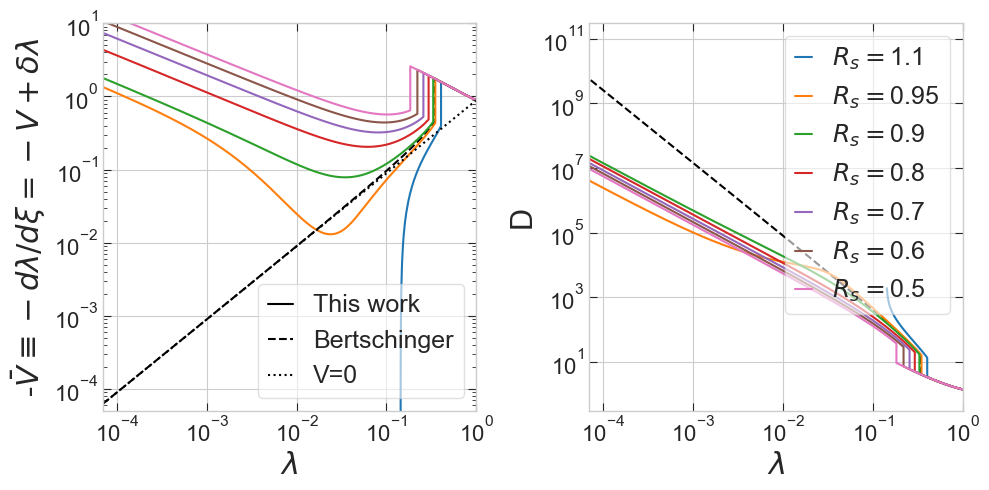

In [34]:
name = 'cold_vary-s'
name = 'shocked_vary-s'
# name = 'shocked_vary-gam'
# name = 'shocked_vary-cooling'
# name = 'shocked_vary-lamdish'
name = 'shocked_vary-lamshsp'

with open(f'{name}-rads.txt', 'tr') as file: rads_list = np.array(eval(file.read()))

s = 1
gam = 5/3
Lam0 = 3e-4
nu=1/2
fb = 0.156837
# fb = 0.5
fd = (1-fb)

lamshsp = 0.9
disk_rad_by_shock = 0.05e-4
lamdish = disk_rad_by_shock #*lamsh

varypars=[]

if name == 'cold_vary-s':
    s_vals = [0.5,1,1.5,2,3,]
    varypars += ['s']
    lamshsp = 0.1
    lamdish = 0.5

if name == 'shocked_vary-s':
    s_vals = [0.5,1,2,]#[:-1]
    varypars += ['s']
    rads_list = rads_list[[0,1,3]]

if name == 'shocked_vary-gam':
    gam_vals= [2,1.8,5/3,1.5,7/5,4/3,]
    lamshsp_vals = [1.2,1.05,0.9,0.7,0.5,0.3]
    varypars += ['gam','lamshsp']

if name == 'shocked_vary-cooling':
    Lam0_vals = [1e-3,3e-3,1e-2,3e-2,1e-1,3e-1]
    varypars += ['Lam0']

if name == 'shocked_vary-lamdish':
    lamdish_vals = [percent/100 for percent in [2,5,10,15,25]]
    varypars += ['lamdish']

if name == 'shocked_vary-lamshsp':
    lamshsp_vals = [1.1,.95,.9,.8,.7,.6,.5]#[0.35,0.3,0.25, 0.2]
    varypars += ['lamshsp']


fig5, axs5 = plt.subplots(1,2, dpi=100, figsize=(10,5), sharex=True)
fig51, axs51 = plt.subplots(1,2, dpi=100, figsize=(13,6), sharex=True)
axs5 = np.vstack([axs5,axs51])
fig6, ax6 = plt.subplots(1, dpi=100, figsize=(5,5))
fig62, ax62 = plt.subplots(1, dpi=100, figsize=(7,7))
fig7, ax7 = plt.subplots(1, dpi=100, figsize=(5,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(20):
    plab=''
    try:
        if 'gam' in varypars: gam = gam_vals[i]; plab+=r'$\gamma=$'+f"{gam:.3g}"
        if 's' in varypars: s = s_vals[i]; plab+=f"s={s} "
        if 'lamshsp' in varypars: lamshsp = lamshsp_vals[i]
        if 'lamshsp' in varypars[:1]: plab+=r'$R_s=$'+f'{lamshsp:g}'#plab+=r'$\lambda_s=$'+f'{lamshsp*100:g} '+r'$\%~ \lambda_{sp}$'
        if 'lamdish' in varypars: lamdish = lamdish_vals[i]; plab+=r'$\lambda_d=$'+f'{lamdish*100:g} '+r'$\%~ \lambda_s$'
        if 'Lam0' in varypars: Lam0 = Lam0_vals[i]; plab+=r'$\Lambda_0=$'+f'{Lam0:g} '
        # if 'nu' in varypars: nu = nu_vals[i]; plab+=r'$\nu=$'+f'{nu} '
    except IndexError: break

    t_now = time()
    de = 2* (1+s/3) /3
    alpha_D = -9/(s+3)
    descr = f'_{name}_lamshsp={lamshsp:.3g}_s={s:.2g}_gam={gam:.3g}_lamdish={lamdish:.3g}_Lam0={Lam0:.1e}_nu={nu:.1g}'

    resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm{descr}.hdf5', key=f'gas/iter0', mode='r')
    # lamsh = resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()]
    lamsh = lamshsp*rads_list[i][2] #rads_list[i][1]  #
    lamdi = lamdish*lamsh
    
    # lamshsol = 0.35 #lamsh_sols[s] #+5e-3 # 0.338976 #
    res_pre, res_post = get_soln_gas_full(lamsh)
    # print(res_post.y[2][-1])
    t_bef, t_now = t_now, time()
    # print(f'{t_now-t_bef:.4g}s', f's={s}: post shock profiles obtained')

    lamsh_pre = res_pre.t
    V_pre, D_pre, M_pre = res_pre.y

    lamsh_post = np.exp(res_post.t)
    mVb_post, D_post, M_post, P_post = np.exp(res_post.y)
    V_post = de*lamsh_post - mVb_post
    P_pre = lamsh_pre*0

    lamsh = lamsh_pre.min()
    # lam_all = lamsh_pre
    # V_all = V_pre
    # D_all = D_pre
    # M_all = M_pre
    # P_all = P_pre

    lam_all = np.concatenate([lamsh_post, lamsh_pre][::-1])
    V_all = np.concatenate([V_post, V_pre][::-1])
    D_all = np.concatenate([D_post, D_pre][::-1])
    M_all = np.concatenate([M_post, M_pre][::-1])
    P_all = np.concatenate([P_post, P_pre][::-1])
    Vb_all = V_all - de*lam_all

    color_this = colors[i] #plt.cm.turbo(s/4)

    ax7.plot(lam_all,-V_all, color=color_this)
    ax7.set_xscale('log')

    axs5[0,0].plot(lam_all,-Vb_all, color=color_this)
    axs5[0,1].plot(lam_all,D_all, color=color_this, label=plab)
    axs5[1,0].plot(lam_all,M_all, color=color_this)
    axs5[1,1].plot(lam_all,P_all, color=color_this)
    # axs5[0,2].plot(lam_all, P_all/D_all, color=color_this)
    # axs5[1,2].plot(lam_all, P_all/D_all**gam, color=color_this)
    # axs5[1,2].plot(lam_all, D_all*Vb_all**2-gam*P_all, color=color_this)

    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm_shocked_vary-s_lamshsp=0.9_s={s:.2g}_gam={gam:.3g}_lamdish=0.05_Lam0=3.0e-02_nu=0.5.hdf5', key=f'gas/main', mode='r')
    bertshi_vary = True if name.split('-')[-1] in ['gam','s'] else False
    color_this_bertshi = color_this if bertshi_vary else 'k'
    if bertshi_vary or i==0:
        axs5[0,0].plot(resdf_prof_gaso_bertshi.l, -resdf_prof_gaso_bertshi.Vb, color=color_this_bertshi, ls='--')
        axs5[0,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.D, color=color_this_bertshi, ls='--')
        axs5[1,0].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.M, color=color_this_bertshi, ls='--')
        axs5[1,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.P, color=color_this_bertshi, ls='--')
        # print(resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()])
    # PderD_post = np.gradient(P_post,lamsh_post)/D_post

    M_intrp = interp1d(lam_all, M_all, fill_value="extrapolate")
    D_intrp = interp1d(lam_all, D_all, fill_value="extrapolate")
    V_intrp = interp1d(lam_all, V_all, fill_value="extrapolate")
    irem = P_pre.shape[0]-1
    # PderD_intrp = interp1d(np.delete(lam_all,irem), np.delete(PderD_all,irem), kind='linear', fill_value="extrapolate")

    # PderD_intrp = interp1d(lamsh_post, PderD_post, kind='linear', fill_value=0, bounds_error=False)

    t_bef, t_now = t_now, time()
    # print(f'{t_now-t_bef:.4g}s', f's={s}: all profiles obtained')

    def odefunc_traj(xi, arg):
        lam = arg
        return V_intrp(lam)-de*lam

    # taush = (thtshsol - np.sin(thtshsol)) / np.pi
    # xish = np.log(taush)
    # res = solve_ivp(odefunc_traj, (0,5), (1,), method='Radau', max_step=0.01, dense_output=False, vectorized=True)
    # res1 = solve_ivp(fun, (res.t[-1],15), np.array([res.y[0][-1],-res.y[1][-1]]), max_step=0.1, dense_output=True)

    t_bef, t_now = t_now, time()
    # print(f'{t_now-t_bef:.4g}s', f's={s}: post shock trajectory obtained')
    
    # xires = res.t
    # lamres = res.y[0]
    # vres = res.y[1]
    xires,lamres = cumtrapz(1/(V_all-de*lam_all), x=lam_all), lam_all[1:]

    taures = np.exp(xires)
    lamFres = lamres*taures**de

    ax6.plot(taures,lamFres, color=color_this, label=plab)
    ax62.plot(xires,lamres, color=color_this)
    xio,lamo = cumtrapz(1/(resdf_prof_gaso_bertshi.V-de*resdf_prof_gaso_bertshi.l), x=resdf_prof_gaso_bertshi.l), resdf_prof_gaso_bertshi.l[1:]
    tauo = np.exp(xio)
    lamFo = lamo*tauo**de
    if bertshi_vary or i==0:
        ax62.plot(xio,lamo, c=color_this_bertshi, ls='-.')
        ax6.plot(tauo,lamFo, color=color_this_bertshi, ls='-.')

    #trajectory analytical
    thet_range = np.linspace(0.5, 1.2*np.pi,2000)
    tau_anlt = (thet_range - np.sin(thet_range)) / np.pi
    xi_anlt = np.log(tau_anlt)
    lam_anlt = preshock(thet_range)[0]
    lamF_anlt = lam_anlt*tau_anlt**de

    # ax6.plot(xi_anlt, lam_anlt, color=color_this)
    ax6.plot(tau_anlt, lamF_anlt, color=color_this)
    
    # dmo_prfl = pd.read_hdf(f'profiles_dmo_{s}.hdf5')

    # Mta = (3*np.pi/4)**2
    # M_dmo = interp1d(dmo_prfl['l'], dmo_prfl['M']*Mta, fill_value="extrapolate")
    # D_dmo = interp1d(dmo_prfl['l'].iloc[1:], dmo_prfl['rho'].iloc[1:], fill_value="extrapolate")

    # axs5[1,0].plot(lam_all, M_dmo(lam_all), color=color_this, ls='dashed')
    if name.split('_')[-1] =='vary-s':
        axs5[0,0].plot(lam_all,de*lam_all, c=color_this, ls=':')

#Loop ends

axs5[0,0].plot([],[], c='k', ls='-', label='This work')
axs5[0,0].plot([],[], c='k', ls='--', label='Bertschinger')
if name.split('_')[-1] !='vary-s':
    axs5[0,0].plot(lam_all,de*lam_all, c='k', ls=':', label='V=0')
else:
    axs5[0,0].plot([],[], c='k', ls=':', label='V=0')

# ax6.legend(loc='best',frameon=True, framealpha=0.6)
ax6.set_xlabel(r'$\tau \equiv t/t_{\cap}$')
ax6.set_ylabel(r'$\lambda^*\equiv r/r_{\cap}(t=t_{\cap})$')
ax6.set_xlim(0,12)
ax6.set_ylim(0.00008,1.1)
# ax6.set_xscale('log')
ax6.set_yscale('log')

ax62.set_xlabel(r'$\xi$')
ax62.set_ylabel('$\lambda$')
# ax62.set_xlim(,)
# ax62.set_ylim(0.01,1.1)
ax62.set_yscale('log')
    
axs5[0,0].set_xscale('log')
axs5[0,0].set_xlim(1e-5,1)
if name in ['shocked_vary-s','shocked_vary-lamshsp', 'shocked_vary-gam','cold_vary-s']:
    axs5[0,0].legend(loc='best', frameon=True, framealpha=0.6, handlelength=1)
axs5[0,1].legend(loc='best', frameon=True, framealpha=0.6, handlelength=0.7)
if name=='cold_vary-s':
    axs5[0,1].text(1e-3,1e9,'$R_s=0.1$', fontsize=15)
# axs5[0,1].legend()
axs5[0,0].set_xlabel('$\lambda$')
axs5[0,1].set_xlabel('$\lambda$')
axs5[1,0].set_xlabel('$\lambda$')
axs5[1,1].set_xlabel('$\lambda$')
# axs5[1,2].set_xlabel('$\lambda$')

# if gam==5/3:
#     axs5[0,0].set_xlim(7e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e-1,1e11)
#     axs5[1,0].set_ylim(1e-3,1e1)
#     # axs5[1,1].set_ylim(1e0,1e14)
#     # axs5[0,2].set_ylim(1e-1,1e2)
#     # axs5[1,2].set_ylim(1e-5,5e-1)
# elif gam==4/3:
#     axs5[0,0].set_xlim(1e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e0,1e11)
#     axs5[1,0].set_ylim(1e-2,1e1)
#     axs5[1,1].set_ylim(1e1,1e14)
#     # axs5[0,2].set_ylim(1e0,1e3)
#     # axs5[1,2].set_ylim(1e-2,5e-1)

axs5[0,0].set_xlim(7e-5,1)
axs5[0,0].set_ylim(5e-5,1e1)
axs5[0,1].set_ylim(3e-1,3e11)
axs5[1,0].set_ylim(1e-3,1e1)
# axs5[1,1].set_ylim(1e0,1e14)


axs5[0,0].set_ylabel(r'-$\bar{V} \equiv -d \lambda/d \xi = -V + \delta \lambda$')
axs5[0,1].set_ylabel('D')
axs5[1,0].set_ylabel('M')
axs5[1,1].set_ylabel('P')
# axs5[0,2].set_ylabel('T')
# axs5[1,2].set_ylabel('K')

axs5[0,0].set_yscale('log')
axs5[0,1].set_yscale('log')
axs5[1,0].set_yscale('log')
axs5[1,1].set_yscale('log')
ax62.set_xlim(0,5)
# axs5[0,2].set_yscale('log')
# axs5[1,2].set_yscale('log')

if name in ['shocked_vary-gam','shocked_vary-cooling']:
    axs5[0,0].set_ylabel(r'-$\bar{V}$')
    ax6.set_ylabel(r'$\lambda^*$')
# axs5[0,0].xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10,subs=np.arange(-4, 1)))
# axs5[0,0].xaxis.get_ticklocs(minor=True)
# axs5[0,0].minorticks_on()
# axs5[0,0].xaxis.set_tick_params(which='minor', bottom=True)

# # Additional lines to set major xticks
# axs5[0, 0].xaxis.set_major_locator(mpl.ticker.LogLocator(base=10, subs=np.arange(-4, 1,0.01)))
# axs5[0, 0].xaxis.get_ticklocs()

axs5[0,0].set_xticks([1e-4,1e-3,1e-2,1e-1,1])

fig5.tight_layout()
fig6.tight_layout()

fig5.savefig(f'Eds-gaso_profiles_{name}.pdf')
fig6.savefig(f'Eds-gaso_trajectory_{name}.pdf')
# axs5[0,0].set_xlim(1e-6,1)
# axs5[1,0].set_ylim(1e-4,1e1)

plt.close(fig6)
plt.close(fig62)
plt.close(fig51)
plt.close(fig7)

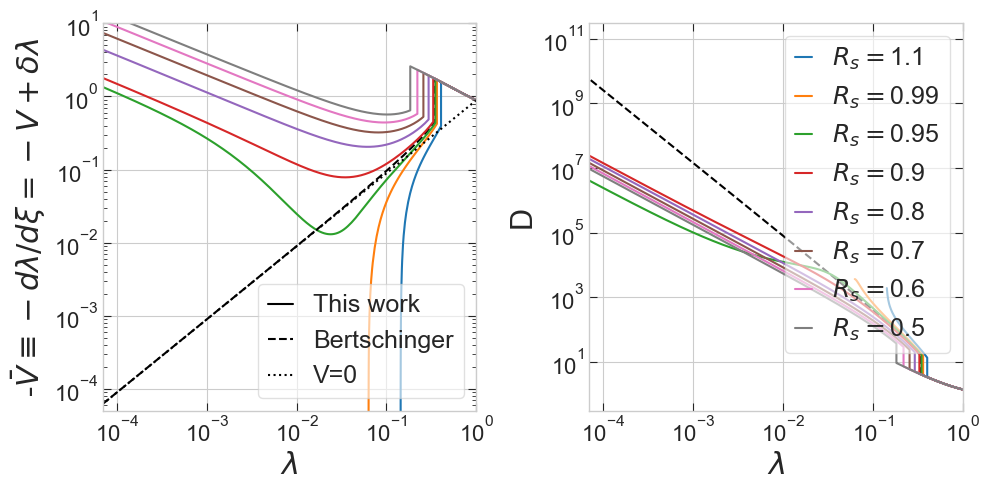

In [37]:
name = 'cold_vary-s'
name = 'shocked_vary-s'
# name = 'shocked_vary-gam'
# name = 'shocked_vary-cooling'
# name = 'shocked_vary-lamdish'
name = 'shocked_vary-lamshsp'

with open(f'{name}-rads.txt', 'tr') as file: rads_list = np.array(eval(file.read()))

s = 1
gam = 5/3
Lam0 = 3e-4
nu=1/2
fb = 0.156837
# fb = 0.5
fd = (1-fb)

lamshsp = 0.9
disk_rad_by_shock = 0.05e-4
lamdish = disk_rad_by_shock #*lamsh

varypars=[]

if name == 'cold_vary-s':
    s_vals = [0.5,1,1.5,2,3,]
    varypars += ['s']
    lamshsp = 0.1
    lamdish = 0.5

if name == 'shocked_vary-s':
    s_vals = [0.5,1,2,]#[:-1]
    varypars += ['s']
    rads_list = rads_list[[0,1,3]]

if name == 'shocked_vary-gam':
    gam_vals= [2,1.8,5/3,1.5,7/5,4/3,]
    lamshsp_vals = [1.2,1.05,0.9,0.7,0.5,0.3]
    varypars += ['gam','lamshsp']

if name == 'shocked_vary-cooling':
    Lam0_vals = [1e-3,3e-3,1e-2,3e-2,1e-1,3e-1]
    varypars += ['Lam0']

if name == 'shocked_vary-lamdish':
    lamdish_vals = [percent/100 for percent in [2,5,10,15,25]]
    varypars += ['lamdish']

if name == 'shocked_vary-lamshsp':
    lamshsp_vals = [1.1,0.99,.95,.9,.8,.7,.6,.5]#[0.35,0.3,0.25, 0.2]
    varypars += ['lamshsp']


fig5, axs5 = plt.subplots(1,2, dpi=100, figsize=(10,5), sharex=True)
fig51, axs51 = plt.subplots(1,2, dpi=100, figsize=(13,6), sharex=True)
axs5 = np.vstack([axs5,axs51])
fig6, ax6 = plt.subplots(1, dpi=100, figsize=(5,5))
fig62, ax62 = plt.subplots(1, dpi=100, figsize=(7,7))
fig7, ax7 = plt.subplots(1, dpi=100, figsize=(5,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(20):
    plab=''
    try:
        if 'gam' in varypars: gam = gam_vals[i]; plab+=r'$\gamma=$'+f"{gam:.3g}"
        if 's' in varypars: s = s_vals[i]; plab+=f"s={s} "
        if 'lamshsp' in varypars: lamshsp = lamshsp_vals[i]
        if 'lamshsp' in varypars[:1]: plab+=r'$R_s=$'+f'{lamshsp:g}'#plab+=r'$\lambda_s=$'+f'{lamshsp*100:g} '+r'$\%~ \lambda_{sp}$'
        if 'lamdish' in varypars: lamdish = lamdish_vals[i]; plab+=r'$\lambda_d=$'+f'{lamdish*100:g} '+r'$\%~ \lambda_s$'
        if 'Lam0' in varypars: Lam0 = Lam0_vals[i]; plab+=r'$\Lambda_0=$'+f'{Lam0:g} '
        # if 'nu' in varypars: nu = nu_vals[i]; plab+=r'$\nu=$'+f'{nu} '
    except IndexError: break

    t_now = time()
    de = 2* (1+s/3) /3
    alpha_D = -9/(s+3)
    descr = f'_{name}_lamshsp={lamshsp:.3g}_s={s:.2g}_gam={gam:.3g}_lamdish={lamdish:.3g}_Lam0={Lam0:.1e}_nu={nu:.1g}'

    resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm{descr}.hdf5', key=f'gas/iter0', mode='r')
    # lamsh = resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()]
    lamsh = lamshsp*rads_list[0][2] #rads_list[i][1]  #
    lamdi = lamdish*lamsh
    
    # lamshsol = 0.35 #lamsh_sols[s] #+5e-3 # 0.338976 #
    res_pre, res_post = get_soln_gas_full(lamsh)
    # print(res_post.y[2][-1])
    t_bef, t_now = t_now, time()
    # print(f'{t_now-t_bef:.4g}s', f's={s}: post shock profiles obtained')

    lamsh_pre = res_pre.t
    V_pre, D_pre, M_pre = res_pre.y

    lamsh_post = np.exp(res_post.t)
    mVb_post, D_post, M_post, P_post = np.exp(res_post.y)
    V_post = de*lamsh_post - mVb_post
    P_pre = lamsh_pre*0

    lamsh = lamsh_pre.min()
    # lam_all = lamsh_pre
    # V_all = V_pre
    # D_all = D_pre
    # M_all = M_pre
    # P_all = P_pre

    lam_all = np.concatenate([lamsh_post, lamsh_pre][::-1])
    V_all = np.concatenate([V_post, V_pre][::-1])
    D_all = np.concatenate([D_post, D_pre][::-1])
    M_all = np.concatenate([M_post, M_pre][::-1])
    P_all = np.concatenate([P_post, P_pre][::-1])
    Vb_all = V_all - de*lam_all

    color_this = colors[i] #plt.cm.turbo(s/4)

    ax7.plot(lam_all,-V_all, color=color_this)
    ax7.set_xscale('log')

    axs5[0,0].plot(lam_all,-Vb_all, color=color_this)
    axs5[0,1].plot(lam_all,D_all, color=color_this, label=plab)
    axs5[1,0].plot(lam_all,M_all, color=color_this)
    axs5[1,1].plot(lam_all,P_all, color=color_this)
    # axs5[0,2].plot(lam_all, P_all/D_all, color=color_this)
    # axs5[1,2].plot(lam_all, P_all/D_all**gam, color=color_this)
    # axs5[1,2].plot(lam_all, D_all*Vb_all**2-gam*P_all, color=color_this)

    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm_shocked_vary-s_lamshsp=0.9_s={s:.2g}_gam={gam:.3g}_lamdish=0.05_Lam0=3.0e-02_nu=0.5.hdf5', key=f'gas/main', mode='r')
    bertshi_vary = True if name.split('-')[-1] in ['gam','s'] else False
    color_this_bertshi = color_this if bertshi_vary else 'k'
    if bertshi_vary or i==0:
        axs5[0,0].plot(resdf_prof_gaso_bertshi.l, -resdf_prof_gaso_bertshi.Vb, color=color_this_bertshi, ls='--')
        axs5[0,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.D, color=color_this_bertshi, ls='--')
        axs5[1,0].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.M, color=color_this_bertshi, ls='--')
        axs5[1,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.P, color=color_this_bertshi, ls='--')
        # print(resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()])
    # PderD_post = np.gradient(P_post,lamsh_post)/D_post

    M_intrp = interp1d(lam_all, M_all, fill_value="extrapolate")
    D_intrp = interp1d(lam_all, D_all, fill_value="extrapolate")
    V_intrp = interp1d(lam_all, V_all, fill_value="extrapolate")
    irem = P_pre.shape[0]-1
    # PderD_intrp = interp1d(np.delete(lam_all,irem), np.delete(PderD_all,irem), kind='linear', fill_value="extrapolate")

    # PderD_intrp = interp1d(lamsh_post, PderD_post, kind='linear', fill_value=0, bounds_error=False)

    t_bef, t_now = t_now, time()
    # print(f'{t_now-t_bef:.4g}s', f's={s}: all profiles obtained')

    def odefunc_traj(xi, arg):
        lam = arg
        return V_intrp(lam)-de*lam

    # taush = (thtshsol - np.sin(thtshsol)) / np.pi
    # xish = np.log(taush)
    # res = solve_ivp(odefunc_traj, (0,5), (1,), method='Radau', max_step=0.01, dense_output=False, vectorized=True)
    # res1 = solve_ivp(fun, (res.t[-1],15), np.array([res.y[0][-1],-res.y[1][-1]]), max_step=0.1, dense_output=True)

    t_bef, t_now = t_now, time()
    # print(f'{t_now-t_bef:.4g}s', f's={s}: post shock trajectory obtained')
    
    # xires = res.t
    # lamres = res.y[0]
    # vres = res.y[1]
    xires,lamres = cumtrapz(1/(V_all-de*lam_all), x=lam_all), lam_all[1:]

    taures = np.exp(xires)
    lamFres = lamres*taures**de

    ax6.plot(taures,lamFres, color=color_this, label=plab)
    ax62.plot(xires,lamres, color=color_this)
    xio,lamo = cumtrapz(1/(resdf_prof_gaso_bertshi.V-de*resdf_prof_gaso_bertshi.l), x=resdf_prof_gaso_bertshi.l), resdf_prof_gaso_bertshi.l[1:]
    tauo = np.exp(xio)
    lamFo = lamo*tauo**de
    if bertshi_vary or i==0:
        ax62.plot(xio,lamo, c=color_this_bertshi, ls='-.')
        ax6.plot(tauo,lamFo, color=color_this_bertshi, ls='-.')

    #trajectory analytical
    thet_range = np.linspace(0.5, 1.2*np.pi,2000)
    tau_anlt = (thet_range - np.sin(thet_range)) / np.pi
    xi_anlt = np.log(tau_anlt)
    lam_anlt = preshock(thet_range)[0]
    lamF_anlt = lam_anlt*tau_anlt**de

    # ax6.plot(xi_anlt, lam_anlt, color=color_this)
    ax6.plot(tau_anlt, lamF_anlt, color=color_this)
    
    # dmo_prfl = pd.read_hdf(f'profiles_dmo_{s}.hdf5')

    # Mta = (3*np.pi/4)**2
    # M_dmo = interp1d(dmo_prfl['l'], dmo_prfl['M']*Mta, fill_value="extrapolate")
    # D_dmo = interp1d(dmo_prfl['l'].iloc[1:], dmo_prfl['rho'].iloc[1:], fill_value="extrapolate")

    # axs5[1,0].plot(lam_all, M_dmo(lam_all), color=color_this, ls='dashed')
    if name.split('_')[-1] =='vary-s':
        axs5[0,0].plot(lam_all,de*lam_all, c=color_this, ls=':')

#Loop ends

axs5[0,0].plot([],[], c='k', ls='-', label='This work')
axs5[0,0].plot([],[], c='k', ls='--', label='Bertschinger')
if name.split('_')[-1] !='vary-s':
    axs5[0,0].plot(lam_all,de*lam_all, c='k', ls=':', label='V=0')
else:
    axs5[0,0].plot([],[], c='k', ls=':', label='V=0')

# ax6.legend(loc='best',frameon=True, framealpha=0.6)
ax6.set_xlabel(r'$\tau \equiv t/t_{\cap}$')
ax6.set_ylabel(r'$\lambda^*\equiv r/r_{\cap}(t=t_{\cap})$')
ax6.set_xlim(0,12)
ax6.set_ylim(0.00008,1.1)
# ax6.set_xscale('log')
ax6.set_yscale('log')

ax62.set_xlabel(r'$\xi$')
ax62.set_ylabel('$\lambda$')
# ax62.set_xlim(,)
# ax62.set_ylim(0.01,1.1)
ax62.set_yscale('log')
    
axs5[0,0].set_xscale('log')
axs5[0,0].set_xlim(1e-5,1)
if name in ['shocked_vary-s','shocked_vary-lamshsp', 'shocked_vary-gam','cold_vary-s']:
    axs5[0,0].legend(loc='best', frameon=True, framealpha=0.6, handlelength=1)
axs5[0,1].legend(loc='best', frameon=True, framealpha=0.6, handlelength=0.7)
if name=='cold_vary-s':
    axs5[0,1].text(1e-3,1e9,'$R_s=0.1$', fontsize=15)
# axs5[0,1].legend()
axs5[0,0].set_xlabel('$\lambda$')
axs5[0,1].set_xlabel('$\lambda$')
axs5[1,0].set_xlabel('$\lambda$')
axs5[1,1].set_xlabel('$\lambda$')
# axs5[1,2].set_xlabel('$\lambda$')

# if gam==5/3:
#     axs5[0,0].set_xlim(7e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e-1,1e11)
#     axs5[1,0].set_ylim(1e-3,1e1)
#     # axs5[1,1].set_ylim(1e0,1e14)
#     # axs5[0,2].set_ylim(1e-1,1e2)
#     # axs5[1,2].set_ylim(1e-5,5e-1)
# elif gam==4/3:
#     axs5[0,0].set_xlim(1e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e0,1e11)
#     axs5[1,0].set_ylim(1e-2,1e1)
#     axs5[1,1].set_ylim(1e1,1e14)
#     # axs5[0,2].set_ylim(1e0,1e3)
#     # axs5[1,2].set_ylim(1e-2,5e-1)

axs5[0,0].set_xlim(7e-5,1)
axs5[0,0].set_ylim(5e-5,1e1)
axs5[0,1].set_ylim(3e-1,3e11)
axs5[1,0].set_ylim(1e-3,1e1)
# axs5[1,1].set_ylim(1e0,1e14)


axs5[0,0].set_ylabel(r'-$\bar{V} \equiv -d \lambda/d \xi = -V + \delta \lambda$')
axs5[0,1].set_ylabel('D')
axs5[1,0].set_ylabel('M')
axs5[1,1].set_ylabel('P')
# axs5[0,2].set_ylabel('T')
# axs5[1,2].set_ylabel('K')

axs5[0,0].set_yscale('log')
axs5[0,1].set_yscale('log')
axs5[1,0].set_yscale('log')
axs5[1,1].set_yscale('log')
ax62.set_xlim(0,5)
# axs5[0,2].set_yscale('log')
# axs5[1,2].set_yscale('log')

if name in ['shocked_vary-gam','shocked_vary-cooling']:
    axs5[0,0].set_ylabel(r'-$\bar{V}$')
    ax6.set_ylabel(r'$\lambda^*$')
# axs5[0,0].xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10,subs=np.arange(-4, 1)))
# axs5[0,0].xaxis.get_ticklocs(minor=True)
# axs5[0,0].minorticks_on()
# axs5[0,0].xaxis.set_tick_params(which='minor', bottom=True)

# # Additional lines to set major xticks
# axs5[0, 0].xaxis.set_major_locator(mpl.ticker.LogLocator(base=10, subs=np.arange(-4, 1,0.01)))
# axs5[0, 0].xaxis.get_ticklocs()

axs5[0,0].set_xticks([1e-4,1e-3,1e-2,1e-1,1])

fig5.tight_layout()
fig6.tight_layout()

fig5.savefig(f'Eds-gaso_profiles_{name}.pdf')
fig6.savefig(f'Eds-gaso_trajectory_{name}.pdf')
# axs5[0,0].set_xlim(1e-6,1)
# axs5[1,0].set_ylim(1e-4,1e1)

plt.close(fig6)
plt.close(fig62)
plt.close(fig51)
plt.close(fig7)

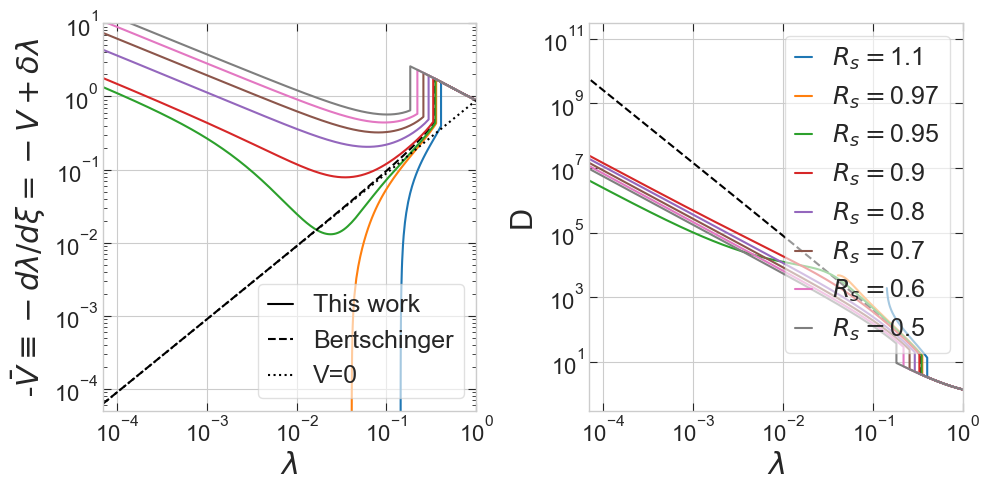

In [38]:
name = 'cold_vary-s'
name = 'shocked_vary-s'
# name = 'shocked_vary-gam'
# name = 'shocked_vary-cooling'
# name = 'shocked_vary-lamdish'
name = 'shocked_vary-lamshsp'

with open(f'{name}-rads.txt', 'tr') as file: rads_list = np.array(eval(file.read()))

s = 1
gam = 5/3
Lam0 = 3e-4
nu=1/2
fb = 0.156837
# fb = 0.5
fd = (1-fb)

lamshsp = 0.9
disk_rad_by_shock = 0.05e-4
lamdish = disk_rad_by_shock #*lamsh

varypars=[]

if name == 'cold_vary-s':
    s_vals = [0.5,1,1.5,2,3,]
    varypars += ['s']
    lamshsp = 0.1
    lamdish = 0.5

if name == 'shocked_vary-s':
    s_vals = [0.5,1,2,]#[:-1]
    varypars += ['s']
    rads_list = rads_list[[0,1,3]]

if name == 'shocked_vary-gam':
    gam_vals= [2,1.8,5/3,1.5,7/5,4/3,]
    lamshsp_vals = [1.2,1.05,0.9,0.7,0.5,0.3]
    varypars += ['gam','lamshsp']

if name == 'shocked_vary-cooling':
    Lam0_vals = [1e-3,3e-3,1e-2,3e-2,1e-1,3e-1]
    varypars += ['Lam0']

if name == 'shocked_vary-lamdish':
    lamdish_vals = [percent/100 for percent in [2,5,10,15,25]]
    varypars += ['lamdish']

if name == 'shocked_vary-lamshsp':
    lamshsp_vals = [1.1,0.97,.95,.9,.8,.7,.6,.5]#[0.35,0.3,0.25, 0.2]
    varypars += ['lamshsp']


fig5, axs5 = plt.subplots(1,2, dpi=100, figsize=(10,5), sharex=True)
fig51, axs51 = plt.subplots(1,2, dpi=100, figsize=(13,6), sharex=True)
axs5 = np.vstack([axs5,axs51])
fig6, ax6 = plt.subplots(1, dpi=100, figsize=(5,5))
fig62, ax62 = plt.subplots(1, dpi=100, figsize=(7,7))
fig7, ax7 = plt.subplots(1, dpi=100, figsize=(5,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(20):
    plab=''
    try:
        if 'gam' in varypars: gam = gam_vals[i]; plab+=r'$\gamma=$'+f"{gam:.3g}"
        if 's' in varypars: s = s_vals[i]; plab+=f"s={s} "
        if 'lamshsp' in varypars: lamshsp = lamshsp_vals[i]
        if 'lamshsp' in varypars[:1]: plab+=r'$R_s=$'+f'{lamshsp:g}'#plab+=r'$\lambda_s=$'+f'{lamshsp*100:g} '+r'$\%~ \lambda_{sp}$'
        if 'lamdish' in varypars: lamdish = lamdish_vals[i]; plab+=r'$\lambda_d=$'+f'{lamdish*100:g} '+r'$\%~ \lambda_s$'
        if 'Lam0' in varypars: Lam0 = Lam0_vals[i]; plab+=r'$\Lambda_0=$'+f'{Lam0:g} '
        # if 'nu' in varypars: nu = nu_vals[i]; plab+=r'$\nu=$'+f'{nu} '
    except IndexError: break

    t_now = time()
    de = 2* (1+s/3) /3
    alpha_D = -9/(s+3)
    descr = f'_{name}_lamshsp={lamshsp:.3g}_s={s:.2g}_gam={gam:.3g}_lamdish={lamdish:.3g}_Lam0={Lam0:.1e}_nu={nu:.1g}'

    resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm{descr}.hdf5', key=f'gas/iter0', mode='r')
    # lamsh = resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()]
    lamsh = lamshsp*rads_list[0][2] #rads_list[i][1]  #
    lamdi = lamdish*lamsh
    
    # lamshsol = 0.35 #lamsh_sols[s] #+5e-3 # 0.338976 #
    res_pre, res_post = get_soln_gas_full(lamsh)
    # print(res_post.y[2][-1])
    t_bef, t_now = t_now, time()
    # print(f'{t_now-t_bef:.4g}s', f's={s}: post shock profiles obtained')

    lamsh_pre = res_pre.t
    V_pre, D_pre, M_pre = res_pre.y

    lamsh_post = np.exp(res_post.t)
    mVb_post, D_post, M_post, P_post = np.exp(res_post.y)
    V_post = de*lamsh_post - mVb_post
    P_pre = lamsh_pre*0

    lamsh = lamsh_pre.min()
    # lam_all = lamsh_pre
    # V_all = V_pre
    # D_all = D_pre
    # M_all = M_pre
    # P_all = P_pre

    lam_all = np.concatenate([lamsh_post, lamsh_pre][::-1])
    V_all = np.concatenate([V_post, V_pre][::-1])
    D_all = np.concatenate([D_post, D_pre][::-1])
    M_all = np.concatenate([M_post, M_pre][::-1])
    P_all = np.concatenate([P_post, P_pre][::-1])
    Vb_all = V_all - de*lam_all

    color_this = colors[i] #plt.cm.turbo(s/4)

    ax7.plot(lam_all,-V_all, color=color_this)
    ax7.set_xscale('log')

    axs5[0,0].plot(lam_all,-Vb_all, color=color_this)
    axs5[0,1].plot(lam_all,D_all, color=color_this, label=plab)
    axs5[1,0].plot(lam_all,M_all, color=color_this)
    axs5[1,1].plot(lam_all,P_all, color=color_this)
    # axs5[0,2].plot(lam_all, P_all/D_all, color=color_this)
    # axs5[1,2].plot(lam_all, P_all/D_all**gam, color=color_this)
    # axs5[1,2].plot(lam_all, D_all*Vb_all**2-gam*P_all, color=color_this)

    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm_shocked_vary-s_lamshsp=0.9_s={s:.2g}_gam={gam:.3g}_lamdish=0.05_Lam0=3.0e-02_nu=0.5.hdf5', key=f'gas/main', mode='r')
    bertshi_vary = True if name.split('-')[-1] in ['gam','s'] else False
    color_this_bertshi = color_this if bertshi_vary else 'k'
    if bertshi_vary or i==0:
        axs5[0,0].plot(resdf_prof_gaso_bertshi.l, -resdf_prof_gaso_bertshi.Vb, color=color_this_bertshi, ls='--')
        axs5[0,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.D, color=color_this_bertshi, ls='--')
        axs5[1,0].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.M, color=color_this_bertshi, ls='--')
        axs5[1,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.P, color=color_this_bertshi, ls='--')
        # print(resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()])
    # PderD_post = np.gradient(P_post,lamsh_post)/D_post

    M_intrp = interp1d(lam_all, M_all, fill_value="extrapolate")
    D_intrp = interp1d(lam_all, D_all, fill_value="extrapolate")
    V_intrp = interp1d(lam_all, V_all, fill_value="extrapolate")
    irem = P_pre.shape[0]-1
    # PderD_intrp = interp1d(np.delete(lam_all,irem), np.delete(PderD_all,irem), kind='linear', fill_value="extrapolate")

    # PderD_intrp = interp1d(lamsh_post, PderD_post, kind='linear', fill_value=0, bounds_error=False)

    t_bef, t_now = t_now, time()
    # print(f'{t_now-t_bef:.4g}s', f's={s}: all profiles obtained')

    def odefunc_traj(xi, arg):
        lam = arg
        return V_intrp(lam)-de*lam

    # taush = (thtshsol - np.sin(thtshsol)) / np.pi
    # xish = np.log(taush)
    # res = solve_ivp(odefunc_traj, (0,5), (1,), method='Radau', max_step=0.01, dense_output=False, vectorized=True)
    # res1 = solve_ivp(fun, (res.t[-1],15), np.array([res.y[0][-1],-res.y[1][-1]]), max_step=0.1, dense_output=True)

    t_bef, t_now = t_now, time()
    # print(f'{t_now-t_bef:.4g}s', f's={s}: post shock trajectory obtained')
    
    # xires = res.t
    # lamres = res.y[0]
    # vres = res.y[1]
    xires,lamres = cumtrapz(1/(V_all-de*lam_all), x=lam_all), lam_all[1:]

    taures = np.exp(xires)
    lamFres = lamres*taures**de

    ax6.plot(taures,lamFres, color=color_this, label=plab)
    ax62.plot(xires,lamres, color=color_this)
    xio,lamo = cumtrapz(1/(resdf_prof_gaso_bertshi.V-de*resdf_prof_gaso_bertshi.l), x=resdf_prof_gaso_bertshi.l), resdf_prof_gaso_bertshi.l[1:]
    tauo = np.exp(xio)
    lamFo = lamo*tauo**de
    if bertshi_vary or i==0:
        ax62.plot(xio,lamo, c=color_this_bertshi, ls='-.')
        ax6.plot(tauo,lamFo, color=color_this_bertshi, ls='-.')

    #trajectory analytical
    thet_range = np.linspace(0.5, 1.2*np.pi,2000)
    tau_anlt = (thet_range - np.sin(thet_range)) / np.pi
    xi_anlt = np.log(tau_anlt)
    lam_anlt = preshock(thet_range)[0]
    lamF_anlt = lam_anlt*tau_anlt**de

    # ax6.plot(xi_anlt, lam_anlt, color=color_this)
    ax6.plot(tau_anlt, lamF_anlt, color=color_this)
    
    # dmo_prfl = pd.read_hdf(f'profiles_dmo_{s}.hdf5')

    # Mta = (3*np.pi/4)**2
    # M_dmo = interp1d(dmo_prfl['l'], dmo_prfl['M']*Mta, fill_value="extrapolate")
    # D_dmo = interp1d(dmo_prfl['l'].iloc[1:], dmo_prfl['rho'].iloc[1:], fill_value="extrapolate")

    # axs5[1,0].plot(lam_all, M_dmo(lam_all), color=color_this, ls='dashed')
    if name.split('_')[-1] =='vary-s':
        axs5[0,0].plot(lam_all,de*lam_all, c=color_this, ls=':')

#Loop ends

axs5[0,0].plot([],[], c='k', ls='-', label='This work')
axs5[0,0].plot([],[], c='k', ls='--', label='Bertschinger')
if name.split('_')[-1] !='vary-s':
    axs5[0,0].plot(lam_all,de*lam_all, c='k', ls=':', label='V=0')
else:
    axs5[0,0].plot([],[], c='k', ls=':', label='V=0')

# ax6.legend(loc='best',frameon=True, framealpha=0.6)
ax6.set_xlabel(r'$\tau \equiv t/t_{\cap}$')
ax6.set_ylabel(r'$\lambda^*\equiv r/r_{\cap}(t=t_{\cap})$')
ax6.set_xlim(0,12)
ax6.set_ylim(0.00008,1.1)
# ax6.set_xscale('log')
ax6.set_yscale('log')

ax62.set_xlabel(r'$\xi$')
ax62.set_ylabel('$\lambda$')
# ax62.set_xlim(,)
# ax62.set_ylim(0.01,1.1)
ax62.set_yscale('log')
    
axs5[0,0].set_xscale('log')
axs5[0,0].set_xlim(1e-5,1)
if name in ['shocked_vary-s','shocked_vary-lamshsp', 'shocked_vary-gam','cold_vary-s']:
    axs5[0,0].legend(loc='best', frameon=True, framealpha=0.6, handlelength=1)
axs5[0,1].legend(loc='best', frameon=True, framealpha=0.6, handlelength=0.7)
if name=='cold_vary-s':
    axs5[0,1].text(1e-3,1e9,'$R_s=0.1$', fontsize=15)
# axs5[0,1].legend()
axs5[0,0].set_xlabel('$\lambda$')
axs5[0,1].set_xlabel('$\lambda$')
axs5[1,0].set_xlabel('$\lambda$')
axs5[1,1].set_xlabel('$\lambda$')
# axs5[1,2].set_xlabel('$\lambda$')

# if gam==5/3:
#     axs5[0,0].set_xlim(7e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e-1,1e11)
#     axs5[1,0].set_ylim(1e-3,1e1)
#     # axs5[1,1].set_ylim(1e0,1e14)
#     # axs5[0,2].set_ylim(1e-1,1e2)
#     # axs5[1,2].set_ylim(1e-5,5e-1)
# elif gam==4/3:
#     axs5[0,0].set_xlim(1e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e0,1e11)
#     axs5[1,0].set_ylim(1e-2,1e1)
#     axs5[1,1].set_ylim(1e1,1e14)
#     # axs5[0,2].set_ylim(1e0,1e3)
#     # axs5[1,2].set_ylim(1e-2,5e-1)

axs5[0,0].set_xlim(7e-5,1)
axs5[0,0].set_ylim(5e-5,1e1)
axs5[0,1].set_ylim(3e-1,3e11)
axs5[1,0].set_ylim(1e-3,1e1)
# axs5[1,1].set_ylim(1e0,1e14)


axs5[0,0].set_ylabel(r'-$\bar{V} \equiv -d \lambda/d \xi = -V + \delta \lambda$')
axs5[0,1].set_ylabel('D')
axs5[1,0].set_ylabel('M')
axs5[1,1].set_ylabel('P')
# axs5[0,2].set_ylabel('T')
# axs5[1,2].set_ylabel('K')

axs5[0,0].set_yscale('log')
axs5[0,1].set_yscale('log')
axs5[1,0].set_yscale('log')
axs5[1,1].set_yscale('log')
ax62.set_xlim(0,5)
# axs5[0,2].set_yscale('log')
# axs5[1,2].set_yscale('log')

if name in ['shocked_vary-gam','shocked_vary-cooling']:
    axs5[0,0].set_ylabel(r'-$\bar{V}$')
    ax6.set_ylabel(r'$\lambda^*$')
# axs5[0,0].xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10,subs=np.arange(-4, 1)))
# axs5[0,0].xaxis.get_ticklocs(minor=True)
# axs5[0,0].minorticks_on()
# axs5[0,0].xaxis.set_tick_params(which='minor', bottom=True)

# # Additional lines to set major xticks
# axs5[0, 0].xaxis.set_major_locator(mpl.ticker.LogLocator(base=10, subs=np.arange(-4, 1,0.01)))
# axs5[0, 0].xaxis.get_ticklocs()

axs5[0,0].set_xticks([1e-4,1e-3,1e-2,1e-1,1])

fig5.tight_layout()
fig6.tight_layout()

fig5.savefig(f'Eds-gaso_profiles_{name}.pdf')
fig6.savefig(f'Eds-gaso_trajectory_{name}.pdf')
# axs5[0,0].set_xlim(1e-6,1)
# axs5[1,0].set_ylim(1e-4,1e1)

plt.close(fig6)
plt.close(fig62)
plt.close(fig51)
plt.close(fig7)

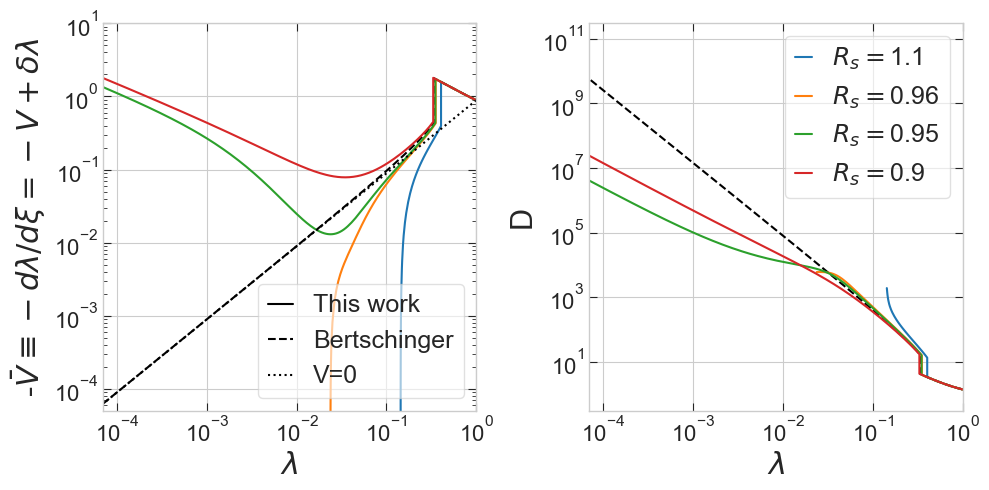

In [39]:
name = 'cold_vary-s'
name = 'shocked_vary-s'
# name = 'shocked_vary-gam'
# name = 'shocked_vary-cooling'
# name = 'shocked_vary-lamdish'
name = 'shocked_vary-lamshsp'

with open(f'{name}-rads.txt', 'tr') as file: rads_list = np.array(eval(file.read()))

s = 1
gam = 5/3
Lam0 = 3e-4
nu=1/2
fb = 0.156837
# fb = 0.5
fd = (1-fb)

lamshsp = 0.9
disk_rad_by_shock = 0.05e-4
lamdish = disk_rad_by_shock #*lamsh

varypars=[]

if name == 'cold_vary-s':
    s_vals = [0.5,1,1.5,2,3,]
    varypars += ['s']
    lamshsp = 0.1
    lamdish = 0.5

if name == 'shocked_vary-s':
    s_vals = [0.5,1,2,]#[:-1]
    varypars += ['s']
    rads_list = rads_list[[0,1,3]]

if name == 'shocked_vary-gam':
    gam_vals= [2,1.8,5/3,1.5,7/5,4/3,]
    lamshsp_vals = [1.2,1.05,0.9,0.7,0.5,0.3]
    varypars += ['gam','lamshsp']

if name == 'shocked_vary-cooling':
    Lam0_vals = [1e-3,3e-3,1e-2,3e-2,1e-1,3e-1]
    varypars += ['Lam0']

if name == 'shocked_vary-lamdish':
    lamdish_vals = [percent/100 for percent in [2,5,10,15,25]]
    varypars += ['lamdish']

if name == 'shocked_vary-lamshsp':
    lamshsp_vals = [1.1,0.96,.95,.9]#,.8,.7,.6,.5]#[0.35,0.3,0.25, 0.2]
    varypars += ['lamshsp']


fig5, axs5 = plt.subplots(1,2, dpi=100, figsize=(10,5), sharex=True)
fig51, axs51 = plt.subplots(1,2, dpi=100, figsize=(13,6), sharex=True)
axs5 = np.vstack([axs5,axs51])
fig6, ax6 = plt.subplots(1, dpi=100, figsize=(5,5))
fig62, ax62 = plt.subplots(1, dpi=100, figsize=(7,7))
fig7, ax7 = plt.subplots(1, dpi=100, figsize=(5,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(20):
    plab=''
    try:
        if 'gam' in varypars: gam = gam_vals[i]; plab+=r'$\gamma=$'+f"{gam:.3g}"
        if 's' in varypars: s = s_vals[i]; plab+=f"s={s} "
        if 'lamshsp' in varypars: lamshsp = lamshsp_vals[i]
        if 'lamshsp' in varypars[:1]: plab+=r'$R_s=$'+f'{lamshsp:g}'#plab+=r'$\lambda_s=$'+f'{lamshsp*100:g} '+r'$\%~ \lambda_{sp}$'
        if 'lamdish' in varypars: lamdish = lamdish_vals[i]; plab+=r'$\lambda_d=$'+f'{lamdish*100:g} '+r'$\%~ \lambda_s$'
        if 'Lam0' in varypars: Lam0 = Lam0_vals[i]; plab+=r'$\Lambda_0=$'+f'{Lam0:g} '
        # if 'nu' in varypars: nu = nu_vals[i]; plab+=r'$\nu=$'+f'{nu} '
    except IndexError: break

    t_now = time()
    de = 2* (1+s/3) /3
    alpha_D = -9/(s+3)
    descr = f'_{name}_lamshsp={lamshsp:.3g}_s={s:.2g}_gam={gam:.3g}_lamdish={lamdish:.3g}_Lam0={Lam0:.1e}_nu={nu:.1g}'

    resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm{descr}.hdf5', key=f'gas/iter0', mode='r')
    # lamsh = resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()]
    lamsh = lamshsp*rads_list[0][2] #rads_list[i][1]  #
    lamdi = lamdish*lamsh
    
    # lamshsol = 0.35 #lamsh_sols[s] #+5e-3 # 0.338976 #
    res_pre, res_post = get_soln_gas_full(lamsh)
    # print(res_post.y[2][-1])
    t_bef, t_now = t_now, time()
    # print(f'{t_now-t_bef:.4g}s', f's={s}: post shock profiles obtained')

    lamsh_pre = res_pre.t
    V_pre, D_pre, M_pre = res_pre.y

    lamsh_post = np.exp(res_post.t)
    mVb_post, D_post, M_post, P_post = np.exp(res_post.y)
    V_post = de*lamsh_post - mVb_post
    P_pre = lamsh_pre*0

    lamsh = lamsh_pre.min()
    # lam_all = lamsh_pre
    # V_all = V_pre
    # D_all = D_pre
    # M_all = M_pre
    # P_all = P_pre

    lam_all = np.concatenate([lamsh_post, lamsh_pre][::-1])
    V_all = np.concatenate([V_post, V_pre][::-1])
    D_all = np.concatenate([D_post, D_pre][::-1])
    M_all = np.concatenate([M_post, M_pre][::-1])
    P_all = np.concatenate([P_post, P_pre][::-1])
    Vb_all = V_all - de*lam_all

    color_this = colors[i] #plt.cm.turbo(s/4)

    ax7.plot(lam_all,-V_all, color=color_this)
    ax7.set_xscale('log')

    axs5[0,0].plot(lam_all,-Vb_all, color=color_this)
    axs5[0,1].plot(lam_all,D_all, color=color_this, label=plab)
    axs5[1,0].plot(lam_all,M_all, color=color_this)
    axs5[1,1].plot(lam_all,P_all, color=color_this)
    # axs5[0,2].plot(lam_all, P_all/D_all, color=color_this)
    # axs5[1,2].plot(lam_all, P_all/D_all**gam, color=color_this)
    # axs5[1,2].plot(lam_all, D_all*Vb_all**2-gam*P_all, color=color_this)

    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm_shocked_vary-s_lamshsp=0.9_s={s:.2g}_gam={gam:.3g}_lamdish=0.05_Lam0=3.0e-02_nu=0.5.hdf5', key=f'gas/main', mode='r')
    bertshi_vary = True if name.split('-')[-1] in ['gam','s'] else False
    color_this_bertshi = color_this if bertshi_vary else 'k'
    if bertshi_vary or i==0:
        axs5[0,0].plot(resdf_prof_gaso_bertshi.l, -resdf_prof_gaso_bertshi.Vb, color=color_this_bertshi, ls='--')
        axs5[0,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.D, color=color_this_bertshi, ls='--')
        axs5[1,0].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.M, color=color_this_bertshi, ls='--')
        axs5[1,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.P, color=color_this_bertshi, ls='--')
        # print(resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()])
    # PderD_post = np.gradient(P_post,lamsh_post)/D_post

    M_intrp = interp1d(lam_all, M_all, fill_value="extrapolate")
    D_intrp = interp1d(lam_all, D_all, fill_value="extrapolate")
    V_intrp = interp1d(lam_all, V_all, fill_value="extrapolate")
    irem = P_pre.shape[0]-1
    # PderD_intrp = interp1d(np.delete(lam_all,irem), np.delete(PderD_all,irem), kind='linear', fill_value="extrapolate")

    # PderD_intrp = interp1d(lamsh_post, PderD_post, kind='linear', fill_value=0, bounds_error=False)

    t_bef, t_now = t_now, time()
    # print(f'{t_now-t_bef:.4g}s', f's={s}: all profiles obtained')

    def odefunc_traj(xi, arg):
        lam = arg
        return V_intrp(lam)-de*lam

    # taush = (thtshsol - np.sin(thtshsol)) / np.pi
    # xish = np.log(taush)
    # res = solve_ivp(odefunc_traj, (0,5), (1,), method='Radau', max_step=0.01, dense_output=False, vectorized=True)
    # res1 = solve_ivp(fun, (res.t[-1],15), np.array([res.y[0][-1],-res.y[1][-1]]), max_step=0.1, dense_output=True)

    t_bef, t_now = t_now, time()
    # print(f'{t_now-t_bef:.4g}s', f's={s}: post shock trajectory obtained')
    
    # xires = res.t
    # lamres = res.y[0]
    # vres = res.y[1]
    xires,lamres = cumtrapz(1/(V_all-de*lam_all), x=lam_all), lam_all[1:]

    taures = np.exp(xires)
    lamFres = lamres*taures**de

    ax6.plot(taures,lamFres, color=color_this, label=plab)
    ax62.plot(xires,lamres, color=color_this)
    xio,lamo = cumtrapz(1/(resdf_prof_gaso_bertshi.V-de*resdf_prof_gaso_bertshi.l), x=resdf_prof_gaso_bertshi.l), resdf_prof_gaso_bertshi.l[1:]
    tauo = np.exp(xio)
    lamFo = lamo*tauo**de
    if bertshi_vary or i==0:
        ax62.plot(xio,lamo, c=color_this_bertshi, ls='-.')
        ax6.plot(tauo,lamFo, color=color_this_bertshi, ls='-.')

    #trajectory analytical
    thet_range = np.linspace(0.5, 1.2*np.pi,2000)
    tau_anlt = (thet_range - np.sin(thet_range)) / np.pi
    xi_anlt = np.log(tau_anlt)
    lam_anlt = preshock(thet_range)[0]
    lamF_anlt = lam_anlt*tau_anlt**de

    # ax6.plot(xi_anlt, lam_anlt, color=color_this)
    ax6.plot(tau_anlt, lamF_anlt, color=color_this)
    
    # dmo_prfl = pd.read_hdf(f'profiles_dmo_{s}.hdf5')

    # Mta = (3*np.pi/4)**2
    # M_dmo = interp1d(dmo_prfl['l'], dmo_prfl['M']*Mta, fill_value="extrapolate")
    # D_dmo = interp1d(dmo_prfl['l'].iloc[1:], dmo_prfl['rho'].iloc[1:], fill_value="extrapolate")

    # axs5[1,0].plot(lam_all, M_dmo(lam_all), color=color_this, ls='dashed')
    if name.split('_')[-1] =='vary-s':
        axs5[0,0].plot(lam_all,de*lam_all, c=color_this, ls=':')

#Loop ends

axs5[0,0].plot([],[], c='k', ls='-', label='This work')
axs5[0,0].plot([],[], c='k', ls='--', label='Bertschinger')
if name.split('_')[-1] !='vary-s':
    axs5[0,0].plot(lam_all,de*lam_all, c='k', ls=':', label='V=0')
else:
    axs5[0,0].plot([],[], c='k', ls=':', label='V=0')

# ax6.legend(loc='best',frameon=True, framealpha=0.6)
ax6.set_xlabel(r'$\tau \equiv t/t_{\cap}$')
ax6.set_ylabel(r'$\lambda^*\equiv r/r_{\cap}(t=t_{\cap})$')
ax6.set_xlim(0,12)
ax6.set_ylim(0.00008,1.1)
# ax6.set_xscale('log')
ax6.set_yscale('log')

ax62.set_xlabel(r'$\xi$')
ax62.set_ylabel('$\lambda$')
# ax62.set_xlim(,)
# ax62.set_ylim(0.01,1.1)
ax62.set_yscale('log')
    
axs5[0,0].set_xscale('log')
axs5[0,0].set_xlim(1e-5,1)
if name in ['shocked_vary-s','shocked_vary-lamshsp', 'shocked_vary-gam','cold_vary-s']:
    axs5[0,0].legend(loc='best', frameon=True, framealpha=0.6, handlelength=1)
axs5[0,1].legend(loc='best', frameon=True, framealpha=0.6, handlelength=0.7)
if name=='cold_vary-s':
    axs5[0,1].text(1e-3,1e9,'$R_s=0.1$', fontsize=15)
# axs5[0,1].legend()
axs5[0,0].set_xlabel('$\lambda$')
axs5[0,1].set_xlabel('$\lambda$')
axs5[1,0].set_xlabel('$\lambda$')
axs5[1,1].set_xlabel('$\lambda$')
# axs5[1,2].set_xlabel('$\lambda$')

# if gam==5/3:
#     axs5[0,0].set_xlim(7e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e-1,1e11)
#     axs5[1,0].set_ylim(1e-3,1e1)
#     # axs5[1,1].set_ylim(1e0,1e14)
#     # axs5[0,2].set_ylim(1e-1,1e2)
#     # axs5[1,2].set_ylim(1e-5,5e-1)
# elif gam==4/3:
#     axs5[0,0].set_xlim(1e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e0,1e11)
#     axs5[1,0].set_ylim(1e-2,1e1)
#     axs5[1,1].set_ylim(1e1,1e14)
#     # axs5[0,2].set_ylim(1e0,1e3)
#     # axs5[1,2].set_ylim(1e-2,5e-1)

axs5[0,0].set_xlim(7e-5,1)
axs5[0,0].set_ylim(5e-5,1e1)
axs5[0,1].set_ylim(3e-1,3e11)
axs5[1,0].set_ylim(1e-3,1e1)
# axs5[1,1].set_ylim(1e0,1e14)


axs5[0,0].set_ylabel(r'-$\bar{V} \equiv -d \lambda/d \xi = -V + \delta \lambda$')
axs5[0,1].set_ylabel('D')
axs5[1,0].set_ylabel('M')
axs5[1,1].set_ylabel('P')
# axs5[0,2].set_ylabel('T')
# axs5[1,2].set_ylabel('K')

axs5[0,0].set_yscale('log')
axs5[0,1].set_yscale('log')
axs5[1,0].set_yscale('log')
axs5[1,1].set_yscale('log')
ax62.set_xlim(0,5)
# axs5[0,2].set_yscale('log')
# axs5[1,2].set_yscale('log')

if name in ['shocked_vary-gam','shocked_vary-cooling']:
    axs5[0,0].set_ylabel(r'-$\bar{V}$')
    ax6.set_ylabel(r'$\lambda^*$')
# axs5[0,0].xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10,subs=np.arange(-4, 1)))
# axs5[0,0].xaxis.get_ticklocs(minor=True)
# axs5[0,0].minorticks_on()
# axs5[0,0].xaxis.set_tick_params(which='minor', bottom=True)

# # Additional lines to set major xticks
# axs5[0, 0].xaxis.set_major_locator(mpl.ticker.LogLocator(base=10, subs=np.arange(-4, 1,0.01)))
# axs5[0, 0].xaxis.get_ticklocs()

axs5[0,0].set_xticks([1e-4,1e-3,1e-2,1e-1,1])

fig5.tight_layout()
fig6.tight_layout()

fig5.savefig(f'Eds-gaso_profiles_{name}.pdf')
fig6.savefig(f'Eds-gaso_trajectory_{name}.pdf')
# axs5[0,0].set_xlim(1e-6,1)
# axs5[1,0].set_ylim(1e-4,1e1)

plt.close(fig6)
plt.close(fig62)
plt.close(fig51)
plt.close(fig7)

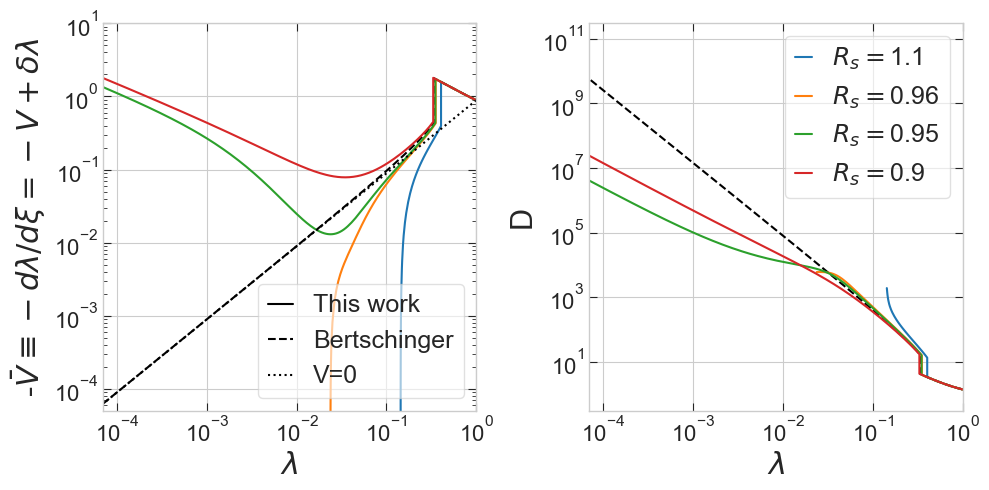

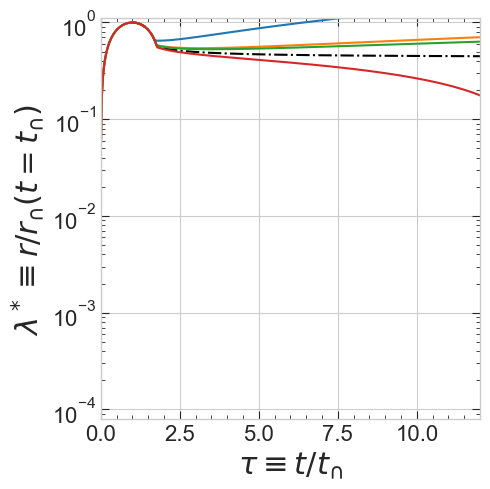

In [40]:
name = 'cold_vary-s'
name = 'shocked_vary-s'
# name = 'shocked_vary-gam'
# name = 'shocked_vary-cooling'
# name = 'shocked_vary-lamdish'
name = 'shocked_vary-lamshsp'

with open(f'{name}-rads.txt', 'tr') as file: rads_list = np.array(eval(file.read()))

s = 1
gam = 5/3
Lam0 = 3e-4
nu=1/2
fb = 0.156837
# fb = 0.5
fd = (1-fb)

lamshsp = 0.9
disk_rad_by_shock = 0.05e-4
lamdish = disk_rad_by_shock #*lamsh

varypars=[]

if name == 'cold_vary-s':
    s_vals = [0.5,1,1.5,2,3,]
    varypars += ['s']
    lamshsp = 0.1
    lamdish = 0.5

if name == 'shocked_vary-s':
    s_vals = [0.5,1,2,]#[:-1]
    varypars += ['s']
    rads_list = rads_list[[0,1,3]]

if name == 'shocked_vary-gam':
    gam_vals= [2,1.8,5/3,1.5,7/5,4/3,]
    lamshsp_vals = [1.2,1.05,0.9,0.7,0.5,0.3]
    varypars += ['gam','lamshsp']

if name == 'shocked_vary-cooling':
    Lam0_vals = [1e-3,3e-3,1e-2,3e-2,1e-1,3e-1]
    varypars += ['Lam0']

if name == 'shocked_vary-lamdish':
    lamdish_vals = [percent/100 for percent in [2,5,10,15,25]]
    varypars += ['lamdish']

if name == 'shocked_vary-lamshsp':
    lamshsp_vals = [1.1,0.96,.95,.9]#,.8,.7,.6,.5]#[0.35,0.3,0.25, 0.2]
    varypars += ['lamshsp']


fig5, axs5 = plt.subplots(1,2, dpi=100, figsize=(10,5), sharex=True)
fig51, axs51 = plt.subplots(1,2, dpi=100, figsize=(13,6), sharex=True)
axs5 = np.vstack([axs5,axs51])
fig6, ax6 = plt.subplots(1, dpi=100, figsize=(5,5))
fig62, ax62 = plt.subplots(1, dpi=100, figsize=(7,7))
fig7, ax7 = plt.subplots(1, dpi=100, figsize=(5,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(20):
    plab=''
    try:
        if 'gam' in varypars: gam = gam_vals[i]; plab+=r'$\gamma=$'+f"{gam:.3g}"
        if 's' in varypars: s = s_vals[i]; plab+=f"s={s} "
        if 'lamshsp' in varypars: lamshsp = lamshsp_vals[i]
        if 'lamshsp' in varypars[:1]: plab+=r'$R_s=$'+f'{lamshsp:g}'#plab+=r'$\lambda_s=$'+f'{lamshsp*100:g} '+r'$\%~ \lambda_{sp}$'
        if 'lamdish' in varypars: lamdish = lamdish_vals[i]; plab+=r'$\lambda_d=$'+f'{lamdish*100:g} '+r'$\%~ \lambda_s$'
        if 'Lam0' in varypars: Lam0 = Lam0_vals[i]; plab+=r'$\Lambda_0=$'+f'{Lam0:g} '
        # if 'nu' in varypars: nu = nu_vals[i]; plab+=r'$\nu=$'+f'{nu} '
    except IndexError: break

    t_now = time()
    de = 2* (1+s/3) /3
    alpha_D = -9/(s+3)
    descr = f'_{name}_lamshsp={lamshsp:.3g}_s={s:.2g}_gam={gam:.3g}_lamdish={lamdish:.3g}_Lam0={Lam0:.1e}_nu={nu:.1g}'

    resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm{descr}.hdf5', key=f'gas/iter0', mode='r')
    # lamsh = resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()]
    lamsh = lamshsp*rads_list[0][2] #rads_list[i][1]  #
    lamdi = lamdish*lamsh
    
    # lamshsol = 0.35 #lamsh_sols[s] #+5e-3 # 0.338976 #
    res_pre, res_post = get_soln_gas_full(lamsh)
    # print(res_post.y[2][-1])
    t_bef, t_now = t_now, time()
    # print(f'{t_now-t_bef:.4g}s', f's={s}: post shock profiles obtained')

    lamsh_pre = res_pre.t
    V_pre, D_pre, M_pre = res_pre.y

    lamsh_post = np.exp(res_post.t)
    mVb_post, D_post, M_post, P_post = np.exp(res_post.y)
    V_post = de*lamsh_post - mVb_post
    P_pre = lamsh_pre*0

    lamsh = lamsh_pre.min()
    # lam_all = lamsh_pre
    # V_all = V_pre
    # D_all = D_pre
    # M_all = M_pre
    # P_all = P_pre

    lam_all = np.concatenate([lamsh_post, lamsh_pre][::-1])
    V_all = np.concatenate([V_post, V_pre][::-1])
    D_all = np.concatenate([D_post, D_pre][::-1])
    M_all = np.concatenate([M_post, M_pre][::-1])
    P_all = np.concatenate([P_post, P_pre][::-1])
    Vb_all = V_all - de*lam_all

    color_this = colors[i] #plt.cm.turbo(s/4)

    ax7.plot(lam_all,-V_all, color=color_this)
    ax7.set_xscale('log')

    axs5[0,0].plot(lam_all,-Vb_all, color=color_this)
    axs5[0,1].plot(lam_all,D_all, color=color_this, label=plab)
    axs5[1,0].plot(lam_all,M_all, color=color_this)
    axs5[1,1].plot(lam_all,P_all, color=color_this)
    # axs5[0,2].plot(lam_all, P_all/D_all, color=color_this)
    # axs5[1,2].plot(lam_all, P_all/D_all**gam, color=color_this)
    # axs5[1,2].plot(lam_all, D_all*Vb_all**2-gam*P_all, color=color_this)

    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm_shocked_vary-s_lamshsp=0.9_s={s:.2g}_gam={gam:.3g}_lamdish=0.05_Lam0=3.0e-02_nu=0.5.hdf5', key=f'gas/main', mode='r')
    bertshi_vary = True if name.split('-')[-1] in ['gam','s'] else False
    color_this_bertshi = color_this if bertshi_vary else 'k'
    if bertshi_vary or i==0:
        axs5[0,0].plot(resdf_prof_gaso_bertshi.l, -resdf_prof_gaso_bertshi.Vb, color=color_this_bertshi, ls='--')
        axs5[0,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.D, color=color_this_bertshi, ls='--')
        axs5[1,0].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.M, color=color_this_bertshi, ls='--')
        axs5[1,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.P, color=color_this_bertshi, ls='--')
        # print(resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()])
    # PderD_post = np.gradient(P_post,lamsh_post)/D_post

    M_intrp = interp1d(lam_all, M_all, fill_value="extrapolate")
    D_intrp = interp1d(lam_all, D_all, fill_value="extrapolate")
    V_intrp = interp1d(lam_all, V_all, fill_value="extrapolate")
    irem = P_pre.shape[0]-1
    # PderD_intrp = interp1d(np.delete(lam_all,irem), np.delete(PderD_all,irem), kind='linear', fill_value="extrapolate")

    # PderD_intrp = interp1d(lamsh_post, PderD_post, kind='linear', fill_value=0, bounds_error=False)

    t_bef, t_now = t_now, time()
    # print(f'{t_now-t_bef:.4g}s', f's={s}: all profiles obtained')

    def odefunc_traj(xi, arg):
        lam = arg
        return V_intrp(lam)-de*lam

    # taush = (thtshsol - np.sin(thtshsol)) / np.pi
    # xish = np.log(taush)
    # res = solve_ivp(odefunc_traj, (0,5), (1,), method='Radau', max_step=0.01, dense_output=False, vectorized=True)
    # res1 = solve_ivp(fun, (res.t[-1],15), np.array([res.y[0][-1],-res.y[1][-1]]), max_step=0.1, dense_output=True)

    t_bef, t_now = t_now, time()
    # print(f'{t_now-t_bef:.4g}s', f's={s}: post shock trajectory obtained')
    
    # xires = res.t
    # lamres = res.y[0]
    # vres = res.y[1]
    xires,lamres = cumtrapz(1/(V_all-de*lam_all), x=lam_all), lam_all[1:]

    taures = np.exp(xires)
    lamFres = lamres*taures**de

    ax6.plot(taures,lamFres, color=color_this, label=plab)
    ax62.plot(xires,lamres, color=color_this)
    xio,lamo = cumtrapz(1/(resdf_prof_gaso_bertshi.V-de*resdf_prof_gaso_bertshi.l), x=resdf_prof_gaso_bertshi.l), resdf_prof_gaso_bertshi.l[1:]
    tauo = np.exp(xio)
    lamFo = lamo*tauo**de
    if bertshi_vary or i==0:
        ax62.plot(xio,lamo, c=color_this_bertshi, ls='-.')
        ax6.plot(tauo,lamFo, color=color_this_bertshi, ls='-.')

    #trajectory analytical
    thet_range = np.linspace(0.5, 1.2*np.pi,2000)
    tau_anlt = (thet_range - np.sin(thet_range)) / np.pi
    xi_anlt = np.log(tau_anlt)
    lam_anlt = preshock(thet_range)[0]
    lamF_anlt = lam_anlt*tau_anlt**de

    # ax6.plot(xi_anlt, lam_anlt, color=color_this)
    ax6.plot(tau_anlt, lamF_anlt, color=color_this)
    
    # dmo_prfl = pd.read_hdf(f'profiles_dmo_{s}.hdf5')

    # Mta = (3*np.pi/4)**2
    # M_dmo = interp1d(dmo_prfl['l'], dmo_prfl['M']*Mta, fill_value="extrapolate")
    # D_dmo = interp1d(dmo_prfl['l'].iloc[1:], dmo_prfl['rho'].iloc[1:], fill_value="extrapolate")

    # axs5[1,0].plot(lam_all, M_dmo(lam_all), color=color_this, ls='dashed')
    if name.split('_')[-1] =='vary-s':
        axs5[0,0].plot(lam_all,de*lam_all, c=color_this, ls=':')

#Loop ends

axs5[0,0].plot([],[], c='k', ls='-', label='This work')
axs5[0,0].plot([],[], c='k', ls='--', label='Bertschinger')
if name.split('_')[-1] !='vary-s':
    axs5[0,0].plot(lam_all,de*lam_all, c='k', ls=':', label='V=0')
else:
    axs5[0,0].plot([],[], c='k', ls=':', label='V=0')

# ax6.legend(loc='best',frameon=True, framealpha=0.6)
ax6.set_xlabel(r'$\tau \equiv t/t_{\cap}$')
ax6.set_ylabel(r'$\lambda^*\equiv r/r_{\cap}(t=t_{\cap})$')
ax6.set_xlim(0,12)
ax6.set_ylim(0.00008,1.1)
# ax6.set_xscale('log')
ax6.set_yscale('log')

ax62.set_xlabel(r'$\xi$')
ax62.set_ylabel('$\lambda$')
# ax62.set_xlim(,)
# ax62.set_ylim(0.01,1.1)
ax62.set_yscale('log')
    
axs5[0,0].set_xscale('log')
axs5[0,0].set_xlim(1e-5,1)
if name in ['shocked_vary-s','shocked_vary-lamshsp', 'shocked_vary-gam','cold_vary-s']:
    axs5[0,0].legend(loc='best', frameon=True, framealpha=0.6, handlelength=1)
axs5[0,1].legend(loc='best', frameon=True, framealpha=0.6, handlelength=0.7)
if name=='cold_vary-s':
    axs5[0,1].text(1e-3,1e9,'$R_s=0.1$', fontsize=15)
# axs5[0,1].legend()
axs5[0,0].set_xlabel('$\lambda$')
axs5[0,1].set_xlabel('$\lambda$')
axs5[1,0].set_xlabel('$\lambda$')
axs5[1,1].set_xlabel('$\lambda$')
# axs5[1,2].set_xlabel('$\lambda$')

# if gam==5/3:
#     axs5[0,0].set_xlim(7e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e-1,1e11)
#     axs5[1,0].set_ylim(1e-3,1e1)
#     # axs5[1,1].set_ylim(1e0,1e14)
#     # axs5[0,2].set_ylim(1e-1,1e2)
#     # axs5[1,2].set_ylim(1e-5,5e-1)
# elif gam==4/3:
#     axs5[0,0].set_xlim(1e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e0,1e11)
#     axs5[1,0].set_ylim(1e-2,1e1)
#     axs5[1,1].set_ylim(1e1,1e14)
#     # axs5[0,2].set_ylim(1e0,1e3)
#     # axs5[1,2].set_ylim(1e-2,5e-1)

axs5[0,0].set_xlim(7e-5,1)
axs5[0,0].set_ylim(5e-5,1e1)
axs5[0,1].set_ylim(3e-1,3e11)
axs5[1,0].set_ylim(1e-3,1e1)
# axs5[1,1].set_ylim(1e0,1e14)


axs5[0,0].set_ylabel(r'-$\bar{V} \equiv -d \lambda/d \xi = -V + \delta \lambda$')
axs5[0,1].set_ylabel('D')
axs5[1,0].set_ylabel('M')
axs5[1,1].set_ylabel('P')
# axs5[0,2].set_ylabel('T')
# axs5[1,2].set_ylabel('K')

axs5[0,0].set_yscale('log')
axs5[0,1].set_yscale('log')
axs5[1,0].set_yscale('log')
axs5[1,1].set_yscale('log')
ax62.set_xlim(0,5)
# axs5[0,2].set_yscale('log')
# axs5[1,2].set_yscale('log')

if name in ['shocked_vary-gam','shocked_vary-cooling']:
    axs5[0,0].set_ylabel(r'-$\bar{V}$')
    ax6.set_ylabel(r'$\lambda^*$')
# axs5[0,0].xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10,subs=np.arange(-4, 1)))
# axs5[0,0].xaxis.get_ticklocs(minor=True)
# axs5[0,0].minorticks_on()
# axs5[0,0].xaxis.set_tick_params(which='minor', bottom=True)

# # Additional lines to set major xticks
# axs5[0, 0].xaxis.set_major_locator(mpl.ticker.LogLocator(base=10, subs=np.arange(-4, 1,0.01)))
# axs5[0, 0].xaxis.get_ticklocs()

axs5[0,0].set_xticks([1e-4,1e-3,1e-2,1e-1,1])

fig5.tight_layout()
fig6.tight_layout()

fig5.savefig(f'Eds-gaso_profiles_{name}.pdf')
fig6.savefig(f'Eds-gaso_trajectory_{name}.pdf')
# axs5[0,0].set_xlim(1e-6,1)
# axs5[1,0].set_ylim(1e-4,1e1)

# plt.close(fig6)
plt.close(fig62)
plt.close(fig51)
plt.close(fig7)

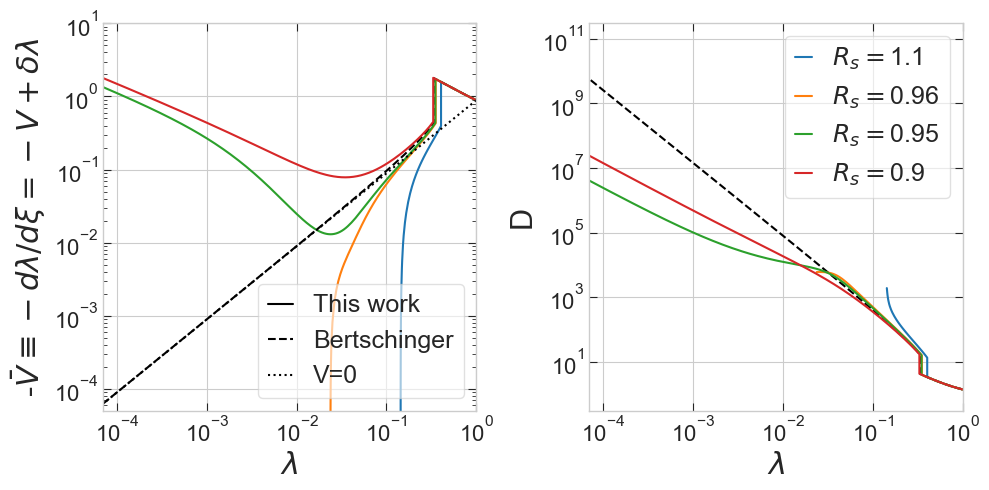

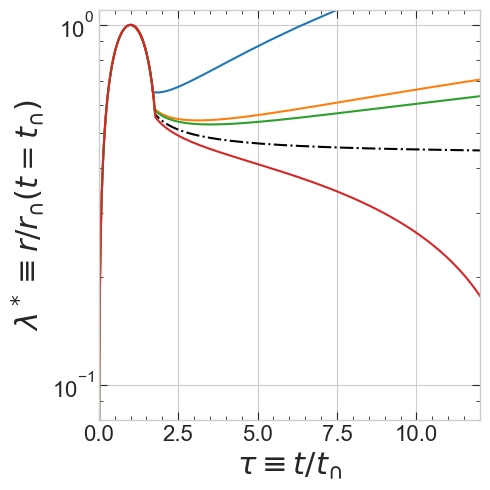

In [41]:
name = 'cold_vary-s'
name = 'shocked_vary-s'
# name = 'shocked_vary-gam'
# name = 'shocked_vary-cooling'
# name = 'shocked_vary-lamdish'
name = 'shocked_vary-lamshsp'

with open(f'{name}-rads.txt', 'tr') as file: rads_list = np.array(eval(file.read()))

s = 1
gam = 5/3
Lam0 = 3e-4
nu=1/2
fb = 0.156837
# fb = 0.5
fd = (1-fb)

lamshsp = 0.9
disk_rad_by_shock = 0.05e-4
lamdish = disk_rad_by_shock #*lamsh

varypars=[]

if name == 'cold_vary-s':
    s_vals = [0.5,1,1.5,2,3,]
    varypars += ['s']
    lamshsp = 0.1
    lamdish = 0.5

if name == 'shocked_vary-s':
    s_vals = [0.5,1,2,]#[:-1]
    varypars += ['s']
    rads_list = rads_list[[0,1,3]]

if name == 'shocked_vary-gam':
    gam_vals= [2,1.8,5/3,1.5,7/5,4/3,]
    lamshsp_vals = [1.2,1.05,0.9,0.7,0.5,0.3]
    varypars += ['gam','lamshsp']

if name == 'shocked_vary-cooling':
    Lam0_vals = [1e-3,3e-3,1e-2,3e-2,1e-1,3e-1]
    varypars += ['Lam0']

if name == 'shocked_vary-lamdish':
    lamdish_vals = [percent/100 for percent in [2,5,10,15,25]]
    varypars += ['lamdish']

if name == 'shocked_vary-lamshsp':
    lamshsp_vals = [1.1,0.96,.95,.9]#,.8,.7,.6,.5]#[0.35,0.3,0.25, 0.2]
    varypars += ['lamshsp']


fig5, axs5 = plt.subplots(1,2, dpi=100, figsize=(10,5), sharex=True)
fig51, axs51 = plt.subplots(1,2, dpi=100, figsize=(13,6), sharex=True)
axs5 = np.vstack([axs5,axs51])
fig6, ax6 = plt.subplots(1, dpi=100, figsize=(5,5))
fig62, ax62 = plt.subplots(1, dpi=100, figsize=(7,7))
fig7, ax7 = plt.subplots(1, dpi=100, figsize=(5,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(20):
    plab=''
    try:
        if 'gam' in varypars: gam = gam_vals[i]; plab+=r'$\gamma=$'+f"{gam:.3g}"
        if 's' in varypars: s = s_vals[i]; plab+=f"s={s} "
        if 'lamshsp' in varypars: lamshsp = lamshsp_vals[i]
        if 'lamshsp' in varypars[:1]: plab+=r'$R_s=$'+f'{lamshsp:g}'#plab+=r'$\lambda_s=$'+f'{lamshsp*100:g} '+r'$\%~ \lambda_{sp}$'
        if 'lamdish' in varypars: lamdish = lamdish_vals[i]; plab+=r'$\lambda_d=$'+f'{lamdish*100:g} '+r'$\%~ \lambda_s$'
        if 'Lam0' in varypars: Lam0 = Lam0_vals[i]; plab+=r'$\Lambda_0=$'+f'{Lam0:g} '
        # if 'nu' in varypars: nu = nu_vals[i]; plab+=r'$\nu=$'+f'{nu} '
    except IndexError: break

    t_now = time()
    de = 2* (1+s/3) /3
    alpha_D = -9/(s+3)
    descr = f'_{name}_lamshsp={lamshsp:.3g}_s={s:.2g}_gam={gam:.3g}_lamdish={lamdish:.3g}_Lam0={Lam0:.1e}_nu={nu:.1g}'

    resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm{descr}.hdf5', key=f'gas/iter0', mode='r')
    # lamsh = resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()]
    lamsh = lamshsp*rads_list[0][2] #rads_list[i][1]  #
    lamdi = lamdish*lamsh
    
    # lamshsol = 0.35 #lamsh_sols[s] #+5e-3 # 0.338976 #
    res_pre, res_post = get_soln_gas_full(lamsh)
    # print(res_post.y[2][-1])
    t_bef, t_now = t_now, time()
    # print(f'{t_now-t_bef:.4g}s', f's={s}: post shock profiles obtained')

    lamsh_pre = res_pre.t
    V_pre, D_pre, M_pre = res_pre.y

    lamsh_post = np.exp(res_post.t)
    mVb_post, D_post, M_post, P_post = np.exp(res_post.y)
    V_post = de*lamsh_post - mVb_post
    P_pre = lamsh_pre*0

    lamsh = lamsh_pre.min()
    # lam_all = lamsh_pre
    # V_all = V_pre
    # D_all = D_pre
    # M_all = M_pre
    # P_all = P_pre

    lam_all = np.concatenate([lamsh_post, lamsh_pre][::-1])
    V_all = np.concatenate([V_post, V_pre][::-1])
    D_all = np.concatenate([D_post, D_pre][::-1])
    M_all = np.concatenate([M_post, M_pre][::-1])
    P_all = np.concatenate([P_post, P_pre][::-1])
    Vb_all = V_all - de*lam_all

    color_this = colors[i] #plt.cm.turbo(s/4)

    ax7.plot(lam_all,-V_all, color=color_this)
    ax7.set_xscale('log')

    axs5[0,0].plot(lam_all,-Vb_all, color=color_this)
    axs5[0,1].plot(lam_all,D_all, color=color_this, label=plab)
    axs5[1,0].plot(lam_all,M_all, color=color_this)
    axs5[1,1].plot(lam_all,P_all, color=color_this)
    # axs5[0,2].plot(lam_all, P_all/D_all, color=color_this)
    # axs5[1,2].plot(lam_all, P_all/D_all**gam, color=color_this)
    # axs5[1,2].plot(lam_all, D_all*Vb_all**2-gam*P_all, color=color_this)

    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gaso_bertshi_s={s:.2g}_gam={gam:.3g}.hdf5', key=f'gas/main', mode='r')
    # resdf_prof_gaso_bertshi = pd.read_hdf(f'profiles_gasdm_shocked_vary-s_lamshsp=0.9_s={s:.2g}_gam={gam:.3g}_lamdish=0.05_Lam0=3.0e-02_nu=0.5.hdf5', key=f'gas/main', mode='r')
    bertshi_vary = True if name.split('-')[-1] in ['gam','s'] else False
    color_this_bertshi = color_this if bertshi_vary else 'k'
    if bertshi_vary or i==0:
        axs5[0,0].plot(resdf_prof_gaso_bertshi.l, -resdf_prof_gaso_bertshi.Vb, color=color_this_bertshi, ls='--')
        axs5[0,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.D, color=color_this_bertshi, ls='--')
        axs5[1,0].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.M, color=color_this_bertshi, ls='--')
        axs5[1,1].plot(resdf_prof_gaso_bertshi.l, resdf_prof_gaso_bertshi.P, color=color_this_bertshi, ls='--')
        # print(resdf_prof_gaso_bertshi.l[np.diff(resdf_prof_gaso_bertshi.Vb).argmax()])
    # PderD_post = np.gradient(P_post,lamsh_post)/D_post

    M_intrp = interp1d(lam_all, M_all, fill_value="extrapolate")
    D_intrp = interp1d(lam_all, D_all, fill_value="extrapolate")
    V_intrp = interp1d(lam_all, V_all, fill_value="extrapolate")
    irem = P_pre.shape[0]-1
    # PderD_intrp = interp1d(np.delete(lam_all,irem), np.delete(PderD_all,irem), kind='linear', fill_value="extrapolate")

    # PderD_intrp = interp1d(lamsh_post, PderD_post, kind='linear', fill_value=0, bounds_error=False)

    t_bef, t_now = t_now, time()
    # print(f'{t_now-t_bef:.4g}s', f's={s}: all profiles obtained')

    def odefunc_traj(xi, arg):
        lam = arg
        return V_intrp(lam)-de*lam

    # taush = (thtshsol - np.sin(thtshsol)) / np.pi
    # xish = np.log(taush)
    # res = solve_ivp(odefunc_traj, (0,5), (1,), method='Radau', max_step=0.01, dense_output=False, vectorized=True)
    # res1 = solve_ivp(fun, (res.t[-1],15), np.array([res.y[0][-1],-res.y[1][-1]]), max_step=0.1, dense_output=True)

    t_bef, t_now = t_now, time()
    # print(f'{t_now-t_bef:.4g}s', f's={s}: post shock trajectory obtained')
    
    # xires = res.t
    # lamres = res.y[0]
    # vres = res.y[1]
    xires,lamres = cumtrapz(1/(V_all-de*lam_all), x=lam_all), lam_all[1:]

    taures = np.exp(xires)
    lamFres = lamres*taures**de

    ax6.plot(taures,lamFres, color=color_this, label=plab)
    ax62.plot(xires,lamres, color=color_this)
    xio,lamo = cumtrapz(1/(resdf_prof_gaso_bertshi.V-de*resdf_prof_gaso_bertshi.l), x=resdf_prof_gaso_bertshi.l), resdf_prof_gaso_bertshi.l[1:]
    tauo = np.exp(xio)
    lamFo = lamo*tauo**de
    if bertshi_vary or i==0:
        ax62.plot(xio,lamo, c=color_this_bertshi, ls='-.')
        ax6.plot(tauo,lamFo, color=color_this_bertshi, ls='-.')

    #trajectory analytical
    thet_range = np.linspace(0.5, 1.2*np.pi,2000)
    tau_anlt = (thet_range - np.sin(thet_range)) / np.pi
    xi_anlt = np.log(tau_anlt)
    lam_anlt = preshock(thet_range)[0]
    lamF_anlt = lam_anlt*tau_anlt**de

    # ax6.plot(xi_anlt, lam_anlt, color=color_this)
    ax6.plot(tau_anlt, lamF_anlt, color=color_this)
    
    # dmo_prfl = pd.read_hdf(f'profiles_dmo_{s}.hdf5')

    # Mta = (3*np.pi/4)**2
    # M_dmo = interp1d(dmo_prfl['l'], dmo_prfl['M']*Mta, fill_value="extrapolate")
    # D_dmo = interp1d(dmo_prfl['l'].iloc[1:], dmo_prfl['rho'].iloc[1:], fill_value="extrapolate")

    # axs5[1,0].plot(lam_all, M_dmo(lam_all), color=color_this, ls='dashed')
    if name.split('_')[-1] =='vary-s':
        axs5[0,0].plot(lam_all,de*lam_all, c=color_this, ls=':')

#Loop ends

axs5[0,0].plot([],[], c='k', ls='-', label='This work')
axs5[0,0].plot([],[], c='k', ls='--', label='Bertschinger')
if name.split('_')[-1] !='vary-s':
    axs5[0,0].plot(lam_all,de*lam_all, c='k', ls=':', label='V=0')
else:
    axs5[0,0].plot([],[], c='k', ls=':', label='V=0')

# ax6.legend(loc='best',frameon=True, framealpha=0.6)
ax6.set_xlabel(r'$\tau \equiv t/t_{\cap}$')
ax6.set_ylabel(r'$\lambda^*\equiv r/r_{\cap}(t=t_{\cap})$')
ax6.set_xlim(0,12)
ax6.set_ylim(0.00008e3,1.1)
# ax6.set_xscale('log')
ax6.set_yscale('log')

ax62.set_xlabel(r'$\xi$')
ax62.set_ylabel('$\lambda$')
# ax62.set_xlim(,)
# ax62.set_ylim(0.01,1.1)
ax62.set_yscale('log')
    
axs5[0,0].set_xscale('log')
axs5[0,0].set_xlim(1e-5,1)
if name in ['shocked_vary-s','shocked_vary-lamshsp', 'shocked_vary-gam','cold_vary-s']:
    axs5[0,0].legend(loc='best', frameon=True, framealpha=0.6, handlelength=1)
axs5[0,1].legend(loc='best', frameon=True, framealpha=0.6, handlelength=0.7)
if name=='cold_vary-s':
    axs5[0,1].text(1e-3,1e9,'$R_s=0.1$', fontsize=15)
# axs5[0,1].legend()
axs5[0,0].set_xlabel('$\lambda$')
axs5[0,1].set_xlabel('$\lambda$')
axs5[1,0].set_xlabel('$\lambda$')
axs5[1,1].set_xlabel('$\lambda$')
# axs5[1,2].set_xlabel('$\lambda$')

# if gam==5/3:
#     axs5[0,0].set_xlim(7e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e-1,1e11)
#     axs5[1,0].set_ylim(1e-3,1e1)
#     # axs5[1,1].set_ylim(1e0,1e14)
#     # axs5[0,2].set_ylim(1e-1,1e2)
#     # axs5[1,2].set_ylim(1e-5,5e-1)
# elif gam==4/3:
#     axs5[0,0].set_xlim(1e-5,1)
#     axs5[0,0].set_ylim(5e-6,1e1)
#     axs5[0,1].set_ylim(1e0,1e11)
#     axs5[1,0].set_ylim(1e-2,1e1)
#     axs5[1,1].set_ylim(1e1,1e14)
#     # axs5[0,2].set_ylim(1e0,1e3)
#     # axs5[1,2].set_ylim(1e-2,5e-1)

axs5[0,0].set_xlim(7e-5,1)
axs5[0,0].set_ylim(5e-5,1e1)
axs5[0,1].set_ylim(3e-1,3e11)
axs5[1,0].set_ylim(1e-3,1e1)
# axs5[1,1].set_ylim(1e0,1e14)


axs5[0,0].set_ylabel(r'-$\bar{V} \equiv -d \lambda/d \xi = -V + \delta \lambda$')
axs5[0,1].set_ylabel('D')
axs5[1,0].set_ylabel('M')
axs5[1,1].set_ylabel('P')
# axs5[0,2].set_ylabel('T')
# axs5[1,2].set_ylabel('K')

axs5[0,0].set_yscale('log')
axs5[0,1].set_yscale('log')
axs5[1,0].set_yscale('log')
axs5[1,1].set_yscale('log')
ax62.set_xlim(0,5)
# axs5[0,2].set_yscale('log')
# axs5[1,2].set_yscale('log')

if name in ['shocked_vary-gam','shocked_vary-cooling']:
    axs5[0,0].set_ylabel(r'-$\bar{V}$')
    ax6.set_ylabel(r'$\lambda^*$')
# axs5[0,0].xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10,subs=np.arange(-4, 1)))
# axs5[0,0].xaxis.get_ticklocs(minor=True)
# axs5[0,0].minorticks_on()
# axs5[0,0].xaxis.set_tick_params(which='minor', bottom=True)

# # Additional lines to set major xticks
# axs5[0, 0].xaxis.set_major_locator(mpl.ticker.LogLocator(base=10, subs=np.arange(-4, 1,0.01)))
# axs5[0, 0].xaxis.get_ticklocs()

axs5[0,0].set_xticks([1e-4,1e-3,1e-2,1e-1,1])

fig5.tight_layout()
fig6.tight_layout()

fig5.savefig(f'Eds-gaso_profiles_{name}.pdf')
fig6.savefig(f'Eds-gaso_trajectory_{name}.pdf')
# axs5[0,0].set_xlim(1e-6,1)
# axs5[1,0].set_ylim(1e-4,1e1)

# plt.close(fig6)
plt.close(fig62)
plt.close(fig51)
plt.close(fig7)